In [1]:
# Import Libraries
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

# Import the Movies Metadata
cwd = os.getcwd()


def get_genres(link, metadata_df):
    if str(link['tmdbId']).strip() != '' and len(metadata_df[metadata_df['id'] == link['tmdbId']]) > 0:
        movie_genres = metadata_df[metadata_df['id'] == link['tmdbId']].iloc[0]['genres']
    elif link['imdbId'].strip() != '' and len(metadata_df[metadata_df['imdb_id'] == link['imdbId']]) > 0:
        movie_genres = metadata_df[metadata_df['imdb_id'] == link['imdbId']].iloc[0]['genres']
    else:
        movie_genres = 'No Genre Specified'
    if movie_genres.strip() == '':
        movie_genres = 'No Genre Specified'
    return movie_genres


if not os.path.exists(os.path.join(cwd, 'data', 'processed', 'movies.csv')):
    mappings = pd.read_csv(os.path.join(cwd, 'data', 'processed', 'movie_mappings.csv'))
    data_types = {
        'movieId': int,
        'imdbId': str,
        'tmdbId': str,
    }
    links = pd.read_csv(os.path.join(cwd, 'data', 'links.csv'), dtype=data_types)
    links = links[links['movieId'].isin(mappings['rating_id'].unique().tolist())]
    links['imdbId'] = [f'tt{link}' for link in links['imdbId']]
    col_list = ['id', 'imdb_id', 'genres']
    movies = pd.read_csv(os.path.join(cwd, 'data', 'movies_metadata.csv'), usecols=col_list, dtype={'id': str})
    movies = movies[(movies['id'].isin(links['tmdbId'].unique().tolist())) | (movies['imdb_id'].isin(
        links['imdbId'].unique().tolist()))]
    movies['genres'] = ['|'.join([genre['name'] for genre in json.loads(movie.replace("'", '"'))]) for movie in
                        movies['genres']]
    links['genres'] = [get_genres(link, movies) for (_, link) in links.iterrows()]
    links.to_csv(os.path.join(cwd, 'data', 'processed', 'movies.csv'), index=False)
    del links
    del mappings
    del movies
    del col_list
    del data_types

movies = pd.read_csv(os.path.join(cwd, 'data', 'processed', 'movies.csv'), dtype={'tmdbId': str})

print(f"Number of Movies: {len(movies)}")

Number of Movies: 36305


In [2]:
def count_genre(df, ref_col, genres_list):
    keyword_count = dict()
    for s in genres_list:
        keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords):
            continue
        for s in liste_keywords:
            if pd.notnull(s):
                keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key=lambda x: x[1], reverse=True)
    return keyword_occurences, keyword_count

In [3]:
ratings = pd.read_csv(os.path.join(cwd, 'data', 'processed', 'train_ratings.csv'))
print(f'Number of Users: {len(ratings["userId"].unique())}')
genres = set()
for s in movies['genres'].str.split('|').values:
    genres = genres.union(set(s))

Number of Users: 252361


In [4]:
movie_ratings = pd.merge(ratings, movies[['movieId', 'genres']], on='movieId')
genre_occurrence, dum = count_genre(movie_ratings, 'genres', genres)
genre_occurrence

[['Drama', 10882026],
 ['Comedy', 8100954],
 ['Action', 6416445],
 ['Thriller', 6350926],
 ['Adventure', 5314902],
 ['Romance', 4229230],
 ['Crime', 4176503],
 ['Science Fiction', 3743181],
 ['Fantasy', 2979235],
 ['Family', 2734323],
 ['Mystery', 2128934],
 ['Horror', 1550136],
 ['Animation', 1402444],
 ['War', 943870],
 ['History', 936295],
 ['Music', 800563],
 ['Western', 400945],
 ['Documentary', 263185],
 ['No Genre Specified', 56876],
 ['Foreign', 41031],
 ['TV Movie', 13125]]

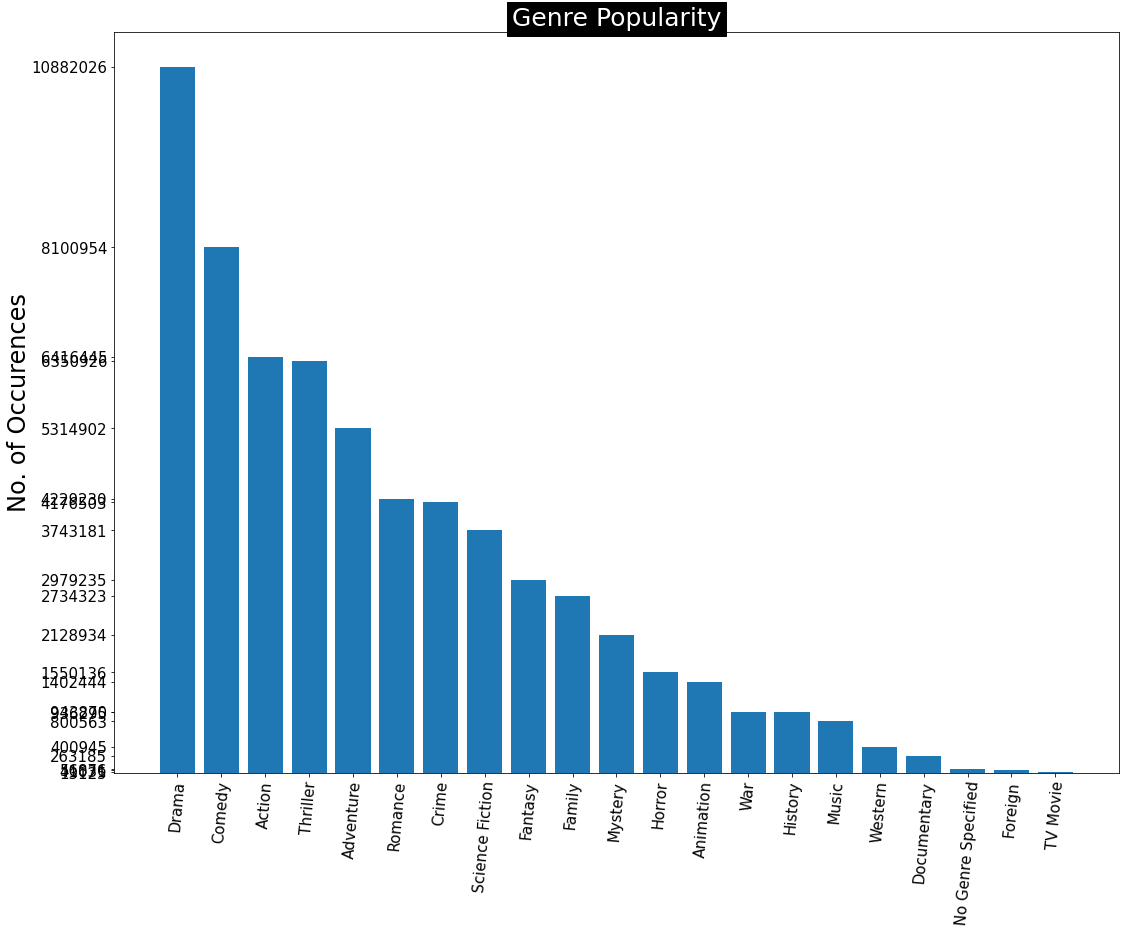

In [5]:
# Graph the Genres vs Occurrences
fig = plt.figure(1, figsize=(18, 30))
ax2 = fig.add_subplot(2, 1, 2)
y_axis = [i[1] for i in genre_occurrence]
y_label = [i[1] for i in genre_occurrence]
x_axis = [k for k, i in enumerate(genre_occurrence)]
x_label = [i[0] for i in genre_occurrence]
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.yticks(y_axis, y_label)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of Occurences", fontsize=24, labelpad=0)
ax2.bar(x_axis, y_axis, align='center')
plt.title("Genre Popularity", bbox={'facecolor': 'k', 'pad': 5}, color='w', fontsize=25)
plt.savefig(os.path.join(cwd, 'genre_occurrence.png'))


In [6]:
from utils import multi_hot_encoder

encoded_movie_ratings = multi_hot_encoder(movie_ratings, 'genres', [genre for (genre, _) in genre_occurrence])

encoded_movie_ratings = encoded_movie_ratings.drop(['timestamp'], axis=1)
encoded_movie_ratings


userId  movieId  rating                    genres  Drama  Comedy  \
0              1      110     1.0  Action|Drama|History|War    1.0     0.0   
1             11      110     3.5  Action|Drama|History|War    1.0     0.0   
2             22      110     5.0  Action|Drama|History|War    1.0     0.0   
3             24      110     5.0  Action|Drama|History|War    1.0     0.0   
4             29      110     3.0  Action|Drama|History|War    1.0     0.0   
...          ...      ...     ...                       ...    ...     ...   
23421855  270441   136750     4.0             Drama|Romance    1.0     0.0   
23421856  270441   140723     1.5           Comedy|Thriller    0.0     1.0   
23421857  270467   148458     3.0        No Genre Specified    0.0     0.0   
23421858  270469   130982     3.0                     Drama    1.0     0.0   
23421859  270654    98965     3.5                 Animation    0.0     0.0   

          Action  Thriller  Adventure  Romance  ...  Horror  Animation  War  \
0            1.0       0.0        0.0      0.0  ...     0.0        0.0  1.0   
1            1.0       0.0        0.0      0.0  ...     0.0        0.0  1.0   
2            1.0       0.0        0.0      0.0  ...     0.0        0.0  1.0   
3            1.0       0.0        0.0      0.0  ...     0.0        0.0  1.0   
4            1.0       0.0        0.0      0.0  ...     0.0        0.0  1.0   
...          ...       ...        ...      ...  ...     ...        ...  ...   
23421855     0.0       0.0        0.0      1.0  ...     0.0        0.0  0.0   
23421856     0.0       1.0        0.0      0.0  ...     0.0        0.0  0.0   
23421857     0.0       0.0        0.0      0.0  ...     0.0        0.0  0.0   
23421858     0.0       0.0        0.0      0.0  ...     0.0        0.0  0.0   
23421859     0.0       0.0        0.0      0.0  ...     0.0        1.0  0.0   

          History  Music  Western  Documentary  No Genre Specified  Foreign  \
0             1.0    0.0      0.0          0.0                 0.0      0.0   
1             1.0    0.0      0.0          0.0                 0.0      0.0   
2             1.0    0.0      0.0          0.0                 0.0      0.0   
3             1.0    0.0      0.0          0.0                 0.0      0.0   
4             1.0    0.0      0.0          0.0                 0.0      0.0   
...           ...    ...      ...          ...                 ...      ...   
23421855      0.0    0.0      0.0          0.0                 0.0      0.0   
23421856      0.0    0.0      0.0          0.0                 0.0      0.0   
23421857      0.0    0.0      0.0          0.0                 1.0      0.0   
23421858      0.0    0.0      0.0          0.0                 0.0      0.0   
23421859      0.0    0.0      0.0          0.0                 0.0      0.0   

          TV Movie  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
23421855       0.0  
23421856       0.0  
23421857       0.0  
23421858       0.0  
23421859       0.0  

[23421860 rows x 25 columns]

In [7]:
from utils import get_genre_ratings

average_ratings = get_genre_ratings(encoded_movie_ratings, genres)
# Fill NaN values with zero
average_ratings=average_ratings.fillna(0.0)
average_ratings.head()


Processing User 1
Processing User 11
Processing User 22
Processing User 24
Processing User 29
Processing User 30
Processing User 33
Processing User 49
Processing User 56
Processing User 58
Processing User 63
Processing User 64
Processing User 65
Processing User 67
Processing User 68
Processing User 75
Processing User 80
Processing User 82
Processing User 83
Processing User 88
Processing User 89
Processing User 98
Processing User 103
Processing User 109
Processing User 115
Processing User 120
Processing User 127
Processing User 128
Processing User 131
Processing User 132
Processing User 139
Processing User 142
Processing User 146
Processing User 150
Processing User 151
Processing User 153
Processing User 157
Processing User 158
Processing User 191
Processing User 193
Processing User 198
Processing User 201
Processing User 210
Processing User 212
Processing User 217
Processing User 224
Processing User 225
Processing User 227
Processing User 229
Processing User 231
Processing User 236
Pro

Processing User 1853
Processing User 1854
Processing User 1857
Processing User 1858
Processing User 1863
Processing User 1867
Processing User 1871
Processing User 1878
Processing User 1880
Processing User 1882
Processing User 1885
Processing User 1888
Processing User 1892
Processing User 1893
Processing User 1903
Processing User 1906
Processing User 1928
Processing User 1930
Processing User 1932
Processing User 1933
Processing User 1934
Processing User 1939
Processing User 1942
Processing User 1943
Processing User 1944
Processing User 1946
Processing User 1953
Processing User 1954
Processing User 1960
Processing User 1961
Processing User 1966
Processing User 1968
Processing User 1974
Processing User 1983
Processing User 1986
Processing User 1995
Processing User 2000
Processing User 2001
Processing User 2003
Processing User 2014
Processing User 2016
Processing User 2020
Processing User 2026
Processing User 2035
Processing User 2036
Processing User 2043
Processing User 2044
Processing Us

Processing User 3558
Processing User 3560
Processing User 3567
Processing User 3570
Processing User 3571
Processing User 3573
Processing User 3578
Processing User 3586
Processing User 3589
Processing User 3591
Processing User 3595
Processing User 3597
Processing User 3598
Processing User 3600
Processing User 3604
Processing User 3609
Processing User 3612
Processing User 3614
Processing User 3615
Processing User 3621
Processing User 3623
Processing User 3624
Processing User 3625
Processing User 3627
Processing User 3631
Processing User 3634
Processing User 3638
Processing User 3639
Processing User 3658
Processing User 3661
Processing User 3669
Processing User 3672
Processing User 3673
Processing User 3675
Processing User 3676
Processing User 3684
Processing User 3693
Processing User 3694
Processing User 3697
Processing User 3699
Processing User 3706
Processing User 3707
Processing User 3708
Processing User 3712
Processing User 3717
Processing User 3718
Processing User 3728
Processing Us

Processing User 5230
Processing User 5231
Processing User 5233
Processing User 5234
Processing User 5239
Processing User 5243
Processing User 5246
Processing User 5251
Processing User 5252
Processing User 5256
Processing User 5261
Processing User 5265
Processing User 5274
Processing User 5275
Processing User 5276
Processing User 5280
Processing User 5282
Processing User 5285
Processing User 5288
Processing User 5296
Processing User 5300
Processing User 5303
Processing User 5304
Processing User 5305
Processing User 5307
Processing User 5312
Processing User 5329
Processing User 5332
Processing User 5334
Processing User 5337
Processing User 5343
Processing User 5345
Processing User 5347
Processing User 5349
Processing User 5353
Processing User 5363
Processing User 5370
Processing User 5372
Processing User 5373
Processing User 5376
Processing User 5378
Processing User 5381
Processing User 5390
Processing User 5391
Processing User 5392
Processing User 5395
Processing User 5396
Processing Us

Processing User 6893
Processing User 6894
Processing User 6899
Processing User 6904
Processing User 6906
Processing User 6908
Processing User 6914
Processing User 6918
Processing User 6920
Processing User 6922
Processing User 6926
Processing User 6927
Processing User 6935
Processing User 6938
Processing User 6939
Processing User 6941
Processing User 6950
Processing User 6955
Processing User 6970
Processing User 6978
Processing User 6979
Processing User 6987
Processing User 6988
Processing User 6990
Processing User 6991
Processing User 6994
Processing User 7002
Processing User 7004
Processing User 7007
Processing User 7014
Processing User 7017
Processing User 7028
Processing User 7029
Processing User 7031
Processing User 7034
Processing User 7046
Processing User 7054
Processing User 7061
Processing User 7069
Processing User 7070
Processing User 7072
Processing User 7074
Processing User 7076
Processing User 7083
Processing User 7084
Processing User 7085
Processing User 7088
Processing Us

Processing User 8581
Processing User 8583
Processing User 8588
Processing User 8599
Processing User 8601
Processing User 8610
Processing User 8619
Processing User 8622
Processing User 8631
Processing User 8635
Processing User 8642
Processing User 8645
Processing User 8648
Processing User 8649
Processing User 8652
Processing User 8659
Processing User 8661
Processing User 8667
Processing User 8671
Processing User 8673
Processing User 8678
Processing User 8692
Processing User 8706
Processing User 8709
Processing User 8720
Processing User 8742
Processing User 8757
Processing User 8759
Processing User 8762
Processing User 8770
Processing User 8774
Processing User 8775
Processing User 8776
Processing User 8777
Processing User 8783
Processing User 8787
Processing User 8790
Processing User 8792
Processing User 8795
Processing User 8804
Processing User 8806
Processing User 8808
Processing User 8816
Processing User 8825
Processing User 8828
Processing User 8829
Processing User 8831
Processing Us

Processing User 10462
Processing User 10468
Processing User 10469
Processing User 10474
Processing User 10478
Processing User 10485
Processing User 10489
Processing User 10497
Processing User 10499
Processing User 10501
Processing User 10506
Processing User 10511
Processing User 10515
Processing User 10516
Processing User 10517
Processing User 10518
Processing User 10525
Processing User 10535
Processing User 10539
Processing User 10542
Processing User 10543
Processing User 10553
Processing User 10555
Processing User 10558
Processing User 10567
Processing User 10568
Processing User 10569
Processing User 10570
Processing User 10573
Processing User 10584
Processing User 10586
Processing User 10588
Processing User 10592
Processing User 10599
Processing User 10616
Processing User 10629
Processing User 10631
Processing User 10632
Processing User 10633
Processing User 10635
Processing User 10637
Processing User 10651
Processing User 10655
Processing User 10656
Processing User 10658
Processing

Processing User 12124
Processing User 12130
Processing User 12133
Processing User 12135
Processing User 12136
Processing User 12142
Processing User 12146
Processing User 12147
Processing User 12148
Processing User 12149
Processing User 12156
Processing User 12157
Processing User 12164
Processing User 12167
Processing User 12175
Processing User 12177
Processing User 12178
Processing User 12184
Processing User 12194
Processing User 12199
Processing User 12202
Processing User 12207
Processing User 12210
Processing User 12211
Processing User 12213
Processing User 12216
Processing User 12221
Processing User 12223
Processing User 12224
Processing User 12225
Processing User 12236
Processing User 12237
Processing User 12242
Processing User 12244
Processing User 12247
Processing User 12249
Processing User 12251
Processing User 12255
Processing User 12260
Processing User 12263
Processing User 12266
Processing User 12267
Processing User 12269
Processing User 12270
Processing User 12273
Processing

Processing User 13653
Processing User 13658
Processing User 13659
Processing User 13664
Processing User 13667
Processing User 13683
Processing User 13685
Processing User 13689
Processing User 13699
Processing User 13701
Processing User 13704
Processing User 13710
Processing User 13712
Processing User 13719
Processing User 13723
Processing User 13729
Processing User 13731
Processing User 13738
Processing User 13739
Processing User 13740
Processing User 13741
Processing User 13742
Processing User 13744
Processing User 13746
Processing User 13747
Processing User 13752
Processing User 13763
Processing User 13772
Processing User 13777
Processing User 13779
Processing User 13782
Processing User 13784
Processing User 13794
Processing User 13795
Processing User 13797
Processing User 13799
Processing User 13811
Processing User 13816
Processing User 13819
Processing User 13821
Processing User 13822
Processing User 13823
Processing User 13824
Processing User 13828
Processing User 13833
Processing

Processing User 15248
Processing User 15254
Processing User 15269
Processing User 15270
Processing User 15273
Processing User 15276
Processing User 15283
Processing User 15284
Processing User 15296
Processing User 15299
Processing User 15300
Processing User 15306
Processing User 15311
Processing User 15312
Processing User 15315
Processing User 15316
Processing User 15317
Processing User 15320
Processing User 15322
Processing User 15325
Processing User 15326
Processing User 15327
Processing User 15330
Processing User 15332
Processing User 15334
Processing User 15337
Processing User 15338
Processing User 15340
Processing User 15343
Processing User 15347
Processing User 15350
Processing User 15352
Processing User 15361
Processing User 15362
Processing User 15363
Processing User 15372
Processing User 15376
Processing User 15380
Processing User 15382
Processing User 15390
Processing User 15393
Processing User 15399
Processing User 15404
Processing User 15407
Processing User 15415
Processing

Processing User 16892
Processing User 16893
Processing User 16904
Processing User 16906
Processing User 16907
Processing User 16908
Processing User 16914
Processing User 16917
Processing User 16931
Processing User 16933
Processing User 16948
Processing User 16950
Processing User 16954
Processing User 16955
Processing User 16960
Processing User 16962
Processing User 16964
Processing User 16969
Processing User 16978
Processing User 16989
Processing User 16997
Processing User 17002
Processing User 17003
Processing User 17004
Processing User 17006
Processing User 17009
Processing User 17021
Processing User 17026
Processing User 17028
Processing User 17033
Processing User 17042
Processing User 17053
Processing User 17054
Processing User 17057
Processing User 17062
Processing User 17069
Processing User 17070
Processing User 17074
Processing User 17077
Processing User 17087
Processing User 17098
Processing User 17102
Processing User 17106
Processing User 17115
Processing User 17122
Processing

Processing User 18662
Processing User 18663
Processing User 18668
Processing User 18671
Processing User 18674
Processing User 18675
Processing User 18677
Processing User 18681
Processing User 18682
Processing User 18696
Processing User 18697
Processing User 18698
Processing User 18700
Processing User 18705
Processing User 18708
Processing User 18717
Processing User 18719
Processing User 18721
Processing User 18726
Processing User 18727
Processing User 18732
Processing User 18736
Processing User 18743
Processing User 18760
Processing User 18762
Processing User 18765
Processing User 18767
Processing User 18768
Processing User 18770
Processing User 18782
Processing User 18783
Processing User 18791
Processing User 18800
Processing User 18801
Processing User 18817
Processing User 18819
Processing User 18823
Processing User 18824
Processing User 18829
Processing User 18834
Processing User 18849
Processing User 18855
Processing User 18856
Processing User 18857
Processing User 18859
Processing

Processing User 20265
Processing User 20267
Processing User 20277
Processing User 20279
Processing User 20280
Processing User 20288
Processing User 20293
Processing User 20301
Processing User 20309
Processing User 20311
Processing User 20314
Processing User 20316
Processing User 20318
Processing User 20330
Processing User 20334
Processing User 20335
Processing User 20339
Processing User 20347
Processing User 20358
Processing User 20359
Processing User 20361
Processing User 20371
Processing User 20372
Processing User 20380
Processing User 20383
Processing User 20391
Processing User 20396
Processing User 20403
Processing User 20404
Processing User 20406
Processing User 20408
Processing User 20422
Processing User 20430
Processing User 20432
Processing User 20433
Processing User 20438
Processing User 20443
Processing User 20446
Processing User 20461
Processing User 20470
Processing User 20476
Processing User 20480
Processing User 20481
Processing User 20489
Processing User 20492
Processing

Processing User 21884
Processing User 21888
Processing User 21895
Processing User 21908
Processing User 21913
Processing User 21917
Processing User 21925
Processing User 21928
Processing User 21929
Processing User 21936
Processing User 21937
Processing User 21941
Processing User 21942
Processing User 21944
Processing User 21957
Processing User 21960
Processing User 21962
Processing User 21963
Processing User 21966
Processing User 21967
Processing User 21971
Processing User 21973
Processing User 21974
Processing User 21976
Processing User 21981
Processing User 21982
Processing User 21989
Processing User 21991
Processing User 21996
Processing User 22001
Processing User 22009
Processing User 22010
Processing User 22011
Processing User 22013
Processing User 22020
Processing User 22022
Processing User 22033
Processing User 22034
Processing User 22036
Processing User 22038
Processing User 22042
Processing User 22045
Processing User 22048
Processing User 22050
Processing User 22054
Processing

Processing User 23528
Processing User 23530
Processing User 23536
Processing User 23545
Processing User 23546
Processing User 23547
Processing User 23555
Processing User 23556
Processing User 23557
Processing User 23564
Processing User 23566
Processing User 23569
Processing User 23574
Processing User 23575
Processing User 23578
Processing User 23579
Processing User 23580
Processing User 23586
Processing User 23587
Processing User 23588
Processing User 23591
Processing User 23610
Processing User 23612
Processing User 23626
Processing User 23635
Processing User 23642
Processing User 23645
Processing User 23647
Processing User 23648
Processing User 23650
Processing User 23659
Processing User 23664
Processing User 23670
Processing User 23671
Processing User 23676
Processing User 23677
Processing User 23685
Processing User 23687
Processing User 23692
Processing User 23700
Processing User 23702
Processing User 23704
Processing User 23706
Processing User 23708
Processing User 23710
Processing

Processing User 25143
Processing User 25149
Processing User 25150
Processing User 25157
Processing User 25158
Processing User 25160
Processing User 25166
Processing User 25172
Processing User 25174
Processing User 25176
Processing User 25179
Processing User 25180
Processing User 25182
Processing User 25189
Processing User 25191
Processing User 25198
Processing User 25206
Processing User 25211
Processing User 25212
Processing User 25215
Processing User 25219
Processing User 25224
Processing User 25230
Processing User 25233
Processing User 25235
Processing User 25237
Processing User 25244
Processing User 25245
Processing User 25246
Processing User 25250
Processing User 25255
Processing User 25256
Processing User 25258
Processing User 25264
Processing User 25267
Processing User 25273
Processing User 25289
Processing User 25296
Processing User 25305
Processing User 25313
Processing User 25315
Processing User 25327
Processing User 25330
Processing User 25331
Processing User 25333
Processing

Processing User 26794
Processing User 26798
Processing User 26802
Processing User 26807
Processing User 26813
Processing User 26815
Processing User 26821
Processing User 26825
Processing User 26826
Processing User 26829
Processing User 26836
Processing User 26843
Processing User 26845
Processing User 26855
Processing User 26864
Processing User 26868
Processing User 26869
Processing User 26870
Processing User 26872
Processing User 26877
Processing User 26880
Processing User 26881
Processing User 26885
Processing User 26886
Processing User 26892
Processing User 26894
Processing User 26900
Processing User 26903
Processing User 26904
Processing User 26905
Processing User 26906
Processing User 26907
Processing User 26908
Processing User 26914
Processing User 26920
Processing User 26924
Processing User 26925
Processing User 26926
Processing User 26928
Processing User 26929
Processing User 26933
Processing User 26941
Processing User 26943
Processing User 26945
Processing User 26953
Processing

Processing User 28323
Processing User 28327
Processing User 28332
Processing User 28333
Processing User 28337
Processing User 28339
Processing User 28343
Processing User 28348
Processing User 28351
Processing User 28353
Processing User 28362
Processing User 28363
Processing User 28365
Processing User 28367
Processing User 28372
Processing User 28373
Processing User 28374
Processing User 28382
Processing User 28388
Processing User 28389
Processing User 28390
Processing User 28391
Processing User 28394
Processing User 28402
Processing User 28405
Processing User 28407
Processing User 28408
Processing User 28423
Processing User 28430
Processing User 28431
Processing User 28432
Processing User 28434
Processing User 28436
Processing User 28439
Processing User 28442
Processing User 28443
Processing User 28445
Processing User 28457
Processing User 28463
Processing User 28467
Processing User 28468
Processing User 28471
Processing User 28472
Processing User 28476
Processing User 28481
Processing

Processing User 29960
Processing User 29969
Processing User 29971
Processing User 29974
Processing User 29975
Processing User 29978
Processing User 29983
Processing User 29991
Processing User 29992
Processing User 29994
Processing User 29998
Processing User 30009
Processing User 30012
Processing User 30013
Processing User 30024
Processing User 30025
Processing User 30035
Processing User 30043
Processing User 30045
Processing User 30055
Processing User 30057
Processing User 30069
Processing User 30070
Processing User 30079
Processing User 30082
Processing User 30086
Processing User 30096
Processing User 30099
Processing User 30102
Processing User 30103
Processing User 30112
Processing User 30113
Processing User 30121
Processing User 30129
Processing User 30130
Processing User 30131
Processing User 30136
Processing User 30139
Processing User 30146
Processing User 30158
Processing User 30159
Processing User 30164
Processing User 30167
Processing User 30170
Processing User 30171
Processing

Processing User 31718
Processing User 31726
Processing User 31727
Processing User 31728
Processing User 31729
Processing User 31730
Processing User 31733
Processing User 31735
Processing User 31736
Processing User 31741
Processing User 31743
Processing User 31744
Processing User 31745
Processing User 31755
Processing User 31760
Processing User 31763
Processing User 31765
Processing User 31766
Processing User 31768
Processing User 31773
Processing User 31779
Processing User 31792
Processing User 31793
Processing User 31795
Processing User 31806
Processing User 31811
Processing User 31812
Processing User 31814
Processing User 31822
Processing User 31827
Processing User 31828
Processing User 31833
Processing User 31834
Processing User 31837
Processing User 31838
Processing User 31842
Processing User 31845
Processing User 31849
Processing User 31854
Processing User 31859
Processing User 31864
Processing User 31868
Processing User 31869
Processing User 31870
Processing User 31872
Processing

Processing User 33350
Processing User 33353
Processing User 33356
Processing User 33359
Processing User 33363
Processing User 33364
Processing User 33366
Processing User 33385
Processing User 33388
Processing User 33391
Processing User 33392
Processing User 33394
Processing User 33398
Processing User 33412
Processing User 33421
Processing User 33423
Processing User 33428
Processing User 33429
Processing User 33435
Processing User 33438
Processing User 33440
Processing User 33444
Processing User 33446
Processing User 33450
Processing User 33455
Processing User 33457
Processing User 33466
Processing User 33468
Processing User 33471
Processing User 33472
Processing User 33473
Processing User 33474
Processing User 33478
Processing User 33488
Processing User 33489
Processing User 33500
Processing User 33504
Processing User 33507
Processing User 33509
Processing User 33512
Processing User 33513
Processing User 33522
Processing User 33525
Processing User 33529
Processing User 33533
Processing

Processing User 34988
Processing User 34993
Processing User 34996
Processing User 35002
Processing User 35006
Processing User 35019
Processing User 35020
Processing User 35024
Processing User 35027
Processing User 35031
Processing User 35032
Processing User 35039
Processing User 35042
Processing User 35059
Processing User 35067
Processing User 35070
Processing User 35072
Processing User 35087
Processing User 35092
Processing User 35106
Processing User 35108
Processing User 35110
Processing User 35114
Processing User 35117
Processing User 35123
Processing User 35126
Processing User 35127
Processing User 35128
Processing User 35131
Processing User 35139
Processing User 35140
Processing User 35142
Processing User 35147
Processing User 35150
Processing User 35158
Processing User 35159
Processing User 35168
Processing User 35171
Processing User 35174
Processing User 35177
Processing User 35181
Processing User 35182
Processing User 35183
Processing User 35185
Processing User 35190
Processing

Processing User 36716
Processing User 36719
Processing User 36725
Processing User 36752
Processing User 36754
Processing User 36755
Processing User 36759
Processing User 36765
Processing User 36766
Processing User 36769
Processing User 36770
Processing User 36781
Processing User 36786
Processing User 36795
Processing User 36801
Processing User 36802
Processing User 36806
Processing User 36812
Processing User 36814
Processing User 36820
Processing User 36821
Processing User 36822
Processing User 36823
Processing User 36824
Processing User 36825
Processing User 36830
Processing User 36831
Processing User 36835
Processing User 36841
Processing User 36849
Processing User 36852
Processing User 36853
Processing User 36860
Processing User 36863
Processing User 36864
Processing User 36865
Processing User 36866
Processing User 36869
Processing User 36878
Processing User 36880
Processing User 36885
Processing User 36887
Processing User 36889
Processing User 36899
Processing User 36904
Processing

Processing User 38425
Processing User 38433
Processing User 38434
Processing User 38444
Processing User 38451
Processing User 38452
Processing User 38462
Processing User 38464
Processing User 38468
Processing User 38471
Processing User 38475
Processing User 38478
Processing User 38480
Processing User 38481
Processing User 38486
Processing User 38492
Processing User 38499
Processing User 38500
Processing User 38510
Processing User 38513
Processing User 38520
Processing User 38521
Processing User 38533
Processing User 38552
Processing User 38556
Processing User 38557
Processing User 38558
Processing User 38560
Processing User 38562
Processing User 38566
Processing User 38567
Processing User 38568
Processing User 38569
Processing User 38572
Processing User 38574
Processing User 38578
Processing User 38580
Processing User 38585
Processing User 38586
Processing User 38589
Processing User 38593
Processing User 38594
Processing User 38599
Processing User 38601
Processing User 38604
Processing

Processing User 40003
Processing User 40007
Processing User 40008
Processing User 40010
Processing User 40011
Processing User 40023
Processing User 40027
Processing User 40028
Processing User 40032
Processing User 40033
Processing User 40037
Processing User 40038
Processing User 40041
Processing User 40043
Processing User 40047
Processing User 40051
Processing User 40057
Processing User 40061
Processing User 40066
Processing User 40069
Processing User 40071
Processing User 40074
Processing User 40077
Processing User 40084
Processing User 40090
Processing User 40094
Processing User 40100
Processing User 40109
Processing User 40111
Processing User 40113
Processing User 40114
Processing User 40117
Processing User 40122
Processing User 40123
Processing User 40124
Processing User 40125
Processing User 40132
Processing User 40133
Processing User 40135
Processing User 40146
Processing User 40148
Processing User 40149
Processing User 40150
Processing User 40156
Processing User 40160
Processing

Processing User 41591
Processing User 41596
Processing User 41598
Processing User 41599
Processing User 41601
Processing User 41603
Processing User 41609
Processing User 41621
Processing User 41624
Processing User 41626
Processing User 41628
Processing User 41629
Processing User 41652
Processing User 41653
Processing User 41658
Processing User 41665
Processing User 41676
Processing User 41678
Processing User 41681
Processing User 41684
Processing User 41688
Processing User 41690
Processing User 41702
Processing User 41707
Processing User 41712
Processing User 41719
Processing User 41740
Processing User 41743
Processing User 41746
Processing User 41751
Processing User 41753
Processing User 41756
Processing User 41760
Processing User 41764
Processing User 41765
Processing User 41770
Processing User 41782
Processing User 41784
Processing User 41787
Processing User 41791
Processing User 41795
Processing User 41811
Processing User 41812
Processing User 41819
Processing User 41822
Processing

Processing User 43212
Processing User 43219
Processing User 43220
Processing User 43221
Processing User 43227
Processing User 43230
Processing User 43231
Processing User 43245
Processing User 43249
Processing User 43250
Processing User 43251
Processing User 43252
Processing User 43264
Processing User 43267
Processing User 43276
Processing User 43283
Processing User 43284
Processing User 43285
Processing User 43287
Processing User 43289
Processing User 43292
Processing User 43293
Processing User 43295
Processing User 43299
Processing User 43310
Processing User 43322
Processing User 43324
Processing User 43330
Processing User 43331
Processing User 43334
Processing User 43338
Processing User 43340
Processing User 43349
Processing User 43354
Processing User 43357
Processing User 43361
Processing User 43370
Processing User 43372
Processing User 43375
Processing User 43377
Processing User 43380
Processing User 43382
Processing User 43387
Processing User 43388
Processing User 43390
Processing

Processing User 44792
Processing User 44803
Processing User 44813
Processing User 44815
Processing User 44819
Processing User 44823
Processing User 44824
Processing User 44827
Processing User 44830
Processing User 44837
Processing User 44848
Processing User 44851
Processing User 44857
Processing User 44862
Processing User 44863
Processing User 44866
Processing User 44867
Processing User 44871
Processing User 44876
Processing User 44880
Processing User 44887
Processing User 44889
Processing User 44896
Processing User 44900
Processing User 44904
Processing User 44907
Processing User 44913
Processing User 44915
Processing User 44917
Processing User 44934
Processing User 44937
Processing User 44949
Processing User 44957
Processing User 44959
Processing User 44961
Processing User 44964
Processing User 44966
Processing User 44967
Processing User 44975
Processing User 44978
Processing User 44982
Processing User 44989
Processing User 44991
Processing User 44996
Processing User 44999
Processing

Processing User 46384
Processing User 46388
Processing User 46391
Processing User 46392
Processing User 46401
Processing User 46406
Processing User 46408
Processing User 46409
Processing User 46414
Processing User 46419
Processing User 46423
Processing User 46424
Processing User 46425
Processing User 46430
Processing User 46431
Processing User 46433
Processing User 46440
Processing User 46446
Processing User 46448
Processing User 46449
Processing User 46450
Processing User 46458
Processing User 46460
Processing User 46469
Processing User 46470
Processing User 46474
Processing User 46485
Processing User 46488
Processing User 46490
Processing User 46495
Processing User 46496
Processing User 46517
Processing User 46527
Processing User 46528
Processing User 46529
Processing User 46536
Processing User 46539
Processing User 46543
Processing User 46552
Processing User 46554
Processing User 46555
Processing User 46556
Processing User 46557
Processing User 46565
Processing User 46567
Processing

Processing User 47977
Processing User 47979
Processing User 47981
Processing User 47986
Processing User 47993
Processing User 47994
Processing User 47999
Processing User 48006
Processing User 48009
Processing User 48011
Processing User 48013
Processing User 48028
Processing User 48029
Processing User 48033
Processing User 48034
Processing User 48053
Processing User 48058
Processing User 48062
Processing User 48070
Processing User 48071
Processing User 48074
Processing User 48085
Processing User 48092
Processing User 48093
Processing User 48096
Processing User 48098
Processing User 48099
Processing User 48100
Processing User 48102
Processing User 48105
Processing User 48109
Processing User 48111
Processing User 48112
Processing User 48125
Processing User 48141
Processing User 48154
Processing User 48157
Processing User 48163
Processing User 48169
Processing User 48172
Processing User 48174
Processing User 48176
Processing User 48187
Processing User 48195
Processing User 48196
Processing

Processing User 49605
Processing User 49609
Processing User 49616
Processing User 49617
Processing User 49619
Processing User 49622
Processing User 49624
Processing User 49628
Processing User 49634
Processing User 49644
Processing User 49645
Processing User 49648
Processing User 49652
Processing User 49653
Processing User 49654
Processing User 49657
Processing User 49659
Processing User 49667
Processing User 49669
Processing User 49673
Processing User 49685
Processing User 49693
Processing User 49697
Processing User 49701
Processing User 49702
Processing User 49710
Processing User 49711
Processing User 49716
Processing User 49719
Processing User 49720
Processing User 49721
Processing User 49726
Processing User 49728
Processing User 49733
Processing User 49735
Processing User 49736
Processing User 49737
Processing User 49739
Processing User 49740
Processing User 49752
Processing User 49755
Processing User 49761
Processing User 49775
Processing User 49780
Processing User 49790
Processing

Processing User 51108
Processing User 51114
Processing User 51116
Processing User 51128
Processing User 51132
Processing User 51133
Processing User 51140
Processing User 51151
Processing User 51152
Processing User 51154
Processing User 51158
Processing User 51164
Processing User 51167
Processing User 51173
Processing User 51177
Processing User 51180
Processing User 51185
Processing User 51189
Processing User 51190
Processing User 51195
Processing User 51196
Processing User 51200
Processing User 51205
Processing User 51212
Processing User 51213
Processing User 51216
Processing User 51219
Processing User 51220
Processing User 51222
Processing User 51223
Processing User 51225
Processing User 51226
Processing User 51227
Processing User 51229
Processing User 51239
Processing User 51244
Processing User 51255
Processing User 51260
Processing User 51267
Processing User 51269
Processing User 51273
Processing User 51274
Processing User 51276
Processing User 51284
Processing User 51285
Processing

Processing User 52973
Processing User 52977
Processing User 52978
Processing User 52981
Processing User 52983
Processing User 52984
Processing User 52990
Processing User 52991
Processing User 52993
Processing User 52999
Processing User 53015
Processing User 53018
Processing User 53021
Processing User 53024
Processing User 53029
Processing User 53033
Processing User 53041
Processing User 53043
Processing User 53044
Processing User 53047
Processing User 53048
Processing User 53070
Processing User 53071
Processing User 53073
Processing User 53074
Processing User 53075
Processing User 53086
Processing User 53091
Processing User 53093
Processing User 53104
Processing User 53110
Processing User 53112
Processing User 53116
Processing User 53118
Processing User 53123
Processing User 53134
Processing User 53135
Processing User 53136
Processing User 53140
Processing User 53143
Processing User 53153
Processing User 53159
Processing User 53168
Processing User 53170
Processing User 53173
Processing

Processing User 54553
Processing User 54561
Processing User 54563
Processing User 54568
Processing User 54570
Processing User 54574
Processing User 54578
Processing User 54580
Processing User 54588
Processing User 54589
Processing User 54600
Processing User 54602
Processing User 54619
Processing User 54627
Processing User 54629
Processing User 54630
Processing User 54633
Processing User 54635
Processing User 54638
Processing User 54653
Processing User 54662
Processing User 54664
Processing User 54671
Processing User 54674
Processing User 54677
Processing User 54682
Processing User 54683
Processing User 54684
Processing User 54691
Processing User 54694
Processing User 54695
Processing User 54696
Processing User 54699
Processing User 54704
Processing User 54705
Processing User 54707
Processing User 54709
Processing User 54712
Processing User 54719
Processing User 54720
Processing User 54722
Processing User 54727
Processing User 54735
Processing User 54736
Processing User 54740
Processing

Processing User 56173
Processing User 56174
Processing User 56180
Processing User 56182
Processing User 56188
Processing User 56190
Processing User 56191
Processing User 56198
Processing User 56201
Processing User 56203
Processing User 56205
Processing User 56208
Processing User 56220
Processing User 56230
Processing User 56237
Processing User 56242
Processing User 56253
Processing User 56258
Processing User 56259
Processing User 56265
Processing User 56277
Processing User 56281
Processing User 56283
Processing User 56287
Processing User 56300
Processing User 56306
Processing User 56310
Processing User 56316
Processing User 56319
Processing User 56322
Processing User 56325
Processing User 56329
Processing User 56333
Processing User 56338
Processing User 56352
Processing User 56367
Processing User 56368
Processing User 56384
Processing User 56390
Processing User 56397
Processing User 56400
Processing User 56410
Processing User 56411
Processing User 56414
Processing User 56417
Processing

Processing User 57786
Processing User 57787
Processing User 57788
Processing User 57796
Processing User 57806
Processing User 57808
Processing User 57809
Processing User 57817
Processing User 57826
Processing User 57829
Processing User 57831
Processing User 57834
Processing User 57848
Processing User 57853
Processing User 57860
Processing User 57866
Processing User 57874
Processing User 57880
Processing User 57882
Processing User 57885
Processing User 57891
Processing User 57893
Processing User 57896
Processing User 57897
Processing User 57904
Processing User 57907
Processing User 57908
Processing User 57909
Processing User 57915
Processing User 57922
Processing User 57925
Processing User 57926
Processing User 57927
Processing User 57929
Processing User 57931
Processing User 57934
Processing User 57937
Processing User 57938
Processing User 57939
Processing User 57940
Processing User 57952
Processing User 57959
Processing User 57963
Processing User 57965
Processing User 57970
Processing

Processing User 59480
Processing User 59483
Processing User 59486
Processing User 59488
Processing User 59495
Processing User 59501
Processing User 59503
Processing User 59504
Processing User 59505
Processing User 59523
Processing User 59525
Processing User 59526
Processing User 59531
Processing User 59533
Processing User 59542
Processing User 59545
Processing User 59546
Processing User 59551
Processing User 59554
Processing User 59555
Processing User 59559
Processing User 59562
Processing User 59564
Processing User 59565
Processing User 59570
Processing User 59574
Processing User 59577
Processing User 59578
Processing User 59580
Processing User 59584
Processing User 59587
Processing User 59592
Processing User 59595
Processing User 59596
Processing User 59599
Processing User 59600
Processing User 59601
Processing User 59607
Processing User 59613
Processing User 59620
Processing User 59622
Processing User 59624
Processing User 59628
Processing User 59629
Processing User 59632
Processing

Processing User 61188
Processing User 61189
Processing User 61190
Processing User 61204
Processing User 61214
Processing User 61216
Processing User 61227
Processing User 61229
Processing User 61234
Processing User 61238
Processing User 61239
Processing User 61240
Processing User 61241
Processing User 61244
Processing User 61245
Processing User 61247
Processing User 61252
Processing User 61256
Processing User 61258
Processing User 61260
Processing User 61266
Processing User 61275
Processing User 61276
Processing User 61277
Processing User 61285
Processing User 61290
Processing User 61293
Processing User 61296
Processing User 61301
Processing User 61302
Processing User 61307
Processing User 61319
Processing User 61328
Processing User 61334
Processing User 61336
Processing User 61337
Processing User 61339
Processing User 61343
Processing User 61347
Processing User 61348
Processing User 61352
Processing User 61356
Processing User 61357
Processing User 61360
Processing User 61363
Processing

Processing User 62858
Processing User 62860
Processing User 62870
Processing User 62877
Processing User 62880
Processing User 62882
Processing User 62883
Processing User 62892
Processing User 62895
Processing User 62903
Processing User 62912
Processing User 62917
Processing User 62926
Processing User 62931
Processing User 62934
Processing User 62939
Processing User 62940
Processing User 62942
Processing User 62945
Processing User 62950
Processing User 62958
Processing User 62964
Processing User 62969
Processing User 62973
Processing User 62979
Processing User 62981
Processing User 62988
Processing User 62990
Processing User 62993
Processing User 62997
Processing User 63000
Processing User 63001
Processing User 63007
Processing User 63008
Processing User 63016
Processing User 63023
Processing User 63027
Processing User 63028
Processing User 63031
Processing User 63038
Processing User 63045
Processing User 63049
Processing User 63054
Processing User 63056
Processing User 63061
Processing

Processing User 64483
Processing User 64486
Processing User 64489
Processing User 64492
Processing User 64493
Processing User 64497
Processing User 64505
Processing User 64508
Processing User 64514
Processing User 64519
Processing User 64520
Processing User 64524
Processing User 64527
Processing User 64528
Processing User 64531
Processing User 64532
Processing User 64536
Processing User 64537
Processing User 64547
Processing User 64552
Processing User 64553
Processing User 64558
Processing User 64565
Processing User 64572
Processing User 64574
Processing User 64577
Processing User 64578
Processing User 64579
Processing User 64583
Processing User 64595
Processing User 64598
Processing User 64601
Processing User 64607
Processing User 64614
Processing User 64618
Processing User 64622
Processing User 64628
Processing User 64631
Processing User 64633
Processing User 64638
Processing User 64643
Processing User 64644
Processing User 64646
Processing User 64649
Processing User 64650
Processing

Processing User 66022
Processing User 66026
Processing User 66035
Processing User 66037
Processing User 66046
Processing User 66051
Processing User 66053
Processing User 66054
Processing User 66059
Processing User 66061
Processing User 66071
Processing User 66077
Processing User 66079
Processing User 66090
Processing User 66091
Processing User 66092
Processing User 66093
Processing User 66102
Processing User 66106
Processing User 66107
Processing User 66108
Processing User 66109
Processing User 66110
Processing User 66111
Processing User 66114
Processing User 66121
Processing User 66124
Processing User 66127
Processing User 66128
Processing User 66139
Processing User 66147
Processing User 66150
Processing User 66151
Processing User 66158
Processing User 66160
Processing User 66164
Processing User 66170
Processing User 66175
Processing User 66176
Processing User 66183
Processing User 66186
Processing User 66191
Processing User 66207
Processing User 66209
Processing User 66211
Processing

Processing User 67465
Processing User 67482
Processing User 67491
Processing User 67497
Processing User 67502
Processing User 67507
Processing User 67509
Processing User 67511
Processing User 67513
Processing User 67520
Processing User 67524
Processing User 67527
Processing User 67528
Processing User 67536
Processing User 67544
Processing User 67545
Processing User 67550
Processing User 67551
Processing User 67557
Processing User 67558
Processing User 67559
Processing User 67560
Processing User 67562
Processing User 67563
Processing User 67567
Processing User 67570
Processing User 67571
Processing User 67592
Processing User 67599
Processing User 67604
Processing User 67608
Processing User 67610
Processing User 67611
Processing User 67619
Processing User 67626
Processing User 67632
Processing User 67634
Processing User 67641
Processing User 67642
Processing User 67644
Processing User 67646
Processing User 67657
Processing User 67671
Processing User 67676
Processing User 67678
Processing

Processing User 69079
Processing User 69080
Processing User 69086
Processing User 69088
Processing User 69090
Processing User 69095
Processing User 69100
Processing User 69103
Processing User 69106
Processing User 69109
Processing User 69112
Processing User 69115
Processing User 69119
Processing User 69122
Processing User 69125
Processing User 69126
Processing User 69128
Processing User 69130
Processing User 69137
Processing User 69140
Processing User 69141
Processing User 69144
Processing User 69148
Processing User 69153
Processing User 69156
Processing User 69171
Processing User 69177
Processing User 69178
Processing User 69180
Processing User 69181
Processing User 69186
Processing User 69187
Processing User 69188
Processing User 69189
Processing User 69191
Processing User 69192
Processing User 69194
Processing User 69208
Processing User 69212
Processing User 69216
Processing User 69218
Processing User 69227
Processing User 69235
Processing User 69236
Processing User 69239
Processing

Processing User 70621
Processing User 70632
Processing User 70635
Processing User 70639
Processing User 70640
Processing User 70648
Processing User 70653
Processing User 70654
Processing User 70672
Processing User 70677
Processing User 70681
Processing User 70689
Processing User 70692
Processing User 70695
Processing User 70702
Processing User 70703
Processing User 70704
Processing User 70707
Processing User 70709
Processing User 70716
Processing User 70718
Processing User 70721
Processing User 70725
Processing User 70729
Processing User 70734
Processing User 70736
Processing User 70740
Processing User 70741
Processing User 70744
Processing User 70748
Processing User 70750
Processing User 70757
Processing User 70763
Processing User 70766
Processing User 70767
Processing User 70772
Processing User 70773
Processing User 70777
Processing User 70778
Processing User 70783
Processing User 70785
Processing User 70788
Processing User 70790
Processing User 70795
Processing User 70800
Processing

Processing User 72213
Processing User 72214
Processing User 72218
Processing User 72222
Processing User 72225
Processing User 72226
Processing User 72227
Processing User 72228
Processing User 72229
Processing User 72241
Processing User 72242
Processing User 72252
Processing User 72254
Processing User 72255
Processing User 72258
Processing User 72259
Processing User 72260
Processing User 72265
Processing User 72268
Processing User 72271
Processing User 72275
Processing User 72278
Processing User 72280
Processing User 72281
Processing User 72284
Processing User 72285
Processing User 72286
Processing User 72295
Processing User 72296
Processing User 72302
Processing User 72308
Processing User 72309
Processing User 72318
Processing User 72322
Processing User 72329
Processing User 72330
Processing User 72331
Processing User 72334
Processing User 72335
Processing User 72342
Processing User 72346
Processing User 72355
Processing User 72360
Processing User 72362
Processing User 72371
Processing

Processing User 73866
Processing User 73880
Processing User 73883
Processing User 73889
Processing User 73892
Processing User 73896
Processing User 73897
Processing User 73900
Processing User 73902
Processing User 73905
Processing User 73912
Processing User 73913
Processing User 73915
Processing User 73923
Processing User 73928
Processing User 73929
Processing User 73933
Processing User 73935
Processing User 73936
Processing User 73939
Processing User 73943
Processing User 73946
Processing User 73948
Processing User 73956
Processing User 73961
Processing User 73965
Processing User 73966
Processing User 73974
Processing User 73977
Processing User 73979
Processing User 73988
Processing User 73992
Processing User 73995
Processing User 73999
Processing User 74005
Processing User 74017
Processing User 74019
Processing User 74025
Processing User 74032
Processing User 74035
Processing User 74038
Processing User 74040
Processing User 74044
Processing User 74048
Processing User 74054
Processing

Processing User 75547
Processing User 75556
Processing User 75558
Processing User 75568
Processing User 75569
Processing User 75570
Processing User 75571
Processing User 75581
Processing User 75593
Processing User 75594
Processing User 75599
Processing User 75603
Processing User 75615
Processing User 75616
Processing User 75617
Processing User 75618
Processing User 75619
Processing User 75626
Processing User 75627
Processing User 75628
Processing User 75629
Processing User 75632
Processing User 75633
Processing User 75634
Processing User 75637
Processing User 75639
Processing User 75647
Processing User 75655
Processing User 75660
Processing User 75663
Processing User 75666
Processing User 75667
Processing User 75668
Processing User 75670
Processing User 75671
Processing User 75676
Processing User 75681
Processing User 75685
Processing User 75687
Processing User 75688
Processing User 75694
Processing User 75695
Processing User 75696
Processing User 75703
Processing User 75707
Processing

Processing User 77276
Processing User 77284
Processing User 77286
Processing User 77293
Processing User 77295
Processing User 77297
Processing User 77301
Processing User 77302
Processing User 77309
Processing User 77316
Processing User 77322
Processing User 77332
Processing User 77333
Processing User 77343
Processing User 77344
Processing User 77347
Processing User 77348
Processing User 77350
Processing User 77359
Processing User 77371
Processing User 77372
Processing User 77375
Processing User 77388
Processing User 77399
Processing User 77400
Processing User 77418
Processing User 77420
Processing User 77422
Processing User 77423
Processing User 77425
Processing User 77431
Processing User 77432
Processing User 77435
Processing User 77437
Processing User 77441
Processing User 77442
Processing User 77450
Processing User 77457
Processing User 77459
Processing User 77463
Processing User 77468
Processing User 77469
Processing User 77478
Processing User 77482
Processing User 77486
Processing

Processing User 78950
Processing User 78953
Processing User 78958
Processing User 78963
Processing User 78964
Processing User 78965
Processing User 78966
Processing User 78971
Processing User 78972
Processing User 78974
Processing User 78977
Processing User 78982
Processing User 78990
Processing User 78996
Processing User 79000
Processing User 79002
Processing User 79005
Processing User 79006
Processing User 79010
Processing User 79013
Processing User 79014
Processing User 79019
Processing User 79032
Processing User 79042
Processing User 79043
Processing User 79054
Processing User 79057
Processing User 79060
Processing User 79080
Processing User 79082
Processing User 79083
Processing User 79091
Processing User 79104
Processing User 79105
Processing User 79106
Processing User 79108
Processing User 79115
Processing User 79116
Processing User 79118
Processing User 79121
Processing User 79124
Processing User 79125
Processing User 79132
Processing User 79145
Processing User 79146
Processing

Processing User 80560
Processing User 80561
Processing User 80564
Processing User 80566
Processing User 80570
Processing User 80571
Processing User 80572
Processing User 80574
Processing User 80575
Processing User 80576
Processing User 80579
Processing User 80580
Processing User 80585
Processing User 80586
Processing User 80591
Processing User 80597
Processing User 80599
Processing User 80606
Processing User 80614
Processing User 80616
Processing User 80622
Processing User 80625
Processing User 80633
Processing User 80637
Processing User 80642
Processing User 80645
Processing User 80648
Processing User 80652
Processing User 80655
Processing User 80658
Processing User 80665
Processing User 80666
Processing User 80670
Processing User 80672
Processing User 80678
Processing User 80679
Processing User 80684
Processing User 80692
Processing User 80695
Processing User 80698
Processing User 80709
Processing User 80723
Processing User 80725
Processing User 80734
Processing User 80741
Processing

Processing User 82241
Processing User 82245
Processing User 82254
Processing User 82258
Processing User 82263
Processing User 82264
Processing User 82266
Processing User 82267
Processing User 82271
Processing User 82272
Processing User 82273
Processing User 82274
Processing User 82275
Processing User 82276
Processing User 82281
Processing User 82282
Processing User 82291
Processing User 82296
Processing User 82297
Processing User 82299
Processing User 82303
Processing User 82305
Processing User 82309
Processing User 82313
Processing User 82318
Processing User 82324
Processing User 82328
Processing User 82334
Processing User 82340
Processing User 82346
Processing User 82350
Processing User 82351
Processing User 82355
Processing User 82358
Processing User 82385
Processing User 82390
Processing User 82393
Processing User 82395
Processing User 82397
Processing User 82399
Processing User 82402
Processing User 82403
Processing User 82407
Processing User 82414
Processing User 82415
Processing

Processing User 83889
Processing User 83895
Processing User 83896
Processing User 83899
Processing User 83910
Processing User 83913
Processing User 83915
Processing User 83917
Processing User 83918
Processing User 83919
Processing User 83924
Processing User 83925
Processing User 83929
Processing User 83934
Processing User 83935
Processing User 83937
Processing User 83945
Processing User 83947
Processing User 83952
Processing User 83958
Processing User 83959
Processing User 83961
Processing User 83968
Processing User 83971
Processing User 83972
Processing User 83981
Processing User 83988
Processing User 83991
Processing User 83993
Processing User 83997
Processing User 83999
Processing User 84006
Processing User 84008
Processing User 84011
Processing User 84016
Processing User 84023
Processing User 84024
Processing User 84035
Processing User 84042
Processing User 84043
Processing User 84044
Processing User 84047
Processing User 84049
Processing User 84053
Processing User 84056
Processing

Processing User 85528
Processing User 85530
Processing User 85538
Processing User 85539
Processing User 85540
Processing User 85543
Processing User 85545
Processing User 85552
Processing User 85556
Processing User 85565
Processing User 85567
Processing User 85576
Processing User 85578
Processing User 85590
Processing User 85591
Processing User 85613
Processing User 85617
Processing User 85624
Processing User 85626
Processing User 85628
Processing User 85629
Processing User 85634
Processing User 85640
Processing User 85641
Processing User 85642
Processing User 85653
Processing User 85658
Processing User 85659
Processing User 85660
Processing User 85661
Processing User 85671
Processing User 85679
Processing User 85680
Processing User 85687
Processing User 85689
Processing User 85696
Processing User 85698
Processing User 85704
Processing User 85707
Processing User 85710
Processing User 85716
Processing User 85718
Processing User 85723
Processing User 85724
Processing User 85725
Processing

Processing User 87177
Processing User 87184
Processing User 87185
Processing User 87187
Processing User 87189
Processing User 87193
Processing User 87196
Processing User 87199
Processing User 87200
Processing User 87203
Processing User 87206
Processing User 87210
Processing User 87211
Processing User 87217
Processing User 87218
Processing User 87222
Processing User 87224
Processing User 87227
Processing User 87229
Processing User 87237
Processing User 87248
Processing User 87249
Processing User 87250
Processing User 87251
Processing User 87252
Processing User 87253
Processing User 87255
Processing User 87267
Processing User 87275
Processing User 87276
Processing User 87279
Processing User 87289
Processing User 87290
Processing User 87291
Processing User 87294
Processing User 87296
Processing User 87311
Processing User 87312
Processing User 87314
Processing User 87322
Processing User 87325
Processing User 87328
Processing User 87337
Processing User 87344
Processing User 87346
Processing

Processing User 88819
Processing User 88820
Processing User 88826
Processing User 88832
Processing User 88836
Processing User 88839
Processing User 88843
Processing User 88844
Processing User 88849
Processing User 88856
Processing User 88863
Processing User 88864
Processing User 88865
Processing User 88868
Processing User 88874
Processing User 88884
Processing User 88888
Processing User 88895
Processing User 88897
Processing User 88906
Processing User 88910
Processing User 88912
Processing User 88915
Processing User 88916
Processing User 88923
Processing User 88924
Processing User 88928
Processing User 88932
Processing User 88939
Processing User 88941
Processing User 88942
Processing User 88948
Processing User 88952
Processing User 88958
Processing User 88961
Processing User 88962
Processing User 88965
Processing User 88969
Processing User 88970
Processing User 88971
Processing User 88977
Processing User 88986
Processing User 88994
Processing User 88997
Processing User 89002
Processing

Processing User 90435
Processing User 90437
Processing User 90443
Processing User 90445
Processing User 90446
Processing User 90451
Processing User 90452
Processing User 90456
Processing User 90464
Processing User 90467
Processing User 90469
Processing User 90477
Processing User 90479
Processing User 90481
Processing User 90482
Processing User 90484
Processing User 90485
Processing User 90492
Processing User 90493
Processing User 90503
Processing User 90506
Processing User 90507
Processing User 90514
Processing User 90517
Processing User 90518
Processing User 90523
Processing User 90524
Processing User 90525
Processing User 90526
Processing User 90527
Processing User 90530
Processing User 90532
Processing User 90538
Processing User 90542
Processing User 90543
Processing User 90544
Processing User 90554
Processing User 90555
Processing User 90558
Processing User 90561
Processing User 90563
Processing User 90564
Processing User 90567
Processing User 90570
Processing User 90577
Processing

Processing User 92091
Processing User 92097
Processing User 92101
Processing User 92102
Processing User 92123
Processing User 92126
Processing User 92127
Processing User 92138
Processing User 92142
Processing User 92143
Processing User 92146
Processing User 92149
Processing User 92155
Processing User 92158
Processing User 92162
Processing User 92168
Processing User 92170
Processing User 92172
Processing User 92174
Processing User 92175
Processing User 92179
Processing User 92180
Processing User 92189
Processing User 92191
Processing User 92193
Processing User 92197
Processing User 92206
Processing User 92209
Processing User 92212
Processing User 92215
Processing User 92217
Processing User 92225
Processing User 92236
Processing User 92237
Processing User 92238
Processing User 92244
Processing User 92245
Processing User 92252
Processing User 92255
Processing User 92258
Processing User 92264
Processing User 92275
Processing User 92277
Processing User 92279
Processing User 92280
Processing

Processing User 93707
Processing User 93711
Processing User 93714
Processing User 93724
Processing User 93726
Processing User 93728
Processing User 93729
Processing User 93736
Processing User 93737
Processing User 93739
Processing User 93740
Processing User 93742
Processing User 93754
Processing User 93758
Processing User 93766
Processing User 93768
Processing User 93776
Processing User 93779
Processing User 93780
Processing User 93791
Processing User 93796
Processing User 93808
Processing User 93814
Processing User 93817
Processing User 93823
Processing User 93832
Processing User 93834
Processing User 93838
Processing User 93839
Processing User 93847
Processing User 93851
Processing User 93857
Processing User 93860
Processing User 93875
Processing User 93884
Processing User 93889
Processing User 93895
Processing User 93897
Processing User 93902
Processing User 93905
Processing User 93907
Processing User 93917
Processing User 93919
Processing User 93922
Processing User 93945
Processing

Processing User 95214
Processing User 95216
Processing User 95229
Processing User 95234
Processing User 95235
Processing User 95239
Processing User 95242
Processing User 95246
Processing User 95248
Processing User 95252
Processing User 95261
Processing User 95262
Processing User 95263
Processing User 95277
Processing User 95279
Processing User 95286
Processing User 95287
Processing User 95288
Processing User 95293
Processing User 95294
Processing User 95299
Processing User 95304
Processing User 95308
Processing User 95309
Processing User 95310
Processing User 95312
Processing User 95319
Processing User 95333
Processing User 95337
Processing User 95338
Processing User 95341
Processing User 95343
Processing User 95352
Processing User 95353
Processing User 95354
Processing User 95356
Processing User 95359
Processing User 95366
Processing User 95370
Processing User 95373
Processing User 95382
Processing User 95391
Processing User 95392
Processing User 95394
Processing User 95403
Processing

Processing User 96869
Processing User 96871
Processing User 96874
Processing User 96877
Processing User 96878
Processing User 96881
Processing User 96888
Processing User 96893
Processing User 96895
Processing User 96896
Processing User 96899
Processing User 96902
Processing User 96909
Processing User 96910
Processing User 96911
Processing User 96913
Processing User 96918
Processing User 96920
Processing User 96924
Processing User 96934
Processing User 96936
Processing User 96941
Processing User 96944
Processing User 96946
Processing User 96947
Processing User 96948
Processing User 96950
Processing User 96953
Processing User 96955
Processing User 96957
Processing User 96958
Processing User 96961
Processing User 96962
Processing User 96969
Processing User 96972
Processing User 96973
Processing User 96975
Processing User 96976
Processing User 96987
Processing User 96988
Processing User 97002
Processing User 97007
Processing User 97017
Processing User 97018
Processing User 97019
Processing

Processing User 98443
Processing User 98448
Processing User 98456
Processing User 98457
Processing User 98462
Processing User 98463
Processing User 98465
Processing User 98472
Processing User 98476
Processing User 98481
Processing User 98484
Processing User 98487
Processing User 98495
Processing User 98496
Processing User 98508
Processing User 98513
Processing User 98532
Processing User 98537
Processing User 98539
Processing User 98540
Processing User 98546
Processing User 98565
Processing User 98576
Processing User 98579
Processing User 98587
Processing User 98588
Processing User 98591
Processing User 98593
Processing User 98597
Processing User 98599
Processing User 98600
Processing User 98601
Processing User 98604
Processing User 98614
Processing User 98621
Processing User 98624
Processing User 98626
Processing User 98627
Processing User 98632
Processing User 98636
Processing User 98642
Processing User 98647
Processing User 98656
Processing User 98657
Processing User 98662
Processing

Processing User 100059
Processing User 100065
Processing User 100066
Processing User 100083
Processing User 100084
Processing User 100090
Processing User 100095
Processing User 100096
Processing User 100108
Processing User 100114
Processing User 100115
Processing User 100129
Processing User 100132
Processing User 100138
Processing User 100145
Processing User 100148
Processing User 100149
Processing User 100151
Processing User 100157
Processing User 100159
Processing User 100165
Processing User 100166
Processing User 100173
Processing User 100174
Processing User 100176
Processing User 100181
Processing User 100185
Processing User 100187
Processing User 100192
Processing User 100194
Processing User 100197
Processing User 100206
Processing User 100211
Processing User 100212
Processing User 100213
Processing User 100227
Processing User 100239
Processing User 100241
Processing User 100253
Processing User 100265
Processing User 100267
Processing User 100268
Processing User 100273
Processing 

Processing User 101699
Processing User 101704
Processing User 101705
Processing User 101709
Processing User 101710
Processing User 101711
Processing User 101722
Processing User 101727
Processing User 101729
Processing User 101730
Processing User 101731
Processing User 101737
Processing User 101739
Processing User 101743
Processing User 101744
Processing User 101745
Processing User 101751
Processing User 101752
Processing User 101755
Processing User 101759
Processing User 101760
Processing User 101764
Processing User 101765
Processing User 101766
Processing User 101770
Processing User 101773
Processing User 101781
Processing User 101783
Processing User 101789
Processing User 101792
Processing User 101796
Processing User 101800
Processing User 101804
Processing User 101808
Processing User 101813
Processing User 101820
Processing User 101822
Processing User 101824
Processing User 101838
Processing User 101844
Processing User 101846
Processing User 101849
Processing User 101850
Processing 

Processing User 103274
Processing User 103282
Processing User 103284
Processing User 103287
Processing User 103308
Processing User 103309
Processing User 103317
Processing User 103320
Processing User 103323
Processing User 103330
Processing User 103337
Processing User 103339
Processing User 103343
Processing User 103345
Processing User 103347
Processing User 103363
Processing User 103364
Processing User 103372
Processing User 103375
Processing User 103377
Processing User 103380
Processing User 103383
Processing User 103386
Processing User 103390
Processing User 103392
Processing User 103398
Processing User 103407
Processing User 103412
Processing User 103420
Processing User 103422
Processing User 103426
Processing User 103438
Processing User 103442
Processing User 103443
Processing User 103445
Processing User 103449
Processing User 103459
Processing User 103460
Processing User 103463
Processing User 103464
Processing User 103470
Processing User 103471
Processing User 103475
Processing 

Processing User 104866
Processing User 104870
Processing User 104871
Processing User 104874
Processing User 104875
Processing User 104885
Processing User 104886
Processing User 104889
Processing User 104895
Processing User 104899
Processing User 104907
Processing User 104919
Processing User 104923
Processing User 104925
Processing User 104927
Processing User 104929
Processing User 104939
Processing User 104943
Processing User 104944
Processing User 104946
Processing User 104948
Processing User 104949
Processing User 104954
Processing User 104955
Processing User 104960
Processing User 104970
Processing User 104971
Processing User 104988
Processing User 104995
Processing User 104997
Processing User 105001
Processing User 105004
Processing User 105005
Processing User 105008
Processing User 105010
Processing User 105015
Processing User 105026
Processing User 105029
Processing User 105033
Processing User 105035
Processing User 105037
Processing User 105042
Processing User 105043
Processing 

Processing User 106469
Processing User 106476
Processing User 106488
Processing User 106502
Processing User 106510
Processing User 106511
Processing User 106512
Processing User 106516
Processing User 106519
Processing User 106520
Processing User 106528
Processing User 106529
Processing User 106533
Processing User 106534
Processing User 106545
Processing User 106548
Processing User 106553
Processing User 106555
Processing User 106556
Processing User 106558
Processing User 106563
Processing User 106576
Processing User 106584
Processing User 106587
Processing User 106595
Processing User 106596
Processing User 106597
Processing User 106600
Processing User 106601
Processing User 106606
Processing User 106607
Processing User 106617
Processing User 106620
Processing User 106621
Processing User 106622
Processing User 106630
Processing User 106634
Processing User 106653
Processing User 106654
Processing User 106655
Processing User 106659
Processing User 106660
Processing User 106671
Processing 

Processing User 107981
Processing User 107983
Processing User 108015
Processing User 108027
Processing User 108029
Processing User 108035
Processing User 108041
Processing User 108048
Processing User 108066
Processing User 108070
Processing User 108074
Processing User 108079
Processing User 108082
Processing User 108086
Processing User 108099
Processing User 108101
Processing User 108112
Processing User 108113
Processing User 108114
Processing User 108117
Processing User 108118
Processing User 108119
Processing User 108120
Processing User 108130
Processing User 108134
Processing User 108138
Processing User 108139
Processing User 108143
Processing User 108145
Processing User 108146
Processing User 108147
Processing User 108150
Processing User 108152
Processing User 108153
Processing User 108154
Processing User 108155
Processing User 108168
Processing User 108170
Processing User 108176
Processing User 108179
Processing User 108180
Processing User 108193
Processing User 108194
Processing 

Processing User 109560
Processing User 109567
Processing User 109576
Processing User 109577
Processing User 109587
Processing User 109588
Processing User 109604
Processing User 109606
Processing User 109607
Processing User 109608
Processing User 109612
Processing User 109617
Processing User 109624
Processing User 109627
Processing User 109629
Processing User 109630
Processing User 109644
Processing User 109646
Processing User 109648
Processing User 109654
Processing User 109660
Processing User 109664
Processing User 109668
Processing User 109669
Processing User 109670
Processing User 109672
Processing User 109677
Processing User 109679
Processing User 109681
Processing User 109686
Processing User 109688
Processing User 109696
Processing User 109699
Processing User 109702
Processing User 109710
Processing User 109728
Processing User 109730
Processing User 109732
Processing User 109739
Processing User 109741
Processing User 109744
Processing User 109745
Processing User 109750
Processing 

Processing User 111151
Processing User 111152
Processing User 111159
Processing User 111163
Processing User 111164
Processing User 111166
Processing User 111167
Processing User 111168
Processing User 111172
Processing User 111173
Processing User 111179
Processing User 111182
Processing User 111191
Processing User 111192
Processing User 111199
Processing User 111206
Processing User 111210
Processing User 111239
Processing User 111241
Processing User 111243
Processing User 111245
Processing User 111259
Processing User 111260
Processing User 111264
Processing User 111270
Processing User 111280
Processing User 111286
Processing User 111289
Processing User 111290
Processing User 111292
Processing User 111293
Processing User 111299
Processing User 111332
Processing User 111337
Processing User 111341
Processing User 111342
Processing User 111347
Processing User 111363
Processing User 111369
Processing User 111384
Processing User 111391
Processing User 111393
Processing User 111409
Processing 

Processing User 112825
Processing User 112835
Processing User 112837
Processing User 112843
Processing User 112845
Processing User 112846
Processing User 112848
Processing User 112853
Processing User 112859
Processing User 112862
Processing User 112868
Processing User 112886
Processing User 112889
Processing User 112891
Processing User 112899
Processing User 112905
Processing User 112910
Processing User 112912
Processing User 112919
Processing User 112926
Processing User 112927
Processing User 112935
Processing User 112942
Processing User 112943
Processing User 112945
Processing User 112946
Processing User 112953
Processing User 112966
Processing User 112974
Processing User 112975
Processing User 112976
Processing User 112978
Processing User 112981
Processing User 112982
Processing User 112999
Processing User 113005
Processing User 113007
Processing User 113015
Processing User 113016
Processing User 113023
Processing User 113027
Processing User 113029
Processing User 113037
Processing 

Processing User 114527
Processing User 114528
Processing User 114536
Processing User 114542
Processing User 114547
Processing User 114552
Processing User 114553
Processing User 114556
Processing User 114560
Processing User 114562
Processing User 114570
Processing User 114575
Processing User 114576
Processing User 114577
Processing User 114579
Processing User 114580
Processing User 114593
Processing User 114601
Processing User 114608
Processing User 114610
Processing User 114613
Processing User 114614
Processing User 114631
Processing User 114634
Processing User 114635
Processing User 114637
Processing User 114642
Processing User 114649
Processing User 114650
Processing User 114651
Processing User 114655
Processing User 114662
Processing User 114663
Processing User 114667
Processing User 114671
Processing User 114672
Processing User 114674
Processing User 114676
Processing User 114681
Processing User 114682
Processing User 114688
Processing User 114693
Processing User 114699
Processing 

Processing User 116079
Processing User 116083
Processing User 116088
Processing User 116089
Processing User 116090
Processing User 116094
Processing User 116097
Processing User 116103
Processing User 116104
Processing User 116107
Processing User 116113
Processing User 116121
Processing User 116123
Processing User 116128
Processing User 116129
Processing User 116140
Processing User 116144
Processing User 116159
Processing User 116162
Processing User 116168
Processing User 116176
Processing User 116186
Processing User 116188
Processing User 116191
Processing User 116195
Processing User 116200
Processing User 116201
Processing User 116202
Processing User 116205
Processing User 116210
Processing User 116214
Processing User 116216
Processing User 116226
Processing User 116231
Processing User 116236
Processing User 116240
Processing User 116241
Processing User 116243
Processing User 116244
Processing User 116245
Processing User 116249
Processing User 116260
Processing User 116269
Processing 

Processing User 117856
Processing User 117859
Processing User 117860
Processing User 117864
Processing User 117870
Processing User 117873
Processing User 117874
Processing User 117879
Processing User 117886
Processing User 117887
Processing User 117889
Processing User 117899
Processing User 117903
Processing User 117905
Processing User 117908
Processing User 117909
Processing User 117913
Processing User 117914
Processing User 117917
Processing User 117918
Processing User 117922
Processing User 117934
Processing User 117937
Processing User 117939
Processing User 117941
Processing User 117958
Processing User 117960
Processing User 117963
Processing User 117967
Processing User 117968
Processing User 117974
Processing User 117976
Processing User 117986
Processing User 117994
Processing User 117995
Processing User 118003
Processing User 118013
Processing User 118014
Processing User 118016
Processing User 118018
Processing User 118019
Processing User 118021
Processing User 118034
Processing 

Processing User 119394
Processing User 119395
Processing User 119413
Processing User 119416
Processing User 119417
Processing User 119422
Processing User 119425
Processing User 119426
Processing User 119429
Processing User 119433
Processing User 119441
Processing User 119443
Processing User 119444
Processing User 119450
Processing User 119454
Processing User 119455
Processing User 119457
Processing User 119459
Processing User 119465
Processing User 119471
Processing User 119473
Processing User 119482
Processing User 119485
Processing User 119491
Processing User 119502
Processing User 119509
Processing User 119510
Processing User 119511
Processing User 119512
Processing User 119516
Processing User 119523
Processing User 119525
Processing User 119530
Processing User 119531
Processing User 119533
Processing User 119547
Processing User 119548
Processing User 119549
Processing User 119562
Processing User 119572
Processing User 119575
Processing User 119585
Processing User 119596
Processing 

Processing User 120924
Processing User 120935
Processing User 120938
Processing User 120950
Processing User 120955
Processing User 120956
Processing User 120957
Processing User 120959
Processing User 120960
Processing User 120965
Processing User 120972
Processing User 120973
Processing User 120978
Processing User 120985
Processing User 120993
Processing User 120997
Processing User 120998
Processing User 121007
Processing User 121008
Processing User 121011
Processing User 121018
Processing User 121020
Processing User 121021
Processing User 121031
Processing User 121034
Processing User 121035
Processing User 121041
Processing User 121049
Processing User 121050
Processing User 121056
Processing User 121058
Processing User 121064
Processing User 121069
Processing User 121074
Processing User 121080
Processing User 121081
Processing User 121083
Processing User 121084
Processing User 121086
Processing User 121090
Processing User 121091
Processing User 121096
Processing User 121100
Processing 

Processing User 122648
Processing User 122649
Processing User 122653
Processing User 122657
Processing User 122659
Processing User 122661
Processing User 122662
Processing User 122663
Processing User 122682
Processing User 122693
Processing User 122698
Processing User 122701
Processing User 122702
Processing User 122708
Processing User 122711
Processing User 122713
Processing User 122715
Processing User 122717
Processing User 122718
Processing User 122721
Processing User 122723
Processing User 122726
Processing User 122728
Processing User 122729
Processing User 122731
Processing User 122739
Processing User 122741
Processing User 122746
Processing User 122755
Processing User 122767
Processing User 122770
Processing User 122772
Processing User 122775
Processing User 122778
Processing User 122780
Processing User 122789
Processing User 122793
Processing User 122796
Processing User 122798
Processing User 122803
Processing User 122807
Processing User 122814
Processing User 122817
Processing 

Processing User 124119
Processing User 124121
Processing User 124122
Processing User 124124
Processing User 124127
Processing User 124128
Processing User 124133
Processing User 124134
Processing User 124141
Processing User 124145
Processing User 124146
Processing User 124148
Processing User 124150
Processing User 124153
Processing User 124159
Processing User 124160
Processing User 124168
Processing User 124173
Processing User 124175
Processing User 124177
Processing User 124178
Processing User 124198
Processing User 124210
Processing User 124228
Processing User 124232
Processing User 124234
Processing User 124235
Processing User 124239
Processing User 124244
Processing User 124245
Processing User 124250
Processing User 124251
Processing User 124256
Processing User 124257
Processing User 124259
Processing User 124261
Processing User 124264
Processing User 124265
Processing User 124267
Processing User 124281
Processing User 124285
Processing User 124291
Processing User 124292
Processing 

Processing User 125715
Processing User 125720
Processing User 125724
Processing User 125729
Processing User 125731
Processing User 125732
Processing User 125734
Processing User 125735
Processing User 125738
Processing User 125740
Processing User 125742
Processing User 125743
Processing User 125744
Processing User 125746
Processing User 125747
Processing User 125748
Processing User 125750
Processing User 125753
Processing User 125757
Processing User 125762
Processing User 125764
Processing User 125765
Processing User 125777
Processing User 125779
Processing User 125783
Processing User 125788
Processing User 125790
Processing User 125794
Processing User 125799
Processing User 125802
Processing User 125806
Processing User 125809
Processing User 125811
Processing User 125812
Processing User 125813
Processing User 125814
Processing User 125815
Processing User 125826
Processing User 125830
Processing User 125832
Processing User 125836
Processing User 125838
Processing User 125842
Processing 

Processing User 127154
Processing User 127156
Processing User 127161
Processing User 127163
Processing User 127167
Processing User 127169
Processing User 127171
Processing User 127179
Processing User 127180
Processing User 127186
Processing User 127189
Processing User 127193
Processing User 127198
Processing User 127219
Processing User 127225
Processing User 127226
Processing User 127229
Processing User 127230
Processing User 127232
Processing User 127236
Processing User 127238
Processing User 127239
Processing User 127240
Processing User 127245
Processing User 127246
Processing User 127247
Processing User 127253
Processing User 127254
Processing User 127259
Processing User 127262
Processing User 127268
Processing User 127269
Processing User 127277
Processing User 127287
Processing User 127292
Processing User 127293
Processing User 127294
Processing User 127296
Processing User 127309
Processing User 127315
Processing User 127316
Processing User 127319
Processing User 127324
Processing 

Processing User 128644
Processing User 128649
Processing User 128653
Processing User 128657
Processing User 128669
Processing User 128675
Processing User 128679
Processing User 128685
Processing User 128692
Processing User 128695
Processing User 128698
Processing User 128701
Processing User 128703
Processing User 128705
Processing User 128707
Processing User 128711
Processing User 128714
Processing User 128718
Processing User 128722
Processing User 128723
Processing User 128729
Processing User 128730
Processing User 128733
Processing User 128735
Processing User 128739
Processing User 128742
Processing User 128748
Processing User 128753
Processing User 128754
Processing User 128760
Processing User 128762
Processing User 128764
Processing User 128765
Processing User 128769
Processing User 128770
Processing User 128771
Processing User 128775
Processing User 128776
Processing User 128778
Processing User 128781
Processing User 128785
Processing User 128786
Processing User 128789
Processing 

Processing User 130066
Processing User 130067
Processing User 130083
Processing User 130086
Processing User 130090
Processing User 130091
Processing User 130093
Processing User 130095
Processing User 130101
Processing User 130102
Processing User 130103
Processing User 130105
Processing User 130106
Processing User 130109
Processing User 130113
Processing User 130114
Processing User 130115
Processing User 130122
Processing User 130125
Processing User 130134
Processing User 130135
Processing User 130136
Processing User 130144
Processing User 130150
Processing User 130151
Processing User 130153
Processing User 130154
Processing User 130158
Processing User 130159
Processing User 130160
Processing User 130161
Processing User 130163
Processing User 130177
Processing User 130180
Processing User 130189
Processing User 130198
Processing User 130205
Processing User 130206
Processing User 130211
Processing User 130212
Processing User 130213
Processing User 130214
Processing User 130226
Processing 

Processing User 131693
Processing User 131699
Processing User 131705
Processing User 131708
Processing User 131712
Processing User 131714
Processing User 131715
Processing User 131718
Processing User 131720
Processing User 131727
Processing User 131729
Processing User 131734
Processing User 131741
Processing User 131742
Processing User 131745
Processing User 131747
Processing User 131754
Processing User 131759
Processing User 131762
Processing User 131769
Processing User 131770
Processing User 131771
Processing User 131773
Processing User 131776
Processing User 131779
Processing User 131781
Processing User 131786
Processing User 131790
Processing User 131794
Processing User 131797
Processing User 131817
Processing User 131819
Processing User 131829
Processing User 131832
Processing User 131835
Processing User 131837
Processing User 131843
Processing User 131846
Processing User 131848
Processing User 131851
Processing User 131854
Processing User 131857
Processing User 131860
Processing 

Processing User 133291
Processing User 133295
Processing User 133301
Processing User 133304
Processing User 133310
Processing User 133311
Processing User 133317
Processing User 133318
Processing User 133320
Processing User 133321
Processing User 133325
Processing User 133327
Processing User 133330
Processing User 133332
Processing User 133333
Processing User 133335
Processing User 133339
Processing User 133344
Processing User 133348
Processing User 133356
Processing User 133359
Processing User 133361
Processing User 133362
Processing User 133377
Processing User 133378
Processing User 133382
Processing User 133388
Processing User 133389
Processing User 133392
Processing User 133397
Processing User 133399
Processing User 133405
Processing User 133407
Processing User 133409
Processing User 133416
Processing User 133417
Processing User 133420
Processing User 133425
Processing User 133427
Processing User 133429
Processing User 133432
Processing User 133434
Processing User 133442
Processing 

Processing User 134734
Processing User 134738
Processing User 134740
Processing User 134746
Processing User 134753
Processing User 134757
Processing User 134759
Processing User 134766
Processing User 134768
Processing User 134777
Processing User 134779
Processing User 134783
Processing User 134790
Processing User 134792
Processing User 134796
Processing User 134797
Processing User 134799
Processing User 134801
Processing User 134807
Processing User 134811
Processing User 134813
Processing User 134817
Processing User 134819
Processing User 134820
Processing User 134821
Processing User 134826
Processing User 134834
Processing User 134838
Processing User 134842
Processing User 134843
Processing User 134845
Processing User 134846
Processing User 134848
Processing User 134853
Processing User 134854
Processing User 134855
Processing User 134857
Processing User 134860
Processing User 134861
Processing User 134870
Processing User 134873
Processing User 134874
Processing User 134878
Processing 

Processing User 136345
Processing User 136351
Processing User 136356
Processing User 136366
Processing User 136368
Processing User 136375
Processing User 136377
Processing User 136385
Processing User 136396
Processing User 136400
Processing User 136402
Processing User 136403
Processing User 136404
Processing User 136408
Processing User 136416
Processing User 136418
Processing User 136420
Processing User 136422
Processing User 136429
Processing User 136432
Processing User 136433
Processing User 136435
Processing User 136437
Processing User 136438
Processing User 136442
Processing User 136447
Processing User 136448
Processing User 136449
Processing User 136461
Processing User 136472
Processing User 136473
Processing User 136476
Processing User 136482
Processing User 136485
Processing User 136493
Processing User 136499
Processing User 136500
Processing User 136503
Processing User 136506
Processing User 136509
Processing User 136510
Processing User 136515
Processing User 136516
Processing 

Processing User 137917
Processing User 137918
Processing User 137932
Processing User 137941
Processing User 137949
Processing User 137950
Processing User 137951
Processing User 137954
Processing User 137955
Processing User 137957
Processing User 137978
Processing User 137981
Processing User 137985
Processing User 137987
Processing User 137991
Processing User 137993
Processing User 138003
Processing User 138009
Processing User 138010
Processing User 138022
Processing User 138030
Processing User 138033
Processing User 138046
Processing User 138054
Processing User 138057
Processing User 138060
Processing User 138064
Processing User 138067
Processing User 138085
Processing User 138086
Processing User 138095
Processing User 138097
Processing User 138098
Processing User 138100
Processing User 138101
Processing User 138102
Processing User 138105
Processing User 138107
Processing User 138109
Processing User 138112
Processing User 138113
Processing User 138115
Processing User 138116
Processing 

Processing User 139570
Processing User 139571
Processing User 139572
Processing User 139577
Processing User 139584
Processing User 139585
Processing User 139595
Processing User 139596
Processing User 139598
Processing User 139604
Processing User 139620
Processing User 139627
Processing User 139630
Processing User 139632
Processing User 139635
Processing User 139640
Processing User 139643
Processing User 139655
Processing User 139657
Processing User 139673
Processing User 139681
Processing User 139693
Processing User 139705
Processing User 139708
Processing User 139736
Processing User 139738
Processing User 139739
Processing User 139743
Processing User 139746
Processing User 139747
Processing User 139750
Processing User 139754
Processing User 139760
Processing User 139762
Processing User 139763
Processing User 139764
Processing User 139765
Processing User 139770
Processing User 139775
Processing User 139780
Processing User 139796
Processing User 139804
Processing User 139806
Processing 

Processing User 141175
Processing User 141186
Processing User 141191
Processing User 141197
Processing User 141201
Processing User 141202
Processing User 141207
Processing User 141209
Processing User 141212
Processing User 141216
Processing User 141219
Processing User 141222
Processing User 141227
Processing User 141228
Processing User 141230
Processing User 141233
Processing User 141234
Processing User 141241
Processing User 141243
Processing User 141249
Processing User 141250
Processing User 141251
Processing User 141262
Processing User 141267
Processing User 141270
Processing User 141271
Processing User 141277
Processing User 141284
Processing User 141285
Processing User 141301
Processing User 141303
Processing User 141304
Processing User 141305
Processing User 141314
Processing User 141315
Processing User 141320
Processing User 141327
Processing User 141329
Processing User 141338
Processing User 141343
Processing User 141351
Processing User 141354
Processing User 141355
Processing 

Processing User 142821
Processing User 142829
Processing User 142835
Processing User 142840
Processing User 142848
Processing User 142850
Processing User 142851
Processing User 142856
Processing User 142860
Processing User 142862
Processing User 142876
Processing User 142885
Processing User 142887
Processing User 142888
Processing User 142889
Processing User 142891
Processing User 142892
Processing User 142893
Processing User 142906
Processing User 142907
Processing User 142911
Processing User 142913
Processing User 142917
Processing User 142918
Processing User 142925
Processing User 142936
Processing User 142938
Processing User 142940
Processing User 142945
Processing User 142946
Processing User 142951
Processing User 142952
Processing User 142956
Processing User 142957
Processing User 142959
Processing User 142963
Processing User 142964
Processing User 142969
Processing User 142973
Processing User 142979
Processing User 142980
Processing User 142983
Processing User 142988
Processing 

Processing User 144362
Processing User 144363
Processing User 144365
Processing User 144372
Processing User 144375
Processing User 144382
Processing User 144383
Processing User 144392
Processing User 144396
Processing User 144399
Processing User 144405
Processing User 144406
Processing User 144416
Processing User 144417
Processing User 144423
Processing User 144424
Processing User 144434
Processing User 144436
Processing User 144438
Processing User 144439
Processing User 144440
Processing User 144446
Processing User 144450
Processing User 144452
Processing User 144454
Processing User 144459
Processing User 144466
Processing User 144467
Processing User 144470
Processing User 144483
Processing User 144499
Processing User 144501
Processing User 144502
Processing User 144509
Processing User 144513
Processing User 144520
Processing User 144524
Processing User 144527
Processing User 144529
Processing User 144535
Processing User 144538
Processing User 144541
Processing User 144544
Processing 

Processing User 145917
Processing User 145928
Processing User 145939
Processing User 145940
Processing User 145941
Processing User 145944
Processing User 145959
Processing User 145969
Processing User 145978
Processing User 145985
Processing User 145993
Processing User 145995
Processing User 145999
Processing User 146003
Processing User 146006
Processing User 146007
Processing User 146008
Processing User 146015
Processing User 146022
Processing User 146023
Processing User 146042
Processing User 146043
Processing User 146047
Processing User 146051
Processing User 146067
Processing User 146076
Processing User 146077
Processing User 146088
Processing User 146089
Processing User 146093
Processing User 146098
Processing User 146101
Processing User 146112
Processing User 146115
Processing User 146117
Processing User 146120
Processing User 146125
Processing User 146126
Processing User 146127
Processing User 146129
Processing User 146138
Processing User 146139
Processing User 146140
Processing 

Processing User 147512
Processing User 147517
Processing User 147519
Processing User 147520
Processing User 147525
Processing User 147534
Processing User 147536
Processing User 147539
Processing User 147550
Processing User 147553
Processing User 147555
Processing User 147560
Processing User 147570
Processing User 147573
Processing User 147580
Processing User 147585
Processing User 147586
Processing User 147588
Processing User 147592
Processing User 147593
Processing User 147594
Processing User 147596
Processing User 147601
Processing User 147604
Processing User 147605
Processing User 147607
Processing User 147608
Processing User 147610
Processing User 147611
Processing User 147612
Processing User 147613
Processing User 147617
Processing User 147621
Processing User 147624
Processing User 147625
Processing User 147627
Processing User 147635
Processing User 147640
Processing User 147645
Processing User 147646
Processing User 147652
Processing User 147654
Processing User 147656
Processing 

Processing User 149019
Processing User 149021
Processing User 149026
Processing User 149029
Processing User 149032
Processing User 149033
Processing User 149035
Processing User 149037
Processing User 149042
Processing User 149057
Processing User 149059
Processing User 149063
Processing User 149065
Processing User 149069
Processing User 149072
Processing User 149073
Processing User 149074
Processing User 149081
Processing User 149088
Processing User 149090
Processing User 149091
Processing User 149093
Processing User 149098
Processing User 149099
Processing User 149101
Processing User 149103
Processing User 149114
Processing User 149122
Processing User 149127
Processing User 149143
Processing User 149147
Processing User 149148
Processing User 149152
Processing User 149153
Processing User 149162
Processing User 149163
Processing User 149164
Processing User 149173
Processing User 149181
Processing User 149183
Processing User 149189
Processing User 149192
Processing User 149193
Processing 

Processing User 150571
Processing User 150575
Processing User 150577
Processing User 150580
Processing User 150591
Processing User 150600
Processing User 150601
Processing User 150602
Processing User 150607
Processing User 150611
Processing User 150618
Processing User 150624
Processing User 150625
Processing User 150627
Processing User 150632
Processing User 150635
Processing User 150639
Processing User 150650
Processing User 150652
Processing User 150657
Processing User 150664
Processing User 150665
Processing User 150677
Processing User 150678
Processing User 150685
Processing User 150688
Processing User 150691
Processing User 150694
Processing User 150698
Processing User 150705
Processing User 150711
Processing User 150714
Processing User 150718
Processing User 150724
Processing User 150725
Processing User 150728
Processing User 150729
Processing User 150733
Processing User 150739
Processing User 150741
Processing User 150747
Processing User 150750
Processing User 150759
Processing 

Processing User 152213
Processing User 152216
Processing User 152220
Processing User 152221
Processing User 152223
Processing User 152224
Processing User 152226
Processing User 152227
Processing User 152230
Processing User 152232
Processing User 152236
Processing User 152242
Processing User 152244
Processing User 152246
Processing User 152250
Processing User 152261
Processing User 152263
Processing User 152264
Processing User 152266
Processing User 152268
Processing User 152274
Processing User 152276
Processing User 152282
Processing User 152293
Processing User 152294
Processing User 152304
Processing User 152308
Processing User 152310
Processing User 152311
Processing User 152312
Processing User 152313
Processing User 152314
Processing User 152319
Processing User 152335
Processing User 152341
Processing User 152342
Processing User 152343
Processing User 152346
Processing User 152348
Processing User 152349
Processing User 152351
Processing User 152355
Processing User 152359
Processing 

Processing User 153835
Processing User 153838
Processing User 153839
Processing User 153842
Processing User 153852
Processing User 153855
Processing User 153858
Processing User 153859
Processing User 153867
Processing User 153871
Processing User 153883
Processing User 153885
Processing User 153886
Processing User 153893
Processing User 153899
Processing User 153901
Processing User 153903
Processing User 153906
Processing User 153907
Processing User 153914
Processing User 153915
Processing User 153918
Processing User 153929
Processing User 153936
Processing User 153940
Processing User 153942
Processing User 153945
Processing User 153954
Processing User 153965
Processing User 153970
Processing User 153972
Processing User 153975
Processing User 153989
Processing User 153998
Processing User 154001
Processing User 154002
Processing User 154005
Processing User 154030
Processing User 154039
Processing User 154041
Processing User 154047
Processing User 154052
Processing User 154057
Processing 

Processing User 155409
Processing User 155415
Processing User 155424
Processing User 155425
Processing User 155426
Processing User 155439
Processing User 155442
Processing User 155450
Processing User 155454
Processing User 155458
Processing User 155461
Processing User 155462
Processing User 155463
Processing User 155464
Processing User 155466
Processing User 155471
Processing User 155474
Processing User 155476
Processing User 155478
Processing User 155486
Processing User 155487
Processing User 155491
Processing User 155495
Processing User 155498
Processing User 155502
Processing User 155506
Processing User 155520
Processing User 155522
Processing User 155526
Processing User 155540
Processing User 155545
Processing User 155551
Processing User 155552
Processing User 155555
Processing User 155561
Processing User 155562
Processing User 155565
Processing User 155567
Processing User 155570
Processing User 155575
Processing User 155579
Processing User 155583
Processing User 155594
Processing 

Processing User 156936
Processing User 156937
Processing User 156944
Processing User 156947
Processing User 156948
Processing User 156952
Processing User 156958
Processing User 156959
Processing User 156963
Processing User 156967
Processing User 156973
Processing User 156976
Processing User 156979
Processing User 156995
Processing User 156999
Processing User 157003
Processing User 157005
Processing User 157016
Processing User 157018
Processing User 157019
Processing User 157020
Processing User 157024
Processing User 157027
Processing User 157028
Processing User 157029
Processing User 157030
Processing User 157032
Processing User 157043
Processing User 157044
Processing User 157046
Processing User 157048
Processing User 157054
Processing User 157056
Processing User 157058
Processing User 157071
Processing User 157091
Processing User 157093
Processing User 157095
Processing User 157101
Processing User 157104
Processing User 157106
Processing User 157113
Processing User 157115
Processing 

Processing User 158467
Processing User 158469
Processing User 158473
Processing User 158474
Processing User 158475
Processing User 158477
Processing User 158488
Processing User 158489
Processing User 158520
Processing User 158522
Processing User 158526
Processing User 158530
Processing User 158533
Processing User 158540
Processing User 158542
Processing User 158543
Processing User 158559
Processing User 158560
Processing User 158562
Processing User 158566
Processing User 158570
Processing User 158577
Processing User 158584
Processing User 158591
Processing User 158593
Processing User 158597
Processing User 158598
Processing User 158601
Processing User 158602
Processing User 158603
Processing User 158607
Processing User 158608
Processing User 158626
Processing User 158629
Processing User 158631
Processing User 158632
Processing User 158635
Processing User 158637
Processing User 158639
Processing User 158642
Processing User 158647
Processing User 158651
Processing User 158652
Processing 

Processing User 159993
Processing User 160001
Processing User 160019
Processing User 160020
Processing User 160021
Processing User 160023
Processing User 160037
Processing User 160038
Processing User 160045
Processing User 160048
Processing User 160054
Processing User 160056
Processing User 160057
Processing User 160064
Processing User 160074
Processing User 160087
Processing User 160090
Processing User 160091
Processing User 160097
Processing User 160102
Processing User 160105
Processing User 160106
Processing User 160128
Processing User 160130
Processing User 160148
Processing User 160153
Processing User 160170
Processing User 160175
Processing User 160176
Processing User 160183
Processing User 160190
Processing User 160199
Processing User 160203
Processing User 160208
Processing User 160211
Processing User 160214
Processing User 160219
Processing User 160220
Processing User 160228
Processing User 160230
Processing User 160232
Processing User 160236
Processing User 160241
Processing 

Processing User 161503
Processing User 161506
Processing User 161508
Processing User 161513
Processing User 161517
Processing User 161523
Processing User 161524
Processing User 161528
Processing User 161530
Processing User 161531
Processing User 161532
Processing User 161533
Processing User 161536
Processing User 161551
Processing User 161552
Processing User 161561
Processing User 161562
Processing User 161572
Processing User 161574
Processing User 161582
Processing User 161598
Processing User 161605
Processing User 161607
Processing User 161615
Processing User 161617
Processing User 161621
Processing User 161622
Processing User 161631
Processing User 161634
Processing User 161635
Processing User 161640
Processing User 161641
Processing User 161645
Processing User 161654
Processing User 161657
Processing User 161659
Processing User 161663
Processing User 161664
Processing User 161672
Processing User 161681
Processing User 161688
Processing User 161698
Processing User 161703
Processing 

Processing User 162998
Processing User 163001
Processing User 163003
Processing User 163006
Processing User 163007
Processing User 163011
Processing User 163012
Processing User 163013
Processing User 163015
Processing User 163016
Processing User 163018
Processing User 163026
Processing User 163027
Processing User 163028
Processing User 163029
Processing User 163033
Processing User 163038
Processing User 163039
Processing User 163042
Processing User 163052
Processing User 163054
Processing User 163058
Processing User 163059
Processing User 163071
Processing User 163083
Processing User 163088
Processing User 163092
Processing User 163102
Processing User 163103
Processing User 163106
Processing User 163108
Processing User 163109
Processing User 163115
Processing User 163116
Processing User 163118
Processing User 163121
Processing User 163123
Processing User 163135
Processing User 163138
Processing User 163143
Processing User 163146
Processing User 163152
Processing User 163154
Processing 

Processing User 164426
Processing User 164433
Processing User 164438
Processing User 164440
Processing User 164447
Processing User 164451
Processing User 164460
Processing User 164461
Processing User 164479
Processing User 164483
Processing User 164489
Processing User 164497
Processing User 164502
Processing User 164504
Processing User 164509
Processing User 164513
Processing User 164519
Processing User 164524
Processing User 164528
Processing User 164531
Processing User 164532
Processing User 164533
Processing User 164537
Processing User 164538
Processing User 164539
Processing User 164540
Processing User 164541
Processing User 164542
Processing User 164544
Processing User 164546
Processing User 164549
Processing User 164555
Processing User 164560
Processing User 164566
Processing User 164571
Processing User 164577
Processing User 164586
Processing User 164590
Processing User 164591
Processing User 164592
Processing User 164593
Processing User 164594
Processing User 164596
Processing 

Processing User 166041
Processing User 166044
Processing User 166045
Processing User 166046
Processing User 166048
Processing User 166050
Processing User 166051
Processing User 166058
Processing User 166073
Processing User 166080
Processing User 166081
Processing User 166087
Processing User 166089
Processing User 166092
Processing User 166102
Processing User 166105
Processing User 166109
Processing User 166116
Processing User 166124
Processing User 166129
Processing User 166131
Processing User 166132
Processing User 166135
Processing User 166137
Processing User 166141
Processing User 166142
Processing User 166148
Processing User 166149
Processing User 166150
Processing User 166156
Processing User 166161
Processing User 166166
Processing User 166186
Processing User 166194
Processing User 166197
Processing User 166198
Processing User 166210
Processing User 166211
Processing User 166218
Processing User 166220
Processing User 166227
Processing User 166228
Processing User 166229
Processing 

Processing User 167655
Processing User 167658
Processing User 167659
Processing User 167663
Processing User 167664
Processing User 167667
Processing User 167668
Processing User 167671
Processing User 167673
Processing User 167674
Processing User 167676
Processing User 167679
Processing User 167684
Processing User 167691
Processing User 167695
Processing User 167699
Processing User 167700
Processing User 167702
Processing User 167708
Processing User 167711
Processing User 167714
Processing User 167718
Processing User 167720
Processing User 167721
Processing User 167722
Processing User 167726
Processing User 167734
Processing User 167735
Processing User 167745
Processing User 167747
Processing User 167748
Processing User 167749
Processing User 167753
Processing User 167758
Processing User 167767
Processing User 167771
Processing User 167775
Processing User 167777
Processing User 167786
Processing User 167791
Processing User 167793
Processing User 167798
Processing User 167799
Processing 

Processing User 169100
Processing User 169102
Processing User 169112
Processing User 169118
Processing User 169126
Processing User 169127
Processing User 169133
Processing User 169135
Processing User 169136
Processing User 169138
Processing User 169141
Processing User 169149
Processing User 169155
Processing User 169157
Processing User 169158
Processing User 169161
Processing User 169167
Processing User 169170
Processing User 169177
Processing User 169179
Processing User 169184
Processing User 169186
Processing User 169187
Processing User 169192
Processing User 169198
Processing User 169199
Processing User 169200
Processing User 169204
Processing User 169205
Processing User 169210
Processing User 169212
Processing User 169214
Processing User 169217
Processing User 169220
Processing User 169223
Processing User 169224
Processing User 169231
Processing User 169237
Processing User 169241
Processing User 169243
Processing User 169249
Processing User 169251
Processing User 169253
Processing 

Processing User 170760
Processing User 170764
Processing User 170765
Processing User 170767
Processing User 170770
Processing User 170772
Processing User 170774
Processing User 170778
Processing User 170779
Processing User 170781
Processing User 170786
Processing User 170794
Processing User 170803
Processing User 170804
Processing User 170808
Processing User 170811
Processing User 170818
Processing User 170822
Processing User 170826
Processing User 170835
Processing User 170836
Processing User 170847
Processing User 170848
Processing User 170849
Processing User 170850
Processing User 170854
Processing User 170856
Processing User 170860
Processing User 170864
Processing User 170878
Processing User 170879
Processing User 170888
Processing User 170891
Processing User 170892
Processing User 170901
Processing User 170904
Processing User 170907
Processing User 170910
Processing User 170913
Processing User 170918
Processing User 170921
Processing User 170925
Processing User 170926
Processing 

Processing User 172307
Processing User 172310
Processing User 172311
Processing User 172313
Processing User 172320
Processing User 172321
Processing User 172324
Processing User 172327
Processing User 172328
Processing User 172330
Processing User 172344
Processing User 172345
Processing User 172352
Processing User 172359
Processing User 172364
Processing User 172368
Processing User 172369
Processing User 172370
Processing User 172378
Processing User 172388
Processing User 172391
Processing User 172392
Processing User 172404
Processing User 172407
Processing User 172413
Processing User 172417
Processing User 172421
Processing User 172429
Processing User 172442
Processing User 172448
Processing User 172450
Processing User 172456
Processing User 172458
Processing User 172460
Processing User 172463
Processing User 172464
Processing User 172473
Processing User 172478
Processing User 172479
Processing User 172485
Processing User 172488
Processing User 172498
Processing User 172500
Processing 

Processing User 173893
Processing User 173901
Processing User 173912
Processing User 173930
Processing User 173934
Processing User 173943
Processing User 173955
Processing User 173964
Processing User 173967
Processing User 173977
Processing User 173980
Processing User 173985
Processing User 173993
Processing User 173996
Processing User 173997
Processing User 174001
Processing User 174002
Processing User 174005
Processing User 174013
Processing User 174018
Processing User 174022
Processing User 174023
Processing User 174027
Processing User 174031
Processing User 174035
Processing User 174044
Processing User 174045
Processing User 174048
Processing User 174049
Processing User 174054
Processing User 174060
Processing User 174061
Processing User 174066
Processing User 174070
Processing User 174071
Processing User 174078
Processing User 174084
Processing User 174089
Processing User 174091
Processing User 174107
Processing User 174112
Processing User 174114
Processing User 174116
Processing 

Processing User 175416
Processing User 175426
Processing User 175429
Processing User 175431
Processing User 175432
Processing User 175436
Processing User 175439
Processing User 175444
Processing User 175473
Processing User 175475
Processing User 175478
Processing User 175482
Processing User 175504
Processing User 175506
Processing User 175510
Processing User 175511
Processing User 175514
Processing User 175515
Processing User 175516
Processing User 175520
Processing User 175521
Processing User 175527
Processing User 175538
Processing User 175540
Processing User 175541
Processing User 175546
Processing User 175547
Processing User 175549
Processing User 175551
Processing User 175552
Processing User 175555
Processing User 175568
Processing User 175572
Processing User 175573
Processing User 175576
Processing User 175578
Processing User 175580
Processing User 175584
Processing User 175601
Processing User 175603
Processing User 175605
Processing User 175608
Processing User 175613
Processing 

Processing User 176852
Processing User 176853
Processing User 176855
Processing User 176857
Processing User 176863
Processing User 176864
Processing User 176867
Processing User 176871
Processing User 176872
Processing User 176881
Processing User 176882
Processing User 176884
Processing User 176885
Processing User 176889
Processing User 176897
Processing User 176899
Processing User 176905
Processing User 176907
Processing User 176911
Processing User 176920
Processing User 176923
Processing User 176924
Processing User 176928
Processing User 176931
Processing User 176932
Processing User 176936
Processing User 176938
Processing User 176939
Processing User 176944
Processing User 176948
Processing User 176951
Processing User 176954
Processing User 176960
Processing User 176963
Processing User 176968
Processing User 176972
Processing User 176973
Processing User 176984
Processing User 176989
Processing User 176993
Processing User 176994
Processing User 176995
Processing User 176999
Processing 

Processing User 178258
Processing User 178262
Processing User 178267
Processing User 178269
Processing User 178278
Processing User 178292
Processing User 178306
Processing User 178318
Processing User 178336
Processing User 178348
Processing User 178349
Processing User 178351
Processing User 178352
Processing User 178353
Processing User 178354
Processing User 178356
Processing User 178358
Processing User 178377
Processing User 178383
Processing User 178386
Processing User 178388
Processing User 178400
Processing User 178407
Processing User 178408
Processing User 178423
Processing User 178430
Processing User 178443
Processing User 178452
Processing User 178456
Processing User 178461
Processing User 178465
Processing User 178471
Processing User 178472
Processing User 178473
Processing User 178480
Processing User 178482
Processing User 178488
Processing User 178490
Processing User 178491
Processing User 178500
Processing User 178501
Processing User 178502
Processing User 178504
Processing 

Processing User 179791
Processing User 179792
Processing User 179800
Processing User 179801
Processing User 179802
Processing User 179804
Processing User 179806
Processing User 179807
Processing User 179811
Processing User 179813
Processing User 179814
Processing User 179826
Processing User 179827
Processing User 179832
Processing User 179834
Processing User 179836
Processing User 179840
Processing User 179850
Processing User 179853
Processing User 179858
Processing User 179859
Processing User 179868
Processing User 179869
Processing User 179882
Processing User 179884
Processing User 179888
Processing User 179894
Processing User 179895
Processing User 179900
Processing User 179904
Processing User 179907
Processing User 179912
Processing User 179914
Processing User 179921
Processing User 179928
Processing User 179929
Processing User 179931
Processing User 179938
Processing User 179940
Processing User 179942
Processing User 179945
Processing User 179948
Processing User 179951
Processing 

Processing User 181332
Processing User 181333
Processing User 181352
Processing User 181354
Processing User 181355
Processing User 181365
Processing User 181369
Processing User 181370
Processing User 181372
Processing User 181376
Processing User 181383
Processing User 181385
Processing User 181388
Processing User 181389
Processing User 181399
Processing User 181401
Processing User 181402
Processing User 181404
Processing User 181409
Processing User 181416
Processing User 181422
Processing User 181435
Processing User 181436
Processing User 181438
Processing User 181446
Processing User 181451
Processing User 181455
Processing User 181462
Processing User 181466
Processing User 181472
Processing User 181475
Processing User 181477
Processing User 181479
Processing User 181485
Processing User 181489
Processing User 181491
Processing User 181495
Processing User 181498
Processing User 181508
Processing User 181509
Processing User 181510
Processing User 181512
Processing User 181515
Processing 

Processing User 182853
Processing User 182854
Processing User 182856
Processing User 182860
Processing User 182862
Processing User 182864
Processing User 182866
Processing User 182873
Processing User 182880
Processing User 182881
Processing User 182895
Processing User 182899
Processing User 182901
Processing User 182903
Processing User 182908
Processing User 182909
Processing User 182910
Processing User 182912
Processing User 182913
Processing User 182915
Processing User 182916
Processing User 182925
Processing User 182927
Processing User 182935
Processing User 182941
Processing User 182944
Processing User 182956
Processing User 182959
Processing User 182961
Processing User 182964
Processing User 182965
Processing User 182967
Processing User 182985
Processing User 182986
Processing User 182990
Processing User 182997
Processing User 183001
Processing User 183007
Processing User 183009
Processing User 183015
Processing User 183019
Processing User 183022
Processing User 183024
Processing 

Processing User 184353
Processing User 184356
Processing User 184364
Processing User 184372
Processing User 184373
Processing User 184376
Processing User 184382
Processing User 184383
Processing User 184385
Processing User 184387
Processing User 184394
Processing User 184397
Processing User 184399
Processing User 184407
Processing User 184410
Processing User 184411
Processing User 184415
Processing User 184423
Processing User 184432
Processing User 184440
Processing User 184455
Processing User 184457
Processing User 184459
Processing User 184461
Processing User 184465
Processing User 184470
Processing User 184475
Processing User 184486
Processing User 184491
Processing User 184498
Processing User 184508
Processing User 184528
Processing User 184532
Processing User 184533
Processing User 184536
Processing User 184538
Processing User 184540
Processing User 184544
Processing User 184547
Processing User 184548
Processing User 184551
Processing User 184559
Processing User 184562
Processing 

Processing User 185950
Processing User 185958
Processing User 185960
Processing User 185962
Processing User 185967
Processing User 185971
Processing User 185974
Processing User 185976
Processing User 185978
Processing User 185988
Processing User 185995
Processing User 185997
Processing User 185999
Processing User 186003
Processing User 186004
Processing User 186005
Processing User 186007
Processing User 186014
Processing User 186022
Processing User 186035
Processing User 186036
Processing User 186040
Processing User 186046
Processing User 186049
Processing User 186052
Processing User 186058
Processing User 186059
Processing User 186063
Processing User 186066
Processing User 186070
Processing User 186075
Processing User 186084
Processing User 186085
Processing User 186091
Processing User 186094
Processing User 186095
Processing User 186099
Processing User 186100
Processing User 186113
Processing User 186115
Processing User 186116
Processing User 186117
Processing User 186128
Processing 

Processing User 187527
Processing User 187533
Processing User 187534
Processing User 187536
Processing User 187545
Processing User 187547
Processing User 187551
Processing User 187562
Processing User 187572
Processing User 187574
Processing User 187576
Processing User 187578
Processing User 187580
Processing User 187585
Processing User 187590
Processing User 187597
Processing User 187600
Processing User 187601
Processing User 187603
Processing User 187618
Processing User 187619
Processing User 187627
Processing User 187628
Processing User 187631
Processing User 187632
Processing User 187644
Processing User 187646
Processing User 187647
Processing User 187649
Processing User 187658
Processing User 187663
Processing User 187664
Processing User 187665
Processing User 187668
Processing User 187678
Processing User 187682
Processing User 187686
Processing User 187689
Processing User 187691
Processing User 187694
Processing User 187696
Processing User 187706
Processing User 187708
Processing 

Processing User 189078
Processing User 189083
Processing User 189090
Processing User 189103
Processing User 189104
Processing User 189112
Processing User 189118
Processing User 189124
Processing User 189126
Processing User 189132
Processing User 189136
Processing User 189137
Processing User 189142
Processing User 189145
Processing User 189161
Processing User 189167
Processing User 189169
Processing User 189172
Processing User 189173
Processing User 189174
Processing User 189181
Processing User 189192
Processing User 189194
Processing User 189198
Processing User 189201
Processing User 189204
Processing User 189205
Processing User 189213
Processing User 189214
Processing User 189220
Processing User 189221
Processing User 189222
Processing User 189232
Processing User 189233
Processing User 189237
Processing User 189238
Processing User 189240
Processing User 189244
Processing User 189247
Processing User 189250
Processing User 189258
Processing User 189263
Processing User 189271
Processing 

Processing User 190633
Processing User 190635
Processing User 190637
Processing User 190640
Processing User 190641
Processing User 190642
Processing User 190644
Processing User 190648
Processing User 190655
Processing User 190660
Processing User 190668
Processing User 190669
Processing User 190674
Processing User 190681
Processing User 190682
Processing User 190699
Processing User 190714
Processing User 190720
Processing User 190721
Processing User 190728
Processing User 190729
Processing User 190732
Processing User 190733
Processing User 190739
Processing User 190741
Processing User 190748
Processing User 190750
Processing User 190752
Processing User 190758
Processing User 190763
Processing User 190764
Processing User 190768
Processing User 190769
Processing User 190772
Processing User 190776
Processing User 190781
Processing User 190783
Processing User 190784
Processing User 190796
Processing User 190799
Processing User 190801
Processing User 190803
Processing User 190805
Processing 

Processing User 192175
Processing User 192177
Processing User 192188
Processing User 192192
Processing User 192196
Processing User 192199
Processing User 192204
Processing User 192207
Processing User 192216
Processing User 192218
Processing User 192219
Processing User 192222
Processing User 192224
Processing User 192230
Processing User 192235
Processing User 192237
Processing User 192239
Processing User 192240
Processing User 192253
Processing User 192266
Processing User 192272
Processing User 192273
Processing User 192283
Processing User 192284
Processing User 192285
Processing User 192289
Processing User 192291
Processing User 192293
Processing User 192294
Processing User 192296
Processing User 192300
Processing User 192301
Processing User 192303
Processing User 192308
Processing User 192309
Processing User 192311
Processing User 192319
Processing User 192326
Processing User 192329
Processing User 192335
Processing User 192336
Processing User 192339
Processing User 192348
Processing 

Processing User 193694
Processing User 193711
Processing User 193715
Processing User 193727
Processing User 193734
Processing User 193738
Processing User 193740
Processing User 193741
Processing User 193742
Processing User 193752
Processing User 193759
Processing User 193772
Processing User 193774
Processing User 193778
Processing User 193779
Processing User 193780
Processing User 193784
Processing User 193785
Processing User 193792
Processing User 193795
Processing User 193809
Processing User 193810
Processing User 193813
Processing User 193814
Processing User 193818
Processing User 193821
Processing User 193822
Processing User 193825
Processing User 193826
Processing User 193831
Processing User 193832
Processing User 193841
Processing User 193842
Processing User 193853
Processing User 193861
Processing User 193867
Processing User 193871
Processing User 193872
Processing User 193873
Processing User 193874
Processing User 193878
Processing User 193884
Processing User 193895
Processing 

Processing User 195360
Processing User 195361
Processing User 195362
Processing User 195366
Processing User 195370
Processing User 195371
Processing User 195373
Processing User 195374
Processing User 195379
Processing User 195380
Processing User 195382
Processing User 195384
Processing User 195400
Processing User 195401
Processing User 195405
Processing User 195408
Processing User 195413
Processing User 195415
Processing User 195418
Processing User 195419
Processing User 195423
Processing User 195428
Processing User 195431
Processing User 195433
Processing User 195434
Processing User 195439
Processing User 195440
Processing User 195445
Processing User 195448
Processing User 195450
Processing User 195456
Processing User 195460
Processing User 195464
Processing User 195468
Processing User 195469
Processing User 195476
Processing User 195480
Processing User 195487
Processing User 195492
Processing User 195497
Processing User 195500
Processing User 195503
Processing User 195509
Processing 

Processing User 196835
Processing User 196839
Processing User 196842
Processing User 196843
Processing User 196848
Processing User 196856
Processing User 196860
Processing User 196861
Processing User 196865
Processing User 196866
Processing User 196872
Processing User 196877
Processing User 196882
Processing User 196884
Processing User 196886
Processing User 196902
Processing User 196903
Processing User 196920
Processing User 196926
Processing User 196936
Processing User 196937
Processing User 196938
Processing User 196943
Processing User 196944
Processing User 196949
Processing User 196952
Processing User 196954
Processing User 196961
Processing User 196965
Processing User 196967
Processing User 196970
Processing User 196972
Processing User 196983
Processing User 196985
Processing User 196988
Processing User 196989
Processing User 196991
Processing User 196996
Processing User 197002
Processing User 197004
Processing User 197005
Processing User 197007
Processing User 197010
Processing 

Processing User 198375
Processing User 198377
Processing User 198382
Processing User 198388
Processing User 198392
Processing User 198400
Processing User 198402
Processing User 198412
Processing User 198413
Processing User 198415
Processing User 198416
Processing User 198418
Processing User 198421
Processing User 198424
Processing User 198425
Processing User 198428
Processing User 198431
Processing User 198436
Processing User 198437
Processing User 198441
Processing User 198452
Processing User 198455
Processing User 198456
Processing User 198466
Processing User 198482
Processing User 198484
Processing User 198485
Processing User 198493
Processing User 198495
Processing User 198501
Processing User 198503
Processing User 198507
Processing User 198509
Processing User 198512
Processing User 198515
Processing User 198530
Processing User 198531
Processing User 198536
Processing User 198539
Processing User 198542
Processing User 198544
Processing User 198545
Processing User 198551
Processing 

Processing User 199971
Processing User 199994
Processing User 199998
Processing User 200002
Processing User 200011
Processing User 200014
Processing User 200030
Processing User 200038
Processing User 200059
Processing User 200065
Processing User 200067
Processing User 200070
Processing User 200074
Processing User 200080
Processing User 200092
Processing User 200108
Processing User 200118
Processing User 200121
Processing User 200122
Processing User 200126
Processing User 200128
Processing User 200129
Processing User 200131
Processing User 200136
Processing User 200139
Processing User 200167
Processing User 200169
Processing User 200171
Processing User 200174
Processing User 200176
Processing User 200179
Processing User 200182
Processing User 200184
Processing User 200187
Processing User 200190
Processing User 200201
Processing User 200202
Processing User 200203
Processing User 200205
Processing User 200206
Processing User 200208
Processing User 200219
Processing User 200222
Processing 

Processing User 201535
Processing User 201538
Processing User 201547
Processing User 201550
Processing User 201555
Processing User 201556
Processing User 201560
Processing User 201564
Processing User 201565
Processing User 201566
Processing User 201570
Processing User 201583
Processing User 201587
Processing User 201592
Processing User 201595
Processing User 201598
Processing User 201610
Processing User 201618
Processing User 201621
Processing User 201626
Processing User 201628
Processing User 201632
Processing User 201633
Processing User 201635
Processing User 201636
Processing User 201650
Processing User 201657
Processing User 201658
Processing User 201660
Processing User 201676
Processing User 201677
Processing User 201682
Processing User 201689
Processing User 201691
Processing User 201694
Processing User 201697
Processing User 201707
Processing User 201709
Processing User 201721
Processing User 201729
Processing User 201730
Processing User 201733
Processing User 201746
Processing 

Processing User 203184
Processing User 203185
Processing User 203189
Processing User 203191
Processing User 203195
Processing User 203206
Processing User 203209
Processing User 203210
Processing User 203212
Processing User 203216
Processing User 203218
Processing User 203219
Processing User 203220
Processing User 203234
Processing User 203236
Processing User 203251
Processing User 203264
Processing User 203269
Processing User 203272
Processing User 203275
Processing User 203300
Processing User 203305
Processing User 203306
Processing User 203308
Processing User 203315
Processing User 203316
Processing User 203317
Processing User 203333
Processing User 203341
Processing User 203342
Processing User 203351
Processing User 203353
Processing User 203356
Processing User 203357
Processing User 203359
Processing User 203360
Processing User 203364
Processing User 203369
Processing User 203372
Processing User 203374
Processing User 203378
Processing User 203384
Processing User 203387
Processing 

Processing User 204781
Processing User 204792
Processing User 204813
Processing User 204814
Processing User 204837
Processing User 204839
Processing User 204843
Processing User 204845
Processing User 204856
Processing User 204858
Processing User 204860
Processing User 204863
Processing User 204864
Processing User 204876
Processing User 204877
Processing User 204890
Processing User 204904
Processing User 204909
Processing User 204911
Processing User 204916
Processing User 204921
Processing User 204929
Processing User 204930
Processing User 204934
Processing User 204939
Processing User 204940
Processing User 204951
Processing User 204960
Processing User 204961
Processing User 204965
Processing User 204972
Processing User 204985
Processing User 204995
Processing User 204996
Processing User 205000
Processing User 205013
Processing User 205014
Processing User 205016
Processing User 205019
Processing User 205020
Processing User 205024
Processing User 205030
Processing User 205033
Processing 

Processing User 206441
Processing User 206443
Processing User 206447
Processing User 206456
Processing User 206457
Processing User 206459
Processing User 206462
Processing User 206464
Processing User 206470
Processing User 206478
Processing User 206489
Processing User 206491
Processing User 206492
Processing User 206503
Processing User 206505
Processing User 206508
Processing User 206510
Processing User 206513
Processing User 206521
Processing User 206524
Processing User 206529
Processing User 206539
Processing User 206544
Processing User 206547
Processing User 206550
Processing User 206553
Processing User 206559
Processing User 206560
Processing User 206561
Processing User 206562
Processing User 206566
Processing User 206568
Processing User 206574
Processing User 206578
Processing User 206582
Processing User 206595
Processing User 206609
Processing User 206615
Processing User 206618
Processing User 206622
Processing User 206626
Processing User 206628
Processing User 206631
Processing 

Processing User 208074
Processing User 208075
Processing User 208077
Processing User 208082
Processing User 208084
Processing User 208095
Processing User 208096
Processing User 208097
Processing User 208108
Processing User 208112
Processing User 208117
Processing User 208124
Processing User 208128
Processing User 208139
Processing User 208146
Processing User 208150
Processing User 208153
Processing User 208155
Processing User 208162
Processing User 208165
Processing User 208177
Processing User 208185
Processing User 208192
Processing User 208202
Processing User 208207
Processing User 208215
Processing User 208218
Processing User 208224
Processing User 208225
Processing User 208228
Processing User 208233
Processing User 208234
Processing User 208242
Processing User 208253
Processing User 208266
Processing User 208268
Processing User 208269
Processing User 208275
Processing User 208279
Processing User 208282
Processing User 208291
Processing User 208301
Processing User 208304
Processing 

Processing User 209672
Processing User 209677
Processing User 209682
Processing User 209686
Processing User 209689
Processing User 209690
Processing User 209691
Processing User 209692
Processing User 209694
Processing User 209702
Processing User 209706
Processing User 209710
Processing User 209720
Processing User 209721
Processing User 209723
Processing User 209724
Processing User 209725
Processing User 209731
Processing User 209737
Processing User 209738
Processing User 209739
Processing User 209743
Processing User 209746
Processing User 209750
Processing User 209754
Processing User 209756
Processing User 209760
Processing User 209763
Processing User 209768
Processing User 209769
Processing User 209776
Processing User 209778
Processing User 209779
Processing User 209782
Processing User 209785
Processing User 209789
Processing User 209797
Processing User 209799
Processing User 209804
Processing User 209808
Processing User 209815
Processing User 209816
Processing User 209820
Processing 

Processing User 211185
Processing User 211193
Processing User 211202
Processing User 211207
Processing User 211210
Processing User 211213
Processing User 211217
Processing User 211222
Processing User 211223
Processing User 211226
Processing User 211227
Processing User 211228
Processing User 211231
Processing User 211237
Processing User 211243
Processing User 211248
Processing User 211252
Processing User 211260
Processing User 211271
Processing User 211275
Processing User 211277
Processing User 211280
Processing User 211287
Processing User 211288
Processing User 211290
Processing User 211297
Processing User 211305
Processing User 211307
Processing User 211308
Processing User 211312
Processing User 211317
Processing User 211318
Processing User 211328
Processing User 211340
Processing User 211341
Processing User 211345
Processing User 211348
Processing User 211360
Processing User 211373
Processing User 211375
Processing User 211381
Processing User 211386
Processing User 211390
Processing 

Processing User 212811
Processing User 212824
Processing User 212825
Processing User 212838
Processing User 212840
Processing User 212842
Processing User 212846
Processing User 212852
Processing User 212854
Processing User 212863
Processing User 212864
Processing User 212871
Processing User 212872
Processing User 212877
Processing User 212879
Processing User 212880
Processing User 212883
Processing User 212886
Processing User 212888
Processing User 212893
Processing User 212897
Processing User 212900
Processing User 212903
Processing User 212904
Processing User 212908
Processing User 212911
Processing User 212915
Processing User 212917
Processing User 212930
Processing User 212931
Processing User 212936
Processing User 212940
Processing User 212941
Processing User 212944
Processing User 212954
Processing User 212957
Processing User 212965
Processing User 212968
Processing User 212970
Processing User 212979
Processing User 212988
Processing User 212990
Processing User 212994
Processing 

Processing User 214332
Processing User 214339
Processing User 214342
Processing User 214345
Processing User 214348
Processing User 214353
Processing User 214358
Processing User 214363
Processing User 214365
Processing User 214369
Processing User 214379
Processing User 214381
Processing User 214383
Processing User 214385
Processing User 214388
Processing User 214393
Processing User 214396
Processing User 214405
Processing User 214409
Processing User 214412
Processing User 214432
Processing User 214435
Processing User 214449
Processing User 214451
Processing User 214459
Processing User 214466
Processing User 214470
Processing User 214471
Processing User 214480
Processing User 214485
Processing User 214491
Processing User 214494
Processing User 214499
Processing User 214501
Processing User 214516
Processing User 214517
Processing User 214520
Processing User 214529
Processing User 214530
Processing User 214534
Processing User 214542
Processing User 214544
Processing User 214557
Processing 

Processing User 215849
Processing User 215860
Processing User 215861
Processing User 215864
Processing User 215865
Processing User 215868
Processing User 215870
Processing User 215877
Processing User 215879
Processing User 215885
Processing User 215896
Processing User 215899
Processing User 215901
Processing User 215902
Processing User 215904
Processing User 215907
Processing User 215911
Processing User 215924
Processing User 215926
Processing User 215929
Processing User 215931
Processing User 215934
Processing User 215937
Processing User 215938
Processing User 215941
Processing User 215943
Processing User 215946
Processing User 215947
Processing User 215949
Processing User 215953
Processing User 215963
Processing User 215966
Processing User 215969
Processing User 215970
Processing User 215973
Processing User 215976
Processing User 215978
Processing User 215979
Processing User 215986
Processing User 215987
Processing User 215990
Processing User 215991
Processing User 215993
Processing 

Processing User 217370
Processing User 217375
Processing User 217387
Processing User 217389
Processing User 217391
Processing User 217393
Processing User 217395
Processing User 217401
Processing User 217403
Processing User 217404
Processing User 217407
Processing User 217411
Processing User 217419
Processing User 217423
Processing User 217424
Processing User 217428
Processing User 217443
Processing User 217445
Processing User 217447
Processing User 217449
Processing User 217462
Processing User 217466
Processing User 217471
Processing User 217473
Processing User 217477
Processing User 217479
Processing User 217480
Processing User 217482
Processing User 217483
Processing User 217491
Processing User 217492
Processing User 217497
Processing User 217501
Processing User 217508
Processing User 217513
Processing User 217514
Processing User 217520
Processing User 217524
Processing User 217525
Processing User 217526
Processing User 217531
Processing User 217533
Processing User 217541
Processing 

Processing User 218871
Processing User 218879
Processing User 218881
Processing User 218886
Processing User 218888
Processing User 218891
Processing User 218892
Processing User 218896
Processing User 218897
Processing User 218899
Processing User 218901
Processing User 218910
Processing User 218912
Processing User 218914
Processing User 218917
Processing User 218918
Processing User 218920
Processing User 218926
Processing User 218930
Processing User 218931
Processing User 218936
Processing User 218947
Processing User 218948
Processing User 218949
Processing User 218957
Processing User 218962
Processing User 218963
Processing User 218964
Processing User 218965
Processing User 218971
Processing User 218973
Processing User 218974
Processing User 218975
Processing User 218976
Processing User 218993
Processing User 218994
Processing User 219000
Processing User 219004
Processing User 219007
Processing User 219011
Processing User 219012
Processing User 219014
Processing User 219019
Processing 

Processing User 220288
Processing User 220290
Processing User 220295
Processing User 220297
Processing User 220306
Processing User 220309
Processing User 220310
Processing User 220319
Processing User 220335
Processing User 220337
Processing User 220341
Processing User 220346
Processing User 220347
Processing User 220351
Processing User 220352
Processing User 220353
Processing User 220356
Processing User 220359
Processing User 220361
Processing User 220365
Processing User 220373
Processing User 220375
Processing User 220377
Processing User 220382
Processing User 220387
Processing User 220390
Processing User 220392
Processing User 220398
Processing User 220399
Processing User 220411
Processing User 220412
Processing User 220418
Processing User 220424
Processing User 220428
Processing User 220438
Processing User 220449
Processing User 220452
Processing User 220458
Processing User 220460
Processing User 220462
Processing User 220466
Processing User 220468
Processing User 220470
Processing 

Processing User 221792
Processing User 221793
Processing User 221796
Processing User 221797
Processing User 221800
Processing User 221802
Processing User 221806
Processing User 221807
Processing User 221809
Processing User 221810
Processing User 221812
Processing User 221815
Processing User 221817
Processing User 221824
Processing User 221832
Processing User 221835
Processing User 221839
Processing User 221840
Processing User 221845
Processing User 221846
Processing User 221847
Processing User 221848
Processing User 221853
Processing User 221854
Processing User 221855
Processing User 221859
Processing User 221861
Processing User 221868
Processing User 221873
Processing User 221874
Processing User 221880
Processing User 221887
Processing User 221892
Processing User 221901
Processing User 221902
Processing User 221908
Processing User 221915
Processing User 221916
Processing User 221917
Processing User 221922
Processing User 221926
Processing User 221927
Processing User 221930
Processing 

Processing User 223226
Processing User 223232
Processing User 223240
Processing User 223247
Processing User 223258
Processing User 223263
Processing User 223267
Processing User 223269
Processing User 223273
Processing User 223275
Processing User 223277
Processing User 223285
Processing User 223286
Processing User 223287
Processing User 223289
Processing User 223299
Processing User 223301
Processing User 223303
Processing User 223306
Processing User 223313
Processing User 223314
Processing User 223330
Processing User 223332
Processing User 223336
Processing User 223338
Processing User 223340
Processing User 223344
Processing User 223345
Processing User 223346
Processing User 223348
Processing User 223357
Processing User 223358
Processing User 223362
Processing User 223363
Processing User 223367
Processing User 223368
Processing User 223371
Processing User 223375
Processing User 223378
Processing User 223379
Processing User 223380
Processing User 223392
Processing User 223394
Processing 

Processing User 224727
Processing User 224730
Processing User 224731
Processing User 224740
Processing User 224741
Processing User 224744
Processing User 224746
Processing User 224747
Processing User 224751
Processing User 224752
Processing User 224765
Processing User 224768
Processing User 224775
Processing User 224776
Processing User 224778
Processing User 224800
Processing User 224801
Processing User 224805
Processing User 224807
Processing User 224808
Processing User 224809
Processing User 224811
Processing User 224819
Processing User 224820
Processing User 224826
Processing User 224828
Processing User 224835
Processing User 224838
Processing User 224848
Processing User 224849
Processing User 224850
Processing User 224851
Processing User 224852
Processing User 224854
Processing User 224859
Processing User 224865
Processing User 224866
Processing User 224869
Processing User 224870
Processing User 224874
Processing User 224875
Processing User 224876
Processing User 224877
Processing 

Processing User 226332
Processing User 226346
Processing User 226348
Processing User 226349
Processing User 226354
Processing User 226355
Processing User 226358
Processing User 226376
Processing User 226379
Processing User 226381
Processing User 226384
Processing User 226388
Processing User 226390
Processing User 226391
Processing User 226395
Processing User 226402
Processing User 226403
Processing User 226404
Processing User 226408
Processing User 226412
Processing User 226415
Processing User 226417
Processing User 226419
Processing User 226421
Processing User 226424
Processing User 226428
Processing User 226430
Processing User 226442
Processing User 226445
Processing User 226446
Processing User 226456
Processing User 226457
Processing User 226458
Processing User 226459
Processing User 226464
Processing User 226467
Processing User 226468
Processing User 226474
Processing User 226475
Processing User 226478
Processing User 226489
Processing User 226492
Processing User 226493
Processing 

Processing User 227863
Processing User 227866
Processing User 227871
Processing User 227875
Processing User 227876
Processing User 227878
Processing User 227880
Processing User 227882
Processing User 227884
Processing User 227885
Processing User 227886
Processing User 227894
Processing User 227899
Processing User 227901
Processing User 227903
Processing User 227905
Processing User 227906
Processing User 227908
Processing User 227911
Processing User 227915
Processing User 227923
Processing User 227925
Processing User 227931
Processing User 227937
Processing User 227938
Processing User 227943
Processing User 227958
Processing User 227959
Processing User 227962
Processing User 227963
Processing User 227966
Processing User 227969
Processing User 227971
Processing User 227979
Processing User 227980
Processing User 227982
Processing User 227987
Processing User 227988
Processing User 227994
Processing User 228001
Processing User 228003
Processing User 228009
Processing User 228011
Processing 

Processing User 229256
Processing User 229267
Processing User 229268
Processing User 229278
Processing User 229279
Processing User 229294
Processing User 229297
Processing User 229298
Processing User 229300
Processing User 229301
Processing User 229305
Processing User 229308
Processing User 229334
Processing User 229336
Processing User 229354
Processing User 229359
Processing User 229363
Processing User 229366
Processing User 229367
Processing User 229377
Processing User 229378
Processing User 229379
Processing User 229387
Processing User 229397
Processing User 229398
Processing User 229404
Processing User 229406
Processing User 229410
Processing User 229419
Processing User 229422
Processing User 229434
Processing User 229437
Processing User 229438
Processing User 229441
Processing User 229444
Processing User 229452
Processing User 229456
Processing User 229457
Processing User 229459
Processing User 229460
Processing User 229466
Processing User 229467
Processing User 229478
Processing 

Processing User 230899
Processing User 230903
Processing User 230906
Processing User 230908
Processing User 230909
Processing User 230918
Processing User 230930
Processing User 230932
Processing User 230937
Processing User 230940
Processing User 230942
Processing User 230950
Processing User 230955
Processing User 230960
Processing User 230965
Processing User 230966
Processing User 230968
Processing User 230977
Processing User 230979
Processing User 230980
Processing User 230982
Processing User 230984
Processing User 230990
Processing User 230991
Processing User 231003
Processing User 231007
Processing User 231008
Processing User 231017
Processing User 231020
Processing User 231034
Processing User 231036
Processing User 231038
Processing User 231043
Processing User 231044
Processing User 231046
Processing User 231047
Processing User 231050
Processing User 231053
Processing User 231056
Processing User 231057
Processing User 231059
Processing User 231063
Processing User 231066
Processing 

Processing User 232358
Processing User 232361
Processing User 232365
Processing User 232368
Processing User 232373
Processing User 232377
Processing User 232380
Processing User 232382
Processing User 232389
Processing User 232395
Processing User 232402
Processing User 232403
Processing User 232412
Processing User 232414
Processing User 232418
Processing User 232422
Processing User 232425
Processing User 232428
Processing User 232431
Processing User 232432
Processing User 232436
Processing User 232438
Processing User 232441
Processing User 232447
Processing User 232448
Processing User 232449
Processing User 232463
Processing User 232466
Processing User 232468
Processing User 232472
Processing User 232474
Processing User 232477
Processing User 232481
Processing User 232484
Processing User 232487
Processing User 232489
Processing User 232493
Processing User 232498
Processing User 232501
Processing User 232505
Processing User 232507
Processing User 232508
Processing User 232517
Processing 

Processing User 233934
Processing User 233946
Processing User 233948
Processing User 233951
Processing User 233957
Processing User 233963
Processing User 233972
Processing User 233986
Processing User 233999
Processing User 234006
Processing User 234010
Processing User 234013
Processing User 234014
Processing User 234016
Processing User 234022
Processing User 234024
Processing User 234025
Processing User 234035
Processing User 234038
Processing User 234039
Processing User 234043
Processing User 234044
Processing User 234059
Processing User 234062
Processing User 234063
Processing User 234065
Processing User 234066
Processing User 234069
Processing User 234071
Processing User 234075
Processing User 234076
Processing User 234077
Processing User 234080
Processing User 234088
Processing User 234100
Processing User 234101
Processing User 234104
Processing User 234113
Processing User 234120
Processing User 234128
Processing User 234136
Processing User 234142
Processing User 234156
Processing 

Processing User 235518
Processing User 235519
Processing User 235521
Processing User 235527
Processing User 235528
Processing User 235531
Processing User 235533
Processing User 235543
Processing User 235547
Processing User 235559
Processing User 235562
Processing User 235568
Processing User 235573
Processing User 235576
Processing User 235579
Processing User 235582
Processing User 235585
Processing User 235595
Processing User 235603
Processing User 235606
Processing User 235609
Processing User 235618
Processing User 235621
Processing User 235628
Processing User 235630
Processing User 235636
Processing User 235642
Processing User 235648
Processing User 235649
Processing User 235656
Processing User 235664
Processing User 235670
Processing User 235676
Processing User 235678
Processing User 235683
Processing User 235686
Processing User 235692
Processing User 235697
Processing User 235700
Processing User 235701
Processing User 235705
Processing User 235706
Processing User 235715
Processing 

Processing User 237187
Processing User 237195
Processing User 237199
Processing User 237202
Processing User 237203
Processing User 237211
Processing User 237213
Processing User 237237
Processing User 237238
Processing User 237248
Processing User 237257
Processing User 237258
Processing User 237260
Processing User 237268
Processing User 237269
Processing User 237273
Processing User 237277
Processing User 237279
Processing User 237283
Processing User 237294
Processing User 237305
Processing User 237307
Processing User 237310
Processing User 237316
Processing User 237320
Processing User 237328
Processing User 237345
Processing User 237349
Processing User 237350
Processing User 237364
Processing User 237365
Processing User 237366
Processing User 237367
Processing User 237372
Processing User 237373
Processing User 237379
Processing User 237384
Processing User 237386
Processing User 237392
Processing User 237395
Processing User 237404
Processing User 237405
Processing User 237409
Processing 

Processing User 238674
Processing User 238676
Processing User 238678
Processing User 238689
Processing User 238700
Processing User 238712
Processing User 238720
Processing User 238724
Processing User 238732
Processing User 238733
Processing User 238735
Processing User 238736
Processing User 238742
Processing User 238746
Processing User 238751
Processing User 238754
Processing User 238759
Processing User 238766
Processing User 238771
Processing User 238774
Processing User 238776
Processing User 238777
Processing User 238781
Processing User 238786
Processing User 238788
Processing User 238789
Processing User 238790
Processing User 238793
Processing User 238797
Processing User 238802
Processing User 238804
Processing User 238805
Processing User 238810
Processing User 238814
Processing User 238816
Processing User 238817
Processing User 238823
Processing User 238824
Processing User 238833
Processing User 238836
Processing User 238843
Processing User 238852
Processing User 238854
Processing 

Processing User 240183
Processing User 240186
Processing User 240190
Processing User 240195
Processing User 240205
Processing User 240206
Processing User 240207
Processing User 240210
Processing User 240212
Processing User 240214
Processing User 240217
Processing User 240219
Processing User 240225
Processing User 240237
Processing User 240239
Processing User 240248
Processing User 240249
Processing User 240263
Processing User 240266
Processing User 240269
Processing User 240277
Processing User 240281
Processing User 240284
Processing User 240285
Processing User 240287
Processing User 240289
Processing User 240291
Processing User 240294
Processing User 240295
Processing User 240297
Processing User 240304
Processing User 240311
Processing User 240315
Processing User 240319
Processing User 240323
Processing User 240329
Processing User 240339
Processing User 240340
Processing User 240351
Processing User 240354
Processing User 240355
Processing User 240361
Processing User 240363
Processing 

Processing User 241751
Processing User 241754
Processing User 241755
Processing User 241756
Processing User 241757
Processing User 241758
Processing User 241760
Processing User 241762
Processing User 241763
Processing User 241764
Processing User 241767
Processing User 241772
Processing User 241778
Processing User 241781
Processing User 241786
Processing User 241790
Processing User 241797
Processing User 241819
Processing User 241820
Processing User 241825
Processing User 241827
Processing User 241833
Processing User 241834
Processing User 241835
Processing User 241846
Processing User 241847
Processing User 241849
Processing User 241851
Processing User 241866
Processing User 241872
Processing User 241875
Processing User 241876
Processing User 241886
Processing User 241897
Processing User 241912
Processing User 241916
Processing User 241917
Processing User 241928
Processing User 241933
Processing User 241934
Processing User 241935
Processing User 241943
Processing User 241946
Processing 

Processing User 243311
Processing User 243313
Processing User 243317
Processing User 243321
Processing User 243323
Processing User 243325
Processing User 243328
Processing User 243331
Processing User 243334
Processing User 243336
Processing User 243339
Processing User 243342
Processing User 243344
Processing User 243346
Processing User 243348
Processing User 243366
Processing User 243367
Processing User 243381
Processing User 243382
Processing User 243393
Processing User 243396
Processing User 243398
Processing User 243399
Processing User 243405
Processing User 243409
Processing User 243419
Processing User 243423
Processing User 243433
Processing User 243435
Processing User 243436
Processing User 243443
Processing User 243446
Processing User 243450
Processing User 243461
Processing User 243466
Processing User 243477
Processing User 243478
Processing User 243479
Processing User 243484
Processing User 243487
Processing User 243496
Processing User 243497
Processing User 243498
Processing 

Processing User 244924
Processing User 244927
Processing User 244938
Processing User 244941
Processing User 244944
Processing User 244946
Processing User 244948
Processing User 244952
Processing User 244956
Processing User 244958
Processing User 244964
Processing User 244966
Processing User 244972
Processing User 244977
Processing User 244979
Processing User 244985
Processing User 244989
Processing User 244991
Processing User 244992
Processing User 244993
Processing User 244997
Processing User 245012
Processing User 245016
Processing User 245018
Processing User 245019
Processing User 245022
Processing User 245024
Processing User 245028
Processing User 245030
Processing User 245031
Processing User 245033
Processing User 245035
Processing User 245043
Processing User 245045
Processing User 245050
Processing User 245053
Processing User 245057
Processing User 245061
Processing User 245067
Processing User 245069
Processing User 245077
Processing User 245084
Processing User 245093
Processing 

Processing User 246504
Processing User 246508
Processing User 246514
Processing User 246522
Processing User 246525
Processing User 246526
Processing User 246531
Processing User 246533
Processing User 246546
Processing User 246552
Processing User 246553
Processing User 246554
Processing User 246555
Processing User 246556
Processing User 246557
Processing User 246559
Processing User 246563
Processing User 246567
Processing User 246574
Processing User 246577
Processing User 246578
Processing User 246589
Processing User 246598
Processing User 246599
Processing User 246600
Processing User 246619
Processing User 246623
Processing User 246629
Processing User 246631
Processing User 246633
Processing User 246639
Processing User 246645
Processing User 246649
Processing User 246652
Processing User 246655
Processing User 246661
Processing User 246670
Processing User 246677
Processing User 246682
Processing User 246683
Processing User 246689
Processing User 246691
Processing User 246694
Processing 

Processing User 248080
Processing User 248083
Processing User 248086
Processing User 248087
Processing User 248091
Processing User 248093
Processing User 248097
Processing User 248105
Processing User 248116
Processing User 248120
Processing User 248133
Processing User 248136
Processing User 248146
Processing User 248147
Processing User 248148
Processing User 248153
Processing User 248158
Processing User 248160
Processing User 248164
Processing User 248174
Processing User 248176
Processing User 248181
Processing User 248185
Processing User 248188
Processing User 248192
Processing User 248193
Processing User 248200
Processing User 248202
Processing User 248203
Processing User 248207
Processing User 248209
Processing User 248220
Processing User 248221
Processing User 248223
Processing User 248224
Processing User 248230
Processing User 248239
Processing User 248245
Processing User 248250
Processing User 248251
Processing User 248252
Processing User 248254
Processing User 248260
Processing 

Processing User 249606
Processing User 249608
Processing User 249609
Processing User 249614
Processing User 249615
Processing User 249623
Processing User 249630
Processing User 249632
Processing User 249637
Processing User 249644
Processing User 249647
Processing User 249653
Processing User 249662
Processing User 249665
Processing User 249669
Processing User 249673
Processing User 249678
Processing User 249688
Processing User 249693
Processing User 249694
Processing User 249701
Processing User 249704
Processing User 249708
Processing User 249711
Processing User 249712
Processing User 249713
Processing User 249715
Processing User 249716
Processing User 249720
Processing User 249721
Processing User 249722
Processing User 249723
Processing User 249738
Processing User 249740
Processing User 249741
Processing User 249747
Processing User 249749
Processing User 249763
Processing User 249765
Processing User 249769
Processing User 249770
Processing User 249777
Processing User 249780
Processing 

Processing User 251169
Processing User 251170
Processing User 251171
Processing User 251180
Processing User 251181
Processing User 251183
Processing User 251189
Processing User 251198
Processing User 251203
Processing User 251204
Processing User 251208
Processing User 251211
Processing User 251216
Processing User 251226
Processing User 251227
Processing User 251228
Processing User 251233
Processing User 251234
Processing User 251235
Processing User 251236
Processing User 251237
Processing User 251238
Processing User 251239
Processing User 251243
Processing User 251246
Processing User 251250
Processing User 251258
Processing User 251272
Processing User 251278
Processing User 251280
Processing User 251285
Processing User 251291
Processing User 251295
Processing User 251298
Processing User 251303
Processing User 251311
Processing User 251315
Processing User 251316
Processing User 251317
Processing User 251324
Processing User 251326
Processing User 251334
Processing User 251346
Processing 

Processing User 252620
Processing User 252621
Processing User 252624
Processing User 252627
Processing User 252631
Processing User 252637
Processing User 252642
Processing User 252643
Processing User 252644
Processing User 252648
Processing User 252649
Processing User 252650
Processing User 252659
Processing User 252660
Processing User 252664
Processing User 252668
Processing User 252671
Processing User 252673
Processing User 252674
Processing User 252675
Processing User 252676
Processing User 252690
Processing User 252691
Processing User 252693
Processing User 252695
Processing User 252696
Processing User 252699
Processing User 252707
Processing User 252711
Processing User 252728
Processing User 252741
Processing User 252751
Processing User 252754
Processing User 252761
Processing User 252764
Processing User 252767
Processing User 252771
Processing User 252773
Processing User 252774
Processing User 252784
Processing User 252791
Processing User 252792
Processing User 252800
Processing 

Processing User 254270
Processing User 254276
Processing User 254278
Processing User 254283
Processing User 254293
Processing User 254294
Processing User 254296
Processing User 254312
Processing User 254316
Processing User 254322
Processing User 254326
Processing User 254329
Processing User 254340
Processing User 254341
Processing User 254342
Processing User 254345
Processing User 254346
Processing User 254351
Processing User 254352
Processing User 254353
Processing User 254357
Processing User 254359
Processing User 254367
Processing User 254374
Processing User 254376
Processing User 254377
Processing User 254380
Processing User 254381
Processing User 254383
Processing User 254400
Processing User 254409
Processing User 254414
Processing User 254417
Processing User 254427
Processing User 254436
Processing User 254437
Processing User 254438
Processing User 254443
Processing User 254449
Processing User 254451
Processing User 254453
Processing User 254460
Processing User 254473
Processing 

Processing User 255781
Processing User 255784
Processing User 255799
Processing User 255810
Processing User 255816
Processing User 255821
Processing User 255828
Processing User 255832
Processing User 255834
Processing User 255835
Processing User 255847
Processing User 255854
Processing User 255855
Processing User 255859
Processing User 255864
Processing User 255865
Processing User 255872
Processing User 255876
Processing User 255877
Processing User 255878
Processing User 255880
Processing User 255884
Processing User 255887
Processing User 255896
Processing User 255899
Processing User 255901
Processing User 255904
Processing User 255905
Processing User 255906
Processing User 255907
Processing User 255912
Processing User 255913
Processing User 255917
Processing User 255918
Processing User 255919
Processing User 255922
Processing User 255924
Processing User 255926
Processing User 255933
Processing User 255937
Processing User 255947
Processing User 255949
Processing User 255951
Processing 

Processing User 257397
Processing User 257399
Processing User 257401
Processing User 257408
Processing User 257410
Processing User 257414
Processing User 257418
Processing User 257425
Processing User 257427
Processing User 257429
Processing User 257440
Processing User 257448
Processing User 257457
Processing User 257464
Processing User 257466
Processing User 257469
Processing User 257471
Processing User 257472
Processing User 257490
Processing User 257496
Processing User 257506
Processing User 257507
Processing User 257510
Processing User 257511
Processing User 257513
Processing User 257517
Processing User 257522
Processing User 257523
Processing User 257524
Processing User 257525
Processing User 257532
Processing User 257537
Processing User 257540
Processing User 257541
Processing User 257544
Processing User 257558
Processing User 257561
Processing User 257563
Processing User 257564
Processing User 257574
Processing User 257579
Processing User 257582
Processing User 257595
Processing 

Processing User 258927
Processing User 258931
Processing User 258932
Processing User 258935
Processing User 258936
Processing User 258941
Processing User 258943
Processing User 258944
Processing User 258945
Processing User 258947
Processing User 258949
Processing User 258953
Processing User 258954
Processing User 258956
Processing User 258961
Processing User 258967
Processing User 258968
Processing User 258973
Processing User 258976
Processing User 258977
Processing User 258978
Processing User 258984
Processing User 258995
Processing User 259001
Processing User 259008
Processing User 259010
Processing User 259013
Processing User 259026
Processing User 259035
Processing User 259046
Processing User 259047
Processing User 259048
Processing User 259050
Processing User 259058
Processing User 259059
Processing User 259067
Processing User 259071
Processing User 259072
Processing User 259073
Processing User 259079
Processing User 259082
Processing User 259092
Processing User 259093
Processing 

Processing User 260615
Processing User 260620
Processing User 260627
Processing User 260633
Processing User 260634
Processing User 260636
Processing User 260637
Processing User 260644
Processing User 260648
Processing User 260649
Processing User 260660
Processing User 260664
Processing User 260668
Processing User 260680
Processing User 260681
Processing User 260684
Processing User 260689
Processing User 260699
Processing User 260709
Processing User 260711
Processing User 260721
Processing User 260728
Processing User 260744
Processing User 260748
Processing User 260750
Processing User 260751
Processing User 260761
Processing User 260763
Processing User 260768
Processing User 260772
Processing User 260777
Processing User 260780
Processing User 260785
Processing User 260790
Processing User 260803
Processing User 260809
Processing User 260815
Processing User 260818
Processing User 260822
Processing User 260826
Processing User 260837
Processing User 260840
Processing User 260841
Processing 

Processing User 262348
Processing User 262349
Processing User 262352
Processing User 262359
Processing User 262360
Processing User 262367
Processing User 262368
Processing User 262373
Processing User 262376
Processing User 262379
Processing User 262380
Processing User 262381
Processing User 262383
Processing User 262387
Processing User 262389
Processing User 262394
Processing User 262396
Processing User 262402
Processing User 262405
Processing User 262411
Processing User 262412
Processing User 262418
Processing User 262425
Processing User 262428
Processing User 262433
Processing User 262434
Processing User 262439
Processing User 262441
Processing User 262443
Processing User 262444
Processing User 262456
Processing User 262457
Processing User 262458
Processing User 262464
Processing User 262466
Processing User 262468
Processing User 262471
Processing User 262472
Processing User 262475
Processing User 262476
Processing User 262478
Processing User 262486
Processing User 262487
Processing 

Processing User 263985
Processing User 263991
Processing User 263992
Processing User 263994
Processing User 263997
Processing User 264004
Processing User 264005
Processing User 264012
Processing User 264015
Processing User 264016
Processing User 264019
Processing User 264024
Processing User 264025
Processing User 264027
Processing User 264041
Processing User 264042
Processing User 264043
Processing User 264054
Processing User 264055
Processing User 264057
Processing User 264059
Processing User 264071
Processing User 264075
Processing User 264077
Processing User 264080
Processing User 264087
Processing User 264088
Processing User 264096
Processing User 264101
Processing User 264105
Processing User 264109
Processing User 264111
Processing User 264114
Processing User 264121
Processing User 264123
Processing User 264127
Processing User 264132
Processing User 264134
Processing User 264137
Processing User 264147
Processing User 264151
Processing User 264156
Processing User 264157
Processing 

Processing User 265465
Processing User 265474
Processing User 265475
Processing User 265476
Processing User 265478
Processing User 265479
Processing User 265485
Processing User 265490
Processing User 265493
Processing User 265498
Processing User 265500
Processing User 265502
Processing User 265504
Processing User 265507
Processing User 265509
Processing User 265510
Processing User 265511
Processing User 265515
Processing User 265516
Processing User 265523
Processing User 265527
Processing User 265530
Processing User 265533
Processing User 265548
Processing User 265550
Processing User 265552
Processing User 265557
Processing User 265558
Processing User 265559
Processing User 265560
Processing User 265561
Processing User 265563
Processing User 265568
Processing User 265576
Processing User 265578
Processing User 265584
Processing User 265587
Processing User 265591
Processing User 265592
Processing User 265594
Processing User 265634
Processing User 265637
Processing User 265638
Processing 

Processing User 267140
Processing User 267145
Processing User 267147
Processing User 267166
Processing User 267169
Processing User 267174
Processing User 267184
Processing User 267186
Processing User 267188
Processing User 267194
Processing User 267201
Processing User 267202
Processing User 267206
Processing User 267207
Processing User 267209
Processing User 267217
Processing User 267220
Processing User 267222
Processing User 267224
Processing User 267226
Processing User 267229
Processing User 267232
Processing User 267234
Processing User 267236
Processing User 267244
Processing User 267246
Processing User 267250
Processing User 267251
Processing User 267254
Processing User 267265
Processing User 267267
Processing User 267269
Processing User 267273
Processing User 267283
Processing User 267291
Processing User 267298
Processing User 267303
Processing User 267310
Processing User 267316
Processing User 267317
Processing User 267323
Processing User 267333
Processing User 267348
Processing 

Processing User 268632
Processing User 268639
Processing User 268642
Processing User 268647
Processing User 268649
Processing User 268650
Processing User 268651
Processing User 268653
Processing User 268654
Processing User 268655
Processing User 268657
Processing User 268659
Processing User 268660
Processing User 268672
Processing User 268674
Processing User 268693
Processing User 268697
Processing User 268700
Processing User 268710
Processing User 268712
Processing User 268721
Processing User 268728
Processing User 268729
Processing User 268735
Processing User 268736
Processing User 268742
Processing User 268743
Processing User 268751
Processing User 268756
Processing User 268759
Processing User 268760
Processing User 268773
Processing User 268775
Processing User 268792
Processing User 268795
Processing User 268796
Processing User 268799
Processing User 268808
Processing User 268810
Processing User 268813
Processing User 268823
Processing User 268833
Processing User 268834
Processing 

Processing User 270375
Processing User 270377
Processing User 270378
Processing User 270386
Processing User 270397
Processing User 270398
Processing User 270403
Processing User 270404
Processing User 270406
Processing User 270409
Processing User 270414
Processing User 270415
Processing User 270417
Processing User 270419
Processing User 270427
Processing User 270460
Processing User 270464
Processing User 270465
Processing User 270469
Processing User 270476
Processing User 270477
Processing User 270478
Processing User 270483
Processing User 270486
Processing User 270494
Processing User 270505
Processing User 270509
Processing User 270513
Processing User 270516
Processing User 270524
Processing User 270526
Processing User 270529
Processing User 270535
Processing User 270539
Processing User 270545
Processing User 270547
Processing User 270548
Processing User 270549
Processing User 270551
Processing User 270555
Processing User 270558
Processing User 270559
Processing User 270561
Processing 

Processing User 33743
Processing User 33788
Processing User 33845
Processing User 33865
Processing User 33931
Processing User 34537
Processing User 34622
Processing User 34814
Processing User 35310
Processing User 35503
Processing User 35608
Processing User 35777
Processing User 35850
Processing User 35907
Processing User 35966
Processing User 36062
Processing User 36181
Processing User 36222
Processing User 36579
Processing User 36813
Processing User 37620
Processing User 37625
Processing User 37763
Processing User 37779
Processing User 37870
Processing User 38011
Processing User 38117
Processing User 38174
Processing User 38269
Processing User 38338
Processing User 38463
Processing User 38571
Processing User 38683
Processing User 38887
Processing User 38920
Processing User 39040
Processing User 39417
Processing User 39463
Processing User 39694
Processing User 39783
Processing User 40108
Processing User 40197
Processing User 40256
Processing User 40423
Processing User 40528
Processing

Processing User 90234
Processing User 90569
Processing User 90719
Processing User 90722
Processing User 91042
Processing User 91166
Processing User 91219
Processing User 91281
Processing User 91400
Processing User 91687
Processing User 91818
Processing User 91944
Processing User 91970
Processing User 92055
Processing User 92282
Processing User 92327
Processing User 92681
Processing User 92825
Processing User 92988
Processing User 92991
Processing User 93010
Processing User 93217
Processing User 93332
Processing User 93591
Processing User 93795
Processing User 93909
Processing User 93978
Processing User 94069
Processing User 94168
Processing User 94226
Processing User 94434
Processing User 94615
Processing User 94838
Processing User 95062
Processing User 95655
Processing User 95684
Processing User 95706
Processing User 95781
Processing User 95935
Processing User 96068
Processing User 96144
Processing User 96148
Processing User 96549
Processing User 96610
Processing User 96661
Processing

Processing User 143022
Processing User 143128
Processing User 143161
Processing User 143192
Processing User 143286
Processing User 143919
Processing User 144213
Processing User 144525
Processing User 144662
Processing User 144681
Processing User 144902
Processing User 145020
Processing User 145170
Processing User 145280
Processing User 145465
Processing User 145542
Processing User 145670
Processing User 146265
Processing User 146558
Processing User 146628
Processing User 146732
Processing User 146986
Processing User 147273
Processing User 147633
Processing User 147702
Processing User 147887
Processing User 148031
Processing User 148099
Processing User 148105
Processing User 148109
Processing User 148371
Processing User 148388
Processing User 148431
Processing User 148609
Processing User 148748
Processing User 148855
Processing User 148880
Processing User 149083
Processing User 149113
Processing User 149159
Processing User 149559
Processing User 149585
Processing User 149661
Processing 

Processing User 192770
Processing User 192848
Processing User 192989
Processing User 193038
Processing User 193056
Processing User 193296
Processing User 193343
Processing User 193531
Processing User 193706
Processing User 194039
Processing User 194890
Processing User 194948
Processing User 195039
Processing User 195180
Processing User 195403
Processing User 195430
Processing User 195783
Processing User 195964
Processing User 196055
Processing User 196169
Processing User 196286
Processing User 196547
Processing User 196804
Processing User 197126
Processing User 197192
Processing User 197371
Processing User 197559
Processing User 197766
Processing User 197959
Processing User 197999
Processing User 198462
Processing User 198588
Processing User 198908
Processing User 198910
Processing User 199210
Processing User 199316
Processing User 199548
Processing User 199826
Processing User 199864
Processing User 200197
Processing User 200250
Processing User 200468
Processing User 200498
Processing 

Processing User 245818
Processing User 245994
Processing User 246597
Processing User 246663
Processing User 246898
Processing User 246935
Processing User 247777
Processing User 247903
Processing User 248406
Processing User 248511
Processing User 248808
Processing User 249050
Processing User 249175
Processing User 249405
Processing User 249499
Processing User 249541
Processing User 249672
Processing User 249830
Processing User 249941
Processing User 250217
Processing User 250399
Processing User 250446
Processing User 251197
Processing User 251456
Processing User 251929
Processing User 251997
Processing User 252078
Processing User 252090
Processing User 252412
Processing User 252469
Processing User 252555
Processing User 252570
Processing User 252615
Processing User 252680
Processing User 252702
Processing User 252847
Processing User 252859
Processing User 253037
Processing User 253138
Processing User 253321
Processing User 253379
Processing User 253428
Processing User 253764
Processing 

Processing User 2246
Processing User 2270
Processing User 2271
Processing User 2274
Processing User 2288
Processing User 2294
Processing User 2315
Processing User 2317
Processing User 2341
Processing User 2344
Processing User 2348
Processing User 2358
Processing User 2384
Processing User 2405
Processing User 2407
Processing User 2408
Processing User 2410
Processing User 2416
Processing User 2428
Processing User 2431
Processing User 2439
Processing User 2442
Processing User 2450
Processing User 2451
Processing User 2461
Processing User 2463
Processing User 2482
Processing User 2498
Processing User 2501
Processing User 2504
Processing User 2505
Processing User 2513
Processing User 2520
Processing User 2523
Processing User 2539
Processing User 2542
Processing User 2545
Processing User 2562
Processing User 2565
Processing User 2570
Processing User 2577
Processing User 2582
Processing User 2598
Processing User 2626
Processing User 2635
Processing User 2661
Processing User 2662
Processing Us

Processing User 5785
Processing User 5800
Processing User 5804
Processing User 5810
Processing User 5824
Processing User 5835
Processing User 5844
Processing User 5858
Processing User 5869
Processing User 5877
Processing User 5882
Processing User 5886
Processing User 5910
Processing User 5917
Processing User 5919
Processing User 5943
Processing User 5946
Processing User 5954
Processing User 5959
Processing User 5966
Processing User 5970
Processing User 5974
Processing User 5991
Processing User 6055
Processing User 6059
Processing User 6060
Processing User 6070
Processing User 6071
Processing User 6072
Processing User 6078
Processing User 6094
Processing User 6105
Processing User 6112
Processing User 6113
Processing User 6122
Processing User 6124
Processing User 6134
Processing User 6154
Processing User 6158
Processing User 6161
Processing User 6177
Processing User 6187
Processing User 6189
Processing User 6191
Processing User 6207
Processing User 6210
Processing User 6235
Processing Us

Processing User 9817
Processing User 9820
Processing User 9830
Processing User 9836
Processing User 9839
Processing User 9842
Processing User 9846
Processing User 9857
Processing User 9869
Processing User 9884
Processing User 9886
Processing User 9891
Processing User 9897
Processing User 9898
Processing User 9900
Processing User 9911
Processing User 9922
Processing User 9949
Processing User 9953
Processing User 9957
Processing User 9982
Processing User 9984
Processing User 10009
Processing User 10035
Processing User 10052
Processing User 10055
Processing User 10056
Processing User 10064
Processing User 10083
Processing User 10087
Processing User 10094
Processing User 10095
Processing User 10105
Processing User 10108
Processing User 10114
Processing User 10119
Processing User 10135
Processing User 10170
Processing User 10187
Processing User 10198
Processing User 10201
Processing User 10203
Processing User 10212
Processing User 10219
Processing User 10221
Processing User 10226
Processing

Processing User 13450
Processing User 13465
Processing User 13467
Processing User 13469
Processing User 13470
Processing User 13473
Processing User 13478
Processing User 13485
Processing User 13489
Processing User 13495
Processing User 13499
Processing User 13503
Processing User 13525
Processing User 13530
Processing User 13535
Processing User 13550
Processing User 13584
Processing User 13593
Processing User 13595
Processing User 13597
Processing User 13606
Processing User 13607
Processing User 13611
Processing User 13623
Processing User 13629
Processing User 13654
Processing User 13657
Processing User 13660
Processing User 13663
Processing User 13684
Processing User 13686
Processing User 13735
Processing User 13751
Processing User 13761
Processing User 13762
Processing User 13767
Processing User 13774
Processing User 13778
Processing User 13783
Processing User 13786
Processing User 13800
Processing User 13801
Processing User 13802
Processing User 13807
Processing User 13817
Processing

Processing User 17234
Processing User 17244
Processing User 17261
Processing User 17263
Processing User 17268
Processing User 17277
Processing User 17299
Processing User 17300
Processing User 17302
Processing User 17306
Processing User 17312
Processing User 17314
Processing User 17320
Processing User 17326
Processing User 17353
Processing User 17358
Processing User 17359
Processing User 17370
Processing User 17384
Processing User 17387
Processing User 17388
Processing User 17391
Processing User 17401
Processing User 17408
Processing User 17418
Processing User 17426
Processing User 17428
Processing User 17435
Processing User 17440
Processing User 17456
Processing User 17468
Processing User 17476
Processing User 17489
Processing User 17495
Processing User 17537
Processing User 17541
Processing User 17546
Processing User 17554
Processing User 17561
Processing User 17563
Processing User 17576
Processing User 17586
Processing User 17590
Processing User 17598
Processing User 17615
Processing

Processing User 20924
Processing User 20937
Processing User 20953
Processing User 20974
Processing User 21002
Processing User 21023
Processing User 21036
Processing User 21051
Processing User 21052
Processing User 21060
Processing User 21070
Processing User 21073
Processing User 21084
Processing User 21097
Processing User 21114
Processing User 21122
Processing User 21125
Processing User 21133
Processing User 21134
Processing User 21144
Processing User 21147
Processing User 21155
Processing User 21162
Processing User 21180
Processing User 21190
Processing User 21196
Processing User 21217
Processing User 21219
Processing User 21232
Processing User 21236
Processing User 21253
Processing User 21272
Processing User 21288
Processing User 21292
Processing User 21295
Processing User 21297
Processing User 21312
Processing User 21315
Processing User 21324
Processing User 21330
Processing User 21346
Processing User 21353
Processing User 21358
Processing User 21386
Processing User 21400
Processing

Processing User 24959
Processing User 24964
Processing User 24975
Processing User 24980
Processing User 24985
Processing User 25023
Processing User 25027
Processing User 25068
Processing User 25078
Processing User 25086
Processing User 25098
Processing User 25101
Processing User 25108
Processing User 25111
Processing User 25114
Processing User 25131
Processing User 25132
Processing User 25148
Processing User 25161
Processing User 25173
Processing User 25184
Processing User 25194
Processing User 25200
Processing User 25208
Processing User 25209
Processing User 25210
Processing User 25222
Processing User 25241
Processing User 25266
Processing User 25276
Processing User 25311
Processing User 25312
Processing User 25321
Processing User 25334
Processing User 25335
Processing User 25344
Processing User 25345
Processing User 25374
Processing User 25395
Processing User 25396
Processing User 25402
Processing User 25403
Processing User 25404
Processing User 25419
Processing User 25432
Processing

Processing User 28964
Processing User 28969
Processing User 28984
Processing User 28985
Processing User 28989
Processing User 28994
Processing User 28998
Processing User 29028
Processing User 29029
Processing User 29036
Processing User 29041
Processing User 29045
Processing User 29047
Processing User 29055
Processing User 29061
Processing User 29062
Processing User 29066
Processing User 29069
Processing User 29075
Processing User 29097
Processing User 29107
Processing User 29113
Processing User 29133
Processing User 29146
Processing User 29148
Processing User 29159
Processing User 29179
Processing User 29182
Processing User 29184
Processing User 29190
Processing User 29208
Processing User 29235
Processing User 29236
Processing User 29243
Processing User 29247
Processing User 29254
Processing User 29257
Processing User 29264
Processing User 29270
Processing User 29285
Processing User 29289
Processing User 29297
Processing User 29324
Processing User 29349
Processing User 29350
Processing

Processing User 33190
Processing User 33196
Processing User 33197
Processing User 33206
Processing User 33212
Processing User 33229
Processing User 33230
Processing User 33238
Processing User 33243
Processing User 33251
Processing User 33257
Processing User 33277
Processing User 33282
Processing User 33283
Processing User 33290
Processing User 33296
Processing User 33297
Processing User 33305
Processing User 33306
Processing User 33311
Processing User 33312
Processing User 33323
Processing User 33338
Processing User 33349
Processing User 33354
Processing User 33357
Processing User 33374
Processing User 33395
Processing User 33403
Processing User 33404
Processing User 33417
Processing User 33425
Processing User 33447
Processing User 33451
Processing User 33460
Processing User 33483
Processing User 33484
Processing User 33491
Processing User 33494
Processing User 33495
Processing User 33506
Processing User 33517
Processing User 33524
Processing User 33531
Processing User 33532
Processing

Processing User 36602
Processing User 36617
Processing User 36625
Processing User 36633
Processing User 36634
Processing User 36638
Processing User 36639
Processing User 36642
Processing User 36647
Processing User 36668
Processing User 36683
Processing User 36700
Processing User 36703
Processing User 36720
Processing User 36721
Processing User 36726
Processing User 36736
Processing User 36746
Processing User 36764
Processing User 36775
Processing User 36796
Processing User 36799
Processing User 36803
Processing User 36804
Processing User 36816
Processing User 36838
Processing User 36888
Processing User 36895
Processing User 36897
Processing User 36911
Processing User 36913
Processing User 36915
Processing User 36925
Processing User 36931
Processing User 36942
Processing User 36947
Processing User 36978
Processing User 36991
Processing User 37005
Processing User 37009
Processing User 37043
Processing User 37059
Processing User 37067
Processing User 37078
Processing User 37083
Processing

Processing User 40432
Processing User 40434
Processing User 40444
Processing User 40458
Processing User 40478
Processing User 40486
Processing User 40490
Processing User 40503
Processing User 40509
Processing User 40511
Processing User 40518
Processing User 40525
Processing User 40534
Processing User 40542
Processing User 40549
Processing User 40557
Processing User 40602
Processing User 40612
Processing User 40613
Processing User 40622
Processing User 40635
Processing User 40655
Processing User 40662
Processing User 40695
Processing User 40702
Processing User 40735
Processing User 40740
Processing User 40744
Processing User 40754
Processing User 40756
Processing User 40807
Processing User 40813
Processing User 40823
Processing User 40833
Processing User 40845
Processing User 40848
Processing User 40861
Processing User 40877
Processing User 40891
Processing User 40919
Processing User 40929
Processing User 40935
Processing User 40937
Processing User 40970
Processing User 40972
Processing

Processing User 44296
Processing User 44303
Processing User 44310
Processing User 44337
Processing User 44340
Processing User 44341
Processing User 44345
Processing User 44351
Processing User 44357
Processing User 44360
Processing User 44367
Processing User 44373
Processing User 44375
Processing User 44380
Processing User 44382
Processing User 44384
Processing User 44391
Processing User 44393
Processing User 44433
Processing User 44439
Processing User 44447
Processing User 44465
Processing User 44470
Processing User 44484
Processing User 44485
Processing User 44495
Processing User 44501
Processing User 44502
Processing User 44509
Processing User 44510
Processing User 44514
Processing User 44524
Processing User 44525
Processing User 44532
Processing User 44541
Processing User 44547
Processing User 44550
Processing User 44558
Processing User 44572
Processing User 44574
Processing User 44577
Processing User 44587
Processing User 44588
Processing User 44591
Processing User 44622
Processing

Processing User 48268
Processing User 48275
Processing User 48292
Processing User 48295
Processing User 48324
Processing User 48328
Processing User 48343
Processing User 48345
Processing User 48352
Processing User 48372
Processing User 48378
Processing User 48388
Processing User 48392
Processing User 48395
Processing User 48409
Processing User 48424
Processing User 48433
Processing User 48435
Processing User 48438
Processing User 48440
Processing User 48459
Processing User 48464
Processing User 48467
Processing User 48486
Processing User 48500
Processing User 48515
Processing User 48544
Processing User 48575
Processing User 48577
Processing User 48579
Processing User 48591
Processing User 48603
Processing User 48607
Processing User 48618
Processing User 48623
Processing User 48624
Processing User 48657
Processing User 48677
Processing User 48708
Processing User 48710
Processing User 48712
Processing User 48715
Processing User 48723
Processing User 48760
Processing User 48772
Processing

Processing User 52149
Processing User 52167
Processing User 52185
Processing User 52195
Processing User 52197
Processing User 52199
Processing User 52225
Processing User 52234
Processing User 52241
Processing User 52245
Processing User 52258
Processing User 52273
Processing User 52288
Processing User 52289
Processing User 52290
Processing User 52294
Processing User 52312
Processing User 52316
Processing User 52324
Processing User 52335
Processing User 52340
Processing User 52344
Processing User 52360
Processing User 52374
Processing User 52384
Processing User 52390
Processing User 52404
Processing User 52420
Processing User 52422
Processing User 52431
Processing User 52442
Processing User 52470
Processing User 52474
Processing User 52479
Processing User 52485
Processing User 52497
Processing User 52508
Processing User 52522
Processing User 52529
Processing User 52533
Processing User 52536
Processing User 52548
Processing User 52558
Processing User 52585
Processing User 52588
Processing

Processing User 55928
Processing User 55931
Processing User 55937
Processing User 55959
Processing User 55968
Processing User 55973
Processing User 55975
Processing User 55993
Processing User 56018
Processing User 56026
Processing User 56029
Processing User 56048
Processing User 56055
Processing User 56056
Processing User 56065
Processing User 56095
Processing User 56099
Processing User 56103
Processing User 56105
Processing User 56117
Processing User 56122
Processing User 56123
Processing User 56138
Processing User 56146
Processing User 56149
Processing User 56155
Processing User 56162
Processing User 56177
Processing User 56192
Processing User 56194
Processing User 56209
Processing User 56213
Processing User 56218
Processing User 56238
Processing User 56246
Processing User 56251
Processing User 56252
Processing User 56262
Processing User 56271
Processing User 56275
Processing User 56302
Processing User 56305
Processing User 56311
Processing User 56328
Processing User 56349
Processing

Processing User 59782
Processing User 59816
Processing User 59847
Processing User 59873
Processing User 59877
Processing User 59880
Processing User 59887
Processing User 59890
Processing User 59893
Processing User 59899
Processing User 59908
Processing User 59954
Processing User 59967
Processing User 59976
Processing User 59981
Processing User 59985
Processing User 59994
Processing User 59999
Processing User 60001
Processing User 60012
Processing User 60017
Processing User 60035
Processing User 60051
Processing User 60058
Processing User 60071
Processing User 60076
Processing User 60093
Processing User 60095
Processing User 60117
Processing User 60121
Processing User 60125
Processing User 60141
Processing User 60142
Processing User 60166
Processing User 60174
Processing User 60190
Processing User 60191
Processing User 60198
Processing User 60206
Processing User 60235
Processing User 60240
Processing User 60245
Processing User 60248
Processing User 60256
Processing User 60258
Processing

Processing User 63573
Processing User 63575
Processing User 63576
Processing User 63598
Processing User 63601
Processing User 63612
Processing User 63615
Processing User 63632
Processing User 63637
Processing User 63643
Processing User 63675
Processing User 63685
Processing User 63704
Processing User 63706
Processing User 63733
Processing User 63750
Processing User 63757
Processing User 63777
Processing User 63790
Processing User 63792
Processing User 63798
Processing User 63813
Processing User 63817
Processing User 63819
Processing User 63826
Processing User 63835
Processing User 63839
Processing User 63849
Processing User 63850
Processing User 63852
Processing User 63858
Processing User 63864
Processing User 63866
Processing User 63870
Processing User 63875
Processing User 63876
Processing User 63889
Processing User 63890
Processing User 63899
Processing User 63903
Processing User 63906
Processing User 63920
Processing User 63953
Processing User 63997
Processing User 64022
Processing

Processing User 67595
Processing User 67612
Processing User 67614
Processing User 67622
Processing User 67623
Processing User 67627
Processing User 67636
Processing User 67639
Processing User 67647
Processing User 67660
Processing User 67661
Processing User 67664
Processing User 67707
Processing User 67715
Processing User 67725
Processing User 67736
Processing User 67753
Processing User 67757
Processing User 67758
Processing User 67762
Processing User 67763
Processing User 67785
Processing User 67796
Processing User 67801
Processing User 67824
Processing User 67843
Processing User 67845
Processing User 67847
Processing User 67855
Processing User 67890
Processing User 67909
Processing User 67919
Processing User 67924
Processing User 67932
Processing User 67937
Processing User 67944
Processing User 67948
Processing User 67954
Processing User 67981
Processing User 67987
Processing User 67991
Processing User 67992
Processing User 68008
Processing User 68022
Processing User 68033
Processing

Processing User 71508
Processing User 71510
Processing User 71513
Processing User 71516
Processing User 71523
Processing User 71541
Processing User 71542
Processing User 71566
Processing User 71570
Processing User 71586
Processing User 71590
Processing User 71592
Processing User 71595
Processing User 71607
Processing User 71609
Processing User 71610
Processing User 71611
Processing User 71622
Processing User 71639
Processing User 71643
Processing User 71659
Processing User 71685
Processing User 71690
Processing User 71703
Processing User 71719
Processing User 71731
Processing User 71736
Processing User 71751
Processing User 71754
Processing User 71766
Processing User 71773
Processing User 71777
Processing User 71781
Processing User 71784
Processing User 71792
Processing User 71799
Processing User 71806
Processing User 71825
Processing User 71829
Processing User 71830
Processing User 71843
Processing User 71851
Processing User 71893
Processing User 71894
Processing User 71900
Processing

Processing User 75243
Processing User 75247
Processing User 75248
Processing User 75251
Processing User 75254
Processing User 75281
Processing User 75283
Processing User 75293
Processing User 75301
Processing User 75307
Processing User 75308
Processing User 75310
Processing User 75311
Processing User 75338
Processing User 75344
Processing User 75347
Processing User 75353
Processing User 75357
Processing User 75392
Processing User 75405
Processing User 75406
Processing User 75427
Processing User 75439
Processing User 75451
Processing User 75469
Processing User 75479
Processing User 75491
Processing User 75500
Processing User 75505
Processing User 75506
Processing User 75519
Processing User 75527
Processing User 75530
Processing User 75557
Processing User 75580
Processing User 75588
Processing User 75591
Processing User 75598
Processing User 75613
Processing User 75645
Processing User 75652
Processing User 75682
Processing User 75700
Processing User 75708
Processing User 75727
Processing

Processing User 79226
Processing User 79232
Processing User 79240
Processing User 79255
Processing User 79263
Processing User 79269
Processing User 79271
Processing User 79274
Processing User 79280
Processing User 79295
Processing User 79312
Processing User 79313
Processing User 79341
Processing User 79351
Processing User 79376
Processing User 79380
Processing User 79394
Processing User 79411
Processing User 79414
Processing User 79415
Processing User 79430
Processing User 79433
Processing User 79442
Processing User 79450
Processing User 79457
Processing User 79463
Processing User 79469
Processing User 79483
Processing User 79487
Processing User 79499
Processing User 79510
Processing User 79537
Processing User 79554
Processing User 79558
Processing User 79559
Processing User 79576
Processing User 79603
Processing User 79619
Processing User 79625
Processing User 79645
Processing User 79656
Processing User 79681
Processing User 79683
Processing User 79705
Processing User 79708
Processing

Processing User 82757
Processing User 82759
Processing User 82761
Processing User 82776
Processing User 82786
Processing User 82787
Processing User 82792
Processing User 82809
Processing User 82811
Processing User 82815
Processing User 82818
Processing User 82835
Processing User 82836
Processing User 82840
Processing User 82858
Processing User 82872
Processing User 82886
Processing User 82896
Processing User 82948
Processing User 82970
Processing User 82973
Processing User 82983
Processing User 82985
Processing User 82988
Processing User 82992
Processing User 82998
Processing User 83005
Processing User 83029
Processing User 83035
Processing User 83043
Processing User 83049
Processing User 83054
Processing User 83061
Processing User 83062
Processing User 83092
Processing User 83108
Processing User 83114
Processing User 83115
Processing User 83138
Processing User 83147
Processing User 83195
Processing User 83202
Processing User 83205
Processing User 83212
Processing User 83214
Processing

Processing User 86685
Processing User 86687
Processing User 86705
Processing User 86707
Processing User 86708
Processing User 86724
Processing User 86737
Processing User 86751
Processing User 86773
Processing User 86783
Processing User 86789
Processing User 86795
Processing User 86798
Processing User 86833
Processing User 86835
Processing User 86852
Processing User 86873
Processing User 86887
Processing User 86904
Processing User 86912
Processing User 86922
Processing User 86927
Processing User 86956
Processing User 86967
Processing User 86972
Processing User 86973
Processing User 86979
Processing User 86984
Processing User 86985
Processing User 87016
Processing User 87026
Processing User 87044
Processing User 87056
Processing User 87062
Processing User 87087
Processing User 87090
Processing User 87092
Processing User 87094
Processing User 87101
Processing User 87104
Processing User 87112
Processing User 87114
Processing User 87116
Processing User 87140
Processing User 87148
Processing

Processing User 90721
Processing User 90725
Processing User 90728
Processing User 90739
Processing User 90747
Processing User 90762
Processing User 90773
Processing User 90788
Processing User 90798
Processing User 90801
Processing User 90809
Processing User 90810
Processing User 90819
Processing User 90827
Processing User 90833
Processing User 90835
Processing User 90842
Processing User 90844
Processing User 90849
Processing User 90862
Processing User 90864
Processing User 90868
Processing User 90874
Processing User 90900
Processing User 90904
Processing User 90912
Processing User 90923
Processing User 90924
Processing User 90939
Processing User 90945
Processing User 90946
Processing User 90966
Processing User 90968
Processing User 90990
Processing User 90995
Processing User 91002
Processing User 91010
Processing User 91019
Processing User 91032
Processing User 91037
Processing User 91045
Processing User 91050
Processing User 91065
Processing User 91069
Processing User 91070
Processing

Processing User 94497
Processing User 94509
Processing User 94526
Processing User 94542
Processing User 94547
Processing User 94563
Processing User 94566
Processing User 94572
Processing User 94613
Processing User 94651
Processing User 94655
Processing User 94658
Processing User 94670
Processing User 94680
Processing User 94699
Processing User 94700
Processing User 94717
Processing User 94733
Processing User 94739
Processing User 94758
Processing User 94761
Processing User 94768
Processing User 94779
Processing User 94780
Processing User 94783
Processing User 94813
Processing User 94824
Processing User 94826
Processing User 94891
Processing User 94900
Processing User 94905
Processing User 94913
Processing User 94937
Processing User 94938
Processing User 94945
Processing User 94949
Processing User 94959
Processing User 94962
Processing User 94969
Processing User 94972
Processing User 94986
Processing User 94987
Processing User 94996
Processing User 94997
Processing User 94998
Processing

Processing User 98333
Processing User 98336
Processing User 98342
Processing User 98358
Processing User 98364
Processing User 98397
Processing User 98427
Processing User 98438
Processing User 98441
Processing User 98450
Processing User 98460
Processing User 98464
Processing User 98474
Processing User 98477
Processing User 98478
Processing User 98479
Processing User 98490
Processing User 98494
Processing User 98507
Processing User 98514
Processing User 98535
Processing User 98542
Processing User 98551
Processing User 98556
Processing User 98560
Processing User 98572
Processing User 98582
Processing User 98602
Processing User 98603
Processing User 98615
Processing User 98616
Processing User 98625
Processing User 98633
Processing User 98637
Processing User 98644
Processing User 98645
Processing User 98653
Processing User 98663
Processing User 98676
Processing User 98678
Processing User 98680
Processing User 98697
Processing User 98701
Processing User 98709
Processing User 98715
Processing

Processing User 101885
Processing User 101888
Processing User 101903
Processing User 101908
Processing User 101914
Processing User 101919
Processing User 101929
Processing User 101965
Processing User 101966
Processing User 101969
Processing User 101970
Processing User 102000
Processing User 102018
Processing User 102027
Processing User 102031
Processing User 102043
Processing User 102057
Processing User 102059
Processing User 102069
Processing User 102087
Processing User 102101
Processing User 102118
Processing User 102119
Processing User 102137
Processing User 102143
Processing User 102155
Processing User 102156
Processing User 102161
Processing User 102174
Processing User 102185
Processing User 102188
Processing User 102196
Processing User 102202
Processing User 102255
Processing User 102262
Processing User 102266
Processing User 102282
Processing User 102295
Processing User 102297
Processing User 102300
Processing User 102301
Processing User 102342
Processing User 102348
Processing 

Processing User 105402
Processing User 105403
Processing User 105415
Processing User 105428
Processing User 105430
Processing User 105437
Processing User 105467
Processing User 105468
Processing User 105477
Processing User 105478
Processing User 105491
Processing User 105499
Processing User 105541
Processing User 105546
Processing User 105567
Processing User 105579
Processing User 105580
Processing User 105582
Processing User 105584
Processing User 105591
Processing User 105607
Processing User 105608
Processing User 105612
Processing User 105618
Processing User 105641
Processing User 105655
Processing User 105656
Processing User 105659
Processing User 105673
Processing User 105703
Processing User 105708
Processing User 105710
Processing User 105715
Processing User 105731
Processing User 105738
Processing User 105748
Processing User 105764
Processing User 105774
Processing User 105781
Processing User 105785
Processing User 105792
Processing User 105798
Processing User 105801
Processing 

Processing User 108959
Processing User 108972
Processing User 108974
Processing User 108987
Processing User 108994
Processing User 108996
Processing User 109021
Processing User 109029
Processing User 109040
Processing User 109044
Processing User 109058
Processing User 109060
Processing User 109062
Processing User 109067
Processing User 109069
Processing User 109094
Processing User 109123
Processing User 109127
Processing User 109131
Processing User 109134
Processing User 109135
Processing User 109152
Processing User 109156
Processing User 109163
Processing User 109191
Processing User 109195
Processing User 109200
Processing User 109217
Processing User 109218
Processing User 109260
Processing User 109325
Processing User 109326
Processing User 109329
Processing User 109350
Processing User 109351
Processing User 109359
Processing User 109361
Processing User 109370
Processing User 109373
Processing User 109377
Processing User 109390
Processing User 109393
Processing User 109395
Processing 

Processing User 112785
Processing User 112805
Processing User 112821
Processing User 112824
Processing User 112838
Processing User 112858
Processing User 112866
Processing User 112870
Processing User 112871
Processing User 112881
Processing User 112884
Processing User 112898
Processing User 112904
Processing User 112917
Processing User 112918
Processing User 112925
Processing User 112938
Processing User 112951
Processing User 112960
Processing User 112964
Processing User 112967
Processing User 112969
Processing User 112979
Processing User 112986
Processing User 112989
Processing User 112990
Processing User 112993
Processing User 112995
Processing User 113050
Processing User 113076
Processing User 113082
Processing User 113086
Processing User 113106
Processing User 113117
Processing User 113133
Processing User 113146
Processing User 113161
Processing User 113165
Processing User 113174
Processing User 113186
Processing User 113201
Processing User 113204
Processing User 113208
Processing 

Processing User 116308
Processing User 116320
Processing User 116321
Processing User 116334
Processing User 116338
Processing User 116339
Processing User 116340
Processing User 116343
Processing User 116347
Processing User 116351
Processing User 116354
Processing User 116360
Processing User 116363
Processing User 116375
Processing User 116384
Processing User 116386
Processing User 116388
Processing User 116390
Processing User 116401
Processing User 116405
Processing User 116412
Processing User 116418
Processing User 116425
Processing User 116433
Processing User 116462
Processing User 116471
Processing User 116485
Processing User 116522
Processing User 116523
Processing User 116525
Processing User 116538
Processing User 116544
Processing User 116570
Processing User 116599
Processing User 116601
Processing User 116607
Processing User 116613
Processing User 116625
Processing User 116636
Processing User 116638
Processing User 116657
Processing User 116666
Processing User 116668
Processing 

Processing User 120007
Processing User 120008
Processing User 120010
Processing User 120038
Processing User 120081
Processing User 120087
Processing User 120099
Processing User 120119
Processing User 120156
Processing User 120157
Processing User 120167
Processing User 120169
Processing User 120172
Processing User 120179
Processing User 120183
Processing User 120189
Processing User 120194
Processing User 120208
Processing User 120242
Processing User 120256
Processing User 120262
Processing User 120264
Processing User 120293
Processing User 120298
Processing User 120300
Processing User 120302
Processing User 120304
Processing User 120312
Processing User 120313
Processing User 120339
Processing User 120341
Processing User 120349
Processing User 120352
Processing User 120368
Processing User 120388
Processing User 120408
Processing User 120410
Processing User 120411
Processing User 120416
Processing User 120424
Processing User 120429
Processing User 120438
Processing User 120444
Processing 

Processing User 123506
Processing User 123536
Processing User 123539
Processing User 123555
Processing User 123563
Processing User 123569
Processing User 123572
Processing User 123587
Processing User 123589
Processing User 123599
Processing User 123607
Processing User 123615
Processing User 123625
Processing User 123633
Processing User 123634
Processing User 123638
Processing User 123647
Processing User 123650
Processing User 123653
Processing User 123671
Processing User 123673
Processing User 123685
Processing User 123694
Processing User 123701
Processing User 123708
Processing User 123709
Processing User 123710
Processing User 123714
Processing User 123719
Processing User 123722
Processing User 123730
Processing User 123745
Processing User 123748
Processing User 123762
Processing User 123773
Processing User 123785
Processing User 123791
Processing User 123796
Processing User 123835
Processing User 123855
Processing User 123871
Processing User 123877
Processing User 123892
Processing 

Processing User 127472
Processing User 127474
Processing User 127502
Processing User 127516
Processing User 127519
Processing User 127531
Processing User 127532
Processing User 127535
Processing User 127537
Processing User 127550
Processing User 127586
Processing User 127589
Processing User 127599
Processing User 127636
Processing User 127640
Processing User 127646
Processing User 127648
Processing User 127668
Processing User 127692
Processing User 127715
Processing User 127719
Processing User 127747
Processing User 127748
Processing User 127772
Processing User 127774
Processing User 127793
Processing User 127794
Processing User 127799
Processing User 127825
Processing User 127830
Processing User 127836
Processing User 127842
Processing User 127849
Processing User 127856
Processing User 127860
Processing User 127864
Processing User 127866
Processing User 127869
Processing User 127890
Processing User 127909
Processing User 127919
Processing User 127923
Processing User 127925
Processing 

Processing User 131459
Processing User 131465
Processing User 131476
Processing User 131478
Processing User 131479
Processing User 131513
Processing User 131516
Processing User 131517
Processing User 131522
Processing User 131530
Processing User 131537
Processing User 131538
Processing User 131549
Processing User 131552
Processing User 131560
Processing User 131584
Processing User 131585
Processing User 131587
Processing User 131597
Processing User 131609
Processing User 131617
Processing User 131619
Processing User 131636
Processing User 131637
Processing User 131640
Processing User 131646
Processing User 131649
Processing User 131664
Processing User 131682
Processing User 131685
Processing User 131696
Processing User 131697
Processing User 131700
Processing User 131707
Processing User 131738
Processing User 131750
Processing User 131760
Processing User 131783
Processing User 131784
Processing User 131785
Processing User 131788
Processing User 131795
Processing User 131799
Processing 

Processing User 135096
Processing User 135099
Processing User 135124
Processing User 135126
Processing User 135134
Processing User 135144
Processing User 135148
Processing User 135164
Processing User 135176
Processing User 135182
Processing User 135185
Processing User 135186
Processing User 135187
Processing User 135193
Processing User 135197
Processing User 135203
Processing User 135214
Processing User 135236
Processing User 135255
Processing User 135297
Processing User 135300
Processing User 135301
Processing User 135316
Processing User 135324
Processing User 135327
Processing User 135336
Processing User 135338
Processing User 135343
Processing User 135347
Processing User 135380
Processing User 135384
Processing User 135388
Processing User 135404
Processing User 135407
Processing User 135416
Processing User 135423
Processing User 135426
Processing User 135452
Processing User 135455
Processing User 135467
Processing User 135475
Processing User 135493
Processing User 135504
Processing 

Processing User 138738
Processing User 138742
Processing User 138751
Processing User 138769
Processing User 138775
Processing User 138777
Processing User 138781
Processing User 138786
Processing User 138797
Processing User 138798
Processing User 138800
Processing User 138806
Processing User 138829
Processing User 138838
Processing User 138867
Processing User 138873
Processing User 138880
Processing User 138882
Processing User 138884
Processing User 138887
Processing User 138890
Processing User 138907
Processing User 138917
Processing User 138918
Processing User 138921
Processing User 138933
Processing User 138937
Processing User 138945
Processing User 138949
Processing User 138952
Processing User 138959
Processing User 138963
Processing User 138967
Processing User 138970
Processing User 138983
Processing User 138985
Processing User 138999
Processing User 139001
Processing User 139002
Processing User 139009
Processing User 139018
Processing User 139044
Processing User 139048
Processing 

Processing User 142055
Processing User 142075
Processing User 142077
Processing User 142079
Processing User 142091
Processing User 142094
Processing User 142122
Processing User 142142
Processing User 142150
Processing User 142154
Processing User 142159
Processing User 142167
Processing User 142182
Processing User 142184
Processing User 142194
Processing User 142210
Processing User 142212
Processing User 142217
Processing User 142228
Processing User 142239
Processing User 142246
Processing User 142250
Processing User 142255
Processing User 142300
Processing User 142304
Processing User 142315
Processing User 142321
Processing User 142341
Processing User 142351
Processing User 142355
Processing User 142364
Processing User 142367
Processing User 142369
Processing User 142375
Processing User 142393
Processing User 142399
Processing User 142405
Processing User 142430
Processing User 142436
Processing User 142464
Processing User 142480
Processing User 142487
Processing User 142488
Processing 

Processing User 145835
Processing User 145844
Processing User 145845
Processing User 145858
Processing User 145869
Processing User 145871
Processing User 145872
Processing User 145879
Processing User 145882
Processing User 145901
Processing User 145927
Processing User 145950
Processing User 145952
Processing User 145955
Processing User 145971
Processing User 145988
Processing User 145991
Processing User 146010
Processing User 146011
Processing User 146028
Processing User 146055
Processing User 146059
Processing User 146095
Processing User 146108
Processing User 146111
Processing User 146114
Processing User 146123
Processing User 146124
Processing User 146135
Processing User 146141
Processing User 146164
Processing User 146180
Processing User 146188
Processing User 146212
Processing User 146242
Processing User 146244
Processing User 146250
Processing User 146257
Processing User 146266
Processing User 146274
Processing User 146293
Processing User 146294
Processing User 146308
Processing 

Processing User 149382
Processing User 149388
Processing User 149400
Processing User 149401
Processing User 149416
Processing User 149422
Processing User 149423
Processing User 149458
Processing User 149459
Processing User 149469
Processing User 149473
Processing User 149485
Processing User 149492
Processing User 149494
Processing User 149501
Processing User 149510
Processing User 149512
Processing User 149519
Processing User 149520
Processing User 149521
Processing User 149536
Processing User 149544
Processing User 149553
Processing User 149587
Processing User 149631
Processing User 149636
Processing User 149638
Processing User 149665
Processing User 149682
Processing User 149691
Processing User 149706
Processing User 149717
Processing User 149734
Processing User 149754
Processing User 149763
Processing User 149770
Processing User 149772
Processing User 149776
Processing User 149788
Processing User 149790
Processing User 149792
Processing User 149794
Processing User 149827
Processing 

Processing User 153102
Processing User 153110
Processing User 153111
Processing User 153112
Processing User 153120
Processing User 153124
Processing User 153125
Processing User 153139
Processing User 153146
Processing User 153147
Processing User 153173
Processing User 153179
Processing User 153196
Processing User 153208
Processing User 153210
Processing User 153216
Processing User 153224
Processing User 153228
Processing User 153231
Processing User 153255
Processing User 153259
Processing User 153290
Processing User 153296
Processing User 153301
Processing User 153306
Processing User 153316
Processing User 153317
Processing User 153327
Processing User 153328
Processing User 153339
Processing User 153341
Processing User 153353
Processing User 153354
Processing User 153384
Processing User 153398
Processing User 153401
Processing User 153420
Processing User 153433
Processing User 153434
Processing User 153449
Processing User 153458
Processing User 153463
Processing User 153473
Processing 

Processing User 156705
Processing User 156728
Processing User 156730
Processing User 156746
Processing User 156754
Processing User 156807
Processing User 156824
Processing User 156838
Processing User 156849
Processing User 156877
Processing User 156878
Processing User 156880
Processing User 156882
Processing User 156891
Processing User 156903
Processing User 156940
Processing User 156943
Processing User 156945
Processing User 156950
Processing User 156956
Processing User 156966
Processing User 156974
Processing User 156978
Processing User 156986
Processing User 156994
Processing User 157025
Processing User 157039
Processing User 157040
Processing User 157068
Processing User 157090
Processing User 157098
Processing User 157100
Processing User 157102
Processing User 157109
Processing User 157125
Processing User 157146
Processing User 157148
Processing User 157152
Processing User 157156
Processing User 157172
Processing User 157175
Processing User 157198
Processing User 157212
Processing 

Processing User 160489
Processing User 160494
Processing User 160496
Processing User 160511
Processing User 160516
Processing User 160536
Processing User 160538
Processing User 160568
Processing User 160580
Processing User 160581
Processing User 160582
Processing User 160599
Processing User 160611
Processing User 160618
Processing User 160620
Processing User 160621
Processing User 160624
Processing User 160630
Processing User 160641
Processing User 160644
Processing User 160659
Processing User 160663
Processing User 160665
Processing User 160666
Processing User 160684
Processing User 160722
Processing User 160737
Processing User 160739
Processing User 160741
Processing User 160745
Processing User 160758
Processing User 160761
Processing User 160790
Processing User 160793
Processing User 160803
Processing User 160805
Processing User 160808
Processing User 160811
Processing User 160823
Processing User 160836
Processing User 160871
Processing User 160885
Processing User 160898
Processing 

Processing User 164425
Processing User 164448
Processing User 164454
Processing User 164455
Processing User 164469
Processing User 164472
Processing User 164484
Processing User 164498
Processing User 164505
Processing User 164506
Processing User 164508
Processing User 164517
Processing User 164523
Processing User 164525
Processing User 164536
Processing User 164550
Processing User 164568
Processing User 164569
Processing User 164572
Processing User 164582
Processing User 164584
Processing User 164585
Processing User 164613
Processing User 164618
Processing User 164619
Processing User 164620
Processing User 164641
Processing User 164648
Processing User 164651
Processing User 164658
Processing User 164672
Processing User 164692
Processing User 164701
Processing User 164708
Processing User 164709
Processing User 164712
Processing User 164713
Processing User 164722
Processing User 164731
Processing User 164737
Processing User 164747
Processing User 164768
Processing User 164769
Processing 

Processing User 168079
Processing User 168081
Processing User 168098
Processing User 168115
Processing User 168144
Processing User 168152
Processing User 168162
Processing User 168164
Processing User 168185
Processing User 168217
Processing User 168218
Processing User 168227
Processing User 168236
Processing User 168242
Processing User 168255
Processing User 168269
Processing User 168275
Processing User 168276
Processing User 168282
Processing User 168291
Processing User 168294
Processing User 168304
Processing User 168307
Processing User 168315
Processing User 168319
Processing User 168320
Processing User 168324
Processing User 168328
Processing User 168330
Processing User 168333
Processing User 168338
Processing User 168349
Processing User 168350
Processing User 168359
Processing User 168401
Processing User 168404
Processing User 168417
Processing User 168426
Processing User 168428
Processing User 168436
Processing User 168458
Processing User 168464
Processing User 168469
Processing 

Processing User 171916
Processing User 171923
Processing User 171928
Processing User 171940
Processing User 171947
Processing User 171955
Processing User 171963
Processing User 171968
Processing User 171980
Processing User 171985
Processing User 171991
Processing User 172000
Processing User 172008
Processing User 172011
Processing User 172019
Processing User 172028
Processing User 172030
Processing User 172032
Processing User 172047
Processing User 172055
Processing User 172059
Processing User 172064
Processing User 172098
Processing User 172104
Processing User 172155
Processing User 172179
Processing User 172180
Processing User 172186
Processing User 172187
Processing User 172207
Processing User 172216
Processing User 172218
Processing User 172223
Processing User 172243
Processing User 172246
Processing User 172257
Processing User 172260
Processing User 172286
Processing User 172291
Processing User 172297
Processing User 172317
Processing User 172318
Processing User 172319
Processing 

Processing User 175766
Processing User 175782
Processing User 175783
Processing User 175795
Processing User 175806
Processing User 175837
Processing User 175847
Processing User 175852
Processing User 175856
Processing User 175865
Processing User 175868
Processing User 175869
Processing User 175899
Processing User 175913
Processing User 175921
Processing User 175941
Processing User 175963
Processing User 175974
Processing User 175976
Processing User 176000
Processing User 176002
Processing User 176016
Processing User 176020
Processing User 176029
Processing User 176030
Processing User 176034
Processing User 176046
Processing User 176050
Processing User 176051
Processing User 176052
Processing User 176062
Processing User 176071
Processing User 176082
Processing User 176083
Processing User 176093
Processing User 176101
Processing User 176112
Processing User 176120
Processing User 176122
Processing User 176133
Processing User 176143
Processing User 176147
Processing User 176159
Processing 

Processing User 179393
Processing User 179402
Processing User 179403
Processing User 179405
Processing User 179419
Processing User 179426
Processing User 179432
Processing User 179461
Processing User 179467
Processing User 179478
Processing User 179484
Processing User 179488
Processing User 179491
Processing User 179508
Processing User 179528
Processing User 179559
Processing User 179561
Processing User 179564
Processing User 179574
Processing User 179595
Processing User 179599
Processing User 179606
Processing User 179610
Processing User 179611
Processing User 179612
Processing User 179650
Processing User 179662
Processing User 179666
Processing User 179672
Processing User 179685
Processing User 179699
Processing User 179703
Processing User 179711
Processing User 179712
Processing User 179734
Processing User 179736
Processing User 179738
Processing User 179742
Processing User 179744
Processing User 179748
Processing User 179754
Processing User 179772
Processing User 179777
Processing 

Processing User 183026
Processing User 183027
Processing User 183059
Processing User 183061
Processing User 183088
Processing User 183097
Processing User 183105
Processing User 183110
Processing User 183118
Processing User 183148
Processing User 183171
Processing User 183195
Processing User 183196
Processing User 183197
Processing User 183205
Processing User 183267
Processing User 183273
Processing User 183286
Processing User 183287
Processing User 183291
Processing User 183317
Processing User 183337
Processing User 183340
Processing User 183347
Processing User 183354
Processing User 183357
Processing User 183367
Processing User 183380
Processing User 183399
Processing User 183402
Processing User 183405
Processing User 183432
Processing User 183441
Processing User 183442
Processing User 183446
Processing User 183448
Processing User 183457
Processing User 183464
Processing User 183465
Processing User 183468
Processing User 183469
Processing User 183485
Processing User 183492
Processing 

Processing User 186671
Processing User 186673
Processing User 186718
Processing User 186732
Processing User 186755
Processing User 186756
Processing User 186758
Processing User 186759
Processing User 186762
Processing User 186783
Processing User 186787
Processing User 186795
Processing User 186798
Processing User 186828
Processing User 186829
Processing User 186836
Processing User 186837
Processing User 186855
Processing User 186861
Processing User 186918
Processing User 186920
Processing User 186921
Processing User 186939
Processing User 186992
Processing User 187009
Processing User 187011
Processing User 187015
Processing User 187020
Processing User 187027
Processing User 187034
Processing User 187048
Processing User 187053
Processing User 187061
Processing User 187068
Processing User 187072
Processing User 187088
Processing User 187094
Processing User 187097
Processing User 187127
Processing User 187128
Processing User 187162
Processing User 187177
Processing User 187190
Processing 

Processing User 190462
Processing User 190467
Processing User 190478
Processing User 190492
Processing User 190497
Processing User 190501
Processing User 190507
Processing User 190545
Processing User 190563
Processing User 190567
Processing User 190583
Processing User 190591
Processing User 190598
Processing User 190614
Processing User 190617
Processing User 190625
Processing User 190649
Processing User 190664
Processing User 190671
Processing User 190675
Processing User 190700
Processing User 190706
Processing User 190707
Processing User 190719
Processing User 190726
Processing User 190734
Processing User 190747
Processing User 190762
Processing User 190789
Processing User 190809
Processing User 190822
Processing User 190823
Processing User 190835
Processing User 190849
Processing User 190856
Processing User 190858
Processing User 190865
Processing User 190870
Processing User 190888
Processing User 190914
Processing User 190936
Processing User 190937
Processing User 190939
Processing 

Processing User 194292
Processing User 194308
Processing User 194344
Processing User 194350
Processing User 194364
Processing User 194371
Processing User 194391
Processing User 194393
Processing User 194422
Processing User 194423
Processing User 194431
Processing User 194435
Processing User 194454
Processing User 194457
Processing User 194462
Processing User 194479
Processing User 194501
Processing User 194503
Processing User 194516
Processing User 194562
Processing User 194568
Processing User 194574
Processing User 194583
Processing User 194590
Processing User 194601
Processing User 194604
Processing User 194605
Processing User 194647
Processing User 194664
Processing User 194665
Processing User 194670
Processing User 194675
Processing User 194678
Processing User 194687
Processing User 194689
Processing User 194704
Processing User 194705
Processing User 194709
Processing User 194722
Processing User 194758
Processing User 194762
Processing User 194764
Processing User 194775
Processing 

Processing User 198317
Processing User 198325
Processing User 198330
Processing User 198334
Processing User 198336
Processing User 198352
Processing User 198407
Processing User 198429
Processing User 198434
Processing User 198454
Processing User 198460
Processing User 198465
Processing User 198471
Processing User 198476
Processing User 198480
Processing User 198494
Processing User 198498
Processing User 198513
Processing User 198516
Processing User 198535
Processing User 198540
Processing User 198550
Processing User 198569
Processing User 198573
Processing User 198600
Processing User 198607
Processing User 198610
Processing User 198611
Processing User 198613
Processing User 198619
Processing User 198627
Processing User 198634
Processing User 198641
Processing User 198643
Processing User 198656
Processing User 198668
Processing User 198675
Processing User 198685
Processing User 198692
Processing User 198697
Processing User 198713
Processing User 198714
Processing User 198723
Processing 

Processing User 202015
Processing User 202024
Processing User 202028
Processing User 202049
Processing User 202080
Processing User 202094
Processing User 202097
Processing User 202106
Processing User 202116
Processing User 202118
Processing User 202155
Processing User 202157
Processing User 202158
Processing User 202185
Processing User 202188
Processing User 202198
Processing User 202205
Processing User 202209
Processing User 202213
Processing User 202217
Processing User 202222
Processing User 202229
Processing User 202231
Processing User 202246
Processing User 202253
Processing User 202260
Processing User 202261
Processing User 202264
Processing User 202284
Processing User 202308
Processing User 202309
Processing User 202310
Processing User 202323
Processing User 202331
Processing User 202348
Processing User 202355
Processing User 202356
Processing User 202358
Processing User 202383
Processing User 202394
Processing User 202396
Processing User 202412
Processing User 202416
Processing 

Processing User 206080
Processing User 206149
Processing User 206160
Processing User 206166
Processing User 206169
Processing User 206172
Processing User 206178
Processing User 206202
Processing User 206220
Processing User 206222
Processing User 206232
Processing User 206237
Processing User 206247
Processing User 206253
Processing User 206255
Processing User 206261
Processing User 206265
Processing User 206279
Processing User 206283
Processing User 206300
Processing User 206307
Processing User 206318
Processing User 206321
Processing User 206334
Processing User 206337
Processing User 206353
Processing User 206362
Processing User 206367
Processing User 206375
Processing User 206408
Processing User 206427
Processing User 206442
Processing User 206460
Processing User 206463
Processing User 206468
Processing User 206473
Processing User 206479
Processing User 206481
Processing User 206485
Processing User 206490
Processing User 206494
Processing User 206501
Processing User 206502
Processing 

Processing User 209669
Processing User 209673
Processing User 209674
Processing User 209676
Processing User 209681
Processing User 209685
Processing User 209714
Processing User 209719
Processing User 209726
Processing User 209729
Processing User 209748
Processing User 209749
Processing User 209752
Processing User 209780
Processing User 209786
Processing User 209801
Processing User 209809
Processing User 209813
Processing User 209814
Processing User 209831
Processing User 209845
Processing User 209848
Processing User 209853
Processing User 209854
Processing User 209862
Processing User 209863
Processing User 209868
Processing User 209872
Processing User 209873
Processing User 209877
Processing User 209919
Processing User 209923
Processing User 209927
Processing User 209967
Processing User 209968
Processing User 209972
Processing User 209980
Processing User 209981
Processing User 209984
Processing User 209988
Processing User 209997
Processing User 210003
Processing User 210015
Processing 

Processing User 213491
Processing User 213500
Processing User 213522
Processing User 213526
Processing User 213531
Processing User 213555
Processing User 213562
Processing User 213569
Processing User 213584
Processing User 213594
Processing User 213604
Processing User 213617
Processing User 213627
Processing User 213630
Processing User 213631
Processing User 213646
Processing User 213650
Processing User 213651
Processing User 213671
Processing User 213681
Processing User 213683
Processing User 213690
Processing User 213703
Processing User 213717
Processing User 213735
Processing User 213745
Processing User 213749
Processing User 213754
Processing User 213763
Processing User 213782
Processing User 213810
Processing User 213813
Processing User 213848
Processing User 213850
Processing User 213859
Processing User 213868
Processing User 213879
Processing User 213892
Processing User 213895
Processing User 213897
Processing User 213906
Processing User 213914
Processing User 213919
Processing 

Processing User 217179
Processing User 217201
Processing User 217215
Processing User 217227
Processing User 217228
Processing User 217231
Processing User 217243
Processing User 217245
Processing User 217255
Processing User 217263
Processing User 217266
Processing User 217269
Processing User 217281
Processing User 217306
Processing User 217334
Processing User 217346
Processing User 217396
Processing User 217414
Processing User 217417
Processing User 217455
Processing User 217457
Processing User 217458
Processing User 217461
Processing User 217517
Processing User 217518
Processing User 217543
Processing User 217550
Processing User 217551
Processing User 217552
Processing User 217553
Processing User 217566
Processing User 217567
Processing User 217608
Processing User 217610
Processing User 217613
Processing User 217625
Processing User 217629
Processing User 217633
Processing User 217665
Processing User 217674
Processing User 217701
Processing User 217703
Processing User 217704
Processing 

Processing User 221060
Processing User 221064
Processing User 221065
Processing User 221084
Processing User 221094
Processing User 221112
Processing User 221121
Processing User 221126
Processing User 221127
Processing User 221137
Processing User 221140
Processing User 221153
Processing User 221171
Processing User 221177
Processing User 221186
Processing User 221194
Processing User 221220
Processing User 221223
Processing User 221225
Processing User 221233
Processing User 221240
Processing User 221242
Processing User 221243
Processing User 221279
Processing User 221289
Processing User 221290
Processing User 221301
Processing User 221334
Processing User 221360
Processing User 221361
Processing User 221373
Processing User 221384
Processing User 221439
Processing User 221494
Processing User 221499
Processing User 221509
Processing User 221517
Processing User 221533
Processing User 221550
Processing User 221561
Processing User 221616
Processing User 221623
Processing User 221640
Processing 

Processing User 225118
Processing User 225120
Processing User 225129
Processing User 225131
Processing User 225139
Processing User 225154
Processing User 225175
Processing User 225182
Processing User 225187
Processing User 225191
Processing User 225193
Processing User 225202
Processing User 225220
Processing User 225221
Processing User 225257
Processing User 225270
Processing User 225301
Processing User 225307
Processing User 225308
Processing User 225322
Processing User 225326
Processing User 225329
Processing User 225346
Processing User 225347
Processing User 225364
Processing User 225371
Processing User 225379
Processing User 225388
Processing User 225391
Processing User 225422
Processing User 225458
Processing User 225459
Processing User 225462
Processing User 225474
Processing User 225492
Processing User 225506
Processing User 225519
Processing User 225538
Processing User 225565
Processing User 225588
Processing User 225590
Processing User 225592
Processing User 225605
Processing 

Processing User 228722
Processing User 228734
Processing User 228739
Processing User 228790
Processing User 228819
Processing User 228826
Processing User 228842
Processing User 228844
Processing User 228845
Processing User 228850
Processing User 228856
Processing User 228876
Processing User 228880
Processing User 228892
Processing User 228908
Processing User 228915
Processing User 228919
Processing User 228931
Processing User 228938
Processing User 228966
Processing User 228981
Processing User 228984
Processing User 228992
Processing User 228999
Processing User 229000
Processing User 229001
Processing User 229003
Processing User 229010
Processing User 229020
Processing User 229022
Processing User 229030
Processing User 229036
Processing User 229043
Processing User 229044
Processing User 229055
Processing User 229058
Processing User 229063
Processing User 229078
Processing User 229098
Processing User 229101
Processing User 229110
Processing User 229118
Processing User 229124
Processing 

Processing User 232244
Processing User 232247
Processing User 232257
Processing User 232282
Processing User 232289
Processing User 232290
Processing User 232296
Processing User 232300
Processing User 232308
Processing User 232311
Processing User 232316
Processing User 232319
Processing User 232322
Processing User 232362
Processing User 232372
Processing User 232381
Processing User 232394
Processing User 232407
Processing User 232419
Processing User 232420
Processing User 232434
Processing User 232465
Processing User 232467
Processing User 232490
Processing User 232511
Processing User 232540
Processing User 232555
Processing User 232562
Processing User 232567
Processing User 232574
Processing User 232579
Processing User 232587
Processing User 232590
Processing User 232593
Processing User 232613
Processing User 232625
Processing User 232632
Processing User 232656
Processing User 232699
Processing User 232702
Processing User 232717
Processing User 232720
Processing User 232726
Processing 

Processing User 235914
Processing User 235928
Processing User 235933
Processing User 235970
Processing User 235985
Processing User 235994
Processing User 235996
Processing User 236003
Processing User 236004
Processing User 236031
Processing User 236051
Processing User 236054
Processing User 236072
Processing User 236111
Processing User 236116
Processing User 236120
Processing User 236122
Processing User 236146
Processing User 236152
Processing User 236164
Processing User 236188
Processing User 236203
Processing User 236216
Processing User 236223
Processing User 236230
Processing User 236250
Processing User 236290
Processing User 236293
Processing User 236296
Processing User 236298
Processing User 236304
Processing User 236312
Processing User 236328
Processing User 236334
Processing User 236337
Processing User 236342
Processing User 236362
Processing User 236368
Processing User 236377
Processing User 236393
Processing User 236405
Processing User 236410
Processing User 236426
Processing 

Processing User 239504
Processing User 239505
Processing User 239512
Processing User 239529
Processing User 239531
Processing User 239533
Processing User 239543
Processing User 239546
Processing User 239559
Processing User 239570
Processing User 239581
Processing User 239593
Processing User 239612
Processing User 239649
Processing User 239659
Processing User 239671
Processing User 239682
Processing User 239689
Processing User 239693
Processing User 239694
Processing User 239701
Processing User 239722
Processing User 239733
Processing User 239745
Processing User 239747
Processing User 239770
Processing User 239780
Processing User 239781
Processing User 239782
Processing User 239794
Processing User 239815
Processing User 239816
Processing User 239822
Processing User 239823
Processing User 239835
Processing User 239836
Processing User 239842
Processing User 239855
Processing User 239864
Processing User 239867
Processing User 239882
Processing User 239894
Processing User 239895
Processing 

Processing User 243125
Processing User 243130
Processing User 243132
Processing User 243152
Processing User 243155
Processing User 243167
Processing User 243182
Processing User 243198
Processing User 243225
Processing User 243231
Processing User 243238
Processing User 243243
Processing User 243252
Processing User 243261
Processing User 243269
Processing User 243280
Processing User 243281
Processing User 243306
Processing User 243310
Processing User 243330
Processing User 243335
Processing User 243341
Processing User 243349
Processing User 243373
Processing User 243374
Processing User 243388
Processing User 243395
Processing User 243402
Processing User 243406
Processing User 243410
Processing User 243411
Processing User 243418
Processing User 243427
Processing User 243441
Processing User 243451
Processing User 243453
Processing User 243472
Processing User 243486
Processing User 243491
Processing User 243492
Processing User 243514
Processing User 243522
Processing User 243562
Processing 

Processing User 246601
Processing User 246606
Processing User 246607
Processing User 246608
Processing User 246613
Processing User 246624
Processing User 246635
Processing User 246646
Processing User 246665
Processing User 246684
Processing User 246686
Processing User 246697
Processing User 246707
Processing User 246722
Processing User 246728
Processing User 246735
Processing User 246786
Processing User 246787
Processing User 246788
Processing User 246798
Processing User 246799
Processing User 246811
Processing User 246816
Processing User 246839
Processing User 246843
Processing User 246879
Processing User 246897
Processing User 246901
Processing User 246904
Processing User 246908
Processing User 246909
Processing User 246950
Processing User 246953
Processing User 246963
Processing User 246978
Processing User 246998
Processing User 247001
Processing User 247015
Processing User 247022
Processing User 247033
Processing User 247060
Processing User 247064
Processing User 247087
Processing 

Processing User 250504
Processing User 250506
Processing User 250512
Processing User 250534
Processing User 250561
Processing User 250570
Processing User 250576
Processing User 250581
Processing User 250583
Processing User 250592
Processing User 250609
Processing User 250611
Processing User 250612
Processing User 250630
Processing User 250652
Processing User 250664
Processing User 250678
Processing User 250687
Processing User 250690
Processing User 250697
Processing User 250706
Processing User 250709
Processing User 250710
Processing User 250727
Processing User 250740
Processing User 250742
Processing User 250756
Processing User 250767
Processing User 250809
Processing User 250813
Processing User 250822
Processing User 250867
Processing User 250868
Processing User 250890
Processing User 250905
Processing User 250907
Processing User 250917
Processing User 250920
Processing User 250957
Processing User 250959
Processing User 250968
Processing User 250977
Processing User 250979
Processing 

Processing User 254204
Processing User 254208
Processing User 254215
Processing User 254224
Processing User 254234
Processing User 254242
Processing User 254243
Processing User 254246
Processing User 254253
Processing User 254262
Processing User 254288
Processing User 254289
Processing User 254305
Processing User 254308
Processing User 254323
Processing User 254331
Processing User 254339
Processing User 254349
Processing User 254358
Processing User 254360
Processing User 254364
Processing User 254382
Processing User 254389
Processing User 254398
Processing User 254428
Processing User 254434
Processing User 254445
Processing User 254452
Processing User 254456
Processing User 254457
Processing User 254472
Processing User 254478
Processing User 254493
Processing User 254494
Processing User 254505
Processing User 254515
Processing User 254522
Processing User 254529
Processing User 254537
Processing User 254545
Processing User 254546
Processing User 254557
Processing User 254566
Processing 

Processing User 258047
Processing User 258057
Processing User 258060
Processing User 258091
Processing User 258092
Processing User 258097
Processing User 258114
Processing User 258118
Processing User 258138
Processing User 258156
Processing User 258160
Processing User 258162
Processing User 258176
Processing User 258182
Processing User 258186
Processing User 258188
Processing User 258195
Processing User 258212
Processing User 258224
Processing User 258228
Processing User 258242
Processing User 258275
Processing User 258280
Processing User 258294
Processing User 258316
Processing User 258317
Processing User 258319
Processing User 258321
Processing User 258325
Processing User 258328
Processing User 258350
Processing User 258375
Processing User 258376
Processing User 258386
Processing User 258393
Processing User 258404
Processing User 258410
Processing User 258417
Processing User 258426
Processing User 258431
Processing User 258439
Processing User 258440
Processing User 258459
Processing 

Processing User 261705
Processing User 261714
Processing User 261759
Processing User 261775
Processing User 261781
Processing User 261785
Processing User 261816
Processing User 261833
Processing User 261834
Processing User 261839
Processing User 261869
Processing User 261872
Processing User 261899
Processing User 261911
Processing User 261929
Processing User 261948
Processing User 261952
Processing User 261962
Processing User 261973
Processing User 261996
Processing User 262007
Processing User 262019
Processing User 262032
Processing User 262033
Processing User 262037
Processing User 262040
Processing User 262042
Processing User 262047
Processing User 262050
Processing User 262071
Processing User 262081
Processing User 262100
Processing User 262108
Processing User 262110
Processing User 262121
Processing User 262126
Processing User 262131
Processing User 262143
Processing User 262160
Processing User 262166
Processing User 262174
Processing User 262179
Processing User 262181
Processing 

Processing User 265446
Processing User 265447
Processing User 265458
Processing User 265460
Processing User 265470
Processing User 265472
Processing User 265477
Processing User 265499
Processing User 265505
Processing User 265512
Processing User 265525
Processing User 265537
Processing User 265542
Processing User 265546
Processing User 265567
Processing User 265577
Processing User 265580
Processing User 265581
Processing User 265586
Processing User 265588
Processing User 265600
Processing User 265606
Processing User 265609
Processing User 265616
Processing User 265620
Processing User 265621
Processing User 265625
Processing User 265626
Processing User 265633
Processing User 265636
Processing User 265655
Processing User 265657
Processing User 265669
Processing User 265674
Processing User 265684
Processing User 265687
Processing User 265689
Processing User 265691
Processing User 265701
Processing User 265702
Processing User 265749
Processing User 265751
Processing User 265753
Processing 

Processing User 268807
Processing User 268809
Processing User 268847
Processing User 268857
Processing User 268859
Processing User 268877
Processing User 268878
Processing User 268886
Processing User 268898
Processing User 268903
Processing User 268905
Processing User 268907
Processing User 268908
Processing User 268925
Processing User 268946
Processing User 268954
Processing User 268955
Processing User 268959
Processing User 268971
Processing User 268993
Processing User 269017
Processing User 269018
Processing User 269042
Processing User 269044
Processing User 269047
Processing User 269054
Processing User 269059
Processing User 269104
Processing User 269105
Processing User 269108
Processing User 269135
Processing User 269137
Processing User 269138
Processing User 269143
Processing User 269160
Processing User 269181
Processing User 269185
Processing User 269190
Processing User 269192
Processing User 269196
Processing User 269197
Processing User 269200
Processing User 269202
Processing 

Processing User 13793
Processing User 13869
Processing User 13929
Processing User 13937
Processing User 14068
Processing User 14095
Processing User 14181
Processing User 14200
Processing User 14255
Processing User 14260
Processing User 14263
Processing User 14519
Processing User 14532
Processing User 14560
Processing User 14695
Processing User 14742
Processing User 14807
Processing User 14848
Processing User 14886
Processing User 15135
Processing User 15166
Processing User 15176
Processing User 15385
Processing User 15533
Processing User 15683
Processing User 15735
Processing User 15767
Processing User 16054
Processing User 16340
Processing User 16377
Processing User 16553
Processing User 16591
Processing User 16821
Processing User 16953
Processing User 17063
Processing User 17099
Processing User 17229
Processing User 17313
Processing User 17416
Processing User 17693
Processing User 17695
Processing User 17725
Processing User 17749
Processing User 17789
Processing User 17865
Processing

Processing User 48145
Processing User 48256
Processing User 48394
Processing User 48404
Processing User 48443
Processing User 48513
Processing User 48548
Processing User 48593
Processing User 48923
Processing User 48966
Processing User 48980
Processing User 49199
Processing User 49214
Processing User 49333
Processing User 49340
Processing User 49341
Processing User 49727
Processing User 49745
Processing User 49834
Processing User 49917
Processing User 49977
Processing User 50156
Processing User 50243
Processing User 50278
Processing User 50407
Processing User 50418
Processing User 50925
Processing User 50944
Processing User 51077
Processing User 51089
Processing User 51131
Processing User 51247
Processing User 51471
Processing User 51479
Processing User 51538
Processing User 51555
Processing User 51597
Processing User 51672
Processing User 51708
Processing User 51737
Processing User 51801
Processing User 51977
Processing User 52287
Processing User 52352
Processing User 52353
Processing

Processing User 83798
Processing User 83846
Processing User 83850
Processing User 83923
Processing User 83983
Processing User 84041
Processing User 84569
Processing User 84660
Processing User 84778
Processing User 84795
Processing User 84998
Processing User 85010
Processing User 85410
Processing User 85582
Processing User 85942
Processing User 85963
Processing User 86035
Processing User 86080
Processing User 86152
Processing User 86175
Processing User 86337
Processing User 86564
Processing User 86762
Processing User 86765
Processing User 86828
Processing User 86894
Processing User 86949
Processing User 87095
Processing User 87282
Processing User 87560
Processing User 87728
Processing User 87880
Processing User 88020
Processing User 88291
Processing User 88348
Processing User 88474
Processing User 88508
Processing User 88852
Processing User 88947
Processing User 89019
Processing User 89058
Processing User 89225
Processing User 89413
Processing User 89483
Processing User 89516
Processing

Processing User 120407
Processing User 120680
Processing User 120705
Processing User 120922
Processing User 121138
Processing User 121194
Processing User 121343
Processing User 121427
Processing User 121586
Processing User 121597
Processing User 121914
Processing User 121926
Processing User 122044
Processing User 122111
Processing User 122134
Processing User 122148
Processing User 122154
Processing User 122190
Processing User 122338
Processing User 122348
Processing User 122531
Processing User 122556
Processing User 122563
Processing User 122597
Processing User 122656
Processing User 122768
Processing User 122795
Processing User 122823
Processing User 122855
Processing User 122882
Processing User 122991
Processing User 123068
Processing User 123162
Processing User 123302
Processing User 123383
Processing User 123479
Processing User 123627
Processing User 123669
Processing User 123756
Processing User 123803
Processing User 123872
Processing User 123906
Processing User 123973
Processing 

Processing User 152030
Processing User 152081
Processing User 152255
Processing User 152471
Processing User 152686
Processing User 152764
Processing User 152884
Processing User 152918
Processing User 152966
Processing User 153041
Processing User 153280
Processing User 153405
Processing User 153447
Processing User 153586
Processing User 153587
Processing User 153645
Processing User 153655
Processing User 153762
Processing User 153912
Processing User 153962
Processing User 154029
Processing User 154197
Processing User 154685
Processing User 155020
Processing User 155081
Processing User 155088
Processing User 155315
Processing User 155449
Processing User 155539
Processing User 155726
Processing User 155952
Processing User 155954
Processing User 155965
Processing User 155990
Processing User 156069
Processing User 156367
Processing User 156470
Processing User 156501
Processing User 156573
Processing User 156587
Processing User 156622
Processing User 156899
Processing User 156996
Processing 

Processing User 185651
Processing User 186314
Processing User 186356
Processing User 186487
Processing User 186493
Processing User 186516
Processing User 186632
Processing User 186655
Processing User 186819
Processing User 187012
Processing User 187235
Processing User 187466
Processing User 187528
Processing User 187542
Processing User 187584
Processing User 187586
Processing User 187726
Processing User 187821
Processing User 187859
Processing User 187915
Processing User 187963
Processing User 187991
Processing User 188108
Processing User 188113
Processing User 188218
Processing User 188227
Processing User 188239
Processing User 188277
Processing User 188372
Processing User 188377
Processing User 188534
Processing User 188616
Processing User 188823
Processing User 188928
Processing User 189206
Processing User 189229
Processing User 189434
Processing User 189552
Processing User 189647
Processing User 189683
Processing User 189687
Processing User 189693
Processing User 189728
Processing 

Processing User 218114
Processing User 218149
Processing User 218152
Processing User 218429
Processing User 218441
Processing User 218513
Processing User 218556
Processing User 218713
Processing User 218889
Processing User 218904
Processing User 218943
Processing User 219016
Processing User 219118
Processing User 219143
Processing User 219183
Processing User 219226
Processing User 219329
Processing User 219350
Processing User 219429
Processing User 219448
Processing User 219509
Processing User 219681
Processing User 219770
Processing User 219774
Processing User 219963
Processing User 220145
Processing User 220402
Processing User 220477
Processing User 220487
Processing User 220727
Processing User 220810
Processing User 220957
Processing User 221051
Processing User 221090
Processing User 221343
Processing User 221515
Processing User 221604
Processing User 221649
Processing User 221680
Processing User 221742
Processing User 221775
Processing User 221837
Processing User 221860
Processing 

Processing User 250371
Processing User 250435
Processing User 250459
Processing User 250485
Processing User 250555
Processing User 250573
Processing User 250610
Processing User 250758
Processing User 250820
Processing User 250876
Processing User 250953
Processing User 251300
Processing User 251508
Processing User 251553
Processing User 251645
Processing User 251947
Processing User 252324
Processing User 252433
Processing User 252614
Processing User 252685
Processing User 252801
Processing User 252967
Processing User 253169
Processing User 253239
Processing User 253269
Processing User 253589
Processing User 253699
Processing User 253704
Processing User 253765
Processing User 253781
Processing User 253782
Processing User 253788
Processing User 253982
Processing User 254008
Processing User 254068
Processing User 254306
Processing User 254354
Processing User 254412
Processing User 254542
Processing User 254606
Processing User 254667
Processing User 254692
Processing User 254695
Processing 

Processing User 7872
Processing User 7878
Processing User 7910
Processing User 8009
Processing User 8021
Processing User 8046
Processing User 8052
Processing User 8225
Processing User 8301
Processing User 8332
Processing User 8597
Processing User 8613
Processing User 8723
Processing User 8793
Processing User 8802
Processing User 8933
Processing User 8950
Processing User 8972
Processing User 9079
Processing User 9086
Processing User 9108
Processing User 9139
Processing User 9237
Processing User 9298
Processing User 9299
Processing User 9308
Processing User 9330
Processing User 9342
Processing User 9444
Processing User 9456
Processing User 9459
Processing User 9485
Processing User 9635
Processing User 9677
Processing User 9706
Processing User 9762
Processing User 9779
Processing User 9821
Processing User 9878
Processing User 9881
Processing User 9933
Processing User 9988
Processing User 10030
Processing User 10038
Processing User 10057
Processing User 10143
Processing User 10169
Processi

Processing User 28346
Processing User 28416
Processing User 28417
Processing User 28733
Processing User 28853
Processing User 29014
Processing User 29053
Processing User 29134
Processing User 29147
Processing User 29200
Processing User 29313
Processing User 29315
Processing User 29559
Processing User 29617
Processing User 29762
Processing User 29786
Processing User 29789
Processing User 29803
Processing User 29861
Processing User 29984
Processing User 30023
Processing User 30054
Processing User 30114
Processing User 30134
Processing User 30180
Processing User 30371
Processing User 30450
Processing User 30631
Processing User 30633
Processing User 30664
Processing User 30718
Processing User 30784
Processing User 30795
Processing User 30847
Processing User 30872
Processing User 30910
Processing User 31072
Processing User 31246
Processing User 31307
Processing User 31312
Processing User 31436
Processing User 31438
Processing User 31456
Processing User 31457
Processing User 31483
Processing

Processing User 47472
Processing User 47510
Processing User 47638
Processing User 47686
Processing User 47689
Processing User 47722
Processing User 47730
Processing User 47809
Processing User 47883
Processing User 47933
Processing User 47939
Processing User 47950
Processing User 47963
Processing User 48012
Processing User 48018
Processing User 48220
Processing User 48278
Processing User 48337
Processing User 48356
Processing User 48442
Processing User 48450
Processing User 48501
Processing User 48535
Processing User 48646
Processing User 48653
Processing User 48672
Processing User 48673
Processing User 48702
Processing User 48718
Processing User 48727
Processing User 48782
Processing User 48859
Processing User 48866
Processing User 48948
Processing User 48988
Processing User 48994
Processing User 49024
Processing User 49101
Processing User 49146
Processing User 49218
Processing User 49219
Processing User 49289
Processing User 49304
Processing User 49351
Processing User 49354
Processing

Processing User 67978
Processing User 67996
Processing User 68072
Processing User 68076
Processing User 68119
Processing User 68121
Processing User 68130
Processing User 68149
Processing User 68154
Processing User 68190
Processing User 68230
Processing User 68252
Processing User 68266
Processing User 68390
Processing User 68408
Processing User 68421
Processing User 68479
Processing User 68492
Processing User 68543
Processing User 68616
Processing User 68634
Processing User 68674
Processing User 68740
Processing User 69081
Processing User 69102
Processing User 69301
Processing User 69398
Processing User 69413
Processing User 69423
Processing User 69428
Processing User 69468
Processing User 69556
Processing User 69560
Processing User 69600
Processing User 69604
Processing User 69615
Processing User 69642
Processing User 69757
Processing User 69904
Processing User 69940
Processing User 69966
Processing User 69979
Processing User 70005
Processing User 70128
Processing User 70139
Processing

Processing User 88859
Processing User 88866
Processing User 88880
Processing User 88901
Processing User 88914
Processing User 88984
Processing User 89165
Processing User 89179
Processing User 89263
Processing User 89283
Processing User 89319
Processing User 89325
Processing User 89433
Processing User 89506
Processing User 89704
Processing User 89716
Processing User 89729
Processing User 89827
Processing User 89830
Processing User 89837
Processing User 89999
Processing User 90007
Processing User 90020
Processing User 90027
Processing User 90035
Processing User 90097
Processing User 90360
Processing User 90405
Processing User 90415
Processing User 90427
Processing User 90460
Processing User 90578
Processing User 90599
Processing User 90611
Processing User 90635
Processing User 90698
Processing User 90701
Processing User 90795
Processing User 90857
Processing User 90938
Processing User 90986
Processing User 90987
Processing User 91003
Processing User 91038
Processing User 91060
Processing

Processing User 108929
Processing User 108936
Processing User 108947
Processing User 108964
Processing User 109024
Processing User 109041
Processing User 109047
Processing User 109073
Processing User 109103
Processing User 109187
Processing User 109192
Processing User 109215
Processing User 109219
Processing User 109294
Processing User 109298
Processing User 109366
Processing User 109403
Processing User 109422
Processing User 109548
Processing User 109583
Processing User 109709
Processing User 109713
Processing User 109733
Processing User 109759
Processing User 109815
Processing User 109828
Processing User 109831
Processing User 109832
Processing User 109863
Processing User 109923
Processing User 109987
Processing User 110038
Processing User 110071
Processing User 110143
Processing User 110145
Processing User 110169
Processing User 110203
Processing User 110243
Processing User 110279
Processing User 110316
Processing User 110402
Processing User 110411
Processing User 110428
Processing 

Processing User 128773
Processing User 128814
Processing User 128825
Processing User 128883
Processing User 128901
Processing User 128906
Processing User 128930
Processing User 128934
Processing User 128943
Processing User 129003
Processing User 129075
Processing User 129103
Processing User 129107
Processing User 129142
Processing User 129325
Processing User 129365
Processing User 129391
Processing User 129444
Processing User 129592
Processing User 129722
Processing User 129747
Processing User 129811
Processing User 129850
Processing User 129855
Processing User 129872
Processing User 130020
Processing User 130063
Processing User 130140
Processing User 130172
Processing User 130193
Processing User 130225
Processing User 130243
Processing User 130268
Processing User 130330
Processing User 130419
Processing User 130421
Processing User 130476
Processing User 130482
Processing User 130513
Processing User 130593
Processing User 130886
Processing User 130969
Processing User 131012
Processing 

Processing User 149442
Processing User 149443
Processing User 149527
Processing User 149648
Processing User 149655
Processing User 149796
Processing User 149886
Processing User 150000
Processing User 150028
Processing User 150037
Processing User 150062
Processing User 150169
Processing User 150251
Processing User 150263
Processing User 150284
Processing User 150389
Processing User 150658
Processing User 150751
Processing User 150762
Processing User 150924
Processing User 150951
Processing User 150991
Processing User 151037
Processing User 151050
Processing User 151101
Processing User 151150
Processing User 151203
Processing User 151249
Processing User 151347
Processing User 151393
Processing User 151401
Processing User 151404
Processing User 151418
Processing User 151439
Processing User 151475
Processing User 151516
Processing User 151523
Processing User 151537
Processing User 151549
Processing User 151591
Processing User 151661
Processing User 151845
Processing User 151879
Processing 

Processing User 169042
Processing User 169049
Processing User 169071
Processing User 169091
Processing User 169125
Processing User 169196
Processing User 169206
Processing User 169242
Processing User 169419
Processing User 169476
Processing User 169531
Processing User 169588
Processing User 169702
Processing User 169736
Processing User 169776
Processing User 169813
Processing User 169836
Processing User 169912
Processing User 169953
Processing User 169977
Processing User 170062
Processing User 170074
Processing User 170080
Processing User 170175
Processing User 170198
Processing User 170207
Processing User 170264
Processing User 170275
Processing User 170298
Processing User 170310
Processing User 170380
Processing User 170408
Processing User 170412
Processing User 170431
Processing User 170482
Processing User 170502
Processing User 170570
Processing User 170609
Processing User 170670
Processing User 170671
Processing User 170754
Processing User 170846
Processing User 170874
Processing 

Processing User 189033
Processing User 189074
Processing User 189152
Processing User 189177
Processing User 189364
Processing User 189371
Processing User 189372
Processing User 189373
Processing User 189395
Processing User 189416
Processing User 189447
Processing User 189464
Processing User 189529
Processing User 189646
Processing User 189714
Processing User 189832
Processing User 189844
Processing User 189875
Processing User 189899
Processing User 189928
Processing User 189945
Processing User 190120
Processing User 190162
Processing User 190191
Processing User 190438
Processing User 190508
Processing User 190530
Processing User 190543
Processing User 190608
Processing User 190715
Processing User 190778
Processing User 190813
Processing User 190974
Processing User 190991
Processing User 191031
Processing User 191069
Processing User 191292
Processing User 191368
Processing User 191463
Processing User 191515
Processing User 191734
Processing User 191884
Processing User 192021
Processing 

Processing User 207799
Processing User 207834
Processing User 207897
Processing User 208027
Processing User 208111
Processing User 208116
Processing User 208262
Processing User 208466
Processing User 208481
Processing User 208553
Processing User 208560
Processing User 208581
Processing User 208603
Processing User 208652
Processing User 208686
Processing User 208773
Processing User 208842
Processing User 208857
Processing User 208899
Processing User 208998
Processing User 209060
Processing User 209109
Processing User 209201
Processing User 209482
Processing User 209494
Processing User 209506
Processing User 209634
Processing User 209639
Processing User 209656
Processing User 209661
Processing User 209671
Processing User 209697
Processing User 209712
Processing User 209722
Processing User 209736
Processing User 209798
Processing User 209835
Processing User 209991
Processing User 209995
Processing User 210021
Processing User 210043
Processing User 210110
Processing User 210179
Processing 

Processing User 224495
Processing User 224535
Processing User 224617
Processing User 224645
Processing User 224671
Processing User 224769
Processing User 224873
Processing User 224969
Processing User 224974
Processing User 225198
Processing User 225252
Processing User 225254
Processing User 225265
Processing User 225336
Processing User 225393
Processing User 225441
Processing User 225461
Processing User 225515
Processing User 225636
Processing User 225686
Processing User 225790
Processing User 225852
Processing User 225867
Processing User 225909
Processing User 225963
Processing User 226110
Processing User 226184
Processing User 226284
Processing User 226297
Processing User 226416
Processing User 226472
Processing User 226479
Processing User 226507
Processing User 226583
Processing User 226587
Processing User 226657
Processing User 226743
Processing User 226823
Processing User 226829
Processing User 226856
Processing User 226923
Processing User 226972
Processing User 227003
Processing 

Processing User 244572
Processing User 244604
Processing User 244617
Processing User 244619
Processing User 244637
Processing User 244729
Processing User 244731
Processing User 244733
Processing User 244741
Processing User 244844
Processing User 244851
Processing User 244915
Processing User 245042
Processing User 245066
Processing User 245127
Processing User 245138
Processing User 245242
Processing User 245313
Processing User 245399
Processing User 245418
Processing User 245504
Processing User 245523
Processing User 245643
Processing User 245708
Processing User 245799
Processing User 245815
Processing User 245825
Processing User 245865
Processing User 245965
Processing User 245999
Processing User 246013
Processing User 246071
Processing User 246128
Processing User 246217
Processing User 246219
Processing User 246226
Processing User 246257
Processing User 246309
Processing User 246392
Processing User 246420
Processing User 246428
Processing User 246439
Processing User 246474
Processing 

Processing User 264602
Processing User 264639
Processing User 264649
Processing User 264694
Processing User 264814
Processing User 264829
Processing User 264844
Processing User 264909
Processing User 264945
Processing User 265033
Processing User 265136
Processing User 265149
Processing User 265232
Processing User 265248
Processing User 265427
Processing User 265480
Processing User 265497
Processing User 265627
Processing User 265682
Processing User 265690
Processing User 265729
Processing User 265908
Processing User 265920
Processing User 265962
Processing User 266005
Processing User 266067
Processing User 266226
Processing User 266254
Processing User 266343
Processing User 266453
Processing User 266515
Processing User 266518
Processing User 266584
Processing User 266597
Processing User 266603
Processing User 266639
Processing User 266677
Processing User 266817
Processing User 266855
Processing User 266871
Processing User 266873
Processing User 266897
Processing User 266935
Processing 

Processing User 11809
Processing User 11827
Processing User 11918
Processing User 11957
Processing User 11962
Processing User 11978
Processing User 11986
Processing User 11999
Processing User 12060
Processing User 12066
Processing User 12101
Processing User 12129
Processing User 12153
Processing User 12196
Processing User 12205
Processing User 12326
Processing User 12454
Processing User 12520
Processing User 12555
Processing User 12562
Processing User 12672
Processing User 12691
Processing User 12698
Processing User 12811
Processing User 12859
Processing User 12862
Processing User 12901
Processing User 12938
Processing User 13038
Processing User 13075
Processing User 13152
Processing User 13236
Processing User 13292
Processing User 13294
Processing User 13400
Processing User 13417
Processing User 13428
Processing User 13458
Processing User 13463
Processing User 13508
Processing User 13565
Processing User 13721
Processing User 13725
Processing User 13932
Processing User 13948
Processing

Processing User 29262
Processing User 29290
Processing User 29358
Processing User 29424
Processing User 29452
Processing User 29485
Processing User 29497
Processing User 29534
Processing User 29537
Processing User 29546
Processing User 29563
Processing User 29580
Processing User 29586
Processing User 29636
Processing User 29655
Processing User 29667
Processing User 29726
Processing User 29741
Processing User 29742
Processing User 29839
Processing User 29870
Processing User 29937
Processing User 29987
Processing User 30000
Processing User 30037
Processing User 30084
Processing User 30156
Processing User 30160
Processing User 30176
Processing User 30190
Processing User 30198
Processing User 30211
Processing User 30234
Processing User 30277
Processing User 30281
Processing User 30285
Processing User 30301
Processing User 30302
Processing User 30321
Processing User 30525
Processing User 30531
Processing User 30579
Processing User 30647
Processing User 30741
Processing User 30841
Processing

Processing User 47551
Processing User 47626
Processing User 47844
Processing User 47925
Processing User 48101
Processing User 48119
Processing User 48230
Processing User 48243
Processing User 48251
Processing User 48286
Processing User 48309
Processing User 48321
Processing User 48333
Processing User 48350
Processing User 48375
Processing User 48376
Processing User 48384
Processing User 48407
Processing User 48413
Processing User 48430
Processing User 48444
Processing User 48493
Processing User 48525
Processing User 48598
Processing User 48604
Processing User 48697
Processing User 48733
Processing User 48753
Processing User 48861
Processing User 48929
Processing User 49008
Processing User 49031
Processing User 49056
Processing User 49064
Processing User 49106
Processing User 49190
Processing User 49197
Processing User 49257
Processing User 49352
Processing User 49398
Processing User 49430
Processing User 49497
Processing User 49521
Processing User 49522
Processing User 49527
Processing

Processing User 66180
Processing User 66185
Processing User 66218
Processing User 66243
Processing User 66265
Processing User 66309
Processing User 66327
Processing User 66328
Processing User 66369
Processing User 66376
Processing User 66440
Processing User 66805
Processing User 66809
Processing User 66860
Processing User 66883
Processing User 67055
Processing User 67139
Processing User 67148
Processing User 67235
Processing User 67317
Processing User 67361
Processing User 67362
Processing User 67416
Processing User 67427
Processing User 67436
Processing User 67451
Processing User 67468
Processing User 67573
Processing User 67584
Processing User 67630
Processing User 67640
Processing User 67698
Processing User 67728
Processing User 67756
Processing User 67768
Processing User 68091
Processing User 68114
Processing User 68171
Processing User 68243
Processing User 68248
Processing User 68270
Processing User 68292
Processing User 68309
Processing User 68318
Processing User 68356
Processing

Processing User 83384
Processing User 83385
Processing User 83392
Processing User 83436
Processing User 83462
Processing User 83556
Processing User 83746
Processing User 83810
Processing User 83842
Processing User 83970
Processing User 83990
Processing User 84034
Processing User 84117
Processing User 84155
Processing User 84185
Processing User 84201
Processing User 84265
Processing User 84309
Processing User 84331
Processing User 84332
Processing User 84354
Processing User 84420
Processing User 84427
Processing User 84457
Processing User 84459
Processing User 84476
Processing User 84550
Processing User 84585
Processing User 84734
Processing User 84747
Processing User 84779
Processing User 84833
Processing User 84858
Processing User 84863
Processing User 84950
Processing User 84976
Processing User 85047
Processing User 85052
Processing User 85156
Processing User 85167
Processing User 85170
Processing User 85273
Processing User 85290
Processing User 85332
Processing User 85439
Processing

Processing User 100464
Processing User 100511
Processing User 100551
Processing User 100581
Processing User 100647
Processing User 100669
Processing User 100675
Processing User 100703
Processing User 100713
Processing User 100746
Processing User 100782
Processing User 100818
Processing User 100893
Processing User 101036
Processing User 101063
Processing User 101077
Processing User 101133
Processing User 101143
Processing User 101283
Processing User 101331
Processing User 101452
Processing User 101496
Processing User 101498
Processing User 101577
Processing User 101677
Processing User 101712
Processing User 101734
Processing User 101964
Processing User 102096
Processing User 102102
Processing User 102132
Processing User 102212
Processing User 102296
Processing User 102354
Processing User 102356
Processing User 102386
Processing User 102406
Processing User 102408
Processing User 102411
Processing User 102488
Processing User 102563
Processing User 102638
Processing User 102639
Processing 

Processing User 117147
Processing User 117165
Processing User 117201
Processing User 117232
Processing User 117303
Processing User 117316
Processing User 117407
Processing User 117519
Processing User 117534
Processing User 117549
Processing User 117577
Processing User 117613
Processing User 117623
Processing User 117626
Processing User 117641
Processing User 117684
Processing User 117866
Processing User 117993
Processing User 118048
Processing User 118062
Processing User 118072
Processing User 118164
Processing User 118171
Processing User 118243
Processing User 118257
Processing User 118269
Processing User 118350
Processing User 118384
Processing User 118406
Processing User 118440
Processing User 118446
Processing User 118619
Processing User 118637
Processing User 118660
Processing User 118709
Processing User 118728
Processing User 118745
Processing User 118914
Processing User 118916
Processing User 118919
Processing User 118920
Processing User 118924
Processing User 119001
Processing 

Processing User 132369
Processing User 132455
Processing User 132513
Processing User 132522
Processing User 132620
Processing User 132722
Processing User 132846
Processing User 132922
Processing User 132944
Processing User 132950
Processing User 132960
Processing User 133006
Processing User 133046
Processing User 133066
Processing User 133072
Processing User 133144
Processing User 133155
Processing User 133215
Processing User 133220
Processing User 133299
Processing User 133315
Processing User 133323
Processing User 133334
Processing User 133374
Processing User 133414
Processing User 133488
Processing User 133711
Processing User 133897
Processing User 133912
Processing User 133991
Processing User 133994
Processing User 134043
Processing User 134176
Processing User 134216
Processing User 134319
Processing User 134366
Processing User 134398
Processing User 134452
Processing User 134502
Processing User 134595
Processing User 134762
Processing User 134822
Processing User 134858
Processing 

Processing User 149025
Processing User 149039
Processing User 149115
Processing User 149219
Processing User 149272
Processing User 149285
Processing User 149332
Processing User 149446
Processing User 149524
Processing User 149543
Processing User 149616
Processing User 149643
Processing User 149649
Processing User 149780
Processing User 149816
Processing User 149888
Processing User 149895
Processing User 149902
Processing User 150016
Processing User 150126
Processing User 150162
Processing User 150201
Processing User 150213
Processing User 150225
Processing User 150244
Processing User 150567
Processing User 150581
Processing User 150674
Processing User 150704
Processing User 150721
Processing User 150737
Processing User 150757
Processing User 150830
Processing User 150848
Processing User 150852
Processing User 150936
Processing User 150972
Processing User 150977
Processing User 150978
Processing User 151002
Processing User 151046
Processing User 151047
Processing User 151064
Processing 

Processing User 165431
Processing User 165472
Processing User 165564
Processing User 165584
Processing User 165678
Processing User 165686
Processing User 165697
Processing User 165736
Processing User 165964
Processing User 165978
Processing User 165983
Processing User 165994
Processing User 166019
Processing User 166042
Processing User 166065
Processing User 166079
Processing User 166196
Processing User 166238
Processing User 166283
Processing User 166295
Processing User 166309
Processing User 166331
Processing User 166356
Processing User 166392
Processing User 166476
Processing User 166487
Processing User 166588
Processing User 166649
Processing User 166657
Processing User 166679
Processing User 166742
Processing User 166885
Processing User 166890
Processing User 167040
Processing User 167057
Processing User 167096
Processing User 167126
Processing User 167137
Processing User 167219
Processing User 167231
Processing User 167290
Processing User 167332
Processing User 167388
Processing 

Processing User 182626
Processing User 182645
Processing User 182750
Processing User 182785
Processing User 182817
Processing User 182879
Processing User 182918
Processing User 182936
Processing User 182969
Processing User 183072
Processing User 183122
Processing User 183174
Processing User 183202
Processing User 183269
Processing User 183272
Processing User 183314
Processing User 183356
Processing User 183406
Processing User 183474
Processing User 183522
Processing User 183667
Processing User 183728
Processing User 183780
Processing User 183908
Processing User 183911
Processing User 184106
Processing User 184144
Processing User 184159
Processing User 184185
Processing User 184203
Processing User 184223
Processing User 184288
Processing User 184289
Processing User 184297
Processing User 184464
Processing User 184468
Processing User 184608
Processing User 184612
Processing User 184745
Processing User 184788
Processing User 184900
Processing User 184901
Processing User 184910
Processing 

Processing User 198119
Processing User 198124
Processing User 198152
Processing User 198161
Processing User 198211
Processing User 198227
Processing User 198228
Processing User 198315
Processing User 198357
Processing User 198396
Processing User 198451
Processing User 198519
Processing User 198532
Processing User 198589
Processing User 198631
Processing User 198653
Processing User 198708
Processing User 198756
Processing User 198760
Processing User 198856
Processing User 198937
Processing User 198995
Processing User 199172
Processing User 199187
Processing User 199190
Processing User 199237
Processing User 199276
Processing User 199310
Processing User 199384
Processing User 199391
Processing User 199506
Processing User 199628
Processing User 199629
Processing User 199634
Processing User 199656
Processing User 199669
Processing User 199689
Processing User 199749
Processing User 199844
Processing User 199853
Processing User 200032
Processing User 200064
Processing User 200115
Processing 

Processing User 214422
Processing User 214434
Processing User 214443
Processing User 214507
Processing User 214598
Processing User 214643
Processing User 214666
Processing User 214778
Processing User 214847
Processing User 214867
Processing User 214871
Processing User 214930
Processing User 214979
Processing User 215003
Processing User 215212
Processing User 215221
Processing User 215278
Processing User 215297
Processing User 215304
Processing User 215391
Processing User 215438
Processing User 215447
Processing User 215453
Processing User 215566
Processing User 215590
Processing User 215620
Processing User 215718
Processing User 215768
Processing User 215803
Processing User 215830
Processing User 215841
Processing User 216063
Processing User 216102
Processing User 216130
Processing User 216141
Processing User 216149
Processing User 216184
Processing User 216225
Processing User 216284
Processing User 216376
Processing User 216538
Processing User 216553
Processing User 216579
Processing 

Processing User 231299
Processing User 231360
Processing User 231361
Processing User 231408
Processing User 231416
Processing User 231465
Processing User 231499
Processing User 231547
Processing User 231572
Processing User 231618
Processing User 231650
Processing User 231791
Processing User 231837
Processing User 231886
Processing User 232017
Processing User 232156
Processing User 232187
Processing User 232210
Processing User 232246
Processing User 232340
Processing User 232392
Processing User 232456
Processing User 232462
Processing User 232479
Processing User 232526
Processing User 232600
Processing User 232672
Processing User 232722
Processing User 232788
Processing User 232803
Processing User 232853
Processing User 232948
Processing User 232982
Processing User 233013
Processing User 233042
Processing User 233096
Processing User 233145
Processing User 233168
Processing User 233177
Processing User 233261
Processing User 233312
Processing User 233335
Processing User 233417
Processing 

Processing User 248025
Processing User 248085
Processing User 248130
Processing User 248140
Processing User 248159
Processing User 248178
Processing User 248187
Processing User 248310
Processing User 248398
Processing User 248429
Processing User 248449
Processing User 248484
Processing User 248617
Processing User 248631
Processing User 248663
Processing User 248685
Processing User 248778
Processing User 248791
Processing User 248797
Processing User 248814
Processing User 248856
Processing User 248885
Processing User 248896
Processing User 249113
Processing User 249115
Processing User 249394
Processing User 249399
Processing User 249437
Processing User 249508
Processing User 249523
Processing User 249531
Processing User 249554
Processing User 249582
Processing User 249596
Processing User 249648
Processing User 249651
Processing User 249656
Processing User 250112
Processing User 250116
Processing User 250134
Processing User 250171
Processing User 250178
Processing User 250348
Processing 

Processing User 263835
Processing User 263846
Processing User 263888
Processing User 263972
Processing User 264001
Processing User 264014
Processing User 264061
Processing User 264065
Processing User 264072
Processing User 264079
Processing User 264081
Processing User 264200
Processing User 264207
Processing User 264212
Processing User 264213
Processing User 264217
Processing User 264277
Processing User 264402
Processing User 264455
Processing User 264473
Processing User 264569
Processing User 264590
Processing User 264646
Processing User 264648
Processing User 264688
Processing User 264689
Processing User 264708
Processing User 264714
Processing User 264746
Processing User 264748
Processing User 264761
Processing User 264876
Processing User 264988
Processing User 265014
Processing User 265022
Processing User 265030
Processing User 265125
Processing User 265153
Processing User 265159
Processing User 265329
Processing User 265356
Processing User 265376
Processing User 265392
Processing 

Processing User 6323
Processing User 6351
Processing User 6375
Processing User 6387
Processing User 6393
Processing User 6443
Processing User 6515
Processing User 6521
Processing User 6526
Processing User 6552
Processing User 6571
Processing User 6579
Processing User 6597
Processing User 6707
Processing User 6736
Processing User 6740
Processing User 6751
Processing User 6766
Processing User 6772
Processing User 6813
Processing User 6842
Processing User 6849
Processing User 6856
Processing User 6870
Processing User 6882
Processing User 6923
Processing User 6973
Processing User 6976
Processing User 7021
Processing User 7048
Processing User 7052
Processing User 7078
Processing User 7101
Processing User 7228
Processing User 7252
Processing User 7281
Processing User 7313
Processing User 7321
Processing User 7386
Processing User 7431
Processing User 7443
Processing User 7491
Processing User 7507
Processing User 7508
Processing User 7513
Processing User 7537
Processing User 7559
Processing Us

Processing User 16699
Processing User 16720
Processing User 16824
Processing User 16829
Processing User 16840
Processing User 16872
Processing User 16874
Processing User 16898
Processing User 16923
Processing User 17001
Processing User 17105
Processing User 17209
Processing User 17228
Processing User 17231
Processing User 17252
Processing User 17351
Processing User 17386
Processing User 17403
Processing User 17493
Processing User 17496
Processing User 17524
Processing User 17535
Processing User 17575
Processing User 17635
Processing User 17692
Processing User 17712
Processing User 17716
Processing User 17726
Processing User 17738
Processing User 17757
Processing User 17776
Processing User 17815
Processing User 17869
Processing User 17899
Processing User 17930
Processing User 18038
Processing User 18044
Processing User 18059
Processing User 18121
Processing User 18153
Processing User 18169
Processing User 18224
Processing User 18294
Processing User 18308
Processing User 18348
Processing

Processing User 28991
Processing User 29052
Processing User 29105
Processing User 29138
Processing User 29162
Processing User 29201
Processing User 29311
Processing User 29384
Processing User 29430
Processing User 29463
Processing User 29477
Processing User 29479
Processing User 29539
Processing User 29553
Processing User 29569
Processing User 29571
Processing User 29623
Processing User 29637
Processing User 29679
Processing User 29694
Processing User 29713
Processing User 29784
Processing User 29800
Processing User 29806
Processing User 29809
Processing User 29895
Processing User 29917
Processing User 29942
Processing User 29973
Processing User 29982
Processing User 30002
Processing User 30004
Processing User 30049
Processing User 30076
Processing User 30080
Processing User 30132
Processing User 30153
Processing User 30169
Processing User 30222
Processing User 30228
Processing User 30248
Processing User 30254
Processing User 30259
Processing User 30308
Processing User 30319
Processing

Processing User 39913
Processing User 39958
Processing User 39980
Processing User 40080
Processing User 40088
Processing User 40101
Processing User 40102
Processing User 40138
Processing User 40170
Processing User 40178
Processing User 40186
Processing User 40199
Processing User 40208
Processing User 40259
Processing User 40268
Processing User 40284
Processing User 40314
Processing User 40341
Processing User 40453
Processing User 40455
Processing User 40466
Processing User 40467
Processing User 40472
Processing User 40504
Processing User 40513
Processing User 40522
Processing User 40545
Processing User 40547
Processing User 40594
Processing User 40677
Processing User 40690
Processing User 40753
Processing User 40783
Processing User 40798
Processing User 40818
Processing User 40908
Processing User 40909
Processing User 40911
Processing User 40961
Processing User 40990
Processing User 41028
Processing User 41038
Processing User 41099
Processing User 41159
Processing User 41225
Processing

Processing User 51830
Processing User 51850
Processing User 51862
Processing User 51863
Processing User 51870
Processing User 51871
Processing User 51980
Processing User 52043
Processing User 52058
Processing User 52072
Processing User 52117
Processing User 52169
Processing User 52177
Processing User 52215
Processing User 52216
Processing User 52263
Processing User 52268
Processing User 52279
Processing User 52293
Processing User 52319
Processing User 52383
Processing User 52385
Processing User 52396
Processing User 52428
Processing User 52521
Processing User 52554
Processing User 52573
Processing User 52625
Processing User 52690
Processing User 52728
Processing User 52734
Processing User 52756
Processing User 52767
Processing User 52772
Processing User 52802
Processing User 52805
Processing User 52834
Processing User 52835
Processing User 52858
Processing User 52888
Processing User 52923
Processing User 52931
Processing User 52934
Processing User 52949
Processing User 52998
Processing

Processing User 61826
Processing User 61842
Processing User 61846
Processing User 61849
Processing User 61854
Processing User 61856
Processing User 61877
Processing User 61890
Processing User 61947
Processing User 61977
Processing User 62013
Processing User 62027
Processing User 62036
Processing User 62082
Processing User 62090
Processing User 62096
Processing User 62110
Processing User 62112
Processing User 62174
Processing User 62183
Processing User 62191
Processing User 62287
Processing User 62359
Processing User 62384
Processing User 62464
Processing User 62466
Processing User 62470
Processing User 62496
Processing User 62537
Processing User 62637
Processing User 62671
Processing User 62692
Processing User 62759
Processing User 62760
Processing User 62854
Processing User 62863
Processing User 62878
Processing User 62879
Processing User 62902
Processing User 62910
Processing User 62913
Processing User 62930
Processing User 63010
Processing User 63015
Processing User 63037
Processing

Processing User 72881
Processing User 72926
Processing User 72927
Processing User 72933
Processing User 72935
Processing User 72937
Processing User 72969
Processing User 73033
Processing User 73038
Processing User 73078
Processing User 73098
Processing User 73099
Processing User 73110
Processing User 73153
Processing User 73184
Processing User 73217
Processing User 73343
Processing User 73363
Processing User 73399
Processing User 73442
Processing User 73444
Processing User 73458
Processing User 73465
Processing User 73493
Processing User 73518
Processing User 73595
Processing User 73643
Processing User 73683
Processing User 73685
Processing User 73737
Processing User 73765
Processing User 73791
Processing User 73806
Processing User 73841
Processing User 73898
Processing User 74006
Processing User 74014
Processing User 74024
Processing User 74029
Processing User 74075
Processing User 74125
Processing User 74157
Processing User 74185
Processing User 74211
Processing User 74223
Processing

Processing User 83650
Processing User 83692
Processing User 83694
Processing User 83716
Processing User 83794
Processing User 83830
Processing User 83863
Processing User 83866
Processing User 83885
Processing User 83916
Processing User 83933
Processing User 83985
Processing User 83995
Processing User 84017
Processing User 84021
Processing User 84104
Processing User 84120
Processing User 84150
Processing User 84187
Processing User 84264
Processing User 84289
Processing User 84319
Processing User 84330
Processing User 84386
Processing User 84391
Processing User 84474
Processing User 84503
Processing User 84527
Processing User 84529
Processing User 84532
Processing User 84552
Processing User 84555
Processing User 84574
Processing User 84586
Processing User 84597
Processing User 84604
Processing User 84619
Processing User 84647
Processing User 84653
Processing User 84679
Processing User 84681
Processing User 84701
Processing User 84767
Processing User 84776
Processing User 84864
Processing

Processing User 95089
Processing User 95097
Processing User 95103
Processing User 95137
Processing User 95184
Processing User 95204
Processing User 95253
Processing User 95269
Processing User 95280
Processing User 95290
Processing User 95336
Processing User 95357
Processing User 95395
Processing User 95404
Processing User 95428
Processing User 95480
Processing User 95562
Processing User 95606
Processing User 95615
Processing User 95710
Processing User 95734
Processing User 95741
Processing User 95789
Processing User 95793
Processing User 95796
Processing User 95864
Processing User 95865
Processing User 95936
Processing User 95953
Processing User 95957
Processing User 95987
Processing User 96001
Processing User 96017
Processing User 96074
Processing User 96076
Processing User 96094
Processing User 96107
Processing User 96109
Processing User 96130
Processing User 96161
Processing User 96174
Processing User 96179
Processing User 96207
Processing User 96224
Processing User 96237
Processing

Processing User 106186
Processing User 106216
Processing User 106251
Processing User 106307
Processing User 106367
Processing User 106377
Processing User 106378
Processing User 106430
Processing User 106454
Processing User 106457
Processing User 106465
Processing User 106482
Processing User 106518
Processing User 106532
Processing User 106537
Processing User 106574
Processing User 106602
Processing User 106624
Processing User 106651
Processing User 106663
Processing User 106667
Processing User 106734
Processing User 106780
Processing User 106799
Processing User 106917
Processing User 106968
Processing User 107012
Processing User 107018
Processing User 107022
Processing User 107024
Processing User 107059
Processing User 107102
Processing User 107118
Processing User 107169
Processing User 107189
Processing User 107200
Processing User 107219
Processing User 107258
Processing User 107286
Processing User 107335
Processing User 107350
Processing User 107396
Processing User 107484
Processing 

Processing User 117023
Processing User 117069
Processing User 117074
Processing User 117078
Processing User 117099
Processing User 117123
Processing User 117142
Processing User 117212
Processing User 117276
Processing User 117294
Processing User 117297
Processing User 117310
Processing User 117323
Processing User 117335
Processing User 117355
Processing User 117391
Processing User 117402
Processing User 117414
Processing User 117456
Processing User 117530
Processing User 117551
Processing User 117557
Processing User 117620
Processing User 117660
Processing User 117731
Processing User 117759
Processing User 117764
Processing User 117787
Processing User 117933
Processing User 117938
Processing User 117969
Processing User 118039
Processing User 118075
Processing User 118083
Processing User 118111
Processing User 118148
Processing User 118154
Processing User 118244
Processing User 118336
Processing User 118382
Processing User 118469
Processing User 118505
Processing User 118507
Processing 

Processing User 127968
Processing User 127989
Processing User 128045
Processing User 128051
Processing User 128054
Processing User 128063
Processing User 128067
Processing User 128096
Processing User 128131
Processing User 128147
Processing User 128151
Processing User 128158
Processing User 128164
Processing User 128184
Processing User 128191
Processing User 128262
Processing User 128312
Processing User 128313
Processing User 128320
Processing User 128327
Processing User 128355
Processing User 128377
Processing User 128384
Processing User 128394
Processing User 128440
Processing User 128452
Processing User 128469
Processing User 128484
Processing User 128539
Processing User 128640
Processing User 128652
Processing User 128664
Processing User 128732
Processing User 128750
Processing User 128801
Processing User 128805
Processing User 128812
Processing User 128853
Processing User 128860
Processing User 128878
Processing User 128912
Processing User 128955
Processing User 128966
Processing 

Processing User 137527
Processing User 137573
Processing User 137580
Processing User 137598
Processing User 137735
Processing User 137749
Processing User 137822
Processing User 137900
Processing User 137940
Processing User 137972
Processing User 138002
Processing User 138036
Processing User 138049
Processing User 138062
Processing User 138078
Processing User 138123
Processing User 138164
Processing User 138173
Processing User 138208
Processing User 138271
Processing User 138280
Processing User 138295
Processing User 138339
Processing User 138382
Processing User 138384
Processing User 138427
Processing User 138526
Processing User 138558
Processing User 138636
Processing User 138732
Processing User 138763
Processing User 138764
Processing User 138771
Processing User 138774
Processing User 138802
Processing User 138847
Processing User 138848
Processing User 138854
Processing User 138856
Processing User 138872
Processing User 138881
Processing User 138883
Processing User 138893
Processing 

Processing User 148250
Processing User 148258
Processing User 148330
Processing User 148335
Processing User 148380
Processing User 148382
Processing User 148399
Processing User 148421
Processing User 148454
Processing User 148479
Processing User 148513
Processing User 148550
Processing User 148608
Processing User 148636
Processing User 148662
Processing User 148767
Processing User 148783
Processing User 148795
Processing User 148796
Processing User 148809
Processing User 148820
Processing User 148835
Processing User 148838
Processing User 148861
Processing User 148877
Processing User 148893
Processing User 148896
Processing User 148900
Processing User 148902
Processing User 148951
Processing User 148962
Processing User 148967
Processing User 148992
Processing User 148996
Processing User 149002
Processing User 149011
Processing User 149012
Processing User 149028
Processing User 149050
Processing User 149064
Processing User 149111
Processing User 149154
Processing User 149190
Processing 

Processing User 158056
Processing User 158058
Processing User 158144
Processing User 158149
Processing User 158188
Processing User 158216
Processing User 158233
Processing User 158243
Processing User 158255
Processing User 158302
Processing User 158310
Processing User 158324
Processing User 158336
Processing User 158397
Processing User 158412
Processing User 158418
Processing User 158459
Processing User 158478
Processing User 158490
Processing User 158493
Processing User 158521
Processing User 158599
Processing User 158633
Processing User 158670
Processing User 158695
Processing User 158743
Processing User 158760
Processing User 158856
Processing User 158870
Processing User 158880
Processing User 158972
Processing User 159040
Processing User 159155
Processing User 159184
Processing User 159187
Processing User 159240
Processing User 159295
Processing User 159433
Processing User 159454
Processing User 159497
Processing User 159566
Processing User 159577
Processing User 159660
Processing 

Processing User 169307
Processing User 169329
Processing User 169346
Processing User 169356
Processing User 169377
Processing User 169439
Processing User 169471
Processing User 169489
Processing User 169504
Processing User 169527
Processing User 169686
Processing User 169703
Processing User 169721
Processing User 169734
Processing User 169781
Processing User 169793
Processing User 169796
Processing User 169815
Processing User 169817
Processing User 169819
Processing User 169887
Processing User 169929
Processing User 170007
Processing User 170032
Processing User 170065
Processing User 170067
Processing User 170131
Processing User 170153
Processing User 170160
Processing User 170167
Processing User 170187
Processing User 170194
Processing User 170229
Processing User 170234
Processing User 170273
Processing User 170389
Processing User 170514
Processing User 170518
Processing User 170554
Processing User 170568
Processing User 170577
Processing User 170585
Processing User 170617
Processing 

Processing User 180418
Processing User 180440
Processing User 180448
Processing User 180461
Processing User 180484
Processing User 180491
Processing User 180519
Processing User 180524
Processing User 180581
Processing User 180601
Processing User 180604
Processing User 180670
Processing User 180717
Processing User 180763
Processing User 180769
Processing User 180787
Processing User 180825
Processing User 180829
Processing User 180881
Processing User 180893
Processing User 180919
Processing User 180955
Processing User 181006
Processing User 181039
Processing User 181077
Processing User 181140
Processing User 181199
Processing User 181204
Processing User 181216
Processing User 181233
Processing User 181243
Processing User 181260
Processing User 181298
Processing User 181378
Processing User 181447
Processing User 181522
Processing User 181538
Processing User 181565
Processing User 181596
Processing User 181626
Processing User 181645
Processing User 181727
Processing User 181758
Processing 

Processing User 190842
Processing User 190859
Processing User 190890
Processing User 190911
Processing User 190913
Processing User 190957
Processing User 191026
Processing User 191077
Processing User 191127
Processing User 191132
Processing User 191163
Processing User 191195
Processing User 191209
Processing User 191277
Processing User 191281
Processing User 191291
Processing User 191382
Processing User 191399
Processing User 191442
Processing User 191490
Processing User 191525
Processing User 191535
Processing User 191556
Processing User 191560
Processing User 191561
Processing User 191573
Processing User 191589
Processing User 191590
Processing User 191688
Processing User 191785
Processing User 191814
Processing User 191852
Processing User 191881
Processing User 191887
Processing User 191899
Processing User 191903
Processing User 191906
Processing User 191916
Processing User 191931
Processing User 191947
Processing User 191958
Processing User 191987
Processing User 192009
Processing 

Processing User 200568
Processing User 200575
Processing User 200584
Processing User 200587
Processing User 200591
Processing User 200602
Processing User 200665
Processing User 200701
Processing User 200720
Processing User 200734
Processing User 200774
Processing User 200836
Processing User 200843
Processing User 200846
Processing User 200895
Processing User 200963
Processing User 201019
Processing User 201024
Processing User 201079
Processing User 201110
Processing User 201122
Processing User 201134
Processing User 201192
Processing User 201203
Processing User 201216
Processing User 201233
Processing User 201270
Processing User 201324
Processing User 201332
Processing User 201390
Processing User 201430
Processing User 201441
Processing User 201447
Processing User 201460
Processing User 201465
Processing User 201530
Processing User 201594
Processing User 201604
Processing User 201644
Processing User 201669
Processing User 201686
Processing User 201708
Processing User 201791
Processing 

Processing User 210828
Processing User 210890
Processing User 210896
Processing User 210897
Processing User 210947
Processing User 211092
Processing User 211261
Processing User 211273
Processing User 211278
Processing User 211292
Processing User 211320
Processing User 211368
Processing User 211376
Processing User 211398
Processing User 211513
Processing User 211530
Processing User 211533
Processing User 211550
Processing User 211554
Processing User 211623
Processing User 211626
Processing User 211633
Processing User 211656
Processing User 211691
Processing User 211705
Processing User 211718
Processing User 211744
Processing User 211786
Processing User 211864
Processing User 211889
Processing User 211927
Processing User 211940
Processing User 211975
Processing User 212078
Processing User 212094
Processing User 212166
Processing User 212190
Processing User 212213
Processing User 212216
Processing User 212332
Processing User 212380
Processing User 212417
Processing User 212453
Processing 

Processing User 221903
Processing User 221966
Processing User 222001
Processing User 222015
Processing User 222023
Processing User 222154
Processing User 222176
Processing User 222211
Processing User 222231
Processing User 222273
Processing User 222302
Processing User 222322
Processing User 222343
Processing User 222390
Processing User 222391
Processing User 222406
Processing User 222409
Processing User 222462
Processing User 222464
Processing User 222470
Processing User 222481
Processing User 222510
Processing User 222526
Processing User 222540
Processing User 222550
Processing User 222596
Processing User 222640
Processing User 222678
Processing User 222685
Processing User 222696
Processing User 222706
Processing User 222722
Processing User 222768
Processing User 222782
Processing User 222811
Processing User 222825
Processing User 222878
Processing User 222913
Processing User 222964
Processing User 223032
Processing User 223053
Processing User 223170
Processing User 223196
Processing 

Processing User 231643
Processing User 231800
Processing User 231814
Processing User 231830
Processing User 231833
Processing User 231844
Processing User 231869
Processing User 231888
Processing User 231890
Processing User 231897
Processing User 231921
Processing User 231934
Processing User 231945
Processing User 231961
Processing User 231974
Processing User 231998
Processing User 232004
Processing User 232024
Processing User 232033
Processing User 232088
Processing User 232104
Processing User 232170
Processing User 232190
Processing User 232191
Processing User 232260
Processing User 232261
Processing User 232291
Processing User 232344
Processing User 232355
Processing User 232357
Processing User 232367
Processing User 232388
Processing User 232429
Processing User 232445
Processing User 232457
Processing User 232458
Processing User 232459
Processing User 232488
Processing User 232503
Processing User 232531
Processing User 232575
Processing User 232592
Processing User 232603
Processing 

Processing User 242343
Processing User 242344
Processing User 242391
Processing User 242434
Processing User 242481
Processing User 242547
Processing User 242567
Processing User 242637
Processing User 242736
Processing User 242785
Processing User 242787
Processing User 242815
Processing User 242825
Processing User 242898
Processing User 242900
Processing User 242915
Processing User 242916
Processing User 242929
Processing User 242930
Processing User 242976
Processing User 242996
Processing User 243000
Processing User 243054
Processing User 243073
Processing User 243127
Processing User 243129
Processing User 243304
Processing User 243352
Processing User 243371
Processing User 243385
Processing User 243414
Processing User 243448
Processing User 243449
Processing User 243464
Processing User 243470
Processing User 243503
Processing User 243508
Processing User 243513
Processing User 243519
Processing User 243521
Processing User 243558
Processing User 243584
Processing User 243585
Processing 

Processing User 252747
Processing User 252778
Processing User 252780
Processing User 252878
Processing User 252887
Processing User 252914
Processing User 252994
Processing User 252995
Processing User 253055
Processing User 253090
Processing User 253092
Processing User 253151
Processing User 253195
Processing User 253199
Processing User 253206
Processing User 253212
Processing User 253227
Processing User 253233
Processing User 253271
Processing User 253275
Processing User 253294
Processing User 253320
Processing User 253389
Processing User 253406
Processing User 253408
Processing User 253431
Processing User 253436
Processing User 253481
Processing User 253529
Processing User 253552
Processing User 253612
Processing User 253613
Processing User 253624
Processing User 253626
Processing User 253628
Processing User 253630
Processing User 253638
Processing User 253639
Processing User 253670
Processing User 253674
Processing User 253683
Processing User 253693
Processing User 253769
Processing 

Processing User 263389
Processing User 263401
Processing User 263472
Processing User 263484
Processing User 263502
Processing User 263511
Processing User 263590
Processing User 263603
Processing User 263615
Processing User 263649
Processing User 263747
Processing User 263774
Processing User 263796
Processing User 263863
Processing User 263930
Processing User 263941
Processing User 263975
Processing User 264023
Processing User 264030
Processing User 264035
Processing User 264166
Processing User 264167
Processing User 264237
Processing User 264244
Processing User 264256
Processing User 264289
Processing User 264350
Processing User 264363
Processing User 264469
Processing User 264499
Processing User 264549
Processing User 264557
Processing User 264598
Processing User 264611
Processing User 264623
Processing User 264626
Processing User 264655
Processing User 264678
Processing User 264702
Processing User 264775
Processing User 264805
Processing User 264812
Processing User 264827
Processing 

Processing User 17791
Processing User 18027
Processing User 18147
Processing User 18184
Processing User 18187
Processing User 18282
Processing User 18323
Processing User 18394
Processing User 18596
Processing User 18693
Processing User 18773
Processing User 18786
Processing User 18949
Processing User 19013
Processing User 19331
Processing User 19500
Processing User 19657
Processing User 20145
Processing User 20511
Processing User 20532
Processing User 20651
Processing User 20752
Processing User 20825
Processing User 20866
Processing User 20872
Processing User 21009
Processing User 21040
Processing User 21248
Processing User 21645
Processing User 21667
Processing User 22065
Processing User 22327
Processing User 22353
Processing User 22382
Processing User 22661
Processing User 22708
Processing User 22879
Processing User 22974
Processing User 23300
Processing User 23442
Processing User 23654
Processing User 23666
Processing User 23689
Processing User 23933
Processing User 24212
Processing

Processing User 70907
Processing User 70956
Processing User 71217
Processing User 71444
Processing User 71456
Processing User 71526
Processing User 71573
Processing User 71682
Processing User 71700
Processing User 71718
Processing User 71798
Processing User 71859
Processing User 72064
Processing User 72124
Processing User 72319
Processing User 72326
Processing User 72426
Processing User 72467
Processing User 72566
Processing User 72671
Processing User 73083
Processing User 74110
Processing User 74132
Processing User 74337
Processing User 74585
Processing User 74701
Processing User 74728
Processing User 75561
Processing User 75716
Processing User 75722
Processing User 76087
Processing User 76264
Processing User 76420
Processing User 76449
Processing User 76511
Processing User 76567
Processing User 76596
Processing User 76688
Processing User 76689
Processing User 76801
Processing User 76835
Processing User 76942
Processing User 77232
Processing User 77657
Processing User 77709
Processing

Processing User 124309
Processing User 124316
Processing User 124907
Processing User 124988
Processing User 125357
Processing User 125739
Processing User 125892
Processing User 126011
Processing User 126028
Processing User 126061
Processing User 126266
Processing User 126391
Processing User 126587
Processing User 126618
Processing User 126770
Processing User 127080
Processing User 127083
Processing User 127313
Processing User 127355
Processing User 127435
Processing User 127699
Processing User 127804
Processing User 127822
Processing User 128006
Processing User 128446
Processing User 128615
Processing User 128690
Processing User 128819
Processing User 128856
Processing User 129217
Processing User 129275
Processing User 129573
Processing User 129654
Processing User 130017
Processing User 130057
Processing User 130070
Processing User 130112
Processing User 130756
Processing User 130810
Processing User 130924
Processing User 131018
Processing User 131082
Processing User 131286
Processing 

Processing User 174057
Processing User 174394
Processing User 174696
Processing User 174901
Processing User 174974
Processing User 174999
Processing User 175070
Processing User 175276
Processing User 175296
Processing User 175413
Processing User 175525
Processing User 175690
Processing User 175778
Processing User 175820
Processing User 175901
Processing User 175915
Processing User 175951
Processing User 176182
Processing User 176205
Processing User 176255
Processing User 176472
Processing User 176632
Processing User 176766
Processing User 176793
Processing User 176805
Processing User 177061
Processing User 177076
Processing User 177129
Processing User 177299
Processing User 177402
Processing User 177465
Processing User 177596
Processing User 177598
Processing User 177830
Processing User 177908
Processing User 178117
Processing User 178256
Processing User 178272
Processing User 178326
Processing User 178830
Processing User 178908
Processing User 178925
Processing User 179202
Processing 

Processing User 220720
Processing User 220858
Processing User 220877
Processing User 221030
Processing User 221683
Processing User 221738
Processing User 222128
Processing User 222225
Processing User 222438
Processing User 222448
Processing User 222646
Processing User 222846
Processing User 222852
Processing User 222998
Processing User 223182
Processing User 223383
Processing User 223726
Processing User 223778
Processing User 223790
Processing User 223804
Processing User 223809
Processing User 223868
Processing User 224428
Processing User 224441
Processing User 224530
Processing User 224629
Processing User 224956
Processing User 225001
Processing User 225108
Processing User 225353
Processing User 225374
Processing User 225533
Processing User 225611
Processing User 225802
Processing User 225807
Processing User 225840
Processing User 225848
Processing User 226199
Processing User 226443
Processing User 226495
Processing User 226914
Processing User 226925
Processing User 227207
Processing 

Processing User 234
Processing User 242
Processing User 245
Processing User 295
Processing User 314
Processing User 358
Processing User 361
Processing User 386
Processing User 435
Processing User 471
Processing User 485
Processing User 564
Processing User 579
Processing User 582
Processing User 587
Processing User 616
Processing User 636
Processing User 641
Processing User 706
Processing User 779
Processing User 869
Processing User 873
Processing User 950
Processing User 957
Processing User 1003
Processing User 1032
Processing User 1072
Processing User 1103
Processing User 1110
Processing User 1183
Processing User 1211
Processing User 1224
Processing User 1229
Processing User 1249
Processing User 1291
Processing User 1295
Processing User 1302
Processing User 1400
Processing User 1429
Processing User 1440
Processing User 1512
Processing User 1516
Processing User 1547
Processing User 1549
Processing User 1629
Processing User 1631
Processing User 1694
Processing User 1748
Processing User 

Processing User 12680
Processing User 12705
Processing User 12712
Processing User 12732
Processing User 12739
Processing User 12778
Processing User 12803
Processing User 12812
Processing User 12868
Processing User 12877
Processing User 12913
Processing User 12949
Processing User 12975
Processing User 12980
Processing User 13014
Processing User 13058
Processing User 13073
Processing User 13119
Processing User 13126
Processing User 13188
Processing User 13195
Processing User 13199
Processing User 13217
Processing User 13277
Processing User 13322
Processing User 13345
Processing User 13372
Processing User 13375
Processing User 13376
Processing User 13380
Processing User 13390
Processing User 13406
Processing User 13492
Processing User 13504
Processing User 13509
Processing User 13512
Processing User 13534
Processing User 13568
Processing User 13608
Processing User 13610
Processing User 13626
Processing User 13652
Processing User 13677
Processing User 13745
Processing User 13765
Processing

Processing User 24993
Processing User 25033
Processing User 25051
Processing User 25058
Processing User 25082
Processing User 25099
Processing User 25252
Processing User 25259
Processing User 25270
Processing User 25341
Processing User 25478
Processing User 25491
Processing User 25545
Processing User 25565
Processing User 25593
Processing User 25640
Processing User 25653
Processing User 25725
Processing User 25735
Processing User 25739
Processing User 25748
Processing User 25763
Processing User 25765
Processing User 25771
Processing User 25773
Processing User 25846
Processing User 25862
Processing User 25889
Processing User 25921
Processing User 26016
Processing User 26023
Processing User 26072
Processing User 26082
Processing User 26090
Processing User 26103
Processing User 26226
Processing User 26280
Processing User 26299
Processing User 26326
Processing User 26343
Processing User 26360
Processing User 26375
Processing User 26388
Processing User 26394
Processing User 26404
Processing

Processing User 37013
Processing User 37111
Processing User 37163
Processing User 37182
Processing User 37210
Processing User 37214
Processing User 37215
Processing User 37270
Processing User 37284
Processing User 37289
Processing User 37294
Processing User 37345
Processing User 37362
Processing User 37363
Processing User 37379
Processing User 37429
Processing User 37447
Processing User 37460
Processing User 37555
Processing User 37617
Processing User 37635
Processing User 37641
Processing User 37651
Processing User 37678
Processing User 37690
Processing User 37746
Processing User 37761
Processing User 37795
Processing User 37822
Processing User 37892
Processing User 37933
Processing User 37937
Processing User 37948
Processing User 38018
Processing User 38043
Processing User 38086
Processing User 38155
Processing User 38187
Processing User 38205
Processing User 38258
Processing User 38280
Processing User 38345
Processing User 38407
Processing User 38428
Processing User 38435
Processing

Processing User 49491
Processing User 49518
Processing User 49537
Processing User 49603
Processing User 49621
Processing User 49687
Processing User 49691
Processing User 49704
Processing User 49715
Processing User 49772
Processing User 49848
Processing User 49877
Processing User 49908
Processing User 49909
Processing User 49947
Processing User 49975
Processing User 49987
Processing User 50011
Processing User 50022
Processing User 50024
Processing User 50072
Processing User 50232
Processing User 50235
Processing User 50242
Processing User 50268
Processing User 50319
Processing User 50332
Processing User 50336
Processing User 50351
Processing User 50357
Processing User 50397
Processing User 50403
Processing User 50465
Processing User 50478
Processing User 50552
Processing User 50624
Processing User 50633
Processing User 50642
Processing User 50643
Processing User 50648
Processing User 50676
Processing User 50679
Processing User 50689
Processing User 50744
Processing User 50756
Processing

Processing User 61547
Processing User 61563
Processing User 61588
Processing User 61592
Processing User 61703
Processing User 61721
Processing User 61772
Processing User 61791
Processing User 61799
Processing User 61802
Processing User 61828
Processing User 61836
Processing User 61868
Processing User 61896
Processing User 61938
Processing User 62012
Processing User 62018
Processing User 62039
Processing User 62059
Processing User 62092
Processing User 62099
Processing User 62128
Processing User 62170
Processing User 62173
Processing User 62176
Processing User 62243
Processing User 62264
Processing User 62387
Processing User 62395
Processing User 62438
Processing User 62459
Processing User 62507
Processing User 62609
Processing User 62636
Processing User 62645
Processing User 62697
Processing User 62767
Processing User 62804
Processing User 62869
Processing User 62885
Processing User 62889
Processing User 62955
Processing User 63035
Processing User 63154
Processing User 63188
Processing

Processing User 73398
Processing User 73459
Processing User 73472
Processing User 73485
Processing User 73580
Processing User 73628
Processing User 73657
Processing User 73706
Processing User 73716
Processing User 73722
Processing User 73753
Processing User 73795
Processing User 73797
Processing User 73801
Processing User 73803
Processing User 73850
Processing User 73873
Processing User 73874
Processing User 73893
Processing User 73911
Processing User 73932
Processing User 73985
Processing User 74065
Processing User 74124
Processing User 74126
Processing User 74140
Processing User 74219
Processing User 74221
Processing User 74231
Processing User 74237
Processing User 74281
Processing User 74292
Processing User 74294
Processing User 74392
Processing User 74404
Processing User 74428
Processing User 74433
Processing User 74455
Processing User 74487
Processing User 74509
Processing User 74538
Processing User 74561
Processing User 74666
Processing User 74673
Processing User 74676
Processing

Processing User 86341
Processing User 86343
Processing User 86367
Processing User 86409
Processing User 86437
Processing User 86447
Processing User 86476
Processing User 86495
Processing User 86546
Processing User 86560
Processing User 86579
Processing User 86586
Processing User 86639
Processing User 86659
Processing User 86715
Processing User 86750
Processing User 86758
Processing User 86807
Processing User 86842
Processing User 86908
Processing User 86966
Processing User 86982
Processing User 87063
Processing User 87076
Processing User 87084
Processing User 87099
Processing User 87100
Processing User 87113
Processing User 87182
Processing User 87295
Processing User 87343
Processing User 87356
Processing User 87440
Processing User 87541
Processing User 87584
Processing User 87811
Processing User 87863
Processing User 87881
Processing User 87980
Processing User 88005
Processing User 88015
Processing User 88016
Processing User 88098
Processing User 88175
Processing User 88209
Processing

Processing User 97895
Processing User 97925
Processing User 97964
Processing User 98030
Processing User 98073
Processing User 98092
Processing User 98108
Processing User 98126
Processing User 98162
Processing User 98168
Processing User 98180
Processing User 98251
Processing User 98288
Processing User 98305
Processing User 98318
Processing User 98365
Processing User 98366
Processing User 98378
Processing User 98390
Processing User 98399
Processing User 98417
Processing User 98420
Processing User 98425
Processing User 98578
Processing User 98608
Processing User 98610
Processing User 98658
Processing User 98667
Processing User 98764
Processing User 98775
Processing User 98777
Processing User 98812
Processing User 98813
Processing User 98814
Processing User 98827
Processing User 98833
Processing User 98857
Processing User 98872
Processing User 98873
Processing User 98909
Processing User 98914
Processing User 98940
Processing User 98941
Processing User 98975
Processing User 98980
Processing

Processing User 109194
Processing User 109198
Processing User 109242
Processing User 109264
Processing User 109271
Processing User 109272
Processing User 109416
Processing User 109441
Processing User 109443
Processing User 109445
Processing User 109455
Processing User 109471
Processing User 109620
Processing User 109631
Processing User 109656
Processing User 109676
Processing User 109711
Processing User 109751
Processing User 109767
Processing User 109774
Processing User 109859
Processing User 109865
Processing User 109918
Processing User 109919
Processing User 109932
Processing User 109967
Processing User 109984
Processing User 110013
Processing User 110030
Processing User 110046
Processing User 110053
Processing User 110070
Processing User 110119
Processing User 110146
Processing User 110217
Processing User 110226
Processing User 110236
Processing User 110251
Processing User 110365
Processing User 110372
Processing User 110437
Processing User 110544
Processing User 110555
Processing 

Processing User 120175
Processing User 120215
Processing User 120222
Processing User 120284
Processing User 120306
Processing User 120307
Processing User 120317
Processing User 120350
Processing User 120356
Processing User 120433
Processing User 120435
Processing User 120445
Processing User 120518
Processing User 120519
Processing User 120537
Processing User 120578
Processing User 120648
Processing User 120673
Processing User 120717
Processing User 120722
Processing User 120723
Processing User 120920
Processing User 120933
Processing User 120941
Processing User 121042
Processing User 121106
Processing User 121215
Processing User 121219
Processing User 121271
Processing User 121357
Processing User 121362
Processing User 121436
Processing User 121492
Processing User 121495
Processing User 121497
Processing User 121522
Processing User 121555
Processing User 121664
Processing User 121690
Processing User 121748
Processing User 121770
Processing User 121807
Processing User 121834
Processing 

Processing User 132154
Processing User 132165
Processing User 132176
Processing User 132187
Processing User 132225
Processing User 132271
Processing User 132356
Processing User 132372
Processing User 132416
Processing User 132446
Processing User 132463
Processing User 132498
Processing User 132501
Processing User 132517
Processing User 132536
Processing User 132571
Processing User 132594
Processing User 132627
Processing User 132660
Processing User 132703
Processing User 132723
Processing User 132785
Processing User 132830
Processing User 132847
Processing User 132882
Processing User 132949
Processing User 133064
Processing User 133102
Processing User 133130
Processing User 133195
Processing User 133254
Processing User 133255
Processing User 133257
Processing User 133297
Processing User 133307
Processing User 133363
Processing User 133426
Processing User 133487
Processing User 133527
Processing User 133554
Processing User 133582
Processing User 133627
Processing User 133640
Processing 

Processing User 143804
Processing User 143910
Processing User 143912
Processing User 143935
Processing User 143993
Processing User 144000
Processing User 144078
Processing User 144119
Processing User 144183
Processing User 144200
Processing User 144221
Processing User 144256
Processing User 144272
Processing User 144296
Processing User 144308
Processing User 144411
Processing User 144455
Processing User 144490
Processing User 144532
Processing User 144536
Processing User 144604
Processing User 144605
Processing User 144624
Processing User 144633
Processing User 144635
Processing User 144637
Processing User 144639
Processing User 144646
Processing User 144649
Processing User 144657
Processing User 144664
Processing User 144714
Processing User 144723
Processing User 144786
Processing User 144788
Processing User 144791
Processing User 144819
Processing User 144925
Processing User 144938
Processing User 144957
Processing User 144960
Processing User 144962
Processing User 144969
Processing 

Processing User 155254
Processing User 155302
Processing User 155303
Processing User 155339
Processing User 155435
Processing User 155437
Processing User 155446
Processing User 155503
Processing User 155568
Processing User 155595
Processing User 155687
Processing User 155690
Processing User 155705
Processing User 155732
Processing User 155771
Processing User 155809
Processing User 155867
Processing User 155868
Processing User 155917
Processing User 155993
Processing User 156030
Processing User 156060
Processing User 156121
Processing User 156132
Processing User 156139
Processing User 156171
Processing User 156378
Processing User 156414
Processing User 156423
Processing User 156433
Processing User 156448
Processing User 156484
Processing User 156489
Processing User 156493
Processing User 156533
Processing User 156536
Processing User 156538
Processing User 156558
Processing User 156647
Processing User 156688
Processing User 156698
Processing User 156743
Processing User 156799
Processing 

Processing User 166026
Processing User 166027
Processing User 166029
Processing User 166082
Processing User 166110
Processing User 166176
Processing User 166190
Processing User 166192
Processing User 166206
Processing User 166250
Processing User 166300
Processing User 166318
Processing User 166361
Processing User 166407
Processing User 166448
Processing User 166468
Processing User 166526
Processing User 166535
Processing User 166585
Processing User 166602
Processing User 166645
Processing User 166662
Processing User 166678
Processing User 166689
Processing User 166701
Processing User 166710
Processing User 166754
Processing User 166781
Processing User 166869
Processing User 166905
Processing User 166906
Processing User 166925
Processing User 166953
Processing User 166958
Processing User 167020
Processing User 167029
Processing User 167045
Processing User 167055
Processing User 167104
Processing User 167225
Processing User 167232
Processing User 167240
Processing User 167301
Processing 

Processing User 177926
Processing User 177963
Processing User 177986
Processing User 178014
Processing User 178081
Processing User 178148
Processing User 178201
Processing User 178225
Processing User 178233
Processing User 178241
Processing User 178359
Processing User 178380
Processing User 178396
Processing User 178398
Processing User 178437
Processing User 178507
Processing User 178523
Processing User 178537
Processing User 178608
Processing User 178625
Processing User 178645
Processing User 178648
Processing User 178660
Processing User 178670
Processing User 178689
Processing User 178718
Processing User 178773
Processing User 178810
Processing User 178851
Processing User 178895
Processing User 178913
Processing User 178966
Processing User 178985
Processing User 179002
Processing User 179048
Processing User 179053
Processing User 179060
Processing User 179065
Processing User 179076
Processing User 179107
Processing User 179114
Processing User 179169
Processing User 179176
Processing 

Processing User 189030
Processing User 189047
Processing User 189060
Processing User 189069
Processing User 189109
Processing User 189117
Processing User 189143
Processing User 189158
Processing User 189196
Processing User 189217
Processing User 189253
Processing User 189260
Processing User 189290
Processing User 189306
Processing User 189319
Processing User 189349
Processing User 189350
Processing User 189381
Processing User 189433
Processing User 189466
Processing User 189481
Processing User 189516
Processing User 189545
Processing User 189625
Processing User 189729
Processing User 189735
Processing User 189742
Processing User 189747
Processing User 189749
Processing User 189753
Processing User 189795
Processing User 189834
Processing User 189863
Processing User 189919
Processing User 189967
Processing User 189976
Processing User 190091
Processing User 190094
Processing User 190101
Processing User 190132
Processing User 190161
Processing User 190175
Processing User 190196
Processing 

Processing User 200638
Processing User 200673
Processing User 200709
Processing User 200730
Processing User 200758
Processing User 200767
Processing User 200775
Processing User 200826
Processing User 200853
Processing User 200918
Processing User 200932
Processing User 200934
Processing User 200948
Processing User 200965
Processing User 200985
Processing User 201030
Processing User 201042
Processing User 201064
Processing User 201080
Processing User 201210
Processing User 201230
Processing User 201243
Processing User 201247
Processing User 201338
Processing User 201377
Processing User 201409
Processing User 201425
Processing User 201536
Processing User 201541
Processing User 201573
Processing User 201580
Processing User 201655
Processing User 201665
Processing User 201692
Processing User 201722
Processing User 201738
Processing User 201739
Processing User 201743
Processing User 201772
Processing User 201776
Processing User 201781
Processing User 201797
Processing User 201814
Processing 

Processing User 211839
Processing User 211861
Processing User 211881
Processing User 211899
Processing User 211916
Processing User 211926
Processing User 211964
Processing User 212013
Processing User 212059
Processing User 212068
Processing User 212098
Processing User 212171
Processing User 212180
Processing User 212197
Processing User 212289
Processing User 212335
Processing User 212346
Processing User 212497
Processing User 212537
Processing User 212543
Processing User 212586
Processing User 212612
Processing User 212639
Processing User 212645
Processing User 212751
Processing User 212806
Processing User 212826
Processing User 212830
Processing User 212894
Processing User 212895
Processing User 212916
Processing User 212922
Processing User 212959
Processing User 213028
Processing User 213039
Processing User 213043
Processing User 213054
Processing User 213073
Processing User 213164
Processing User 213217
Processing User 213238
Processing User 213255
Processing User 213270
Processing 

Processing User 224497
Processing User 224614
Processing User 224624
Processing User 224658
Processing User 224664
Processing User 224687
Processing User 224735
Processing User 224761
Processing User 224777
Processing User 224802
Processing User 224824
Processing User 224867
Processing User 224868
Processing User 224954
Processing User 224976
Processing User 224989
Processing User 225035
Processing User 225043
Processing User 225050
Processing User 225068
Processing User 225149
Processing User 225156
Processing User 225176
Processing User 225480
Processing User 225500
Processing User 225513
Processing User 225518
Processing User 225522
Processing User 225527
Processing User 225534
Processing User 225537
Processing User 225543
Processing User 225548
Processing User 225586
Processing User 225617
Processing User 225631
Processing User 225668
Processing User 225683
Processing User 225692
Processing User 225727
Processing User 225772
Processing User 225782
Processing User 225794
Processing 

Processing User 236180
Processing User 236270
Processing User 236276
Processing User 236277
Processing User 236330
Processing User 236391
Processing User 236392
Processing User 236439
Processing User 236448
Processing User 236486
Processing User 236496
Processing User 236538
Processing User 236677
Processing User 236680
Processing User 236713
Processing User 236719
Processing User 236726
Processing User 236759
Processing User 236760
Processing User 236773
Processing User 236775
Processing User 236815
Processing User 236831
Processing User 236849
Processing User 236900
Processing User 236909
Processing User 237019
Processing User 237033
Processing User 237117
Processing User 237120
Processing User 237130
Processing User 237135
Processing User 237148
Processing User 237156
Processing User 237192
Processing User 237196
Processing User 237252
Processing User 237266
Processing User 237287
Processing User 237322
Processing User 237348
Processing User 237359
Processing User 237397
Processing 

Processing User 247112
Processing User 247151
Processing User 247174
Processing User 247228
Processing User 247292
Processing User 247295
Processing User 247355
Processing User 247368
Processing User 247412
Processing User 247414
Processing User 247512
Processing User 247661
Processing User 247669
Processing User 247694
Processing User 247742
Processing User 247754
Processing User 247758
Processing User 247800
Processing User 247848
Processing User 247912
Processing User 247921
Processing User 247929
Processing User 248015
Processing User 248035
Processing User 248072
Processing User 248106
Processing User 248151
Processing User 248231
Processing User 248257
Processing User 248266
Processing User 248281
Processing User 248288
Processing User 248291
Processing User 248330
Processing User 248351
Processing User 248437
Processing User 248508
Processing User 248546
Processing User 248560
Processing User 248644
Processing User 248668
Processing User 248858
Processing User 248952
Processing 

Processing User 258917
Processing User 258926
Processing User 258963
Processing User 258997
Processing User 259016
Processing User 259095
Processing User 259103
Processing User 259124
Processing User 259223
Processing User 259305
Processing User 259346
Processing User 259356
Processing User 259406
Processing User 259478
Processing User 259482
Processing User 259484
Processing User 259529
Processing User 259587
Processing User 259591
Processing User 259592
Processing User 259666
Processing User 259683
Processing User 259693
Processing User 259697
Processing User 259719
Processing User 259743
Processing User 259744
Processing User 259795
Processing User 259796
Processing User 259829
Processing User 259878
Processing User 259948
Processing User 259961
Processing User 259999
Processing User 260001
Processing User 260046
Processing User 260067
Processing User 260069
Processing User 260095
Processing User 260109
Processing User 260111
Processing User 260126
Processing User 260159
Processing 

Processing User 269575
Processing User 269576
Processing User 269578
Processing User 269652
Processing User 269706
Processing User 269713
Processing User 269794
Processing User 269807
Processing User 269891
Processing User 269903
Processing User 269904
Processing User 269911
Processing User 269922
Processing User 269934
Processing User 269940
Processing User 270008
Processing User 270032
Processing User 270046
Processing User 270091
Processing User 270140
Processing User 270178
Processing User 270182
Processing User 270204
Processing User 270227
Processing User 270346
Processing User 270418
Processing User 270475
Processing User 270480
Processing User 270488
Processing User 270490
Processing User 270495
Processing User 270536
Processing User 270617
Processing User 270645
Processing User 270703
Processing User 270741
Processing User 270768
Processing User 270775
Processing User 270800
Processing User 270852
Processing User 17
Processing User 136
Processing User 140
Processing User 166
P

Processing User 37467
Processing User 37476
Processing User 37719
Processing User 37734
Processing User 37883
Processing User 37916
Processing User 38179
Processing User 38273
Processing User 38300
Processing User 38473
Processing User 38877
Processing User 39107
Processing User 39143
Processing User 39528
Processing User 39638
Processing User 39664
Processing User 39892
Processing User 39896
Processing User 39963
Processing User 39977
Processing User 40382
Processing User 40387
Processing User 40390
Processing User 40665
Processing User 40746
Processing User 40766
Processing User 40875
Processing User 40887
Processing User 40910
Processing User 41050
Processing User 41058
Processing User 41255
Processing User 41303
Processing User 41405
Processing User 41421
Processing User 41592
Processing User 41833
Processing User 42181
Processing User 42250
Processing User 42283
Processing User 42285
Processing User 42688
Processing User 42699
Processing User 42947
Processing User 43465
Processing

Processing User 80981
Processing User 81114
Processing User 81123
Processing User 81164
Processing User 81377
Processing User 81434
Processing User 81775
Processing User 82198
Processing User 82280
Processing User 82294
Processing User 82345
Processing User 82572
Processing User 82579
Processing User 82600
Processing User 82802
Processing User 82822
Processing User 82826
Processing User 83003
Processing User 83055
Processing User 83063
Processing User 83206
Processing User 83441
Processing User 83606
Processing User 83722
Processing User 83901
Processing User 83967
Processing User 84074
Processing User 84424
Processing User 84509
Processing User 84530
Processing User 84611
Processing User 84694
Processing User 84699
Processing User 84770
Processing User 84882
Processing User 85031
Processing User 85050
Processing User 85169
Processing User 85238
Processing User 85255
Processing User 85478
Processing User 85549
Processing User 85605
Processing User 85612
Processing User 85639
Processing

Processing User 118593
Processing User 118747
Processing User 118816
Processing User 118824
Processing User 118915
Processing User 119066
Processing User 119235
Processing User 119259
Processing User 119403
Processing User 119415
Processing User 119477
Processing User 119638
Processing User 119779
Processing User 119950
Processing User 120116
Processing User 120213
Processing User 120234
Processing User 120261
Processing User 120426
Processing User 120471
Processing User 120498
Processing User 120575
Processing User 120768
Processing User 120824
Processing User 120876
Processing User 120891
Processing User 121015
Processing User 121109
Processing User 121187
Processing User 121232
Processing User 121452
Processing User 121562
Processing User 121598
Processing User 121707
Processing User 121848
Processing User 121889
Processing User 121924
Processing User 121997
Processing User 122047
Processing User 122167
Processing User 122185
Processing User 122203
Processing User 122226
Processing 

Processing User 155276
Processing User 155566
Processing User 155582
Processing User 155667
Processing User 155681
Processing User 155920
Processing User 155981
Processing User 156105
Processing User 156204
Processing User 156222
Processing User 156271
Processing User 156287
Processing User 156398
Processing User 156499
Processing User 156539
Processing User 156775
Processing User 156831
Processing User 156865
Processing User 157067
Processing User 157409
Processing User 157435
Processing User 157613
Processing User 157617
Processing User 157681
Processing User 157963
Processing User 158103
Processing User 158394
Processing User 158455
Processing User 158484
Processing User 158519
Processing User 158660
Processing User 158684
Processing User 158709
Processing User 158787
Processing User 158896
Processing User 159026
Processing User 159067
Processing User 159114
Processing User 159249
Processing User 159481
Processing User 159583
Processing User 159655
Processing User 159677
Processing 

Processing User 194919
Processing User 194930
Processing User 195319
Processing User 195558
Processing User 195604
Processing User 195640
Processing User 195719
Processing User 195784
Processing User 195892
Processing User 195904
Processing User 196008
Processing User 196168
Processing User 196582
Processing User 196616
Processing User 196924
Processing User 196966
Processing User 197246
Processing User 197262
Processing User 197268
Processing User 197465
Processing User 197539
Processing User 197579
Processing User 197587
Processing User 197700
Processing User 197726
Processing User 197817
Processing User 197913
Processing User 198106
Processing User 198232
Processing User 198390
Processing User 198575
Processing User 198593
Processing User 198836
Processing User 198881
Processing User 198942
Processing User 199093
Processing User 199225
Processing User 199251
Processing User 199278
Processing User 199419
Processing User 199555
Processing User 199912
Processing User 199969
Processing 

Processing User 235942
Processing User 235978
Processing User 236037
Processing User 236113
Processing User 236309
Processing User 236611
Processing User 236684
Processing User 236704
Processing User 236774
Processing User 237043
Processing User 237163
Processing User 237400
Processing User 237459
Processing User 237514
Processing User 237548
Processing User 237573
Processing User 237610
Processing User 237824
Processing User 238024
Processing User 238100
Processing User 238153
Processing User 238192
Processing User 238204
Processing User 238322
Processing User 238480
Processing User 238664
Processing User 238737
Processing User 239156
Processing User 239344
Processing User 239363
Processing User 239423
Processing User 239651
Processing User 239711
Processing User 239769
Processing User 240031
Processing User 240107
Processing User 240118
Processing User 240124
Processing User 240179
Processing User 240227
Processing User 240668
Processing User 240676
Processing User 240749
Processing 

Processing User 17688
Processing User 17831
Processing User 18709
Processing User 19544
Processing User 19573
Processing User 19678
Processing User 20548
Processing User 20694
Processing User 20860
Processing User 21143
Processing User 21250
Processing User 21282
Processing User 21308
Processing User 21776
Processing User 22141
Processing User 22260
Processing User 22739
Processing User 22979
Processing User 23201
Processing User 23221
Processing User 23961
Processing User 24399
Processing User 24445
Processing User 25319
Processing User 25511
Processing User 25582
Processing User 26108
Processing User 26126
Processing User 26361
Processing User 26474
Processing User 26850
Processing User 28360
Processing User 28511
Processing User 28827
Processing User 29947
Processing User 31019
Processing User 31247
Processing User 31574
Processing User 31601
Processing User 33021
Processing User 33361
Processing User 33947
Processing User 34137
Processing User 34276
Processing User 34999
Processing

Processing User 113758
Processing User 113858
Processing User 113947
Processing User 114675
Processing User 116798
Processing User 117215
Processing User 117253
Processing User 117701
Processing User 118110
Processing User 118198
Processing User 118260
Processing User 118551
Processing User 118656
Processing User 118837
Processing User 118950
Processing User 119489
Processing User 119566
Processing User 119810
Processing User 120910
Processing User 121014
Processing User 121255
Processing User 121373
Processing User 121802
Processing User 121904
Processing User 122123
Processing User 122433
Processing User 122623
Processing User 123083
Processing User 123211
Processing User 123381
Processing User 123766
Processing User 123874
Processing User 123966
Processing User 124047
Processing User 124064
Processing User 124460
Processing User 124505
Processing User 124679
Processing User 124902
Processing User 125505
Processing User 125755
Processing User 125756
Processing User 125889
Processing 

Processing User 206026
Processing User 206162
Processing User 207717
Processing User 207781
Processing User 207923
Processing User 208563
Processing User 208668
Processing User 208845
Processing User 209048
Processing User 209049
Processing User 209153
Processing User 209272
Processing User 209652
Processing User 209921
Processing User 209971
Processing User 210263
Processing User 210289
Processing User 210568
Processing User 210742
Processing User 210758
Processing User 211015
Processing User 211017
Processing User 211123
Processing User 211230
Processing User 211235
Processing User 211378
Processing User 211634
Processing User 211724
Processing User 211808
Processing User 212082
Processing User 212263
Processing User 212626
Processing User 212646
Processing User 212717
Processing User 212789
Processing User 212848
Processing User 213064
Processing User 213659
Processing User 213709
Processing User 213712
Processing User 213979
Processing User 214382
Processing User 214810
Processing 

Processing User 134296
Processing User 137046
Processing User 138795
Processing User 140019
Processing User 140361
Processing User 140744
Processing User 141131
Processing User 141182
Processing User 141195
Processing User 144246
Processing User 144840
Processing User 146041
Processing User 147030
Processing User 148854
Processing User 149211
Processing User 150528
Processing User 155510
Processing User 158407
Processing User 158950
Processing User 159144
Processing User 163425
Processing User 164329
Processing User 165947
Processing User 166193
Processing User 166745
Processing User 169108
Processing User 171056
Processing User 171315
Processing User 173086
Processing User 176499
Processing User 177567
Processing User 177707
Processing User 182943
Processing User 184202
Processing User 184303
Processing User 184806
Processing User 187356
Processing User 187612
Processing User 188522
Processing User 190177
Processing User 193671
Processing User 196441
Processing User 197474
Processing 

Processing User 43092
Processing User 43378
Processing User 43462
Processing User 43660
Processing User 43868
Processing User 43986
Processing User 44123
Processing User 44196
Processing User 44394
Processing User 44435
Processing User 44820
Processing User 44910
Processing User 45063
Processing User 45424
Processing User 45501
Processing User 46093
Processing User 46109
Processing User 46140
Processing User 46170
Processing User 46354
Processing User 46537
Processing User 46538
Processing User 46575
Processing User 46588
Processing User 46615
Processing User 46633
Processing User 46862
Processing User 47183
Processing User 47187
Processing User 47432
Processing User 47552
Processing User 47600
Processing User 47768
Processing User 47921
Processing User 48481
Processing User 48882
Processing User 49223
Processing User 49572
Processing User 49658
Processing User 49690
Processing User 49817
Processing User 49831
Processing User 49843
Processing User 49935
Processing User 50034
Processing

Processing User 101718
Processing User 101827
Processing User 101837
Processing User 101863
Processing User 102114
Processing User 102290
Processing User 102439
Processing User 102801
Processing User 103115
Processing User 103271
Processing User 103430
Processing User 103878
Processing User 103882
Processing User 104187
Processing User 104292
Processing User 104306
Processing User 104393
Processing User 104603
Processing User 104651
Processing User 104845
Processing User 105031
Processing User 105067
Processing User 105574
Processing User 105687
Processing User 105693
Processing User 105875
Processing User 106371
Processing User 106471
Processing User 106580
Processing User 106594
Processing User 106633
Processing User 106718
Processing User 106930
Processing User 106984
Processing User 107021
Processing User 107190
Processing User 107313
Processing User 107470
Processing User 107521
Processing User 107646
Processing User 107888
Processing User 107961
Processing User 108054
Processing 

Processing User 153423
Processing User 153441
Processing User 153606
Processing User 153865
Processing User 153924
Processing User 154227
Processing User 154352
Processing User 154449
Processing User 154525
Processing User 154692
Processing User 154870
Processing User 155166
Processing User 155286
Processing User 155322
Processing User 155346
Processing User 155355
Processing User 155358
Processing User 155830
Processing User 156487
Processing User 156681
Processing User 156732
Processing User 157630
Processing User 157746
Processing User 158049
Processing User 158646
Processing User 158699
Processing User 158718
Processing User 158744
Processing User 158747
Processing User 158780
Processing User 159112
Processing User 159197
Processing User 159350
Processing User 159514
Processing User 159711
Processing User 159734
Processing User 160131
Processing User 160193
Processing User 160391
Processing User 160447
Processing User 160545
Processing User 160804
Processing User 160905
Processing 

Processing User 206336
Processing User 206572
Processing User 206645
Processing User 206785
Processing User 207138
Processing User 207145
Processing User 207433
Processing User 207476
Processing User 207501
Processing User 207521
Processing User 207585
Processing User 207620
Processing User 207678
Processing User 207748
Processing User 207826
Processing User 207920
Processing User 208270
Processing User 208325
Processing User 208363
Processing User 208380
Processing User 208592
Processing User 209053
Processing User 209066
Processing User 209175
Processing User 209249
Processing User 209259
Processing User 209345
Processing User 209387
Processing User 209935
Processing User 209952
Processing User 210150
Processing User 210224
Processing User 210608
Processing User 210751
Processing User 211282
Processing User 211354
Processing User 211384
Processing User 211544
Processing User 211685
Processing User 211941
Processing User 211988
Processing User 212386
Processing User 212434
Processing 

Processing User 269616
Processing User 269765
Processing User 269814
Processing User 270055
Processing User 270270
Processing User 270400
Processing User 270442
Processing User 270595
Processing User 173
Processing User 420
Processing User 2510
Processing User 2671
Processing User 2748
Processing User 3093
Processing User 3915
Processing User 5088
Processing User 5253
Processing User 6656
Processing User 6891
Processing User 7098
Processing User 7824
Processing User 7986
Processing User 8316
Processing User 8812
Processing User 9388
Processing User 9628
Processing User 9644
Processing User 11917
Processing User 13297
Processing User 13385
Processing User 13493
Processing User 13696
Processing User 14151
Processing User 15964
Processing User 16437
Processing User 16937
Processing User 18182
Processing User 18734
Processing User 19300
Processing User 19597
Processing User 20299
Processing User 20652
Processing User 21277
Processing User 22029
Processing User 22186
Processing User 22340
P

Processing User 208786
Processing User 208942
Processing User 209888
Processing User 210027
Processing User 212442
Processing User 212705
Processing User 213256
Processing User 213927
Processing User 214421
Processing User 215161
Processing User 215527
Processing User 215783
Processing User 216081
Processing User 216307
Processing User 216706
Processing User 218164
Processing User 218200
Processing User 218874
Processing User 219028
Processing User 219031
Processing User 219819
Processing User 219940
Processing User 220262
Processing User 220384
Processing User 221173
Processing User 221684
Processing User 221801
Processing User 222330
Processing User 222608
Processing User 222975
Processing User 223811
Processing User 224392
Processing User 224449
Processing User 225294
Processing User 225978
Processing User 226897
Processing User 226902
Processing User 227586
Processing User 227952
Processing User 228205
Processing User 228386
Processing User 228982
Processing User 229332
Processing 

Processing User 24658
Processing User 24770
Processing User 24996
Processing User 25080
Processing User 25130
Processing User 25199
Processing User 25385
Processing User 25546
Processing User 25591
Processing User 25635
Processing User 26055
Processing User 26129
Processing User 26152
Processing User 26334
Processing User 26461
Processing User 26617
Processing User 26740
Processing User 26792
Processing User 26801
Processing User 26833
Processing User 26958
Processing User 27035
Processing User 27123
Processing User 27223
Processing User 27301
Processing User 27351
Processing User 27432
Processing User 27565
Processing User 27625
Processing User 27854
Processing User 27942
Processing User 27966
Processing User 28082
Processing User 28167
Processing User 28190
Processing User 28196
Processing User 28361
Processing User 28397
Processing User 28401
Processing User 28548
Processing User 28567
Processing User 28615
Processing User 28740
Processing User 28904
Processing User 28935
Processing

Processing User 61664
Processing User 61693
Processing User 61770
Processing User 61944
Processing User 62003
Processing User 62030
Processing User 62272
Processing User 62417
Processing User 62423
Processing User 62431
Processing User 62542
Processing User 62573
Processing User 62631
Processing User 62720
Processing User 62740
Processing User 62766
Processing User 62818
Processing User 62911
Processing User 62946
Processing User 63221
Processing User 63228
Processing User 63328
Processing User 63411
Processing User 63476
Processing User 63497
Processing User 63578
Processing User 63613
Processing User 63628
Processing User 63631
Processing User 63690
Processing User 63744
Processing User 63795
Processing User 64065
Processing User 64209
Processing User 64303
Processing User 64375
Processing User 64454
Processing User 64513
Processing User 64715
Processing User 64900
Processing User 65137
Processing User 65146
Processing User 65258
Processing User 65267
Processing User 65429
Processing

Processing User 96379
Processing User 96448
Processing User 96481
Processing User 96595
Processing User 96632
Processing User 96807
Processing User 96843
Processing User 96970
Processing User 97280
Processing User 97282
Processing User 97466
Processing User 97633
Processing User 97795
Processing User 97805
Processing User 97841
Processing User 97870
Processing User 97966
Processing User 97976
Processing User 97978
Processing User 98116
Processing User 98146
Processing User 98178
Processing User 98369
Processing User 98385
Processing User 98574
Processing User 98694
Processing User 98762
Processing User 98831
Processing User 98870
Processing User 98874
Processing User 98951
Processing User 99004
Processing User 99184
Processing User 99290
Processing User 99305
Processing User 99334
Processing User 99363
Processing User 99712
Processing User 99824
Processing User 100011
Processing User 100081
Processing User 100087
Processing User 100249
Processing User 100277
Processing User 100290
Proc

Processing User 129446
Processing User 129676
Processing User 129733
Processing User 129749
Processing User 129896
Processing User 129946
Processing User 130074
Processing User 130187
Processing User 130196
Processing User 130209
Processing User 130222
Processing User 130492
Processing User 130530
Processing User 130566
Processing User 130595
Processing User 130628
Processing User 130652
Processing User 130743
Processing User 130926
Processing User 131029
Processing User 131042
Processing User 131068
Processing User 131157
Processing User 131331
Processing User 131334
Processing User 131372
Processing User 131541
Processing User 131702
Processing User 131937
Processing User 131962
Processing User 132067
Processing User 132182
Processing User 132228
Processing User 132412
Processing User 132417
Processing User 132436
Processing User 132655
Processing User 132874
Processing User 132979
Processing User 133000
Processing User 133026
Processing User 133069
Processing User 133157
Processing 

Processing User 164471
Processing User 164589
Processing User 164718
Processing User 164849
Processing User 164897
Processing User 165017
Processing User 165126
Processing User 165277
Processing User 165316
Processing User 165432
Processing User 165905
Processing User 165907
Processing User 165911
Processing User 166157
Processing User 166163
Processing User 166178
Processing User 166233
Processing User 166256
Processing User 166367
Processing User 166507
Processing User 166514
Processing User 166520
Processing User 166578
Processing User 166608
Processing User 166641
Processing User 166933
Processing User 166972
Processing User 166985
Processing User 167017
Processing User 167109
Processing User 167140
Processing User 167161
Processing User 167698
Processing User 167724
Processing User 167998
Processing User 168016
Processing User 168109
Processing User 168160
Processing User 168243
Processing User 168287
Processing User 168379
Processing User 168459
Processing User 168591
Processing 

Processing User 201290
Processing User 201463
Processing User 201795
Processing User 202037
Processing User 202081
Processing User 202135
Processing User 202139
Processing User 202174
Processing User 202199
Processing User 202440
Processing User 202584
Processing User 202590
Processing User 202592
Processing User 202601
Processing User 202607
Processing User 202613
Processing User 202654
Processing User 202712
Processing User 202772
Processing User 202791
Processing User 202817
Processing User 202847
Processing User 202924
Processing User 202925
Processing User 202932
Processing User 203134
Processing User 203178
Processing User 203183
Processing User 203225
Processing User 203267
Processing User 203371
Processing User 203385
Processing User 203415
Processing User 203483
Processing User 203541
Processing User 203709
Processing User 203711
Processing User 203823
Processing User 203844
Processing User 203866
Processing User 203889
Processing User 204062
Processing User 204073
Processing 

Processing User 236064
Processing User 236092
Processing User 236114
Processing User 236184
Processing User 236311
Processing User 236449
Processing User 236686
Processing User 236858
Processing User 236968
Processing User 237137
Processing User 237149
Processing User 237236
Processing User 237262
Processing User 237267
Processing User 237314
Processing User 237671
Processing User 237760
Processing User 237847
Processing User 237851
Processing User 237955
Processing User 238018
Processing User 238057
Processing User 238065
Processing User 238148
Processing User 238222
Processing User 238338
Processing User 238363
Processing User 238398
Processing User 238539
Processing User 238663
Processing User 238929
Processing User 239203
Processing User 239220
Processing User 239231
Processing User 239240
Processing User 239253
Processing User 239333
Processing User 239622
Processing User 239699
Processing User 239827
Processing User 239849
Processing User 239875
Processing User 239904
Processing 

Processing User 267642
Processing User 268250
Processing User 268457
Processing User 268588
Processing User 268589
Processing User 268626
Processing User 269028
Processing User 269131
Processing User 269175
Processing User 269405
Processing User 269414
Processing User 269607
Processing User 270044
Processing User 270151
Processing User 270174
Processing User 270276
Processing User 270338
Processing User 270568
Processing User 270653
Processing User 270659
Processing User 270670
Processing User 270724
Processing User 270812
Processing User 472
Processing User 764
Processing User 857
Processing User 1551
Processing User 1708
Processing User 2080
Processing User 3370
Processing User 3443
Processing User 3476
Processing User 3613
Processing User 3741
Processing User 4120
Processing User 4541
Processing User 4668
Processing User 5497
Processing User 5975
Processing User 6041
Processing User 6117
Processing User 6179
Processing User 6341
Processing User 6604
Processing User 7263
Processing U

Processing User 108594
Processing User 108978
Processing User 109184
Processing User 109287
Processing User 109781
Processing User 110124
Processing User 110415
Processing User 110639
Processing User 111318
Processing User 111493
Processing User 111562
Processing User 112342
Processing User 112345
Processing User 112433
Processing User 112909
Processing User 113368
Processing User 113956
Processing User 114057
Processing User 114504
Processing User 114658
Processing User 114961
Processing User 115362
Processing User 115926
Processing User 116277
Processing User 116893
Processing User 117094
Processing User 118026
Processing User 118453
Processing User 119420
Processing User 119769
Processing User 119917
Processing User 119918
Processing User 119934
Processing User 120143
Processing User 120474
Processing User 120724
Processing User 120808
Processing User 121785
Processing User 122344
Processing User 123100
Processing User 123743
Processing User 124025
Processing User 124347
Processing 

Processing User 217908
Processing User 218361
Processing User 218463
Processing User 218665
Processing User 219349
Processing User 219527
Processing User 220665
Processing User 220788
Processing User 220951
Processing User 221585
Processing User 222366
Processing User 222679
Processing User 222699
Processing User 224036
Processing User 224163
Processing User 225303
Processing User 225637
Processing User 225718
Processing User 226469
Processing User 226820
Processing User 227353
Processing User 227386
Processing User 227566
Processing User 227598
Processing User 228199
Processing User 228282
Processing User 228425
Processing User 228532
Processing User 228617
Processing User 229085
Processing User 229858
Processing User 229868
Processing User 230005
Processing User 230589
Processing User 230699
Processing User 231305
Processing User 231447
Processing User 231546
Processing User 231742
Processing User 231943
Processing User 232249
Processing User 233137
Processing User 233503
Processing 

Processing User 145354
Processing User 146733
Processing User 146764
Processing User 146870
Processing User 148460
Processing User 149716
Processing User 150270
Processing User 151023
Processing User 152422
Processing User 152425
Processing User 152666
Processing User 152689
Processing User 153300
Processing User 154110
Processing User 154247
Processing User 154697
Processing User 154896
Processing User 154943
Processing User 154988
Processing User 158553
Processing User 159048
Processing User 159508
Processing User 160127
Processing User 160233
Processing User 160976
Processing User 161619
Processing User 162986
Processing User 163010
Processing User 163040
Processing User 165054
Processing User 165709
Processing User 167439
Processing User 167950
Processing User 169988
Processing User 170524
Processing User 170675
Processing User 171644
Processing User 172252
Processing User 173275
Processing User 173363
Processing User 173516
Processing User 173838
Processing User 174558
Processing 

Processing User 79951
Processing User 80306
Processing User 80810
Processing User 81257
Processing User 81382
Processing User 81737
Processing User 82095
Processing User 82102
Processing User 82893
Processing User 82968
Processing User 83017
Processing User 83109
Processing User 83314
Processing User 83635
Processing User 84504
Processing User 85669
Processing User 86014
Processing User 86050
Processing User 86294
Processing User 86600
Processing User 86797
Processing User 87436
Processing User 87797
Processing User 88058
Processing User 88624
Processing User 88983
Processing User 89209
Processing User 89715
Processing User 89734
Processing User 89807
Processing User 90354
Processing User 91873
Processing User 92364
Processing User 92498
Processing User 93041
Processing User 95551
Processing User 95948
Processing User 95977
Processing User 95982
Processing User 95983
Processing User 98419
Processing User 99196
Processing User 99266
Processing User 99630
Processing User 99631
Processing

Processing User 236830
Processing User 237133
Processing User 237465
Processing User 238029
Processing User 239484
Processing User 239727
Processing User 240683
Processing User 240947
Processing User 241351
Processing User 241439
Processing User 241602
Processing User 242643
Processing User 242743
Processing User 243527
Processing User 243963
Processing User 244982
Processing User 245382
Processing User 245548
Processing User 245752
Processing User 245896
Processing User 246146
Processing User 246806
Processing User 247094
Processing User 248641
Processing User 248888
Processing User 248986
Processing User 249200
Processing User 249350
Processing User 249600
Processing User 250923
Processing User 252584
Processing User 253962
Processing User 254548
Processing User 254700
Processing User 255500
Processing User 257039
Processing User 257314
Processing User 257640
Processing User 257918
Processing User 258177
Processing User 258771
Processing User 259370
Processing User 259376
Processing 

Processing User 243490
Processing User 245017
Processing User 245126
Processing User 245845
Processing User 246246
Processing User 249636
Processing User 249731
Processing User 250453
Processing User 250958
Processing User 250975
Processing User 251666
Processing User 252777
Processing User 253819
Processing User 254273
Processing User 255553
Processing User 255560
Processing User 255631
Processing User 255764
Processing User 257056
Processing User 257383
Processing User 257920
Processing User 258827
Processing User 259856
Processing User 260564
Processing User 260836
Processing User 261946
Processing User 263114
Processing User 263151
Processing User 264859
Processing User 266320
Processing User 266816
Processing User 266951
Processing User 267858
Processing User 269306
Processing User 270222
Processing User 270323
Processing User 48
Processing User 500
Processing User 539
Processing User 841
Processing User 1246
Processing User 1741
Processing User 2499
Processing User 4843
Processin

Processing User 23401
Processing User 23450
Processing User 24677
Processing User 25443
Processing User 26777
Processing User 27669
Processing User 27917
Processing User 29057
Processing User 29096
Processing User 29470
Processing User 30430
Processing User 30446
Processing User 32720
Processing User 32833
Processing User 33082
Processing User 33203
Processing User 34077
Processing User 34354
Processing User 34535
Processing User 34631
Processing User 34883
Processing User 36984
Processing User 37167
Processing User 37576
Processing User 37857
Processing User 38849
Processing User 39539
Processing User 39765
Processing User 40508
Processing User 40550
Processing User 40840
Processing User 41969
Processing User 42326
Processing User 42478
Processing User 43548
Processing User 43551
Processing User 46292
Processing User 48551
Processing User 49592
Processing User 51074
Processing User 51751
Processing User 52236
Processing User 52332
Processing User 52432
Processing User 52880
Processing

Processing User 146085
Processing User 146853
Processing User 152205
Processing User 153811
Processing User 155904
Processing User 159774
Processing User 162514
Processing User 164389
Processing User 165268
Processing User 167187
Processing User 168025
Processing User 169490
Processing User 172126
Processing User 172891
Processing User 184218
Processing User 184739
Processing User 185270
Processing User 186713
Processing User 190230
Processing User 190612
Processing User 192661
Processing User 194079
Processing User 194327
Processing User 196969
Processing User 198155
Processing User 198698
Processing User 199116
Processing User 199263
Processing User 200842
Processing User 201764
Processing User 202589
Processing User 203416
Processing User 204442
Processing User 204649
Processing User 206758
Processing User 211632
Processing User 212339
Processing User 217422
Processing User 231535
Processing User 233828
Processing User 234392
Processing User 236600
Processing User 236645
Processing 

Processing User 37753
Processing User 37851
Processing User 38584
Processing User 40644
Processing User 40873
Processing User 41947
Processing User 42201
Processing User 42886
Processing User 43225
Processing User 43813
Processing User 44944
Processing User 45078
Processing User 47991
Processing User 49991
Processing User 50894
Processing User 51430
Processing User 52419
Processing User 52514
Processing User 55715
Processing User 56408
Processing User 58646
Processing User 59502
Processing User 60531
Processing User 60558
Processing User 63017
Processing User 64388
Processing User 66735
Processing User 67374
Processing User 67999
Processing User 69412
Processing User 71844
Processing User 72223
Processing User 72561
Processing User 72611
Processing User 73253
Processing User 74458
Processing User 74599
Processing User 76233
Processing User 76640
Processing User 76947
Processing User 79992
Processing User 80508
Processing User 81968
Processing User 82941
Processing User 84810
Processing

Processing User 107994
Processing User 108908
Processing User 109533
Processing User 110105
Processing User 110233
Processing User 111554
Processing User 112216
Processing User 113055
Processing User 114206
Processing User 116563
Processing User 117339
Processing User 119371
Processing User 120016
Processing User 121874
Processing User 122381
Processing User 122687
Processing User 123005
Processing User 125577
Processing User 127227
Processing User 127450
Processing User 128353
Processing User 129993
Processing User 130221
Processing User 130525
Processing User 132107
Processing User 132211
Processing User 132263
Processing User 132583
Processing User 133319
Processing User 133974
Processing User 134197
Processing User 137739
Processing User 139197
Processing User 139715
Processing User 140105
Processing User 140985
Processing User 142547
Processing User 143762
Processing User 144223
Processing User 144309
Processing User 144333
Processing User 146318
Processing User 147220
Processing 

Processing User 8245
Processing User 8281
Processing User 8437
Processing User 8468
Processing User 8478
Processing User 8582
Processing User 8623
Processing User 8634
Processing User 8653
Processing User 8681
Processing User 8712
Processing User 8717
Processing User 8727
Processing User 8730
Processing User 8753
Processing User 8809
Processing User 8835
Processing User 8858
Processing User 8923
Processing User 8947
Processing User 9046
Processing User 9109
Processing User 9146
Processing User 9148
Processing User 9244
Processing User 9271
Processing User 9283
Processing User 9310
Processing User 9385
Processing User 9448
Processing User 9473
Processing User 9534
Processing User 9549
Processing User 9582
Processing User 9590
Processing User 9619
Processing User 9642
Processing User 9662
Processing User 9688
Processing User 9696
Processing User 9701
Processing User 9718
Processing User 9760
Processing User 9776
Processing User 9805
Processing User 9829
Processing User 9893
Processing Us

Processing User 24465
Processing User 24518
Processing User 24550
Processing User 24569
Processing User 24576
Processing User 24577
Processing User 24594
Processing User 24744
Processing User 24758
Processing User 24835
Processing User 24857
Processing User 24874
Processing User 24897
Processing User 24969
Processing User 24989
Processing User 25028
Processing User 25075
Processing User 25118
Processing User 25129
Processing User 25138
Processing User 25140
Processing User 25151
Processing User 25228
Processing User 25261
Processing User 25262
Processing User 25380
Processing User 25414
Processing User 25462
Processing User 25465
Processing User 25470
Processing User 25675
Processing User 25695
Processing User 25791
Processing User 25823
Processing User 25922
Processing User 25967
Processing User 26078
Processing User 26095
Processing User 26124
Processing User 26125
Processing User 26156
Processing User 26168
Processing User 26174
Processing User 26183
Processing User 26211
Processing

Processing User 40485
Processing User 40567
Processing User 40604
Processing User 40707
Processing User 40755
Processing User 40809
Processing User 40838
Processing User 40854
Processing User 40878
Processing User 40885
Processing User 40886
Processing User 40901
Processing User 40934
Processing User 40949
Processing User 41082
Processing User 41088
Processing User 41091
Processing User 41093
Processing User 41148
Processing User 41155
Processing User 41177
Processing User 41212
Processing User 41223
Processing User 41294
Processing User 41311
Processing User 41331
Processing User 41446
Processing User 41452
Processing User 41647
Processing User 41656
Processing User 41754
Processing User 41826
Processing User 41851
Processing User 41883
Processing User 41894
Processing User 41995
Processing User 42049
Processing User 42092
Processing User 42119
Processing User 42120
Processing User 42140
Processing User 42186
Processing User 42205
Processing User 42224
Processing User 42255
Processing

Processing User 56856
Processing User 56900
Processing User 56946
Processing User 56958
Processing User 56959
Processing User 57042
Processing User 57119
Processing User 57151
Processing User 57273
Processing User 57390
Processing User 57392
Processing User 57399
Processing User 57491
Processing User 57588
Processing User 57596
Processing User 57604
Processing User 57615
Processing User 57661
Processing User 57698
Processing User 57716
Processing User 57734
Processing User 57841
Processing User 57964
Processing User 58064
Processing User 58078
Processing User 58125
Processing User 58162
Processing User 58185
Processing User 58229
Processing User 58282
Processing User 58288
Processing User 58289
Processing User 58308
Processing User 58320
Processing User 58326
Processing User 58376
Processing User 58390
Processing User 58395
Processing User 58457
Processing User 58511
Processing User 58527
Processing User 58549
Processing User 58617
Processing User 58695
Processing User 58739
Processing

Processing User 72985
Processing User 72988
Processing User 73054
Processing User 73100
Processing User 73112
Processing User 73117
Processing User 73121
Processing User 73158
Processing User 73228
Processing User 73246
Processing User 73249
Processing User 73270
Processing User 73384
Processing User 73464
Processing User 73483
Processing User 73487
Processing User 73521
Processing User 73564
Processing User 73600
Processing User 73602
Processing User 73616
Processing User 73647
Processing User 73670
Processing User 73676
Processing User 73730
Processing User 73808
Processing User 73878
Processing User 73885
Processing User 73894
Processing User 73910
Processing User 73949
Processing User 73997
Processing User 73998
Processing User 74096
Processing User 74100
Processing User 74175
Processing User 74215
Processing User 74224
Processing User 74283
Processing User 74360
Processing User 74406
Processing User 74439
Processing User 74467
Processing User 74507
Processing User 74635
Processing

Processing User 88846
Processing User 88855
Processing User 88926
Processing User 88949
Processing User 88991
Processing User 89060
Processing User 89198
Processing User 89210
Processing User 89221
Processing User 89226
Processing User 89306
Processing User 89366
Processing User 89374
Processing User 89500
Processing User 89508
Processing User 89522
Processing User 89588
Processing User 89593
Processing User 89726
Processing User 89759
Processing User 89796
Processing User 89797
Processing User 89819
Processing User 89826
Processing User 89844
Processing User 89847
Processing User 89854
Processing User 89855
Processing User 89858
Processing User 89874
Processing User 89886
Processing User 89932
Processing User 89963
Processing User 89964
Processing User 89972
Processing User 89973
Processing User 90060
Processing User 90063
Processing User 90083
Processing User 90086
Processing User 90093
Processing User 90098
Processing User 90135
Processing User 90152
Processing User 90160
Processing

Processing User 104644
Processing User 104742
Processing User 104779
Processing User 104915
Processing User 104962
Processing User 104972
Processing User 104999
Processing User 105051
Processing User 105061
Processing User 105070
Processing User 105088
Processing User 105145
Processing User 105247
Processing User 105287
Processing User 105351
Processing User 105373
Processing User 105481
Processing User 105585
Processing User 105662
Processing User 105688
Processing User 105694
Processing User 105698
Processing User 105768
Processing User 105775
Processing User 106008
Processing User 106020
Processing User 106039
Processing User 106073
Processing User 106133
Processing User 106193
Processing User 106203
Processing User 106204
Processing User 106205
Processing User 106338
Processing User 106341
Processing User 106355
Processing User 106385
Processing User 106494
Processing User 106503
Processing User 106541
Processing User 106591
Processing User 106631
Processing User 106661
Processing 

Processing User 119185
Processing User 119190
Processing User 119215
Processing User 119285
Processing User 119334
Processing User 119418
Processing User 119498
Processing User 119500
Processing User 119514
Processing User 119536
Processing User 119571
Processing User 119580
Processing User 119659
Processing User 119678
Processing User 119680
Processing User 119728
Processing User 119780
Processing User 119795
Processing User 119914
Processing User 119969
Processing User 120078
Processing User 120097
Processing User 120122
Processing User 120140
Processing User 120147
Processing User 120151
Processing User 120210
Processing User 120266
Processing User 120279
Processing User 120342
Processing User 120377
Processing User 120443
Processing User 120485
Processing User 120509
Processing User 120571
Processing User 120584
Processing User 120606
Processing User 120681
Processing User 120864
Processing User 120971
Processing User 120974
Processing User 120991
Processing User 121068
Processing 

Processing User 134501
Processing User 134505
Processing User 134532
Processing User 134624
Processing User 134681
Processing User 134832
Processing User 134859
Processing User 134904
Processing User 134919
Processing User 134942
Processing User 135001
Processing User 135004
Processing User 135010
Processing User 135032
Processing User 135087
Processing User 135107
Processing User 135129
Processing User 135132
Processing User 135165
Processing User 135180
Processing User 135219
Processing User 135232
Processing User 135254
Processing User 135257
Processing User 135291
Processing User 135315
Processing User 135399
Processing User 135514
Processing User 135558
Processing User 135571
Processing User 135590
Processing User 135608
Processing User 135658
Processing User 135705
Processing User 135998
Processing User 136071
Processing User 136097
Processing User 136103
Processing User 136173
Processing User 136175
Processing User 136234
Processing User 136279
Processing User 136302
Processing 

Processing User 149230
Processing User 149253
Processing User 149303
Processing User 149334
Processing User 149405
Processing User 149410
Processing User 149411
Processing User 149463
Processing User 149569
Processing User 149599
Processing User 149672
Processing User 149757
Processing User 149758
Processing User 149785
Processing User 149845
Processing User 149938
Processing User 149964
Processing User 149998
Processing User 150033
Processing User 150089
Processing User 150107
Processing User 150232
Processing User 150278
Processing User 150325
Processing User 150338
Processing User 150379
Processing User 150418
Processing User 150440
Processing User 150451
Processing User 150454
Processing User 150458
Processing User 150471
Processing User 150482
Processing User 150489
Processing User 150777
Processing User 150804
Processing User 150914
Processing User 150959
Processing User 151114
Processing User 151128
Processing User 151139
Processing User 151176
Processing User 151230
Processing 

Processing User 163930
Processing User 163975
Processing User 164037
Processing User 164047
Processing User 164067
Processing User 164159
Processing User 164211
Processing User 164251
Processing User 164316
Processing User 164322
Processing User 164353
Processing User 164371
Processing User 164490
Processing User 164567
Processing User 164683
Processing User 164689
Processing User 164835
Processing User 164856
Processing User 164941
Processing User 165103
Processing User 165135
Processing User 165139
Processing User 165202
Processing User 165254
Processing User 165259
Processing User 165313
Processing User 165335
Processing User 165508
Processing User 165613
Processing User 165653
Processing User 165656
Processing User 165724
Processing User 165808
Processing User 165879
Processing User 165917
Processing User 165959
Processing User 165974
Processing User 165976
Processing User 165992
Processing User 166022
Processing User 166053
Processing User 166059
Processing User 166078
Processing 

Processing User 180762
Processing User 180804
Processing User 180838
Processing User 180856
Processing User 180920
Processing User 181040
Processing User 181058
Processing User 181105
Processing User 181240
Processing User 181335
Processing User 181347
Processing User 181501
Processing User 181634
Processing User 181637
Processing User 181678
Processing User 181686
Processing User 181699
Processing User 181743
Processing User 181801
Processing User 181843
Processing User 181858
Processing User 181924
Processing User 181932
Processing User 181963
Processing User 181973
Processing User 182078
Processing User 182154
Processing User 182159
Processing User 182161
Processing User 182199
Processing User 182202
Processing User 182203
Processing User 182259
Processing User 182282
Processing User 182350
Processing User 182398
Processing User 182439
Processing User 182492
Processing User 182508
Processing User 182530
Processing User 182591
Processing User 182840
Processing User 182893
Processing 

Processing User 196186
Processing User 196247
Processing User 196251
Processing User 196273
Processing User 196337
Processing User 196354
Processing User 196392
Processing User 196395
Processing User 196434
Processing User 196486
Processing User 196488
Processing User 196532
Processing User 196535
Processing User 196624
Processing User 196641
Processing User 196643
Processing User 196665
Processing User 196668
Processing User 196685
Processing User 196720
Processing User 196737
Processing User 196805
Processing User 196844
Processing User 196907
Processing User 197000
Processing User 197024
Processing User 197078
Processing User 197117
Processing User 197279
Processing User 197351
Processing User 197405
Processing User 197419
Processing User 197446
Processing User 197489
Processing User 197505
Processing User 197543
Processing User 197636
Processing User 197671
Processing User 197739
Processing User 197751
Processing User 197799
Processing User 197806
Processing User 197811
Processing 

Processing User 210584
Processing User 210606
Processing User 210622
Processing User 210640
Processing User 210661
Processing User 210854
Processing User 210871
Processing User 210881
Processing User 210884
Processing User 210989
Processing User 211065
Processing User 211087
Processing User 211111
Processing User 211128
Processing User 211205
Processing User 211221
Processing User 211225
Processing User 211302
Processing User 211349
Processing User 211380
Processing User 211439
Processing User 211509
Processing User 211532
Processing User 211541
Processing User 211560
Processing User 211601
Processing User 211604
Processing User 211610
Processing User 211664
Processing User 211694
Processing User 211715
Processing User 211727
Processing User 211772
Processing User 211817
Processing User 211924
Processing User 211930
Processing User 211960
Processing User 212031
Processing User 212080
Processing User 212084
Processing User 212149
Processing User 212203
Processing User 212215
Processing 

Processing User 226750
Processing User 226767
Processing User 226814
Processing User 226880
Processing User 226932
Processing User 226945
Processing User 226951
Processing User 226962
Processing User 227065
Processing User 227099
Processing User 227123
Processing User 227159
Processing User 227257
Processing User 227265
Processing User 227303
Processing User 227312
Processing User 227365
Processing User 227377
Processing User 227389
Processing User 227411
Processing User 227435
Processing User 227505
Processing User 227507
Processing User 227523
Processing User 227565
Processing User 227593
Processing User 227597
Processing User 227622
Processing User 227755
Processing User 227879
Processing User 227902
Processing User 227936
Processing User 227986
Processing User 228002
Processing User 228133
Processing User 228136
Processing User 228228
Processing User 228236
Processing User 228353
Processing User 228376
Processing User 228381
Processing User 228424
Processing User 228513
Processing 

Processing User 243444
Processing User 243456
Processing User 243463
Processing User 243474
Processing User 243512
Processing User 243518
Processing User 243532
Processing User 243581
Processing User 243613
Processing User 243615
Processing User 243661
Processing User 243718
Processing User 243729
Processing User 243782
Processing User 243869
Processing User 243879
Processing User 243894
Processing User 243903
Processing User 244004
Processing User 244078
Processing User 244184
Processing User 244194
Processing User 244206
Processing User 244273
Processing User 244291
Processing User 244304
Processing User 244338
Processing User 244352
Processing User 244474
Processing User 244540
Processing User 244591
Processing User 244669
Processing User 244676
Processing User 244722
Processing User 244880
Processing User 244893
Processing User 244926
Processing User 244930
Processing User 244969
Processing User 245006
Processing User 245025
Processing User 245054
Processing User 245071
Processing 

Processing User 258264
Processing User 258304
Processing User 258320
Processing User 258343
Processing User 258368
Processing User 258400
Processing User 258436
Processing User 258512
Processing User 258566
Processing User 258643
Processing User 258661
Processing User 258679
Processing User 258731
Processing User 258753
Processing User 258785
Processing User 258788
Processing User 258831
Processing User 258853
Processing User 258882
Processing User 258923
Processing User 258934
Processing User 258986
Processing User 258992
Processing User 258999
Processing User 259036
Processing User 259044
Processing User 259054
Processing User 259069
Processing User 259099
Processing User 259114
Processing User 259187
Processing User 259190
Processing User 259269
Processing User 259308
Processing User 259339
Processing User 259389
Processing User 259500
Processing User 259531
Processing User 259533
Processing User 259564
Processing User 259691
Processing User 259737
Processing User 259755
Processing 

Processing User 2777
Processing User 2819
Processing User 2887
Processing User 2913
Processing User 2917
Processing User 3221
Processing User 3282
Processing User 3373
Processing User 3431
Processing User 3500
Processing User 3628
Processing User 3719
Processing User 3808
Processing User 4064
Processing User 4074
Processing User 4076
Processing User 4122
Processing User 4172
Processing User 4258
Processing User 4388
Processing User 4432
Processing User 4439
Processing User 4473
Processing User 4495
Processing User 4536
Processing User 4554
Processing User 4729
Processing User 4733
Processing User 4740
Processing User 4778
Processing User 4934
Processing User 4967
Processing User 5029
Processing User 5049
Processing User 5123
Processing User 5166
Processing User 5287
Processing User 5290
Processing User 5310
Processing User 5358
Processing User 5528
Processing User 5530
Processing User 5603
Processing User 5615
Processing User 5779
Processing User 5888
Processing User 5924
Processing Us

Processing User 22634
Processing User 22704
Processing User 22736
Processing User 22764
Processing User 22779
Processing User 22848
Processing User 22902
Processing User 23008
Processing User 23187
Processing User 23296
Processing User 23448
Processing User 23516
Processing User 23620
Processing User 23728
Processing User 23804
Processing User 23922
Processing User 23923
Processing User 23931
Processing User 24038
Processing User 24053
Processing User 24093
Processing User 24218
Processing User 24240
Processing User 24270
Processing User 24419
Processing User 24421
Processing User 24429
Processing User 24468
Processing User 24490
Processing User 24542
Processing User 24602
Processing User 24604
Processing User 24768
Processing User 24953
Processing User 24968
Processing User 24973
Processing User 25167
Processing User 25181
Processing User 25278
Processing User 25406
Processing User 25428
Processing User 25467
Processing User 25550
Processing User 25608
Processing User 25637
Processing

Processing User 45354
Processing User 45355
Processing User 45383
Processing User 45417
Processing User 45418
Processing User 45432
Processing User 45433
Processing User 45465
Processing User 45505
Processing User 45541
Processing User 45547
Processing User 45590
Processing User 45823
Processing User 45960
Processing User 46002
Processing User 46142
Processing User 46171
Processing User 46176
Processing User 46223
Processing User 46281
Processing User 46326
Processing User 46380
Processing User 46396
Processing User 46403
Processing User 46479
Processing User 46522
Processing User 46547
Processing User 46559
Processing User 46613
Processing User 46627
Processing User 46766
Processing User 47028
Processing User 47054
Processing User 47110
Processing User 47195
Processing User 47249
Processing User 47434
Processing User 47445
Processing User 47533
Processing User 47614
Processing User 47646
Processing User 47668
Processing User 47673
Processing User 47734
Processing User 47775
Processing

Processing User 66760
Processing User 66839
Processing User 66966
Processing User 66979
Processing User 67001
Processing User 67034
Processing User 67039
Processing User 67043
Processing User 67058
Processing User 67111
Processing User 67136
Processing User 67316
Processing User 67331
Processing User 67342
Processing User 67360
Processing User 67376
Processing User 67478
Processing User 67496
Processing User 67538
Processing User 67583
Processing User 67596
Processing User 67637
Processing User 67706
Processing User 67746
Processing User 67748
Processing User 67759
Processing User 67880
Processing User 68094
Processing User 68095
Processing User 68136
Processing User 68193
Processing User 68286
Processing User 68312
Processing User 68322
Processing User 68329
Processing User 68556
Processing User 68567
Processing User 68608
Processing User 68609
Processing User 68611
Processing User 68614
Processing User 68648
Processing User 68819
Processing User 68847
Processing User 68883
Processing

Processing User 89803
Processing User 89820
Processing User 89892
Processing User 89929
Processing User 89931
Processing User 89988
Processing User 90015
Processing User 90064
Processing User 90069
Processing User 90073
Processing User 90094
Processing User 90102
Processing User 90166
Processing User 90279
Processing User 90340
Processing User 90623
Processing User 90684
Processing User 90709
Processing User 90723
Processing User 90789
Processing User 90790
Processing User 90793
Processing User 90907
Processing User 90969
Processing User 91000
Processing User 91012
Processing User 91162
Processing User 91215
Processing User 91233
Processing User 91238
Processing User 91294
Processing User 91335
Processing User 91402
Processing User 91406
Processing User 91408
Processing User 91450
Processing User 91577
Processing User 91643
Processing User 91683
Processing User 91737
Processing User 91788
Processing User 91916
Processing User 92039
Processing User 92185
Processing User 92221
Processing

Processing User 111750
Processing User 111795
Processing User 111813
Processing User 111826
Processing User 111858
Processing User 111859
Processing User 112007
Processing User 112227
Processing User 112229
Processing User 112255
Processing User 112267
Processing User 112275
Processing User 112299
Processing User 112440
Processing User 112518
Processing User 112550
Processing User 112559
Processing User 112591
Processing User 112644
Processing User 112723
Processing User 112795
Processing User 112885
Processing User 112920
Processing User 112934
Processing User 112955
Processing User 112962
Processing User 112992
Processing User 113068
Processing User 113115
Processing User 113142
Processing User 113180
Processing User 113194
Processing User 113223
Processing User 113229
Processing User 113445
Processing User 113573
Processing User 113619
Processing User 113646
Processing User 113733
Processing User 113818
Processing User 113857
Processing User 113898
Processing User 113904
Processing 

Processing User 131920
Processing User 131984
Processing User 132049
Processing User 132122
Processing User 132128
Processing User 132221
Processing User 132256
Processing User 132333
Processing User 132376
Processing User 132388
Processing User 132409
Processing User 132510
Processing User 132550
Processing User 132603
Processing User 132647
Processing User 132656
Processing User 132693
Processing User 132849
Processing User 132907
Processing User 132934
Processing User 133043
Processing User 133138
Processing User 133162
Processing User 133208
Processing User 133380
Processing User 133411
Processing User 133469
Processing User 133594
Processing User 133676
Processing User 133682
Processing User 133733
Processing User 133832
Processing User 133941
Processing User 133968
Processing User 134080
Processing User 134109
Processing User 134228
Processing User 134257
Processing User 134272
Processing User 134316
Processing User 134363
Processing User 134372
Processing User 134380
Processing 

Processing User 151999
Processing User 152109
Processing User 152140
Processing User 152171
Processing User 152249
Processing User 152340
Processing User 152394
Processing User 152452
Processing User 152587
Processing User 152607
Processing User 152731
Processing User 152831
Processing User 152836
Processing User 152868
Processing User 152870
Processing User 152941
Processing User 152979
Processing User 153008
Processing User 153015
Processing User 153085
Processing User 153097
Processing User 153239
Processing User 153355
Processing User 153390
Processing User 153486
Processing User 153518
Processing User 153585
Processing User 153612
Processing User 153636
Processing User 153639
Processing User 153676
Processing User 153699
Processing User 153710
Processing User 153752
Processing User 153889
Processing User 153932
Processing User 153938
Processing User 153981
Processing User 154045
Processing User 154180
Processing User 154241
Processing User 154307
Processing User 154368
Processing 

Processing User 173851
Processing User 173894
Processing User 173902
Processing User 173922
Processing User 173946
Processing User 173950
Processing User 173978
Processing User 174169
Processing User 174284
Processing User 174355
Processing User 174365
Processing User 174582
Processing User 174600
Processing User 174731
Processing User 174743
Processing User 174829
Processing User 174890
Processing User 175000
Processing User 175047
Processing User 175077
Processing User 175161
Processing User 175195
Processing User 175222
Processing User 175229
Processing User 175232
Processing User 175381
Processing User 175469
Processing User 175496
Processing User 175524
Processing User 175539
Processing User 175579
Processing User 175600
Processing User 175640
Processing User 175680
Processing User 175752
Processing User 175956
Processing User 175973
Processing User 176001
Processing User 176076
Processing User 176111
Processing User 176177
Processing User 176222
Processing User 176294
Processing 

Processing User 193760
Processing User 193830
Processing User 193833
Processing User 193868
Processing User 193977
Processing User 194025
Processing User 194077
Processing User 194154
Processing User 194195
Processing User 194372
Processing User 194402
Processing User 194482
Processing User 194500
Processing User 194517
Processing User 194523
Processing User 194599
Processing User 194626
Processing User 194645
Processing User 194646
Processing User 194688
Processing User 194694
Processing User 194897
Processing User 194924
Processing User 194953
Processing User 194963
Processing User 195142
Processing User 195149
Processing User 195181
Processing User 195246
Processing User 195375
Processing User 195409
Processing User 195479
Processing User 195532
Processing User 195547
Processing User 195569
Processing User 195591
Processing User 195680
Processing User 195749
Processing User 195750
Processing User 195778
Processing User 195858
Processing User 195899
Processing User 195921
Processing 

Processing User 214498
Processing User 214556
Processing User 214603
Processing User 214659
Processing User 214718
Processing User 214781
Processing User 214815
Processing User 214836
Processing User 214855
Processing User 215207
Processing User 215253
Processing User 215415
Processing User 215490
Processing User 215752
Processing User 215792
Processing User 215817
Processing User 215928
Processing User 216076
Processing User 216146
Processing User 216152
Processing User 216221
Processing User 216251
Processing User 216448
Processing User 216504
Processing User 216533
Processing User 216546
Processing User 216594
Processing User 216604
Processing User 216648
Processing User 216668
Processing User 216697
Processing User 216761
Processing User 216809
Processing User 216820
Processing User 216880
Processing User 216886
Processing User 217112
Processing User 217152
Processing User 217171
Processing User 217240
Processing User 217323
Processing User 217377
Processing User 217394
Processing 

Processing User 235276
Processing User 235278
Processing User 235303
Processing User 235310
Processing User 235393
Processing User 235526
Processing User 235534
Processing User 235581
Processing User 235611
Processing User 235672
Processing User 235800
Processing User 235812
Processing User 235845
Processing User 235858
Processing User 235926
Processing User 235983
Processing User 236073
Processing User 236094
Processing User 236128
Processing User 236194
Processing User 236315
Processing User 236403
Processing User 236409
Processing User 236488
Processing User 236504
Processing User 236525
Processing User 236541
Processing User 236616
Processing User 236622
Processing User 236635
Processing User 236664
Processing User 236828
Processing User 236834
Processing User 236865
Processing User 236872
Processing User 236875
Processing User 236977
Processing User 237021
Processing User 237046
Processing User 237175
Processing User 237184
Processing User 237194
Processing User 237234
Processing 

Processing User 255735
Processing User 255804
Processing User 255822
Processing User 255881
Processing User 255980
Processing User 256012
Processing User 256017
Processing User 256028
Processing User 256189
Processing User 256209
Processing User 256361
Processing User 256476
Processing User 256571
Processing User 256650
Processing User 256666
Processing User 256745
Processing User 256749
Processing User 256796
Processing User 256821
Processing User 256889
Processing User 256960
Processing User 256970
Processing User 256997
Processing User 257213
Processing User 257245
Processing User 257345
Processing User 257366
Processing User 257416
Processing User 257455
Processing User 257535
Processing User 257615
Processing User 257752
Processing User 257771
Processing User 257805
Processing User 257859
Processing User 257905
Processing User 257953
Processing User 257968
Processing User 258010
Processing User 258043
Processing User 258122
Processing User 258123
Processing User 258204
Processing 

Processing User 3585
Processing User 3701
Processing User 3764
Processing User 3811
Processing User 3845
Processing User 3944
Processing User 3945
Processing User 3956
Processing User 3958
Processing User 4001
Processing User 4101
Processing User 4121
Processing User 4204
Processing User 4227
Processing User 4241
Processing User 4325
Processing User 4331
Processing User 4364
Processing User 4374
Processing User 4419
Processing User 4476
Processing User 4477
Processing User 4488
Processing User 4558
Processing User 4601
Processing User 4635
Processing User 4652
Processing User 4724
Processing User 4784
Processing User 4816
Processing User 4842
Processing User 4851
Processing User 4872
Processing User 4953
Processing User 5006
Processing User 5017
Processing User 5059
Processing User 5199
Processing User 5269
Processing User 5302
Processing User 5336
Processing User 5344
Processing User 5352
Processing User 5382
Processing User 5384
Processing User 5405
Processing User 5427
Processing Us

Processing User 21797
Processing User 21856
Processing User 21868
Processing User 21873
Processing User 22018
Processing User 22032
Processing User 22117
Processing User 22121
Processing User 22123
Processing User 22136
Processing User 22152
Processing User 22155
Processing User 22253
Processing User 22288
Processing User 22376
Processing User 22404
Processing User 22413
Processing User 22450
Processing User 22460
Processing User 22504
Processing User 22745
Processing User 22948
Processing User 22963
Processing User 22991
Processing User 23034
Processing User 23068
Processing User 23088
Processing User 23097
Processing User 23205
Processing User 23219
Processing User 23271
Processing User 23327
Processing User 23329
Processing User 23481
Processing User 23519
Processing User 23529
Processing User 23565
Processing User 23616
Processing User 23621
Processing User 23638
Processing User 23640
Processing User 23646
Processing User 23790
Processing User 23813
Processing User 23861
Processing

Processing User 37980
Processing User 38103
Processing User 38122
Processing User 38124
Processing User 38219
Processing User 38228
Processing User 38243
Processing User 38279
Processing User 38281
Processing User 38331
Processing User 38448
Processing User 38496
Processing User 38537
Processing User 38692
Processing User 38745
Processing User 38770
Processing User 38819
Processing User 38846
Processing User 38951
Processing User 38991
Processing User 39005
Processing User 39048
Processing User 39112
Processing User 39123
Processing User 39323
Processing User 39340
Processing User 39406
Processing User 39407
Processing User 39410
Processing User 39424
Processing User 39469
Processing User 39508
Processing User 39610
Processing User 39616
Processing User 39655
Processing User 39692
Processing User 39758
Processing User 39831
Processing User 40022
Processing User 40026
Processing User 40072
Processing User 40254
Processing User 40328
Processing User 40468
Processing User 40484
Processing

Processing User 55844
Processing User 55932
Processing User 55970
Processing User 56008
Processing User 56030
Processing User 56049
Processing User 56081
Processing User 56151
Processing User 56158
Processing User 56270
Processing User 56276
Processing User 56280
Processing User 56307
Processing User 56317
Processing User 56353
Processing User 56373
Processing User 56380
Processing User 56436
Processing User 56520
Processing User 56617
Processing User 56672
Processing User 56780
Processing User 56784
Processing User 56853
Processing User 57034
Processing User 57036
Processing User 57047
Processing User 57133
Processing User 57167
Processing User 57222
Processing User 57249
Processing User 57257
Processing User 57291
Processing User 57322
Processing User 57411
Processing User 57417
Processing User 57579
Processing User 57638
Processing User 57639
Processing User 57657
Processing User 57701
Processing User 57704
Processing User 57730
Processing User 57742
Processing User 57749
Processing

Processing User 73041
Processing User 73094
Processing User 73162
Processing User 73171
Processing User 73204
Processing User 73220
Processing User 73233
Processing User 73313
Processing User 73350
Processing User 73394
Processing User 73441
Processing User 73490
Processing User 73526
Processing User 73570
Processing User 73608
Processing User 73641
Processing User 73660
Processing User 73688
Processing User 73698
Processing User 73736
Processing User 73772
Processing User 73863
Processing User 73876
Processing User 73927
Processing User 73931
Processing User 73958
Processing User 73983
Processing User 74059
Processing User 74134
Processing User 74170
Processing User 74186
Processing User 74318
Processing User 74385
Processing User 74471
Processing User 74499
Processing User 74533
Processing User 74566
Processing User 74695
Processing User 74697
Processing User 74704
Processing User 74707
Processing User 74711
Processing User 74749
Processing User 74763
Processing User 74886
Processing

Processing User 89884
Processing User 89937
Processing User 89970
Processing User 90066
Processing User 90169
Processing User 90178
Processing User 90208
Processing User 90259
Processing User 90302
Processing User 90342
Processing User 90344
Processing User 90407
Processing User 90442
Processing User 90455
Processing User 90458
Processing User 90548
Processing User 90566
Processing User 90588
Processing User 90615
Processing User 90651
Processing User 90657
Processing User 90663
Processing User 90796
Processing User 90887
Processing User 90951
Processing User 90982
Processing User 91022
Processing User 91057
Processing User 91111
Processing User 91218
Processing User 91235
Processing User 91254
Processing User 91290
Processing User 91504
Processing User 91552
Processing User 91747
Processing User 91827
Processing User 91837
Processing User 91857
Processing User 91913
Processing User 92003
Processing User 92063
Processing User 92140
Processing User 92203
Processing User 92259
Processing

Processing User 106749
Processing User 106774
Processing User 106826
Processing User 106840
Processing User 106902
Processing User 106914
Processing User 106964
Processing User 106970
Processing User 107058
Processing User 107061
Processing User 107283
Processing User 107377
Processing User 107401
Processing User 107444
Processing User 107467
Processing User 107474
Processing User 107538
Processing User 107598
Processing User 107631
Processing User 107677
Processing User 107701
Processing User 107757
Processing User 107765
Processing User 107835
Processing User 107848
Processing User 107947
Processing User 107951
Processing User 108019
Processing User 108049
Processing User 108050
Processing User 108083
Processing User 108162
Processing User 108236
Processing User 108258
Processing User 108282
Processing User 108301
Processing User 108309
Processing User 108325
Processing User 108385
Processing User 108386
Processing User 108400
Processing User 108427
Processing User 108453
Processing 

Processing User 124212
Processing User 124295
Processing User 124426
Processing User 124501
Processing User 124503
Processing User 124587
Processing User 124676
Processing User 124695
Processing User 124833
Processing User 124896
Processing User 124898
Processing User 125042
Processing User 125159
Processing User 125163
Processing User 125204
Processing User 125281
Processing User 125365
Processing User 125393
Processing User 125404
Processing User 125413
Processing User 125446
Processing User 125517
Processing User 125574
Processing User 125580
Processing User 125582
Processing User 125616
Processing User 125628
Processing User 125679
Processing User 125690
Processing User 126118
Processing User 126145
Processing User 126175
Processing User 126184
Processing User 126208
Processing User 126226
Processing User 126309
Processing User 126341
Processing User 126343
Processing User 126451
Processing User 126454
Processing User 126471
Processing User 126526
Processing User 126560
Processing 

Processing User 142322
Processing User 142334
Processing User 142373
Processing User 142388
Processing User 142419
Processing User 142429
Processing User 142433
Processing User 142441
Processing User 142479
Processing User 142512
Processing User 142544
Processing User 142635
Processing User 142709
Processing User 142721
Processing User 142809
Processing User 142872
Processing User 142924
Processing User 142992
Processing User 143021
Processing User 143082
Processing User 143101
Processing User 143194
Processing User 143211
Processing User 143257
Processing User 143379
Processing User 143646
Processing User 143666
Processing User 143698
Processing User 143718
Processing User 143770
Processing User 143774
Processing User 143837
Processing User 143841
Processing User 143937
Processing User 143995
Processing User 144019
Processing User 144032
Processing User 144070
Processing User 144142
Processing User 144185
Processing User 144215
Processing User 144230
Processing User 144236
Processing 

Processing User 159834
Processing User 159861
Processing User 159883
Processing User 159895
Processing User 159942
Processing User 159997
Processing User 160172
Processing User 160238
Processing User 160286
Processing User 160298
Processing User 160322
Processing User 160435
Processing User 160470
Processing User 160585
Processing User 160629
Processing User 160664
Processing User 160669
Processing User 160704
Processing User 160706
Processing User 160756
Processing User 160785
Processing User 160928
Processing User 160981
Processing User 161066
Processing User 161096
Processing User 161097
Processing User 161127
Processing User 161274
Processing User 161338
Processing User 161339
Processing User 161486
Processing User 161497
Processing User 161522
Processing User 161578
Processing User 161581
Processing User 161584
Processing User 161667
Processing User 161693
Processing User 161867
Processing User 161885
Processing User 161908
Processing User 161920
Processing User 162041
Processing 

Processing User 176657
Processing User 176673
Processing User 176674
Processing User 176760
Processing User 176841
Processing User 176875
Processing User 176892
Processing User 176913
Processing User 176953
Processing User 177002
Processing User 177005
Processing User 177017
Processing User 177078
Processing User 177152
Processing User 177249
Processing User 177338
Processing User 177415
Processing User 177446
Processing User 177455
Processing User 177461
Processing User 177494
Processing User 177546
Processing User 177603
Processing User 177637
Processing User 177638
Processing User 177680
Processing User 177689
Processing User 177864
Processing User 177873
Processing User 177904
Processing User 178021
Processing User 178061
Processing User 178204
Processing User 178206
Processing User 178213
Processing User 178277
Processing User 178376
Processing User 178399
Processing User 178401
Processing User 178466
Processing User 178484
Processing User 178492
Processing User 178495
Processing 

Processing User 192694
Processing User 192746
Processing User 192825
Processing User 192974
Processing User 193004
Processing User 193126
Processing User 193160
Processing User 193178
Processing User 193237
Processing User 193267
Processing User 193322
Processing User 193461
Processing User 193473
Processing User 193580
Processing User 193609
Processing User 193610
Processing User 193625
Processing User 193645
Processing User 193653
Processing User 193713
Processing User 193739
Processing User 193764
Processing User 193811
Processing User 193820
Processing User 193837
Processing User 193851
Processing User 193869
Processing User 193870
Processing User 193996
Processing User 194019
Processing User 194101
Processing User 194200
Processing User 194241
Processing User 194314
Processing User 194370
Processing User 194395
Processing User 194472
Processing User 194518
Processing User 194543
Processing User 194584
Processing User 194650
Processing User 194654
Processing User 194760
Processing 

Processing User 210282
Processing User 210341
Processing User 210374
Processing User 210425
Processing User 210493
Processing User 210501
Processing User 210634
Processing User 210716
Processing User 210738
Processing User 210766
Processing User 210781
Processing User 210799
Processing User 210809
Processing User 211009
Processing User 211025
Processing User 211058
Processing User 211122
Processing User 211139
Processing User 211194
Processing User 211200
Processing User 211298
Processing User 211325
Processing User 211336
Processing User 211452
Processing User 211520
Processing User 211556
Processing User 211568
Processing User 211577
Processing User 211599
Processing User 211627
Processing User 211636
Processing User 211642
Processing User 211764
Processing User 211790
Processing User 211798
Processing User 211806
Processing User 211811
Processing User 211842
Processing User 211983
Processing User 212115
Processing User 212127
Processing User 212129
Processing User 212154
Processing 

Processing User 226267
Processing User 226279
Processing User 226294
Processing User 226306
Processing User 226347
Processing User 226392
Processing User 226425
Processing User 226616
Processing User 226682
Processing User 226694
Processing User 226703
Processing User 226718
Processing User 226722
Processing User 226831
Processing User 226907
Processing User 226941
Processing User 227008
Processing User 227043
Processing User 227125
Processing User 227190
Processing User 227224
Processing User 227275
Processing User 227277
Processing User 227299
Processing User 227340
Processing User 227395
Processing User 227447
Processing User 227456
Processing User 227477
Processing User 227554
Processing User 227617
Processing User 227631
Processing User 227670
Processing User 227761
Processing User 227765
Processing User 227810
Processing User 227821
Processing User 227967
Processing User 227984
Processing User 227991
Processing User 228107
Processing User 228168
Processing User 228177
Processing 

Processing User 243687
Processing User 243743
Processing User 243930
Processing User 244108
Processing User 244138
Processing User 244179
Processing User 244188
Processing User 244200
Processing User 244219
Processing User 244250
Processing User 244426
Processing User 244448
Processing User 244452
Processing User 244561
Processing User 244600
Processing User 244609
Processing User 244623
Processing User 244640
Processing User 244702
Processing User 244754
Processing User 244771
Processing User 244802
Processing User 244887
Processing User 245038
Processing User 245049
Processing User 245051
Processing User 245062
Processing User 245103
Processing User 245145
Processing User 245225
Processing User 245241
Processing User 245298
Processing User 245341
Processing User 245377
Processing User 245400
Processing User 245427
Processing User 245491
Processing User 245522
Processing User 245616
Processing User 245649
Processing User 245746
Processing User 245840
Processing User 245948
Processing 

Processing User 260994
Processing User 261030
Processing User 261063
Processing User 261070
Processing User 261109
Processing User 261126
Processing User 261138
Processing User 261160
Processing User 261232
Processing User 261255
Processing User 261317
Processing User 261366
Processing User 261385
Processing User 261390
Processing User 261391
Processing User 261398
Processing User 261420
Processing User 261444
Processing User 261447
Processing User 261533
Processing User 261540
Processing User 261541
Processing User 261549
Processing User 261586
Processing User 261718
Processing User 261730
Processing User 261813
Processing User 261815
Processing User 261823
Processing User 261859
Processing User 261865
Processing User 261967
Processing User 261994
Processing User 262036
Processing User 262043
Processing User 262078
Processing User 262090
Processing User 262188
Processing User 262355
Processing User 262459
Processing User 262479
Processing User 262612
Processing User 262706
Processing 

Processing User 27228
Processing User 27358
Processing User 27494
Processing User 27507
Processing User 27547
Processing User 27578
Processing User 27733
Processing User 27868
Processing User 27876
Processing User 28126
Processing User 28246
Processing User 28322
Processing User 28370
Processing User 28570
Processing User 28609
Processing User 28675
Processing User 28787
Processing User 28933
Processing User 29093
Processing User 29145
Processing User 29155
Processing User 29193
Processing User 29374
Processing User 29505
Processing User 29654
Processing User 29818
Processing User 29875
Processing User 30207
Processing User 30245
Processing User 30356
Processing User 30443
Processing User 30557
Processing User 30569
Processing User 30646
Processing User 30911
Processing User 31064
Processing User 31117
Processing User 31176
Processing User 31306
Processing User 31527
Processing User 31719
Processing User 31908
Processing User 31982
Processing User 32060
Processing User 32134
Processing

Processing User 78440
Processing User 78457
Processing User 78531
Processing User 78721
Processing User 78728
Processing User 78775
Processing User 78945
Processing User 79110
Processing User 79133
Processing User 79212
Processing User 79478
Processing User 79827
Processing User 79983
Processing User 80688
Processing User 80812
Processing User 81283
Processing User 81722
Processing User 81859
Processing User 81908
Processing User 82077
Processing User 82101
Processing User 82148
Processing User 82250
Processing User 82262
Processing User 82588
Processing User 82681
Processing User 82698
Processing User 82876
Processing User 83073
Processing User 83102
Processing User 83186
Processing User 83192
Processing User 83410
Processing User 83481
Processing User 83645
Processing User 83922
Processing User 84227
Processing User 84348
Processing User 84428
Processing User 84520
Processing User 84535
Processing User 84760
Processing User 85066
Processing User 85186
Processing User 85227
Processing

Processing User 126248
Processing User 126298
Processing User 126581
Processing User 126779
Processing User 126832
Processing User 126893
Processing User 126960
Processing User 127037
Processing User 127183
Processing User 127205
Processing User 127286
Processing User 127402
Processing User 127635
Processing User 127762
Processing User 127829
Processing User 127840
Processing User 127894
Processing User 128047
Processing User 128090
Processing User 128173
Processing User 128176
Processing User 128356
Processing User 128371
Processing User 128399
Processing User 128897
Processing User 128940
Processing User 129052
Processing User 129096
Processing User 129111
Processing User 129308
Processing User 129398
Processing User 129528
Processing User 129555
Processing User 129807
Processing User 129837
Processing User 129939
Processing User 130231
Processing User 130334
Processing User 130768
Processing User 130811
Processing User 130866
Processing User 130958
Processing User 131106
Processing 

Processing User 174152
Processing User 174456
Processing User 174574
Processing User 174606
Processing User 174622
Processing User 174789
Processing User 174886
Processing User 174938
Processing User 175196
Processing User 175218
Processing User 175220
Processing User 175347
Processing User 175414
Processing User 175509
Processing User 175545
Processing User 175771
Processing User 175943
Processing User 175987
Processing User 176061
Processing User 176168
Processing User 176194
Processing User 176355
Processing User 176459
Processing User 176574
Processing User 176723
Processing User 176940
Processing User 176945
Processing User 177122
Processing User 177469
Processing User 177506
Processing User 177542
Processing User 177551
Processing User 177917
Processing User 178187
Processing User 178639
Processing User 178669
Processing User 178709
Processing User 178806
Processing User 178826
Processing User 179093
Processing User 179260
Processing User 179276
Processing User 179398
Processing 

Processing User 224564
Processing User 224568
Processing User 224587
Processing User 224647
Processing User 224953
Processing User 225080
Processing User 225222
Processing User 225285
Processing User 225290
Processing User 225501
Processing User 225544
Processing User 225694
Processing User 225786
Processing User 225947
Processing User 225969
Processing User 226008
Processing User 226027
Processing User 226151
Processing User 226235
Processing User 226413
Processing User 226448
Processing User 226653
Processing User 226742
Processing User 226920
Processing User 227086
Processing User 227102
Processing User 227107
Processing User 227109
Processing User 227778
Processing User 227797
Processing User 227855
Processing User 227856
Processing User 227864
Processing User 227926
Processing User 228385
Processing User 228642
Processing User 228643
Processing User 228799
Processing User 228902
Processing User 228962
Processing User 228963
Processing User 229106
Processing User 229310
Processing 

Processing User 26655
Processing User 26921
Processing User 28214
Processing User 31469
Processing User 32765
Processing User 35581
Processing User 43735
Processing User 44297
Processing User 45191
Processing User 45394
Processing User 45962
Processing User 47548
Processing User 51888
Processing User 55023
Processing User 58109
Processing User 62187
Processing User 62559
Processing User 64707
Processing User 66067
Processing User 69941
Processing User 72256
Processing User 73285
Processing User 77629
Processing User 77913
Processing User 81825
Processing User 82104
Processing User 87395
Processing User 87595
Processing User 87724
Processing User 88623
Processing User 88813
Processing User 91910
Processing User 92319
Processing User 96110
Processing User 97103
Processing User 100579
Processing User 108914
Processing User 109773
Processing User 111700
Processing User 114304
Processing User 115652
Processing User 117921
Processing User 117992
Processing User 123987
Processing User 127553


Processing User 134129
Processing User 134209
Processing User 134496
Processing User 134641
Processing User 134714
Processing User 135251
Processing User 136901
Processing User 137455
Processing User 138383
Processing User 138561
Processing User 139266
Processing User 139412
Processing User 140160
Processing User 140373
Processing User 140449
Processing User 140855
Processing User 140982
Processing User 141062
Processing User 141670
Processing User 142312
Processing User 142323
Processing User 142382
Processing User 143190
Processing User 143317
Processing User 143611
Processing User 143823
Processing User 143947
Processing User 144558
Processing User 146606
Processing User 146937
Processing User 147263
Processing User 147789
Processing User 148050
Processing User 149670
Processing User 149795
Processing User 150487
Processing User 150558
Processing User 150731
Processing User 150944
Processing User 151527
Processing User 152406
Processing User 152824
Processing User 152989
Processing 

Processing User 15183
Processing User 15209
Processing User 15862
Processing User 15946
Processing User 16075
Processing User 16230
Processing User 16240
Processing User 16485
Processing User 16896
Processing User 16965
Processing User 17018
Processing User 17129
Processing User 17308
Processing User 17311
Processing User 17425
Processing User 17438
Processing User 17452
Processing User 17481
Processing User 17562
Processing User 17581
Processing User 18430
Processing User 18478
Processing User 18666
Processing User 18864
Processing User 19550
Processing User 20046
Processing User 20218
Processing User 20436
Processing User 20466
Processing User 20628
Processing User 20762
Processing User 21072
Processing User 21192
Processing User 21553
Processing User 21713
Processing User 21823
Processing User 21870
Processing User 22326
Processing User 22339
Processing User 22348
Processing User 22438
Processing User 22457
Processing User 22485
Processing User 22723
Processing User 22775
Processing

Processing User 78495
Processing User 78520
Processing User 78646
Processing User 78780
Processing User 78815
Processing User 78961
Processing User 78983
Processing User 79028
Processing User 79170
Processing User 79259
Processing User 79512
Processing User 79530
Processing User 79692
Processing User 79828
Processing User 80386
Processing User 80602
Processing User 80755
Processing User 80911
Processing User 81000
Processing User 81104
Processing User 81122
Processing User 81131
Processing User 81201
Processing User 81241
Processing User 81586
Processing User 81660
Processing User 81827
Processing User 82110
Processing User 82660
Processing User 82716
Processing User 82788
Processing User 83526
Processing User 83766
Processing User 83864
Processing User 84055
Processing User 84291
Processing User 84368
Processing User 84387
Processing User 84454
Processing User 84951
Processing User 85039
Processing User 85079
Processing User 85112
Processing User 85162
Processing User 85250
Processing

Processing User 137776
Processing User 137882
Processing User 137960
Processing User 138050
Processing User 138077
Processing User 138147
Processing User 138184
Processing User 138364
Processing User 138483
Processing User 138484
Processing User 138694
Processing User 138726
Processing User 138747
Processing User 138976
Processing User 139083
Processing User 139193
Processing User 139231
Processing User 139241
Processing User 139374
Processing User 139408
Processing User 139905
Processing User 140226
Processing User 140243
Processing User 140722
Processing User 140788
Processing User 140884
Processing User 141166
Processing User 141598
Processing User 141625
Processing User 141659
Processing User 142003
Processing User 142037
Processing User 142072
Processing User 142216
Processing User 142247
Processing User 142260
Processing User 142500
Processing User 142514
Processing User 142612
Processing User 142657
Processing User 142777
Processing User 142976
Processing User 142978
Processing 

Processing User 194790
Processing User 194862
Processing User 194910
Processing User 195000
Processing User 195151
Processing User 195498
Processing User 195641
Processing User 195670
Processing User 195792
Processing User 195821
Processing User 195847
Processing User 195890
Processing User 195984
Processing User 196217
Processing User 196225
Processing User 196336
Processing User 196517
Processing User 196722
Processing User 196733
Processing User 196809
Processing User 196853
Processing User 197082
Processing User 197138
Processing User 197341
Processing User 197690
Processing User 197733
Processing User 198617
Processing User 198886
Processing User 198989
Processing User 199117
Processing User 199126
Processing User 199368
Processing User 199370
Processing User 199547
Processing User 199707
Processing User 199949
Processing User 200006
Processing User 200161
Processing User 200175
Processing User 200372
Processing User 200389
Processing User 200521
Processing User 200716
Processing 

Processing User 246724
Processing User 246823
Processing User 247028
Processing User 247075
Processing User 247230
Processing User 247316
Processing User 247358
Processing User 247473
Processing User 247585
Processing User 247696
Processing User 247774
Processing User 248084
Processing User 248453
Processing User 248519
Processing User 248561
Processing User 248562
Processing User 248667
Processing User 248796
Processing User 249103
Processing User 249166
Processing User 249756
Processing User 249848
Processing User 250147
Processing User 250265
Processing User 250364
Processing User 250472
Processing User 250519
Processing User 250584
Processing User 250667
Processing User 250815
Processing User 250832
Processing User 250871
Processing User 250952
Processing User 250982
Processing User 251007
Processing User 251021
Processing User 251350
Processing User 251391
Processing User 251698
Processing User 252227
Processing User 252267
Processing User 252348
Processing User 252473
Processing 

Processing User 13161
Processing User 13204
Processing User 13269
Processing User 13362
Processing User 13383
Processing User 13397
Processing User 13480
Processing User 13502
Processing User 13589
Processing User 13881
Processing User 13979
Processing User 14077
Processing User 14088
Processing User 14146
Processing User 14183
Processing User 14212
Processing User 14281
Processing User 14393
Processing User 14442
Processing User 14484
Processing User 14524
Processing User 14529
Processing User 14574
Processing User 14600
Processing User 14606
Processing User 14608
Processing User 14704
Processing User 14730
Processing User 14808
Processing User 14813
Processing User 14857
Processing User 14859
Processing User 14881
Processing User 14915
Processing User 14922
Processing User 14949
Processing User 14957
Processing User 14961
Processing User 14978
Processing User 14988
Processing User 14992
Processing User 15041
Processing User 15046
Processing User 15067
Processing User 15277
Processing

Processing User 31813
Processing User 31881
Processing User 31884
Processing User 31912
Processing User 31961
Processing User 32028
Processing User 32063
Processing User 32126
Processing User 32203
Processing User 32216
Processing User 32236
Processing User 32240
Processing User 32290
Processing User 32341
Processing User 32444
Processing User 32518
Processing User 32616
Processing User 32624
Processing User 32709
Processing User 32749
Processing User 32815
Processing User 32859
Processing User 32932
Processing User 32945
Processing User 32997
Processing User 33022
Processing User 33044
Processing User 33056
Processing User 33081
Processing User 33092
Processing User 33285
Processing User 33288
Processing User 33334
Processing User 33384
Processing User 33521
Processing User 33835
Processing User 33917
Processing User 33924
Processing User 33933
Processing User 34022
Processing User 34055
Processing User 34142
Processing User 34229
Processing User 34243
Processing User 34251
Processing

Processing User 50352
Processing User 50426
Processing User 50450
Processing User 50548
Processing User 50573
Processing User 50617
Processing User 50653
Processing User 50664
Processing User 50710
Processing User 50830
Processing User 51053
Processing User 51064
Processing User 51102
Processing User 51104
Processing User 51119
Processing User 51207
Processing User 51250
Processing User 51303
Processing User 51373
Processing User 51470
Processing User 51617
Processing User 51632
Processing User 51653
Processing User 51675
Processing User 51734
Processing User 51754
Processing User 51817
Processing User 51853
Processing User 51904
Processing User 51905
Processing User 51914
Processing User 51915
Processing User 51918
Processing User 51945
Processing User 51992
Processing User 52012
Processing User 52028
Processing User 52035
Processing User 52075
Processing User 52121
Processing User 52122
Processing User 52144
Processing User 52222
Processing User 52256
Processing User 52393
Processing

Processing User 68208
Processing User 68263
Processing User 68301
Processing User 68304
Processing User 68319
Processing User 68397
Processing User 68407
Processing User 68409
Processing User 68428
Processing User 68452
Processing User 68513
Processing User 68593
Processing User 68696
Processing User 68712
Processing User 68796
Processing User 68950
Processing User 68951
Processing User 68955
Processing User 68960
Processing User 68978
Processing User 69094
Processing User 69096
Processing User 69143
Processing User 69173
Processing User 69221
Processing User 69222
Processing User 69230
Processing User 69243
Processing User 69289
Processing User 69297
Processing User 69359
Processing User 69371
Processing User 69417
Processing User 69459
Processing User 69496
Processing User 69621
Processing User 69695
Processing User 69811
Processing User 69879
Processing User 69953
Processing User 69961
Processing User 70046
Processing User 70189
Processing User 70195
Processing User 70196
Processing

Processing User 86803
Processing User 86839
Processing User 86854
Processing User 86868
Processing User 86896
Processing User 86945
Processing User 86975
Processing User 87013
Processing User 87034
Processing User 87078
Processing User 87097
Processing User 87127
Processing User 87220
Processing User 87260
Processing User 87264
Processing User 87383
Processing User 87486
Processing User 87576
Processing User 87603
Processing User 87646
Processing User 87655
Processing User 87699
Processing User 87799
Processing User 87820
Processing User 87896
Processing User 88103
Processing User 88114
Processing User 88145
Processing User 88174
Processing User 88239
Processing User 88376
Processing User 88434
Processing User 88518
Processing User 88533
Processing User 88550
Processing User 88649
Processing User 88710
Processing User 88735
Processing User 88759
Processing User 88764
Processing User 88816
Processing User 88904
Processing User 88925
Processing User 88943
Processing User 88972
Processing

Processing User 105501
Processing User 105599
Processing User 105604
Processing User 105653
Processing User 105772
Processing User 105862
Processing User 105869
Processing User 105931
Processing User 105940
Processing User 105978
Processing User 105979
Processing User 106003
Processing User 106066
Processing User 106092
Processing User 106138
Processing User 106161
Processing User 106168
Processing User 106214
Processing User 106236
Processing User 106262
Processing User 106267
Processing User 106417
Processing User 106479
Processing User 106535
Processing User 106623
Processing User 106644
Processing User 106645
Processing User 106713
Processing User 106778
Processing User 106779
Processing User 106863
Processing User 106880
Processing User 106962
Processing User 106995
Processing User 107017
Processing User 107066
Processing User 107068
Processing User 107108
Processing User 107119
Processing User 107140
Processing User 107284
Processing User 107306
Processing User 107357
Processing 

Processing User 121915
Processing User 121928
Processing User 121971
Processing User 121990
Processing User 122099
Processing User 122121
Processing User 122165
Processing User 122188
Processing User 122261
Processing User 122267
Processing User 122324
Processing User 122358
Processing User 122465
Processing User 122472
Processing User 122534
Processing User 122549
Processing User 122712
Processing User 122750
Processing User 122779
Processing User 122816
Processing User 122851
Processing User 123027
Processing User 123060
Processing User 123110
Processing User 123141
Processing User 123176
Processing User 123238
Processing User 123244
Processing User 123250
Processing User 123336
Processing User 123359
Processing User 123382
Processing User 123429
Processing User 123505
Processing User 123529
Processing User 123601
Processing User 123658
Processing User 123738
Processing User 123746
Processing User 123857
Processing User 123865
Processing User 123940
Processing User 123953
Processing 

Processing User 140372
Processing User 140411
Processing User 140417
Processing User 140455
Processing User 140475
Processing User 140518
Processing User 140527
Processing User 140528
Processing User 140567
Processing User 140711
Processing User 140777
Processing User 140851
Processing User 140983
Processing User 141103
Processing User 141130
Processing User 141154
Processing User 141174
Processing User 141192
Processing User 141252
Processing User 141318
Processing User 141328
Processing User 141344
Processing User 141345
Processing User 141512
Processing User 141557
Processing User 141578
Processing User 141617
Processing User 141707
Processing User 141728
Processing User 141749
Processing User 141860
Processing User 141971
Processing User 142021
Processing User 142027
Processing User 142105
Processing User 142147
Processing User 142163
Processing User 142218
Processing User 142244
Processing User 142333
Processing User 142448
Processing User 142507
Processing User 142598
Processing 

Processing User 157853
Processing User 157907
Processing User 157942
Processing User 158022
Processing User 158080
Processing User 158154
Processing User 158204
Processing User 158250
Processing User 158265
Processing User 158355
Processing User 158382
Processing User 158419
Processing User 158449
Processing User 158472
Processing User 158714
Processing User 158764
Processing User 158820
Processing User 158848
Processing User 158897
Processing User 158976
Processing User 158982
Processing User 159021
Processing User 159055
Processing User 159120
Processing User 159143
Processing User 159289
Processing User 159361
Processing User 159367
Processing User 159394
Processing User 159417
Processing User 159516
Processing User 159538
Processing User 159573
Processing User 159662
Processing User 159742
Processing User 159750
Processing User 159753
Processing User 159772
Processing User 159822
Processing User 159909
Processing User 159935
Processing User 159954
Processing User 159963
Processing 

Processing User 175907
Processing User 175923
Processing User 175926
Processing User 175936
Processing User 175966
Processing User 175986
Processing User 176022
Processing User 176024
Processing User 176067
Processing User 176271
Processing User 176279
Processing User 176298
Processing User 176531
Processing User 176681
Processing User 176778
Processing User 176783
Processing User 176800
Processing User 176825
Processing User 176856
Processing User 176877
Processing User 176894
Processing User 176900
Processing User 176908
Processing User 176930
Processing User 176988
Processing User 176997
Processing User 177068
Processing User 177097
Processing User 177205
Processing User 177227
Processing User 177297
Processing User 177314
Processing User 177447
Processing User 177476
Processing User 177500
Processing User 177597
Processing User 177634
Processing User 177679
Processing User 177742
Processing User 177809
Processing User 177811
Processing User 177829
Processing User 177851
Processing 

Processing User 194369
Processing User 194398
Processing User 194446
Processing User 194507
Processing User 194508
Processing User 194522
Processing User 194546
Processing User 194548
Processing User 194558
Processing User 194634
Processing User 194652
Processing User 194655
Processing User 194682
Processing User 194841
Processing User 194863
Processing User 194867
Processing User 194904
Processing User 194922
Processing User 194945
Processing User 195033
Processing User 195124
Processing User 195201
Processing User 195209
Processing User 195210
Processing User 195232
Processing User 195266
Processing User 195284
Processing User 195315
Processing User 195347
Processing User 195474
Processing User 195490
Processing User 195493
Processing User 195506
Processing User 195511
Processing User 195513
Processing User 195538
Processing User 195579
Processing User 195650
Processing User 195661
Processing User 195664
Processing User 195675
Processing User 195695
Processing User 195722
Processing 

Processing User 210552
Processing User 210618
Processing User 210648
Processing User 210708
Processing User 210788
Processing User 210818
Processing User 210836
Processing User 210838
Processing User 210894
Processing User 210959
Processing User 210960
Processing User 211023
Processing User 211084
Processing User 211096
Processing User 211160
Processing User 211183
Processing User 211254
Processing User 211272
Processing User 211285
Processing User 211366
Processing User 211538
Processing User 211549
Processing User 211564
Processing User 211675
Processing User 211840
Processing User 211843
Processing User 211910
Processing User 211933
Processing User 211945
Processing User 212021
Processing User 212024
Processing User 212214
Processing User 212231
Processing User 212312
Processing User 212465
Processing User 212496
Processing User 212590
Processing User 212596
Processing User 212600
Processing User 212614
Processing User 212629
Processing User 212648
Processing User 212660
Processing 

Processing User 228129
Processing User 228268
Processing User 228272
Processing User 228343
Processing User 228407
Processing User 228462
Processing User 228662
Processing User 228679
Processing User 228783
Processing User 228804
Processing User 228918
Processing User 228934
Processing User 229007
Processing User 229011
Processing User 229076
Processing User 229077
Processing User 229088
Processing User 229135
Processing User 229160
Processing User 229214
Processing User 229223
Processing User 229231
Processing User 229281
Processing User 229316
Processing User 229318
Processing User 229345
Processing User 229440
Processing User 229448
Processing User 229493
Processing User 229538
Processing User 229545
Processing User 229638
Processing User 229715
Processing User 229731
Processing User 229757
Processing User 229774
Processing User 230042
Processing User 230103
Processing User 230118
Processing User 230173
Processing User 230183
Processing User 230231
Processing User 230292
Processing 

Processing User 245305
Processing User 245404
Processing User 245434
Processing User 245483
Processing User 245619
Processing User 245625
Processing User 245743
Processing User 245769
Processing User 245790
Processing User 245822
Processing User 245871
Processing User 245978
Processing User 245979
Processing User 246000
Processing User 246034
Processing User 246036
Processing User 246039
Processing User 246040
Processing User 246070
Processing User 246080
Processing User 246111
Processing User 246137
Processing User 246213
Processing User 246214
Processing User 246247
Processing User 246250
Processing User 246275
Processing User 246322
Processing User 246346
Processing User 246442
Processing User 246501
Processing User 246585
Processing User 246603
Processing User 246637
Processing User 246644
Processing User 246654
Processing User 246741
Processing User 246749
Processing User 246777
Processing User 246780
Processing User 246821
Processing User 246849
Processing User 246938
Processing 

Processing User 262514
Processing User 262531
Processing User 262624
Processing User 262637
Processing User 262684
Processing User 262707
Processing User 262762
Processing User 262766
Processing User 262799
Processing User 262803
Processing User 262804
Processing User 262832
Processing User 262841
Processing User 262857
Processing User 262929
Processing User 262996
Processing User 263059
Processing User 263113
Processing User 263130
Processing User 263173
Processing User 263174
Processing User 263242
Processing User 263262
Processing User 263275
Processing User 263296
Processing User 263337
Processing User 263373
Processing User 263383
Processing User 263443
Processing User 263545
Processing User 263622
Processing User 263623
Processing User 263642
Processing User 263646
Processing User 263705
Processing User 263716
Processing User 263778
Processing User 263786
Processing User 263791
Processing User 263802
Processing User 263867
Processing User 263909
Processing User 263914
Processing 

Processing User 15812
Processing User 15970
Processing User 16178
Processing User 16242
Processing User 16296
Processing User 16365
Processing User 16433
Processing User 16614
Processing User 16727
Processing User 16735
Processing User 16757
Processing User 16826
Processing User 16861
Processing User 16976
Processing User 17140
Processing User 17160
Processing User 17176
Processing User 17199
Processing User 17319
Processing User 17330
Processing User 17354
Processing User 17371
Processing User 17445
Processing User 17461
Processing User 17588
Processing User 17604
Processing User 17614
Processing User 17637
Processing User 17781
Processing User 17805
Processing User 17842
Processing User 17853
Processing User 17866
Processing User 17885
Processing User 18340
Processing User 18437
Processing User 18541
Processing User 18587
Processing User 18633
Processing User 18774
Processing User 18860
Processing User 18863
Processing User 18871
Processing User 18952
Processing User 18973
Processing

Processing User 47317
Processing User 47337
Processing User 47381
Processing User 47503
Processing User 47534
Processing User 47590
Processing User 47641
Processing User 47685
Processing User 48030
Processing User 48045
Processing User 48155
Processing User 48167
Processing User 48188
Processing User 48240
Processing User 48297
Processing User 48300
Processing User 48316
Processing User 48462
Processing User 48490
Processing User 48666
Processing User 48678
Processing User 48797
Processing User 49021
Processing User 49028
Processing User 49125
Processing User 49144
Processing User 49543
Processing User 49568
Processing User 49650
Processing User 49671
Processing User 49880
Processing User 49900
Processing User 49902
Processing User 49981
Processing User 50088
Processing User 50097
Processing User 50337
Processing User 50531
Processing User 50851
Processing User 50920
Processing User 50978
Processing User 51011
Processing User 51145
Processing User 51259
Processing User 51382
Processing

Processing User 77451
Processing User 77537
Processing User 77643
Processing User 77696
Processing User 77798
Processing User 77807
Processing User 77873
Processing User 77980
Processing User 78049
Processing User 78136
Processing User 78138
Processing User 78243
Processing User 78691
Processing User 78794
Processing User 78805
Processing User 78819
Processing User 78937
Processing User 79029
Processing User 79112
Processing User 79366
Processing User 79441
Processing User 79493
Processing User 79772
Processing User 79810
Processing User 79949
Processing User 79990
Processing User 80070
Processing User 80108
Processing User 80137
Processing User 80139
Processing User 80156
Processing User 80175
Processing User 80260
Processing User 80310
Processing User 80472
Processing User 80488
Processing User 80496
Processing User 80603
Processing User 80634
Processing User 80752
Processing User 80808
Processing User 81024
Processing User 81147
Processing User 81186
Processing User 81199
Processing

Processing User 107953
Processing User 108018
Processing User 108046
Processing User 108073
Processing User 108175
Processing User 108478
Processing User 108751
Processing User 108850
Processing User 108866
Processing User 108903
Processing User 108916
Processing User 108953
Processing User 109002
Processing User 109207
Processing User 109304
Processing User 109310
Processing User 109338
Processing User 109392
Processing User 109488
Processing User 109574
Processing User 109637
Processing User 109700
Processing User 109734
Processing User 109814
Processing User 109994
Processing User 110068
Processing User 110075
Processing User 110114
Processing User 110120
Processing User 110256
Processing User 110304
Processing User 110356
Processing User 110632
Processing User 110685
Processing User 110743
Processing User 110824
Processing User 110860
Processing User 110894
Processing User 110939
Processing User 110999
Processing User 111401
Processing User 111671
Processing User 111722
Processing 

Processing User 134417
Processing User 134427
Processing User 134476
Processing User 134507
Processing User 134516
Processing User 134538
Processing User 134578
Processing User 134620
Processing User 134895
Processing User 134987
Processing User 135017
Processing User 135068
Processing User 135151
Processing User 135355
Processing User 135363
Processing User 135393
Processing User 135434
Processing User 135459
Processing User 135545
Processing User 135659
Processing User 135790
Processing User 135798
Processing User 135800
Processing User 135819
Processing User 135820
Processing User 135907
Processing User 136010
Processing User 136102
Processing User 136181
Processing User 136243
Processing User 136317
Processing User 136480
Processing User 136660
Processing User 136822
Processing User 136869
Processing User 136931
Processing User 136937
Processing User 136957
Processing User 137017
Processing User 137129
Processing User 137190
Processing User 137304
Processing User 137323
Processing 

Processing User 162507
Processing User 162564
Processing User 162612
Processing User 162629
Processing User 162688
Processing User 162770
Processing User 162780
Processing User 162843
Processing User 162849
Processing User 162982
Processing User 163133
Processing User 163357
Processing User 163532
Processing User 163666
Processing User 163685
Processing User 163759
Processing User 163800
Processing User 163919
Processing User 163949
Processing User 163967
Processing User 163993
Processing User 164124
Processing User 164146
Processing User 164597
Processing User 164631
Processing User 164762
Processing User 164817
Processing User 165002
Processing User 165140
Processing User 165185
Processing User 165263
Processing User 165336
Processing User 165424
Processing User 165506
Processing User 165586
Processing User 165590
Processing User 165601
Processing User 165777
Processing User 165805
Processing User 165834
Processing User 165902
Processing User 165967
Processing User 166209
Processing 

Processing User 192855
Processing User 192918
Processing User 193036
Processing User 193049
Processing User 193062
Processing User 193157
Processing User 193195
Processing User 193231
Processing User 193331
Processing User 193697
Processing User 193745
Processing User 193936
Processing User 194226
Processing User 194258
Processing User 194302
Processing User 194337
Processing User 194411
Processing User 194629
Processing User 194781
Processing User 194882
Processing User 194898
Processing User 194952
Processing User 195046
Processing User 195060
Processing User 195073
Processing User 195127
Processing User 195293
Processing User 195411
Processing User 195422
Processing User 195438
Processing User 195485
Processing User 195562
Processing User 195804
Processing User 195831
Processing User 195900
Processing User 196044
Processing User 196320
Processing User 196342
Processing User 196398
Processing User 196413
Processing User 196741
Processing User 196761
Processing User 196854
Processing 

Processing User 223583
Processing User 223593
Processing User 223711
Processing User 223734
Processing User 223793
Processing User 223921
Processing User 224102
Processing User 224147
Processing User 224181
Processing User 224201
Processing User 224244
Processing User 224526
Processing User 224547
Processing User 224579
Processing User 224643
Processing User 224690
Processing User 224708
Processing User 224903
Processing User 224926
Processing User 224997
Processing User 225003
Processing User 225027
Processing User 225125
Processing User 225208
Processing User 225262
Processing User 225499
Processing User 225572
Processing User 225601
Processing User 225869
Processing User 225942
Processing User 226087
Processing User 226271
Processing User 226398
Processing User 226449
Processing User 226542
Processing User 226559
Processing User 226648
Processing User 226729
Processing User 226865
Processing User 226869
Processing User 226896
Processing User 226933
Processing User 226985
Processing 

Processing User 251868
Processing User 251877
Processing User 252094
Processing User 252107
Processing User 252112
Processing User 252504
Processing User 252578
Processing User 252686
Processing User 252698
Processing User 252708
Processing User 252756
Processing User 252785
Processing User 252910
Processing User 252924
Processing User 252941
Processing User 253059
Processing User 253093
Processing User 253128
Processing User 253246
Processing User 253349
Processing User 253538
Processing User 253607
Processing User 253667
Processing User 253724
Processing User 253733
Processing User 253854
Processing User 254106
Processing User 254240
Processing User 254264
Processing User 254362
Processing User 254558
Processing User 254769
Processing User 254780
Processing User 254890
Processing User 254923
Processing User 254978
Processing User 255243
Processing User 255253
Processing User 255306
Processing User 255456
Processing User 255562
Processing User 255736
Processing User 255752
Processing 

Processing User 20068
Processing User 20110
Processing User 20509
Processing User 20533
Processing User 20857
Processing User 21093
Processing User 21294
Processing User 21643
Processing User 21816
Processing User 21821
Processing User 21836
Processing User 22016
Processing User 22027
Processing User 22030
Processing User 22064
Processing User 22158
Processing User 22189
Processing User 22197
Processing User 22231
Processing User 22432
Processing User 22752
Processing User 22845
Processing User 22985
Processing User 23145
Processing User 23315
Processing User 23474
Processing User 23729
Processing User 24114
Processing User 24161
Processing User 24211
Processing User 24286
Processing User 24292
Processing User 24668
Processing User 24687
Processing User 24830
Processing User 24839
Processing User 25229
Processing User 25361
Processing User 25440
Processing User 25497
Processing User 25527
Processing User 25701
Processing User 25713
Processing User 25834
Processing User 25839
Processing

Processing User 70962
Processing User 70984
Processing User 71411
Processing User 71589
Processing User 71628
Processing User 71791
Processing User 71902
Processing User 72014
Processing User 72314
Processing User 72423
Processing User 72503
Processing User 72626
Processing User 72683
Processing User 72708
Processing User 72826
Processing User 72974
Processing User 73288
Processing User 73381
Processing User 73723
Processing User 73811
Processing User 74158
Processing User 74308
Processing User 74667
Processing User 74978
Processing User 75053
Processing User 75228
Processing User 75446
Processing User 75566
Processing User 75635
Processing User 76018
Processing User 76084
Processing User 76396
Processing User 76477
Processing User 76628
Processing User 76739
Processing User 76888
Processing User 76895
Processing User 76897
Processing User 76970
Processing User 77210
Processing User 77289
Processing User 77374
Processing User 77481
Processing User 77731
Processing User 77824
Processing

Processing User 128257
Processing User 128435
Processing User 128507
Processing User 128535
Processing User 128588
Processing User 128811
Processing User 128822
Processing User 128917
Processing User 128924
Processing User 128951
Processing User 129550
Processing User 129867
Processing User 129945
Processing User 130253
Processing User 130296
Processing User 130658
Processing User 130681
Processing User 130943
Processing User 130991
Processing User 131266
Processing User 131398
Processing User 131647
Processing User 131706
Processing User 131782
Processing User 132233
Processing User 132418
Processing User 132523
Processing User 132537
Processing User 132634
Processing User 132876
Processing User 133483
Processing User 133736
Processing User 133891
Processing User 133961
Processing User 134057
Processing User 134119
Processing User 134159
Processing User 134246
Processing User 134280
Processing User 134285
Processing User 134460
Processing User 134541
Processing User 134617
Processing 

Processing User 182628
Processing User 182721
Processing User 182827
Processing User 183021
Processing User 183080
Processing User 183266
Processing User 183358
Processing User 183606
Processing User 183825
Processing User 183964
Processing User 184176
Processing User 184234
Processing User 184430
Processing User 184560
Processing User 184721
Processing User 184882
Processing User 184968
Processing User 185003
Processing User 185047
Processing User 185145
Processing User 185391
Processing User 185455
Processing User 185510
Processing User 185520
Processing User 185648
Processing User 185922
Processing User 186277
Processing User 186310
Processing User 186384
Processing User 186478
Processing User 186726
Processing User 186779
Processing User 186928
Processing User 187019
Processing User 187489
Processing User 187563
Processing User 187701
Processing User 187783
Processing User 187928
Processing User 188207
Processing User 188323
Processing User 188425
Processing User 188695
Processing 

Processing User 234355
Processing User 234445
Processing User 234471
Processing User 234847
Processing User 234927
Processing User 235001
Processing User 235053
Processing User 235309
Processing User 235315
Processing User 235320
Processing User 235383
Processing User 235416
Processing User 235702
Processing User 235897
Processing User 235951
Processing User 235953
Processing User 236102
Processing User 236465
Processing User 236508
Processing User 236700
Processing User 236763
Processing User 236836
Processing User 236894
Processing User 236974
Processing User 237325
Processing User 237481
Processing User 237545
Processing User 237806
Processing User 237876
Processing User 238099
Processing User 238196
Processing User 238233
Processing User 238339
Processing User 238347
Processing User 238384
Processing User 238420
Processing User 238525
Processing User 238568
Processing User 238595
Processing User 238692
Processing User 238706
Processing User 238731
Processing User 238913
Processing 

Processing User 118173
Processing User 119423
Processing User 120996
Processing User 121202
Processing User 122329
Processing User 122552
Processing User 123711
Processing User 125222
Processing User 125510
Processing User 126017
Processing User 126196
Processing User 126518
Processing User 126994
Processing User 127410
Processing User 133324
Processing User 135680
Processing User 137643
Processing User 137948
Processing User 139858
Processing User 139935
Processing User 140908
Processing User 144474
Processing User 145695
Processing User 148453
Processing User 149054
Processing User 150091
Processing User 150875
Processing User 151112
Processing User 152494
Processing User 153165
Processing User 153263
Processing User 155062
Processing User 155334
Processing User 157107
Processing User 158905
Processing User 159769
Processing User 160933
Processing User 160939
Processing User 161884
Processing User 164167
Processing User 164418
Processing User 166341
Processing User 168136
Processing 

Processing User 128959
Processing User 129176
Processing User 129246
Processing User 129427
Processing User 129606
Processing User 129887
Processing User 131919
Processing User 132441
Processing User 133505
Processing User 133585
Processing User 134394
Processing User 135499
Processing User 135884
Processing User 136334
Processing User 137860
Processing User 138040
Processing User 138083
Processing User 138156
Processing User 138232
Processing User 138539
Processing User 139674
Processing User 139721
Processing User 141169
Processing User 141299
Processing User 141786
Processing User 142586
Processing User 142622
Processing User 142628
Processing User 142654
Processing User 143174
Processing User 143293
Processing User 143297
Processing User 143320
Processing User 143973
Processing User 144115
Processing User 144177
Processing User 145481
Processing User 145973
Processing User 146640
Processing User 146879
Processing User 147365
Processing User 149257
Processing User 150517
Processing 

Processing User 25301
Processing User 25717
Processing User 25776
Processing User 25875
Processing User 25894
Processing User 25929
Processing User 26035
Processing User 26620
Processing User 26706
Processing User 27197
Processing User 27468
Processing User 27759
Processing User 28127
Processing User 28191
Processing User 28303
Processing User 28345
Processing User 28751
Processing User 29367
Processing User 29911
Processing User 29923
Processing User 30217
Processing User 30313
Processing User 30316
Processing User 30721
Processing User 30867
Processing User 31054
Processing User 31180
Processing User 31342
Processing User 31513
Processing User 31582
Processing User 32314
Processing User 32742
Processing User 33434
Processing User 33939
Processing User 34900
Processing User 35199
Processing User 35234
Processing User 35273
Processing User 35343
Processing User 35637
Processing User 35661
Processing User 36078
Processing User 37007
Processing User 37570
Processing User 37621
Processing

Processing User 130936
Processing User 131113
Processing User 131673
Processing User 131801
Processing User 131916
Processing User 131974
Processing User 132179
Processing User 132474
Processing User 133349
Processing User 133751
Processing User 133866
Processing User 134255
Processing User 134282
Processing User 134614
Processing User 134639
Processing User 135369
Processing User 135808
Processing User 136113
Processing User 136508
Processing User 136614
Processing User 136968
Processing User 137309
Processing User 137348
Processing User 137541
Processing User 137801
Processing User 138015
Processing User 138330
Processing User 138579
Processing User 139063
Processing User 139658
Processing User 139697
Processing User 139808
Processing User 140005
Processing User 140236
Processing User 140255
Processing User 140515
Processing User 140773
Processing User 141046
Processing User 141380
Processing User 141470
Processing User 141744
Processing User 141804
Processing User 142471
Processing 

Processing User 235422
Processing User 235510
Processing User 236176
Processing User 236303
Processing User 236729
Processing User 236853
Processing User 237291
Processing User 237628
Processing User 237859
Processing User 238020
Processing User 238642
Processing User 238691
Processing User 238947
Processing User 239324
Processing User 239372
Processing User 239578
Processing User 239633
Processing User 240700
Processing User 240891
Processing User 240943
Processing User 241010
Processing User 241551
Processing User 242275
Processing User 242960
Processing User 243010
Processing User 243011
Processing User 243538
Processing User 243569
Processing User 243621
Processing User 243631
Processing User 243755
Processing User 243957
Processing User 244054
Processing User 244294
Processing User 244451
Processing User 244877
Processing User 245000
Processing User 245260
Processing User 245379
Processing User 245880
Processing User 245996
Processing User 246177
Processing User 246326
Processing 

Processing User 44901
Processing User 44946
Processing User 44954
Processing User 45015
Processing User 45072
Processing User 45366
Processing User 45395
Processing User 45431
Processing User 45660
Processing User 45677
Processing User 46480
Processing User 46832
Processing User 46859
Processing User 46919
Processing User 47086
Processing User 47373
Processing User 47460
Processing User 47832
Processing User 47997
Processing User 48354
Processing User 48628
Processing User 49295
Processing User 49571
Processing User 50422
Processing User 50564
Processing User 50726
Processing User 50988
Processing User 51704
Processing User 51849
Processing User 51988
Processing User 52096
Processing User 52118
Processing User 52125
Processing User 52243
Processing User 52589
Processing User 52596
Processing User 52622
Processing User 52826
Processing User 52961
Processing User 53489
Processing User 53884
Processing User 54618
Processing User 54818
Processing User 54919
Processing User 55208
Processing

Processing User 126682
Processing User 126701
Processing User 126791
Processing User 126965
Processing User 127263
Processing User 127440
Processing User 127556
Processing User 127978
Processing User 128659
Processing User 128660
Processing User 129045
Processing User 129338
Processing User 129578
Processing User 129775
Processing User 130483
Processing User 130639
Processing User 130720
Processing User 130839
Processing User 131625
Processing User 131904
Processing User 131953
Processing User 131967
Processing User 132584
Processing User 132986
Processing User 133379
Processing User 133528
Processing User 133797
Processing User 133823
Processing User 134016
Processing User 134126
Processing User 134249
Processing User 134268
Processing User 134357
Processing User 134708
Processing User 135059
Processing User 135261
Processing User 135292
Processing User 135334
Processing User 136018
Processing User 136253
Processing User 136364
Processing User 136829
Processing User 136971
Processing 

Processing User 201840
Processing User 202504
Processing User 202685
Processing User 202741
Processing User 202943
Processing User 202964
Processing User 202976
Processing User 203021
Processing User 203093
Processing User 203133
Processing User 203666
Processing User 203806
Processing User 203885
Processing User 204165
Processing User 204224
Processing User 204288
Processing User 204314
Processing User 204479
Processing User 205035
Processing User 205310
Processing User 205316
Processing User 205407
Processing User 205781
Processing User 205848
Processing User 206055
Processing User 206060
Processing User 206605
Processing User 206669
Processing User 206925
Processing User 206926
Processing User 206982
Processing User 207270
Processing User 207855
Processing User 207898
Processing User 207978
Processing User 208161
Processing User 208930
Processing User 209300
Processing User 209759
Processing User 209761
Processing User 210125
Processing User 210248
Processing User 210391
Processing 

Processing User 9200
Processing User 10120
Processing User 10334
Processing User 10668
Processing User 10781
Processing User 10814
Processing User 10868
Processing User 11120
Processing User 11122
Processing User 11582
Processing User 11679
Processing User 11830
Processing User 12179
Processing User 12513
Processing User 12658
Processing User 13604
Processing User 13808
Processing User 13903
Processing User 14156
Processing User 14350
Processing User 14511
Processing User 14530
Processing User 14790
Processing User 14905
Processing User 15059
Processing User 15774
Processing User 16224
Processing User 16413
Processing User 17121
Processing User 17390
Processing User 17620
Processing User 17947
Processing User 18185
Processing User 18725
Processing User 19378
Processing User 19794
Processing User 20376
Processing User 20657
Processing User 20765
Processing User 20821
Processing User 21289
Processing User 21348
Processing User 21449
Processing User 22129
Processing User 22133
Processing 

Processing User 115321
Processing User 115576
Processing User 115657
Processing User 116883
Processing User 116974
Processing User 117250
Processing User 117476
Processing User 117536
Processing User 117589
Processing User 117597
Processing User 118200
Processing User 118520
Processing User 118553
Processing User 118711
Processing User 118878
Processing User 119751
Processing User 119865
Processing User 120013
Processing User 120517
Processing User 120547
Processing User 120992
Processing User 121055
Processing User 121353
Processing User 121619
Processing User 122291
Processing User 122584
Processing User 123630
Processing User 123908
Processing User 124072
Processing User 124319
Processing User 124337
Processing User 124434
Processing User 124811
Processing User 124827
Processing User 124974
Processing User 125545
Processing User 125781
Processing User 125990
Processing User 126081
Processing User 126155
Processing User 126492
Processing User 126693
Processing User 127118
Processing 

Processing User 228245
Processing User 228731
Processing User 228742
Processing User 229060
Processing User 229228
Processing User 229284
Processing User 229304
Processing User 229346
Processing User 230193
Processing User 230764
Processing User 231309
Processing User 232274
Processing User 232391
Processing User 232645
Processing User 232947
Processing User 233004
Processing User 233043
Processing User 233063
Processing User 233113
Processing User 233167
Processing User 233259
Processing User 233307
Processing User 233559
Processing User 234475
Processing User 234659
Processing User 235077
Processing User 235172
Processing User 235386
Processing User 235511
Processing User 235963
Processing User 236050
Processing User 236619
Processing User 236843
Processing User 237759
Processing User 237932
Processing User 238155
Processing User 238448
Processing User 238829
Processing User 239596
Processing User 239634
Processing User 239704
Processing User 239886
Processing User 240447
Processing 

Processing User 144326
Processing User 144613
Processing User 144748
Processing User 149699
Processing User 149941
Processing User 150264
Processing User 150603
Processing User 151465
Processing User 153448
Processing User 154116
Processing User 154406
Processing User 154431
Processing User 154707
Processing User 154901
Processing User 154962
Processing User 157520
Processing User 157875
Processing User 158558
Processing User 158802
Processing User 158877
Processing User 159629
Processing User 160251
Processing User 160571
Processing User 161185
Processing User 162048
Processing User 162310
Processing User 163938
Processing User 164287
Processing User 164918
Processing User 165390
Processing User 165758
Processing User 166332
Processing User 167666
Processing User 167678
Processing User 169030
Processing User 169768
Processing User 170942
Processing User 171591
Processing User 173087
Processing User 173457
Processing User 174193
Processing User 174385
Processing User 174478
Processing 

Processing User 209473
Processing User 211968
Processing User 213231
Processing User 213337
Processing User 213417
Processing User 215119
Processing User 216109
Processing User 217611
Processing User 219545
Processing User 219569
Processing User 221045
Processing User 222104
Processing User 223434
Processing User 224474
Processing User 225451
Processing User 226775
Processing User 227811
Processing User 232728
Processing User 233246
Processing User 233666
Processing User 235334
Processing User 237284
Processing User 237944
Processing User 238087
Processing User 239312
Processing User 240082
Processing User 243030
Processing User 243467
Processing User 244692
Processing User 245296
Processing User 245402
Processing User 245621
Processing User 249415
Processing User 252145
Processing User 253044
Processing User 254834
Processing User 255165
Processing User 255457
Processing User 257594
Processing User 258049
Processing User 258090
Processing User 259251
Processing User 260268
Processing 

Processing User 26368
Processing User 26372
Processing User 26381
Processing User 26422
Processing User 26490
Processing User 26530
Processing User 26575
Processing User 26665
Processing User 26712
Processing User 26804
Processing User 26816
Processing User 26862
Processing User 26935
Processing User 27212
Processing User 27256
Processing User 27261
Processing User 27425
Processing User 27450
Processing User 27482
Processing User 27567
Processing User 27596
Processing User 27603
Processing User 27688
Processing User 27697
Processing User 27957
Processing User 27968
Processing User 27979
Processing User 28021
Processing User 28270
Processing User 28273
Processing User 28292
Processing User 28320
Processing User 28336
Processing User 28371
Processing User 28399
Processing User 28438
Processing User 28632
Processing User 28699
Processing User 29079
Processing User 29095
Processing User 29136
Processing User 29242
Processing User 29332
Processing User 29379
Processing User 29414
Processing

Processing User 53935
Processing User 54018
Processing User 54034
Processing User 54116
Processing User 54176
Processing User 54179
Processing User 54216
Processing User 54258
Processing User 54261
Processing User 54309
Processing User 54343
Processing User 54403
Processing User 54410
Processing User 54513
Processing User 54545
Processing User 54587
Processing User 54710
Processing User 54764
Processing User 54798
Processing User 54878
Processing User 55115
Processing User 55355
Processing User 55401
Processing User 55408
Processing User 55417
Processing User 55476
Processing User 55489
Processing User 55539
Processing User 55695
Processing User 55719
Processing User 55743
Processing User 55761
Processing User 55939
Processing User 56225
Processing User 56412
Processing User 56530
Processing User 56533
Processing User 56566
Processing User 56684
Processing User 56843
Processing User 57037
Processing User 57131
Processing User 57136
Processing User 57203
Processing User 57253
Processing

Processing User 82685
Processing User 82704
Processing User 82741
Processing User 82863
Processing User 82882
Processing User 82940
Processing User 82962
Processing User 82969
Processing User 82977
Processing User 83008
Processing User 83025
Processing User 83101
Processing User 83185
Processing User 83254
Processing User 83280
Processing User 83363
Processing User 83415
Processing User 83600
Processing User 83691
Processing User 83693
Processing User 83790
Processing User 83865
Processing User 83883
Processing User 83944
Processing User 83987
Processing User 83992
Processing User 84283
Processing User 84284
Processing User 84288
Processing User 84290
Processing User 84322
Processing User 84377
Processing User 84524
Processing User 84559
Processing User 84725
Processing User 84862
Processing User 84868
Processing User 84974
Processing User 85072
Processing User 85358
Processing User 85432
Processing User 85457
Processing User 85501
Processing User 85541
Processing User 85553
Processing

Processing User 109335
Processing User 109352
Processing User 109410
Processing User 109487
Processing User 109513
Processing User 109542
Processing User 109584
Processing User 109609
Processing User 109653
Processing User 109665
Processing User 109777
Processing User 109818
Processing User 109834
Processing User 109837
Processing User 109912
Processing User 109915
Processing User 109965
Processing User 109975
Processing User 109986
Processing User 110149
Processing User 110423
Processing User 110488
Processing User 110598
Processing User 110610
Processing User 110717
Processing User 110726
Processing User 110826
Processing User 110943
Processing User 111098
Processing User 111145
Processing User 111155
Processing User 111281
Processing User 111313
Processing User 111418
Processing User 111462
Processing User 111494
Processing User 111519
Processing User 111600
Processing User 111658
Processing User 111663
Processing User 111709
Processing User 111724
Processing User 111726
Processing 

Processing User 133288
Processing User 133401
Processing User 133499
Processing User 133534
Processing User 133581
Processing User 133651
Processing User 133762
Processing User 133799
Processing User 133914
Processing User 133924
Processing User 133943
Processing User 134060
Processing User 134208
Processing User 134445
Processing User 134562
Processing User 134671
Processing User 134687
Processing User 134691
Processing User 134736
Processing User 134824
Processing User 134882
Processing User 134891
Processing User 134964
Processing User 135031
Processing User 135050
Processing User 135136
Processing User 135171
Processing User 135265
Processing User 135289
Processing User 135304
Processing User 135330
Processing User 135344
Processing User 135350
Processing User 135351
Processing User 135398
Processing User 135438
Processing User 135502
Processing User 135516
Processing User 135538
Processing User 135660
Processing User 135671
Processing User 135690
Processing User 135703
Processing 

Processing User 158427
Processing User 158486
Processing User 158487
Processing User 158523
Processing User 158689
Processing User 158777
Processing User 158837
Processing User 158851
Processing User 158898
Processing User 159052
Processing User 159057
Processing User 159060
Processing User 159072
Processing User 159183
Processing User 159206
Processing User 159234
Processing User 159341
Processing User 159432
Processing User 159500
Processing User 159622
Processing User 159652
Processing User 159762
Processing User 159863
Processing User 159894
Processing User 159938
Processing User 159940
Processing User 159947
Processing User 160069
Processing User 160118
Processing User 160318
Processing User 160334
Processing User 160417
Processing User 160445
Processing User 160589
Processing User 160699
Processing User 160732
Processing User 160849
Processing User 161012
Processing User 161201
Processing User 161238
Processing User 161348
Processing User 161655
Processing User 161710
Processing 

Processing User 183042
Processing User 183055
Processing User 183165
Processing User 183222
Processing User 183240
Processing User 183243
Processing User 183254
Processing User 183332
Processing User 183363
Processing User 183379
Processing User 183489
Processing User 183518
Processing User 183611
Processing User 183671
Processing User 183704
Processing User 183738
Processing User 183747
Processing User 183787
Processing User 183828
Processing User 183981
Processing User 184331
Processing User 184348
Processing User 184405
Processing User 184420
Processing User 184445
Processing User 184462
Processing User 184552
Processing User 184679
Processing User 184831
Processing User 184855
Processing User 184957
Processing User 185111
Processing User 185163
Processing User 185322
Processing User 185401
Processing User 185466
Processing User 185497
Processing User 185541
Processing User 185569
Processing User 186030
Processing User 186067
Processing User 186114
Processing User 186160
Processing 

Processing User 211760
Processing User 211776
Processing User 211875
Processing User 211947
Processing User 211973
Processing User 212076
Processing User 212206
Processing User 212222
Processing User 212234
Processing User 212249
Processing User 212259
Processing User 212333
Processing User 212336
Processing User 212388
Processing User 212433
Processing User 212460
Processing User 212503
Processing User 212550
Processing User 212607
Processing User 212633
Processing User 212736
Processing User 212802
Processing User 212942
Processing User 212981
Processing User 212993
Processing User 213025
Processing User 213271
Processing User 213382
Processing User 213751
Processing User 213889
Processing User 213908
Processing User 213929
Processing User 214062
Processing User 214150
Processing User 214181
Processing User 214260
Processing User 214299
Processing User 214416
Processing User 214454
Processing User 214492
Processing User 214624
Processing User 214696
Processing User 214839
Processing 

Processing User 238361
Processing User 238388
Processing User 238427
Processing User 238481
Processing User 238661
Processing User 238704
Processing User 238721
Processing User 238858
Processing User 238918
Processing User 239097
Processing User 239249
Processing User 239325
Processing User 239406
Processing User 239436
Processing User 239461
Processing User 239653
Processing User 239654
Processing User 239746
Processing User 239843
Processing User 239905
Processing User 239977
Processing User 240008
Processing User 240061
Processing User 240270
Processing User 240365
Processing User 240409
Processing User 240424
Processing User 240433
Processing User 240478
Processing User 240494
Processing User 240532
Processing User 240561
Processing User 240610
Processing User 240807
Processing User 240863
Processing User 240922
Processing User 241054
Processing User 241146
Processing User 241202
Processing User 241233
Processing User 241249
Processing User 241361
Processing User 241436
Processing 

Processing User 267618
Processing User 267678
Processing User 267700
Processing User 267701
Processing User 267754
Processing User 267766
Processing User 267827
Processing User 267828
Processing User 267846
Processing User 267861
Processing User 267916
Processing User 267954
Processing User 268046
Processing User 268066
Processing User 268115
Processing User 268148
Processing User 268190
Processing User 268328
Processing User 268505
Processing User 268547
Processing User 268689
Processing User 268762
Processing User 268778
Processing User 268865
Processing User 269006
Processing User 269021
Processing User 269220
Processing User 269318
Processing User 269410
Processing User 269623
Processing User 269638
Processing User 269704
Processing User 269714
Processing User 269728
Processing User 269840
Processing User 269848
Processing User 269853
Processing User 269897
Processing User 269943
Processing User 269992
Processing User 270015
Processing User 270050
Processing User 270221
Processing 

Processing User 95313
Processing User 95784
Processing User 95855
Processing User 96085
Processing User 96226
Processing User 96325
Processing User 96860
Processing User 96963
Processing User 97463
Processing User 97839
Processing User 98820
Processing User 99308
Processing User 99426
Processing User 99830
Processing User 99919
Processing User 100158
Processing User 100238
Processing User 101235
Processing User 101692
Processing User 102138
Processing User 102153
Processing User 102314
Processing User 102829
Processing User 102960
Processing User 103032
Processing User 103038
Processing User 103410
Processing User 103681
Processing User 103705
Processing User 103751
Processing User 103925
Processing User 103934
Processing User 104617
Processing User 105089
Processing User 105660
Processing User 105881
Processing User 106013
Processing User 106477
Processing User 106499
Processing User 106509
Processing User 106635
Processing User 106886
Processing User 106901
Processing User 106992
Pro

Processing User 205137
Processing User 205312
Processing User 205473
Processing User 206338
Processing User 206377
Processing User 206558
Processing User 206912
Processing User 206987
Processing User 207394
Processing User 207444
Processing User 207653
Processing User 208002
Processing User 208101
Processing User 208493
Processing User 208557
Processing User 209037
Processing User 209521
Processing User 210042
Processing User 210156
Processing User 210310
Processing User 210573
Processing User 211450
Processing User 211756
Processing User 211884
Processing User 212246
Processing User 213344
Processing User 213404
Processing User 213619
Processing User 213692
Processing User 214115
Processing User 214430
Processing User 214618
Processing User 214703
Processing User 215090
Processing User 215377
Processing User 215398
Processing User 215459
Processing User 215897
Processing User 215906
Processing User 216675
Processing User 217119
Processing User 217364
Processing User 217857
Processing 

Processing User 229776
Processing User 230652
Processing User 230816
Processing User 230896
Processing User 232114
Processing User 234536
Processing User 234671
Processing User 235586
Processing User 236077
Processing User 236744
Processing User 244276
Processing User 245540
Processing User 245734
Processing User 246278
Processing User 246769
Processing User 250136
Processing User 250653
Processing User 250682
Processing User 252694
Processing User 256014
Processing User 260374
Processing User 263427
Processing User 264321
Processing User 267805
Processing User 268786
Processing User 269382
Processing User 270304
Processing User 270735
Processing User 14754
Processing User 29086
Processing User 31271
Processing User 47862
Processing User 49372
Processing User 54887
Processing User 61593
Processing User 70249
Processing User 74405
Processing User 75208
Processing User 103328
Processing User 110412
Processing User 138925
Processing User 145606
Processing User 145894
Processing User 14743

Processing User 139376
Processing User 139691
Processing User 139734
Processing User 139836
Processing User 140376
Processing User 141974
Processing User 142034
Processing User 142311
Processing User 142937
Processing User 143623
Processing User 144920
Processing User 145197
Processing User 146272
Processing User 146400
Processing User 146824
Processing User 147701
Processing User 147728
Processing User 147965
Processing User 147991
Processing User 148529
Processing User 149184
Processing User 149486
Processing User 149732
Processing User 149783
Processing User 150294
Processing User 150754
Processing User 151302
Processing User 151566
Processing User 152059
Processing User 152470
Processing User 153191
Processing User 153949
Processing User 154067
Processing User 154328
Processing User 154619
Processing User 155636
Processing User 156415
Processing User 156450
Processing User 156514
Processing User 156708
Processing User 157256
Processing User 157561
Processing User 157670
Processing 

Processing User 6006
Processing User 6342
Processing User 6347
Processing User 6474
Processing User 6527
Processing User 6603
Processing User 6762
Processing User 6770
Processing User 6817
Processing User 6862
Processing User 6886
Processing User 6910
Processing User 7015
Processing User 7049
Processing User 7173
Processing User 7227
Processing User 7264
Processing User 7282
Processing User 7390
Processing User 7459
Processing User 7476
Processing User 7690
Processing User 8034
Processing User 8085
Processing User 8143
Processing User 8212
Processing User 8252
Processing User 8355
Processing User 8525
Processing User 8771
Processing User 8811
Processing User 8857
Processing User 8869
Processing User 8881
Processing User 8970
Processing User 9099
Processing User 9138
Processing User 9295
Processing User 9525
Processing User 9539
Processing User 9548
Processing User 9558
Processing User 9643
Processing User 9685
Processing User 9697
Processing User 9875
Processing User 9909
Processing Us

Processing User 34340
Processing User 34436
Processing User 34459
Processing User 34485
Processing User 34501
Processing User 34625
Processing User 34632
Processing User 34747
Processing User 34954
Processing User 35091
Processing User 35136
Processing User 35268
Processing User 35323
Processing User 35334
Processing User 35518
Processing User 35539
Processing User 35627
Processing User 35681
Processing User 35724
Processing User 35910
Processing User 35978
Processing User 36086
Processing User 36156
Processing User 36289
Processing User 36354
Processing User 36361
Processing User 36384
Processing User 36433
Processing User 36442
Processing User 36548
Processing User 36776
Processing User 36783
Processing User 36844
Processing User 36890
Processing User 36954
Processing User 36964
Processing User 36979
Processing User 36990
Processing User 37121
Processing User 37186
Processing User 37188
Processing User 37223
Processing User 37233
Processing User 37354
Processing User 37393
Processing

Processing User 63073
Processing User 63148
Processing User 63172
Processing User 63226
Processing User 63459
Processing User 63491
Processing User 63594
Processing User 63707
Processing User 63708
Processing User 63721
Processing User 63743
Processing User 63822
Processing User 63842
Processing User 63976
Processing User 63989
Processing User 64293
Processing User 64385
Processing User 64562
Processing User 64564
Processing User 64620
Processing User 64637
Processing User 64665
Processing User 64778
Processing User 64792
Processing User 64909
Processing User 65082
Processing User 65104
Processing User 65142
Processing User 65261
Processing User 65270
Processing User 65370
Processing User 65374
Processing User 65393
Processing User 65444
Processing User 65454
Processing User 65486
Processing User 65508
Processing User 65747
Processing User 65785
Processing User 65892
Processing User 66097
Processing User 66133
Processing User 66245
Processing User 66304
Processing User 66322
Processing

Processing User 89353
Processing User 89393
Processing User 89427
Processing User 89434
Processing User 89637
Processing User 89662
Processing User 89708
Processing User 89754
Processing User 89760
Processing User 89913
Processing User 89946
Processing User 90081
Processing User 90131
Processing User 90134
Processing User 90198
Processing User 90265
Processing User 90324
Processing User 90337
Processing User 90382
Processing User 90420
Processing User 90448
Processing User 90496
Processing User 90586
Processing User 90625
Processing User 90911
Processing User 90977
Processing User 91076
Processing User 91251
Processing User 91387
Processing User 91567
Processing User 91638
Processing User 91796
Processing User 91808
Processing User 91828
Processing User 91830
Processing User 91833
Processing User 91876
Processing User 91943
Processing User 91988
Processing User 92074
Processing User 92107
Processing User 92369
Processing User 92488
Processing User 92544
Processing User 92546
Processing

Processing User 115959
Processing User 115964
Processing User 115984
Processing User 116215
Processing User 116253
Processing User 116328
Processing User 116330
Processing User 116395
Processing User 116426
Processing User 116646
Processing User 116952
Processing User 117093
Processing User 117301
Processing User 117369
Processing User 117487
Processing User 117495
Processing User 117619
Processing User 117725
Processing User 117730
Processing User 117837
Processing User 117980
Processing User 118007
Processing User 118136
Processing User 118561
Processing User 118647
Processing User 118730
Processing User 118743
Processing User 118800
Processing User 118959
Processing User 119293
Processing User 119372
Processing User 119373
Processing User 119722
Processing User 119786
Processing User 119805
Processing User 119909
Processing User 119921
Processing User 119946
Processing User 120024
Processing User 120041
Processing User 120111
Processing User 120117
Processing User 120163
Processing 

Processing User 143234
Processing User 143278
Processing User 143313
Processing User 143459
Processing User 143460
Processing User 143479
Processing User 143489
Processing User 143786
Processing User 143850
Processing User 143934
Processing User 143961
Processing User 144053
Processing User 144086
Processing User 144227
Processing User 144313
Processing User 144479
Processing User 144516
Processing User 144526
Processing User 144581
Processing User 144601
Processing User 144602
Processing User 144634
Processing User 144769
Processing User 144770
Processing User 144817
Processing User 144852
Processing User 144862
Processing User 144942
Processing User 144990
Processing User 145303
Processing User 145353
Processing User 145446
Processing User 145463
Processing User 145493
Processing User 145501
Processing User 145511
Processing User 145621
Processing User 145671
Processing User 145700
Processing User 145703
Processing User 145735
Processing User 145743
Processing User 145779
Processing 

Processing User 169494
Processing User 169553
Processing User 169607
Processing User 169625
Processing User 169692
Processing User 169766
Processing User 169782
Processing User 169800
Processing User 169924
Processing User 169939
Processing User 169962
Processing User 169978
Processing User 170006
Processing User 170014
Processing User 170020
Processing User 170150
Processing User 170204
Processing User 170262
Processing User 170308
Processing User 170391
Processing User 170463
Processing User 170478
Processing User 170634
Processing User 170662
Processing User 170719
Processing User 170814
Processing User 170839
Processing User 170897
Processing User 170979
Processing User 170988
Processing User 171177
Processing User 171182
Processing User 171242
Processing User 171387
Processing User 171721
Processing User 171765
Processing User 171909
Processing User 172073
Processing User 172144
Processing User 172168
Processing User 172182
Processing User 172242
Processing User 172403
Processing 

Processing User 197985
Processing User 198084
Processing User 198087
Processing User 198112
Processing User 198259
Processing User 198369
Processing User 198398
Processing User 198411
Processing User 198461
Processing User 198525
Processing User 198570
Processing User 198574
Processing User 198715
Processing User 198748
Processing User 198752
Processing User 198766
Processing User 198868
Processing User 199171
Processing User 199184
Processing User 199193
Processing User 199215
Processing User 199265
Processing User 199341
Processing User 199354
Processing User 199377
Processing User 199560
Processing User 199625
Processing User 199643
Processing User 199808
Processing User 199896
Processing User 199980
Processing User 200028
Processing User 200045
Processing User 200127
Processing User 200173
Processing User 200321
Processing User 200504
Processing User 200551
Processing User 200653
Processing User 200750
Processing User 200754
Processing User 200799
Processing User 200837
Processing 

Processing User 223395
Processing User 223562
Processing User 223639
Processing User 223735
Processing User 223825
Processing User 224029
Processing User 224238
Processing User 224534
Processing User 224541
Processing User 224733
Processing User 224806
Processing User 224831
Processing User 224914
Processing User 224986
Processing User 224992
Processing User 225091
Processing User 225320
Processing User 225413
Processing User 225622
Processing User 225669
Processing User 225676
Processing User 225679
Processing User 225691
Processing User 225696
Processing User 225708
Processing User 225927
Processing User 225939
Processing User 226107
Processing User 226173
Processing User 226253
Processing User 226471
Processing User 226488
Processing User 226661
Processing User 226665
Processing User 226756
Processing User 226758
Processing User 226779
Processing User 226879
Processing User 227058
Processing User 227076
Processing User 227289
Processing User 227298
Processing User 227469
Processing 

Processing User 250309
Processing User 250406
Processing User 250423
Processing User 250516
Processing User 250554
Processing User 250591
Processing User 250599
Processing User 250752
Processing User 250772
Processing User 250788
Processing User 250800
Processing User 251083
Processing User 251092
Processing User 251398
Processing User 251579
Processing User 251663
Processing User 251726
Processing User 251728
Processing User 251844
Processing User 251941
Processing User 252072
Processing User 252095
Processing User 252125
Processing User 252130
Processing User 252169
Processing User 252183
Processing User 252185
Processing User 252187
Processing User 252338
Processing User 252372
Processing User 252456
Processing User 252700
Processing User 252775
Processing User 252836
Processing User 252857
Processing User 252877
Processing User 253040
Processing User 253053
Processing User 253099
Processing User 253112
Processing User 253150
Processing User 253164
Processing User 253197
Processing 

Processing User 53555
Processing User 54355
Processing User 54426
Processing User 54788
Processing User 55174
Processing User 55797
Processing User 55933
Processing User 57061
Processing User 57505
Processing User 57815
Processing User 57900
Processing User 58614
Processing User 59766
Processing User 59923
Processing User 60841
Processing User 61551
Processing User 62016
Processing User 63202
Processing User 63428
Processing User 65054
Processing User 65218
Processing User 67144
Processing User 67838
Processing User 67966
Processing User 68402
Processing User 69146
Processing User 69299
Processing User 69733
Processing User 71010
Processing User 75309
Processing User 75487
Processing User 75948
Processing User 76937
Processing User 77060
Processing User 77625
Processing User 77752
Processing User 79130
Processing User 81183
Processing User 81799
Processing User 82879
Processing User 83134
Processing User 83190
Processing User 83365
Processing User 84987
Processing User 85210
Processing

Processing User 13225
Processing User 13528
Processing User 13860
Processing User 13949
Processing User 13963
Processing User 13973
Processing User 14126
Processing User 14240
Processing User 14339
Processing User 14726
Processing User 14854
Processing User 14880
Processing User 14896
Processing User 15017
Processing User 15140
Processing User 15158
Processing User 15200
Processing User 15331
Processing User 15448
Processing User 15534
Processing User 15717
Processing User 15847
Processing User 15859
Processing User 15864
Processing User 15902
Processing User 15939
Processing User 16174
Processing User 16272
Processing User 16448
Processing User 16468
Processing User 16572
Processing User 16712
Processing User 16734
Processing User 16816
Processing User 17086
Processing User 17185
Processing User 17222
Processing User 17344
Processing User 17368
Processing User 17443
Processing User 17599
Processing User 17645
Processing User 17686
Processing User 17729
Processing User 17732
Processing

Processing User 53869
Processing User 54019
Processing User 54102
Processing User 54154
Processing User 54416
Processing User 54639
Processing User 54746
Processing User 54747
Processing User 54826
Processing User 54967
Processing User 54980
Processing User 55004
Processing User 55097
Processing User 55107
Processing User 55247
Processing User 55530
Processing User 56036
Processing User 56183
Processing User 56309
Processing User 56525
Processing User 56730
Processing User 56832
Processing User 56838
Processing User 56865
Processing User 56891
Processing User 56934
Processing User 57344
Processing User 57506
Processing User 57577
Processing User 57708
Processing User 57761
Processing User 57785
Processing User 57797
Processing User 57902
Processing User 57918
Processing User 57982
Processing User 58026
Processing User 58073
Processing User 58147
Processing User 58486
Processing User 58667
Processing User 58830
Processing User 58904
Processing User 59128
Processing User 59173
Processing

Processing User 97967
Processing User 97980
Processing User 98161
Processing User 98186
Processing User 98241
Processing User 98394
Processing User 98402
Processing User 98580
Processing User 98692
Processing User 98757
Processing User 98779
Processing User 98861
Processing User 98863
Processing User 98890
Processing User 98946
Processing User 98998
Processing User 99169
Processing User 99315
Processing User 99592
Processing User 99660
Processing User 99781
Processing User 99875
Processing User 99881
Processing User 99968
Processing User 100056
Processing User 100058
Processing User 100281
Processing User 100700
Processing User 101199
Processing User 101249
Processing User 101309
Processing User 101338
Processing User 101407
Processing User 101435
Processing User 101500
Processing User 101714
Processing User 101775
Processing User 101867
Processing User 102248
Processing User 102263
Processing User 102396
Processing User 102415
Processing User 102421
Processing User 102464
Processing U

Processing User 139731
Processing User 139768
Processing User 139856
Processing User 139916
Processing User 140020
Processing User 140021
Processing User 140264
Processing User 140282
Processing User 140346
Processing User 140478
Processing User 140519
Processing User 140552
Processing User 140690
Processing User 140755
Processing User 140973
Processing User 141148
Processing User 141220
Processing User 141476
Processing User 141544
Processing User 141581
Processing User 141745
Processing User 141874
Processing User 141932
Processing User 142171
Processing User 142313
Processing User 142339
Processing User 142453
Processing User 142548
Processing User 142583
Processing User 142656
Processing User 142873
Processing User 142879
Processing User 142902
Processing User 143235
Processing User 143340
Processing User 143445
Processing User 144013
Processing User 144034
Processing User 144266
Processing User 144307
Processing User 144335
Processing User 144390
Processing User 144510
Processing 

Processing User 178914
Processing User 178947
Processing User 179012
Processing User 179043
Processing User 179124
Processing User 179148
Processing User 179167
Processing User 179196
Processing User 179361
Processing User 179510
Processing User 179825
Processing User 179872
Processing User 179915
Processing User 179941
Processing User 179996
Processing User 180052
Processing User 180055
Processing User 180078
Processing User 180130
Processing User 180235
Processing User 180238
Processing User 180508
Processing User 180698
Processing User 180761
Processing User 180865
Processing User 181021
Processing User 181078
Processing User 181358
Processing User 181379
Processing User 181747
Processing User 181855
Processing User 181863
Processing User 182032
Processing User 182044
Processing User 182058
Processing User 182071
Processing User 182430
Processing User 182487
Processing User 182525
Processing User 182529
Processing User 182618
Processing User 182868
Processing User 182885
Processing 

Processing User 222387
Processing User 222443
Processing User 222458
Processing User 222490
Processing User 222759
Processing User 222772
Processing User 222928
Processing User 222965
Processing User 223144
Processing User 223177
Processing User 223366
Processing User 223705
Processing User 223854
Processing User 223996
Processing User 224067
Processing User 224090
Processing User 224173
Processing User 224697
Processing User 224897
Processing User 224899
Processing User 225037
Processing User 225058
Processing User 225284
Processing User 225299
Processing User 225549
Processing User 225829
Processing User 225849
Processing User 225950
Processing User 225961
Processing User 226022
Processing User 226029
Processing User 226038
Processing User 226310
Processing User 226444
Processing User 226629
Processing User 226676
Processing User 226736
Processing User 226998
Processing User 227147
Processing User 227247
Processing User 227381
Processing User 227576
Processing User 227581
Processing 

Processing User 263518
Processing User 263693
Processing User 263717
Processing User 264046
Processing User 264095
Processing User 264104
Processing User 264322
Processing User 264331
Processing User 264338
Processing User 264389
Processing User 264407
Processing User 264511
Processing User 264516
Processing User 264603
Processing User 264608
Processing User 264769
Processing User 264777
Processing User 264881
Processing User 265020
Processing User 265264
Processing User 265316
Processing User 265407
Processing User 265746
Processing User 265780
Processing User 265802
Processing User 265821
Processing User 266050
Processing User 266209
Processing User 266279
Processing User 266316
Processing User 266440
Processing User 266490
Processing User 266537
Processing User 266851
Processing User 267022
Processing User 267055
Processing User 267059
Processing User 267157
Processing User 267179
Processing User 267239
Processing User 267299
Processing User 267337
Processing User 267451
Processing 

Processing User 93042
Processing User 93296
Processing User 93363
Processing User 93802
Processing User 93896
Processing User 94082
Processing User 94229
Processing User 94317
Processing User 94450
Processing User 94505
Processing User 94520
Processing User 94827
Processing User 95345
Processing User 95531
Processing User 95550
Processing User 95714
Processing User 95856
Processing User 96118
Processing User 96559
Processing User 96858
Processing User 97635
Processing User 97769
Processing User 98511
Processing User 98520
Processing User 99313
Processing User 99668
Processing User 99899
Processing User 100032
Processing User 100508
Processing User 100619
Processing User 100862
Processing User 101109
Processing User 101182
Processing User 101560
Processing User 102112
Processing User 102535
Processing User 102814
Processing User 103596
Processing User 104325
Processing User 104898
Processing User 105056
Processing User 105242
Processing User 105713
Processing User 105866
Processing User

Processing User 200383
Processing User 200514
Processing User 201113
Processing User 201579
Processing User 201765
Processing User 201886
Processing User 202130
Processing User 202275
Processing User 202803
Processing User 202874
Processing User 203092
Processing User 203366
Processing User 203598
Processing User 203853
Processing User 203875
Processing User 204065
Processing User 204144
Processing User 204183
Processing User 204216
Processing User 204484
Processing User 204508
Processing User 205096
Processing User 205850
Processing User 206504
Processing User 206691
Processing User 206777
Processing User 206840
Processing User 206855
Processing User 206956
Processing User 206993
Processing User 207566
Processing User 207939
Processing User 207965
Processing User 208223
Processing User 208419
Processing User 208827
Processing User 208905
Processing User 208937
Processing User 209016
Processing User 209118
Processing User 209627
Processing User 209914
Processing User 210367
Processing 

Processing User 29316
Processing User 30465
Processing User 31234
Processing User 32058
Processing User 32366
Processing User 32448
Processing User 32989
Processing User 33177
Processing User 33216
Processing User 34085
Processing User 34336
Processing User 34381
Processing User 34424
Processing User 34457
Processing User 34676
Processing User 34755
Processing User 35545
Processing User 35566
Processing User 35618
Processing User 35728
Processing User 35896
Processing User 36102
Processing User 36225
Processing User 36550
Processing User 36615
Processing User 36739
Processing User 37156
Processing User 37261
Processing User 37306
Processing User 37583
Processing User 38057
Processing User 38743
Processing User 38936
Processing User 39292
Processing User 39540
Processing User 39727
Processing User 40059
Processing User 40105
Processing User 40681
Processing User 41571
Processing User 41582
Processing User 42242
Processing User 42648
Processing User 42765
Processing User 43096
Processing

Processing User 133181
Processing User 133236
Processing User 133633
Processing User 133696
Processing User 133834
Processing User 133908
Processing User 134355
Processing User 134412
Processing User 134440
Processing User 134739
Processing User 134786
Processing User 134944
Processing User 135206
Processing User 135207
Processing User 135650
Processing User 136154
Processing User 136492
Processing User 136558
Processing User 136638
Processing User 136735
Processing User 136755
Processing User 136782
Processing User 136789
Processing User 136873
Processing User 136889
Processing User 137381
Processing User 137983
Processing User 138114
Processing User 138238
Processing User 138338
Processing User 138390
Processing User 138470
Processing User 138501
Processing User 138563
Processing User 138865
Processing User 138944
Processing User 138954
Processing User 139085
Processing User 139309
Processing User 139527
Processing User 139714
Processing User 139778
Processing User 140025
Processing 

Processing User 213104
Processing User 213272
Processing User 213608
Processing User 213667
Processing User 213883
Processing User 214246
Processing User 214277
Processing User 214591
Processing User 214639
Processing User 214650
Processing User 214670
Processing User 214793
Processing User 214909
Processing User 214959
Processing User 215098
Processing User 216209
Processing User 216403
Processing User 216748
Processing User 216752
Processing User 216855
Processing User 217468
Processing User 217723
Processing User 217851
Processing User 218608
Processing User 219272
Processing User 219441
Processing User 219974
Processing User 220246
Processing User 220416
Processing User 220679
Processing User 220736
Processing User 221574
Processing User 221657
Processing User 221998
Processing User 222888
Processing User 223694
Processing User 223722
Processing User 223880
Processing User 224253
Processing User 224384
Processing User 224771
Processing User 225165
Processing User 225185
Processing 

Processing User 33240
Processing User 33355
Processing User 33639
Processing User 33661
Processing User 33789
Processing User 34061
Processing User 34062
Processing User 34102
Processing User 34195
Processing User 34733
Processing User 35054
Processing User 35262
Processing User 35267
Processing User 35542
Processing User 36535
Processing User 36541
Processing User 36648
Processing User 36762
Processing User 36969
Processing User 37152
Processing User 37318
Processing User 37741
Processing User 37783
Processing User 38002
Processing User 38296
Processing User 39082
Processing User 39170
Processing User 39211
Processing User 39253
Processing User 39541
Processing User 39797
Processing User 39856
Processing User 39925
Processing User 39947
Processing User 40016
Processing User 40116
Processing User 40293
Processing User 40405
Processing User 40481
Processing User 40646
Processing User 40727
Processing User 40757
Processing User 40979
Processing User 41121
Processing User 41520
Processing

Processing User 107135
Processing User 107273
Processing User 107279
Processing User 107337
Processing User 108021
Processing User 108534
Processing User 108643
Processing User 108772
Processing User 109057
Processing User 109226
Processing User 109371
Processing User 109401
Processing User 109614
Processing User 109868
Processing User 110265
Processing User 110272
Processing User 110654
Processing User 110747
Processing User 110874
Processing User 110923
Processing User 110924
Processing User 111364
Processing User 111456
Processing User 111660
Processing User 111725
Processing User 111948
Processing User 112030
Processing User 112252
Processing User 112408
Processing User 112486
Processing User 112671
Processing User 112705
Processing User 112827
Processing User 112833
Processing User 112874
Processing User 113088
Processing User 113879
Processing User 114394
Processing User 114691
Processing User 114763
Processing User 114786
Processing User 115074
Processing User 115104
Processing 

Processing User 184275
Processing User 184444
Processing User 184579
Processing User 184618
Processing User 184628
Processing User 184825
Processing User 185217
Processing User 185223
Processing User 185396
Processing User 185576
Processing User 185701
Processing User 185816
Processing User 186033
Processing User 186305
Processing User 186400
Processing User 186588
Processing User 186639
Processing User 186913
Processing User 186938
Processing User 187382
Processing User 187471
Processing User 187659
Processing User 187677
Processing User 187768
Processing User 188294
Processing User 188347
Processing User 188505
Processing User 188558
Processing User 188602
Processing User 188673
Processing User 188727
Processing User 188868
Processing User 188972
Processing User 189375
Processing User 189815
Processing User 189888
Processing User 190243
Processing User 190559
Processing User 190753
Processing User 191244
Processing User 191408
Processing User 191491
Processing User 191733
Processing 

Processing User 249999
Processing User 250345
Processing User 250674
Processing User 250962
Processing User 250987
Processing User 251184
Processing User 251257
Processing User 251493
Processing User 251601
Processing User 251608
Processing User 251688
Processing User 252147
Processing User 252194
Processing User 252314
Processing User 252380
Processing User 252528
Processing User 252662
Processing User 252688
Processing User 252794
Processing User 252813
Processing User 252820
Processing User 252952
Processing User 253380
Processing User 253464
Processing User 253920
Processing User 254125
Processing User 254324
Processing User 254429
Processing User 254483
Processing User 254829
Processing User 254948
Processing User 255349
Processing User 255398
Processing User 255955
Processing User 256301
Processing User 256720
Processing User 256884
Processing User 257022
Processing User 257251
Processing User 257400
Processing User 257403
Processing User 257435
Processing User 257865
Processing 

Processing User 34070
Processing User 34129
Processing User 34329
Processing User 34345
Processing User 34530
Processing User 34610
Processing User 34731
Processing User 34843
Processing User 34859
Processing User 34985
Processing User 35036
Processing User 35061
Processing User 35065
Processing User 35148
Processing User 35200
Processing User 35248
Processing User 35315
Processing User 35509
Processing User 35962
Processing User 35963
Processing User 36019
Processing User 36120
Processing User 36141
Processing User 36188
Processing User 36210
Processing User 36238
Processing User 36894
Processing User 36927
Processing User 37145
Processing User 37246
Processing User 37352
Processing User 37357
Processing User 37468
Processing User 38239
Processing User 38286
Processing User 38424
Processing User 38705
Processing User 38720
Processing User 39044
Processing User 39052
Processing User 39071
Processing User 39331
Processing User 39547
Processing User 39821
Processing User 40013
Processing

Processing User 82165
Processing User 82310
Processing User 83173
Processing User 83188
Processing User 83196
Processing User 83316
Processing User 83377
Processing User 83763
Processing User 83825
Processing User 83828
Processing User 83920
Processing User 84132
Processing User 84300
Processing User 84409
Processing User 84514
Processing User 84561
Processing User 85130
Processing User 85135
Processing User 85235
Processing User 85404
Processing User 85537
Processing User 85622
Processing User 85891
Processing User 85917
Processing User 86081
Processing User 86108
Processing User 86109
Processing User 86110
Processing User 86316
Processing User 86692
Processing User 86699
Processing User 86826
Processing User 87040
Processing User 87046
Processing User 87143
Processing User 87192
Processing User 87246
Processing User 87315
Processing User 87341
Processing User 87564
Processing User 87652
Processing User 88009
Processing User 88112
Processing User 88139
Processing User 88430
Processing

Processing User 131455
Processing User 131474
Processing User 131492
Processing User 131653
Processing User 131665
Processing User 131691
Processing User 131791
Processing User 131810
Processing User 131838
Processing User 132110
Processing User 132172
Processing User 132188
Processing User 132298
Processing User 132525
Processing User 132671
Processing User 132861
Processing User 132974
Processing User 133019
Processing User 133193
Processing User 133387
Processing User 133634
Processing User 133687
Processing User 133785
Processing User 134232
Processing User 134250
Processing User 134269
Processing User 134293
Processing User 134334
Processing User 134356
Processing User 134377
Processing User 134540
Processing User 134623
Processing User 134850
Processing User 134880
Processing User 134909
Processing User 134975
Processing User 135283
Processing User 135506
Processing User 135621
Processing User 135641
Processing User 135667
Processing User 135772
Processing User 135990
Processing 

Processing User 178310
Processing User 178455
Processing User 178774
Processing User 178853
Processing User 178871
Processing User 179168
Processing User 179240
Processing User 179642
Processing User 179784
Processing User 179871
Processing User 179964
Processing User 179987
Processing User 180626
Processing User 180668
Processing User 180794
Processing User 180903
Processing User 181496
Processing User 181914
Processing User 181942
Processing User 182005
Processing User 182054
Processing User 182250
Processing User 182348
Processing User 182552
Processing User 182673
Processing User 182677
Processing User 182820
Processing User 182977
Processing User 182999
Processing User 183047
Processing User 183252
Processing User 183294
Processing User 183295
Processing User 183679
Processing User 183714
Processing User 183763
Processing User 184030
Processing User 184131
Processing User 184240
Processing User 184409
Processing User 184817
Processing User 184930
Processing User 185076
Processing 

Processing User 224045
Processing User 224155
Processing User 224270
Processing User 224271
Processing User 224508
Processing User 224524
Processing User 224555
Processing User 224673
Processing User 224729
Processing User 224833
Processing User 224941
Processing User 225152
Processing User 225201
Processing User 225240
Processing User 225378
Processing User 225610
Processing User 225951
Processing User 226085
Processing User 226187
Processing User 226363
Processing User 226465
Processing User 226569
Processing User 226921
Processing User 227212
Processing User 227517
Processing User 227633
Processing User 227837
Processing User 227947
Processing User 228060
Processing User 228508
Processing User 228541
Processing User 228560
Processing User 228664
Processing User 228834
Processing User 228955
Processing User 229319
Processing User 229328
Processing User 229551
Processing User 229621
Processing User 229676
Processing User 229840
Processing User 229892
Processing User 230047
Processing 

Processing User 253801
Processing User 253932
Processing User 259567
Processing User 697
Processing User 1077
Processing User 2738
Processing User 4774
Processing User 5863
Processing User 6430
Processing User 6536
Processing User 9712
Processing User 10494
Processing User 10522
Processing User 11026
Processing User 12346
Processing User 14434
Processing User 16586
Processing User 16590
Processing User 17289
Processing User 17767
Processing User 18146
Processing User 18209
Processing User 18741
Processing User 18842
Processing User 19144
Processing User 19752
Processing User 20675
Processing User 20838
Processing User 21166
Processing User 22302
Processing User 22507
Processing User 23229
Processing User 23496
Processing User 23795
Processing User 28150
Processing User 28821
Processing User 30143
Processing User 31046
Processing User 31918
Processing User 34882
Processing User 36145
Processing User 36334
Processing User 36341
Processing User 38515
Processing User 39289
Processing User 

Processing User 5263
Processing User 5279
Processing User 5318
Processing User 5402
Processing User 6128
Processing User 6834
Processing User 6836
Processing User 7027
Processing User 7454
Processing User 7663
Processing User 7859
Processing User 8092
Processing User 8115
Processing User 8132
Processing User 8495
Processing User 8553
Processing User 8765
Processing User 8769
Processing User 9058
Processing User 9173
Processing User 9803
Processing User 10100
Processing User 10113
Processing User 10407
Processing User 10593
Processing User 10815
Processing User 10986
Processing User 10995
Processing User 11397
Processing User 11493
Processing User 11664
Processing User 11769
Processing User 11846
Processing User 13888
Processing User 13892
Processing User 14059
Processing User 15161
Processing User 15540
Processing User 15555
Processing User 15557
Processing User 15722
Processing User 15739
Processing User 16140
Processing User 16342
Processing User 16622
Processing User 16785
Processin

Processing User 125128
Processing User 125286
Processing User 125289
Processing User 125471
Processing User 126034
Processing User 126041
Processing User 126239
Processing User 126464
Processing User 126735
Processing User 127123
Processing User 127276
Processing User 127438
Processing User 127659
Processing User 127862
Processing User 128258
Processing User 128378
Processing User 128430
Processing User 128826
Processing User 128882
Processing User 129271
Processing User 129296
Processing User 129988
Processing User 130216
Processing User 130256
Processing User 130430
Processing User 130435
Processing User 130802
Processing User 131136
Processing User 131434
Processing User 132023
Processing User 132033
Processing User 132708
Processing User 133052
Processing User 133076
Processing User 133086
Processing User 133700
Processing User 133838
Processing User 133878
Processing User 134023
Processing User 134513
Processing User 134677
Processing User 134700
Processing User 135378
Processing 

Processing User 242008
Processing User 242409
Processing User 242462
Processing User 242480
Processing User 242497
Processing User 242584
Processing User 242703
Processing User 243052
Processing User 243117
Processing User 243923
Processing User 244150
Processing User 244222
Processing User 244289
Processing User 244485
Processing User 244585
Processing User 244628
Processing User 244643
Processing User 244649
Processing User 245014
Processing User 245489
Processing User 245630
Processing User 245933
Processing User 246300
Processing User 246871
Processing User 247124
Processing User 248173
Processing User 248342
Processing User 248540
Processing User 248661
Processing User 248973
Processing User 249040
Processing User 249107
Processing User 249226
Processing User 249592
Processing User 249689
Processing User 249753
Processing User 249819
Processing User 249940
Processing User 250507
Processing User 250624
Processing User 251069
Processing User 251851
Processing User 252588
Processing 

Processing User 210627
Processing User 211618
Processing User 211647
Processing User 212996
Processing User 213415
Processing User 213918
Processing User 214068
Processing User 216204
Processing User 217994
Processing User 218000
Processing User 218571
Processing User 218702
Processing User 219491
Processing User 219523
Processing User 219719
Processing User 220397
Processing User 220413
Processing User 220635
Processing User 221866
Processing User 223033
Processing User 224039
Processing User 225757
Processing User 225839
Processing User 227940
Processing User 229403
Processing User 233092
Processing User 233664
Processing User 234135
Processing User 234299
Processing User 234769
Processing User 234900
Processing User 236797
Processing User 237014
Processing User 237443
Processing User 237972
Processing User 238799
Processing User 238926
Processing User 240010
Processing User 242308
Processing User 243678
Processing User 243839
Processing User 244226
Processing User 244339
Processing 

Processing User 12294
Processing User 12355
Processing User 12427
Processing User 12622
Processing User 12780
Processing User 13221
Processing User 13676
Processing User 14349
Processing User 15053
Processing User 15449
Processing User 15479
Processing User 15503
Processing User 16723
Processing User 17527
Processing User 17532
Processing User 17919
Processing User 17983
Processing User 17993
Processing User 17998
Processing User 18074
Processing User 18262
Processing User 18440
Processing User 19230
Processing User 20042
Processing User 20086
Processing User 20895
Processing User 21433
Processing User 21633
Processing User 21721
Processing User 21725
Processing User 21919
Processing User 21953
Processing User 22200
Processing User 22551
Processing User 22910
Processing User 22947
Processing User 23071
Processing User 23101
Processing User 24057
Processing User 24819
Processing User 24979
Processing User 25213
Processing User 25660
Processing User 26248
Processing User 26456
Processing

Processing User 117883
Processing User 118020
Processing User 118422
Processing User 118871
Processing User 118890
Processing User 118943
Processing User 119096
Processing User 119173
Processing User 119464
Processing User 119802
Processing User 119884
Processing User 120240
Processing User 120277
Processing User 120392
Processing User 120627
Processing User 120770
Processing User 120805
Processing User 121013
Processing User 121361
Processing User 121647
Processing User 121677
Processing User 122192
Processing User 122231
Processing User 122319
Processing User 122418
Processing User 123617
Processing User 124076
Processing User 124132
Processing User 124293
Processing User 124454
Processing User 124493
Processing User 124662
Processing User 124788
Processing User 124871
Processing User 125076
Processing User 125213
Processing User 125265
Processing User 126067
Processing User 126289
Processing User 126385
Processing User 126463
Processing User 126894
Processing User 126897
Processing 

Processing User 199642
Processing User 199729
Processing User 200411
Processing User 200458
Processing User 200645
Processing User 200841
Processing User 201032
Processing User 201154
Processing User 201718
Processing User 201945
Processing User 202450
Processing User 202843
Processing User 203117
Processing User 203625
Processing User 203756
Processing User 203952
Processing User 203980
Processing User 204116
Processing User 204139
Processing User 204489
Processing User 205181
Processing User 205292
Processing User 205420
Processing User 205493
Processing User 205550
Processing User 205635
Processing User 205807
Processing User 205940
Processing User 206093
Processing User 206226
Processing User 206298
Processing User 206569
Processing User 206907
Processing User 207347
Processing User 207504
Processing User 207624
Processing User 208056
Processing User 208474
Processing User 209167
Processing User 209225
Processing User 209402
Processing User 209660
Processing User 210076
Processing 

Processing User 22101
Processing User 22266
Processing User 22381
Processing User 22440
Processing User 22768
Processing User 22863
Processing User 22864
Processing User 23404
Processing User 23653
Processing User 23683
Processing User 23767
Processing User 23840
Processing User 23916
Processing User 23970
Processing User 25096
Processing User 25207
Processing User 25499
Processing User 25502
Processing User 25505
Processing User 25626
Processing User 25801
Processing User 25836
Processing User 26416
Processing User 26939
Processing User 27265
Processing User 27401
Processing User 27516
Processing User 27594
Processing User 27782
Processing User 27956
Processing User 28069
Processing User 28725
Processing User 28741
Processing User 29059
Processing User 30350
Processing User 30397
Processing User 30404
Processing User 30785
Processing User 30822
Processing User 31514
Processing User 31948
Processing User 32093
Processing User 32118
Processing User 32319
Processing User 32907
Processing

Processing User 120393
Processing User 120469
Processing User 120552
Processing User 120878
Processing User 121113
Processing User 121527
Processing User 121618
Processing User 122092
Processing User 122304
Processing User 122375
Processing User 122732
Processing User 123143
Processing User 123163
Processing User 123201
Processing User 123249
Processing User 123481
Processing User 123968
Processing User 124054
Processing User 124488
Processing User 124688
Processing User 124785
Processing User 124835
Processing User 125170
Processing User 126001
Processing User 126018
Processing User 126039
Processing User 126133
Processing User 126538
Processing User 126596
Processing User 126873
Processing User 127039
Processing User 127173
Processing User 127264
Processing User 127305
Processing User 127633
Processing User 128020
Processing User 128153
Processing User 128232
Processing User 128290
Processing User 128668
Processing User 128904
Processing User 129116
Processing User 129482
Processing 

Processing User 201407
Processing User 201631
Processing User 201846
Processing User 202557
Processing User 203091
Processing User 203193
Processing User 204227
Processing User 204267
Processing User 204650
Processing User 204658
Processing User 204964
Processing User 205144
Processing User 205426
Processing User 205986
Processing User 206006
Processing User 206013
Processing User 206209
Processing User 206530
Processing User 206545
Processing User 207002
Processing User 207084
Processing User 207450
Processing User 207641
Processing User 208825
Processing User 209298
Processing User 209613
Processing User 209668
Processing User 209959
Processing User 210022
Processing User 210253
Processing User 210335
Processing User 210603
Processing User 210756
Processing User 210802
Processing User 211269
Processing User 211310
Processing User 212061
Processing User 212205
Processing User 212307
Processing User 212778
Processing User 212971
Processing User 213056
Processing User 213103
Processing 

Processing User 19100
Processing User 19237
Processing User 19272
Processing User 19688
Processing User 19915
Processing User 20164
Processing User 20453
Processing User 20516
Processing User 20670
Processing User 20680
Processing User 21440
Processing User 21892
Processing User 22294
Processing User 22316
Processing User 22716
Processing User 22892
Processing User 23475
Processing User 23583
Processing User 23651
Processing User 23913
Processing User 24250
Processing User 24424
Processing User 24461
Processing User 24591
Processing User 24685
Processing User 25307
Processing User 25359
Processing User 26165
Processing User 26302
Processing User 26828
Processing User 26922
Processing User 27293
Processing User 28208
Processing User 28504
Processing User 28917
Processing User 28922
Processing User 29542
Processing User 29932
Processing User 29980
Processing User 30115
Processing User 30335
Processing User 30358
Processing User 30387
Processing User 30737
Processing User 30812
Processing

Processing User 122546
Processing User 122585
Processing User 122900
Processing User 123901
Processing User 124253
Processing User 124296
Processing User 124496
Processing User 124571
Processing User 125147
Processing User 125388
Processing User 125980
Processing User 126094
Processing User 126314
Processing User 127035
Processing User 127047
Processing User 127213
Processing User 127306
Processing User 127367
Processing User 127414
Processing User 127464
Processing User 127716
Processing User 127738
Processing User 127782
Processing User 127807
Processing User 129016
Processing User 129123
Processing User 129239
Processing User 129401
Processing User 129553
Processing User 130119
Processing User 130146
Processing User 130491
Processing User 130917
Processing User 131161
Processing User 131260
Processing User 131276
Processing User 132056
Processing User 132325
Processing User 132354
Processing User 132748
Processing User 132808
Processing User 132820
Processing User 132941
Processing 

Processing User 223637
Processing User 223651
Processing User 223708
Processing User 223805
Processing User 224245
Processing User 224377
Processing User 224463
Processing User 224490
Processing User 224559
Processing User 224762
Processing User 224966
Processing User 225040
Processing User 225104
Processing User 225330
Processing User 225491
Processing User 225851
Processing User 225893
Processing User 226204
Processing User 226681
Processing User 227079
Processing User 227170
Processing User 227434
Processing User 227640
Processing User 227700
Processing User 228115
Processing User 228174
Processing User 228195
Processing User 228372
Processing User 228405
Processing User 228776
Processing User 229009
Processing User 229353
Processing User 229371
Processing User 229485
Processing User 230227
Processing User 230750
Processing User 230999
Processing User 231599
Processing User 231722
Processing User 232039
Processing User 232051
Processing User 232061
Processing User 232105
Processing 

Processing User 162079
Processing User 162655
Processing User 162746
Processing User 162781
Processing User 163061
Processing User 164602
Processing User 169166
Processing User 170709
Processing User 171785
Processing User 176947
Processing User 177064
Processing User 177133
Processing User 177225
Processing User 178128
Processing User 180001
Processing User 182109
Processing User 183048
Processing User 183916
Processing User 184012
Processing User 185052
Processing User 185521
Processing User 186542
Processing User 187435
Processing User 189283
Processing User 189521
Processing User 190287
Processing User 191942
Processing User 191967
Processing User 192017
Processing User 192086
Processing User 192546
Processing User 197797
Processing User 198414
Processing User 198496
Processing User 199591
Processing User 203052
Processing User 203120
Processing User 204534
Processing User 204612
Processing User 205532
Processing User 207596
Processing User 209234
Processing User 209911
Processing 

Processing User 139965
Processing User 140081
Processing User 140659
Processing User 141040
Processing User 141072
Processing User 141101
Processing User 142086
Processing User 143481
Processing User 144150
Processing User 145120
Processing User 145319
Processing User 146803
Processing User 146996
Processing User 147423
Processing User 147749
Processing User 147959
Processing User 148143
Processing User 148182
Processing User 150941
Processing User 151464
Processing User 151637
Processing User 152052
Processing User 152953
Processing User 153361
Processing User 153430
Processing User 153514
Processing User 153594
Processing User 154028
Processing User 154574
Processing User 154578
Processing User 154926
Processing User 155209
Processing User 157492
Processing User 158785
Processing User 159578
Processing User 159932
Processing User 161038
Processing User 161295
Processing User 161529
Processing User 163471
Processing User 163815
Processing User 164005
Processing User 165420
Processing 

Processing User 35720
Processing User 35870
Processing User 35938
Processing User 35949
Processing User 36029
Processing User 36126
Processing User 36694
Processing User 36933
Processing User 37033
Processing User 37290
Processing User 37859
Processing User 37943
Processing User 38000
Processing User 38267
Processing User 38275
Processing User 38546
Processing User 39101
Processing User 39135
Processing User 39348
Processing User 39408
Processing User 39470
Processing User 39708
Processing User 39867
Processing User 39881
Processing User 40006
Processing User 40235
Processing User 40246
Processing User 40570
Processing User 40796
Processing User 41063
Processing User 41106
Processing User 41277
Processing User 41401
Processing User 41713
Processing User 41876
Processing User 41945
Processing User 42026
Processing User 42103
Processing User 43680
Processing User 43890
Processing User 44222
Processing User 44908
Processing User 45506
Processing User 46019
Processing User 46139
Processing

Processing User 127234
Processing User 128193
Processing User 128306
Processing User 128373
Processing User 128774
Processing User 129226
Processing User 129538
Processing User 129542
Processing User 129903
Processing User 130021
Processing User 130148
Processing User 130475
Processing User 130528
Processing User 131244
Processing User 131511
Processing User 131577
Processing User 131593
Processing User 131841
Processing User 132679
Processing User 132809
Processing User 132822
Processing User 132967
Processing User 133071
Processing User 133160
Processing User 133925
Processing User 134077
Processing User 134245
Processing User 134264
Processing User 134301
Processing User 134314
Processing User 134577
Processing User 134627
Processing User 134636
Processing User 135061
Processing User 135118
Processing User 135158
Processing User 135227
Processing User 135778
Processing User 135837
Processing User 135961
Processing User 136023
Processing User 136430
Processing User 136669
Processing 

Processing User 208860
Processing User 209961
Processing User 209974
Processing User 209982
Processing User 210404
Processing User 210488
Processing User 210495
Processing User 210579
Processing User 210773
Processing User 210804
Processing User 211124
Processing User 211405
Processing User 211547
Processing User 212019
Processing User 212182
Processing User 212362
Processing User 212378
Processing User 212521
Processing User 212556
Processing User 212616
Processing User 212630
Processing User 214413
Processing User 214431
Processing User 214585
Processing User 214858
Processing User 215360
Processing User 215510
Processing User 215920
Processing User 215922
Processing User 216213
Processing User 216309
Processing User 216576
Processing User 216679
Processing User 216874
Processing User 217330
Processing User 217399
Processing User 217418
Processing User 217593
Processing User 217734
Processing User 217829
Processing User 217866
Processing User 218019
Processing User 218021
Processing 

Processing User 32570
Processing User 32898
Processing User 33006
Processing User 33236
Processing User 33401
Processing User 33769
Processing User 33820
Processing User 33983
Processing User 34042
Processing User 35321
Processing User 36187
Processing User 36245
Processing User 36285
Processing User 36514
Processing User 37673
Processing User 37964
Processing User 38703
Processing User 38724
Processing User 39283
Processing User 39553
Processing User 39617
Processing User 39954
Processing User 40360
Processing User 40421
Processing User 40787
Processing User 40936
Processing User 41443
Processing User 41836
Processing User 41898
Processing User 41967
Processing User 42425
Processing User 42504
Processing User 42710
Processing User 42756
Processing User 42767
Processing User 42911
Processing User 43255
Processing User 43366
Processing User 43578
Processing User 43625
Processing User 43671
Processing User 43879
Processing User 44323
Processing User 44909
Processing User 44929
Processing

Processing User 143168
Processing User 143253
Processing User 143349
Processing User 144226
Processing User 144339
Processing User 144571
Processing User 145876
Processing User 146017
Processing User 146018
Processing User 146390
Processing User 146953
Processing User 146964
Processing User 147051
Processing User 147268
Processing User 147851
Processing User 147873
Processing User 148356
Processing User 148934
Processing User 149244
Processing User 149768
Processing User 149804
Processing User 149901
Processing User 149961
Processing User 150360
Processing User 150371
Processing User 150926
Processing User 150937
Processing User 151185
Processing User 151657
Processing User 152033
Processing User 152590
Processing User 152696
Processing User 152732
Processing User 153180
Processing User 153211
Processing User 153551
Processing User 153577
Processing User 153834
Processing User 154260
Processing User 154713
Processing User 154748
Processing User 155557
Processing User 155837
Processing 

Processing User 250935
Processing User 251128
Processing User 251176
Processing User 251290
Processing User 251452
Processing User 253187
Processing User 253399
Processing User 253518
Processing User 253598
Processing User 253616
Processing User 254284
Processing User 255036
Processing User 255121
Processing User 255309
Processing User 255396
Processing User 255496
Processing User 255538
Processing User 255748
Processing User 255893
Processing User 256930
Processing User 257139
Processing User 257240
Processing User 257566
Processing User 257599
Processing User 257659
Processing User 257670
Processing User 258232
Processing User 258285
Processing User 258448
Processing User 258519
Processing User 258654
Processing User 259235
Processing User 259390
Processing User 260693
Processing User 260931
Processing User 261483
Processing User 261552
Processing User 261873
Processing User 262208
Processing User 263152
Processing User 263164
Processing User 263393
Processing User 263893
Processing 

Processing User 104532
Processing User 104550
Processing User 104808
Processing User 105756
Processing User 107139
Processing User 107379
Processing User 107752
Processing User 108200
Processing User 108218
Processing User 108463
Processing User 109203
Processing User 109267
Processing User 109302
Processing User 109442
Processing User 109523
Processing User 109601
Processing User 110074
Processing User 111122
Processing User 112283
Processing User 112331
Processing User 113274
Processing User 113748
Processing User 113815
Processing User 113920
Processing User 113927
Processing User 114255
Processing User 114356
Processing User 114970
Processing User 115026
Processing User 115468
Processing User 115688
Processing User 116303
Processing User 116474
Processing User 116624
Processing User 116698
Processing User 116842
Processing User 117328
Processing User 117591
Processing User 117654
Processing User 117710
Processing User 117954
Processing User 118223
Processing User 118697
Processing 

Processing User 235507
Processing User 235816
Processing User 235887
Processing User 236292
Processing User 236321
Processing User 236352
Processing User 236933
Processing User 237792
Processing User 238491
Processing User 238555
Processing User 238698
Processing User 238710
Processing User 238714
Processing User 239178
Processing User 239185
Processing User 239404
Processing User 239728
Processing User 239889
Processing User 240116
Processing User 240155
Processing User 240352
Processing User 240613
Processing User 240918
Processing User 241205
Processing User 241283
Processing User 241706
Processing User 242043
Processing User 242955
Processing User 243172
Processing User 243495
Processing User 243746
Processing User 244093
Processing User 245315
Processing User 245593
Processing User 246743
Processing User 248798
Processing User 248927
Processing User 249379
Processing User 249695
Processing User 249724
Processing User 249764
Processing User 250041
Processing User 250072
Processing 

Processing User 157900
Processing User 157931
Processing User 158220
Processing User 158391
Processing User 158460
Processing User 158915
Processing User 158931
Processing User 159078
Processing User 159284
Processing User 159351
Processing User 160953
Processing User 161656
Processing User 161957
Processing User 162966
Processing User 164627
Processing User 165932
Processing User 166034
Processing User 166552
Processing User 166794
Processing User 166849
Processing User 166879
Processing User 167704
Processing User 167847
Processing User 168443
Processing User 169308
Processing User 170122
Processing User 170930
Processing User 171615
Processing User 171688
Processing User 171716
Processing User 171919
Processing User 172356
Processing User 172552
Processing User 172734
Processing User 173174
Processing User 174501
Processing User 175620
Processing User 176184
Processing User 176436
Processing User 176483
Processing User 177226
Processing User 178094
Processing User 178785
Processing 

Processing User 60158
Processing User 60167
Processing User 60610
Processing User 60948
Processing User 61100
Processing User 61268
Processing User 61440
Processing User 61732
Processing User 62363
Processing User 62937
Processing User 63060
Processing User 63090
Processing User 63457
Processing User 63800
Processing User 63841
Processing User 64191
Processing User 64274
Processing User 64482
Processing User 64674
Processing User 64849
Processing User 66202
Processing User 66258
Processing User 66932
Processing User 67394
Processing User 67830
Processing User 68497
Processing User 68924
Processing User 69223
Processing User 69264
Processing User 69821
Processing User 69925
Processing User 70409
Processing User 71301
Processing User 71492
Processing User 72966
Processing User 73431
Processing User 73524
Processing User 73604
Processing User 73633
Processing User 73940
Processing User 74218
Processing User 74563
Processing User 74870
Processing User 75273
Processing User 75278
Processing

Processing User 212437
Processing User 212517
Processing User 212763
Processing User 212974
Processing User 213009
Processing User 213503
Processing User 213658
Processing User 214475
Processing User 214824
Processing User 214846
Processing User 214860
Processing User 215008
Processing User 215374
Processing User 215831
Processing User 217180
Processing User 217420
Processing User 217642
Processing User 217660
Processing User 217777
Processing User 218225
Processing User 218496
Processing User 218595
Processing User 218683
Processing User 219057
Processing User 219710
Processing User 220724
Processing User 220762
Processing User 220839
Processing User 220966
Processing User 221344
Processing User 221409
Processing User 221875
Processing User 221898
Processing User 222183
Processing User 222350
Processing User 223007
Processing User 223142
Processing User 223503
Processing User 223796
Processing User 224186
Processing User 224598
Processing User 224639
Processing User 224893
Processing 

Processing User 173560
Processing User 174015
Processing User 174768
Processing User 174839
Processing User 174892
Processing User 175203
Processing User 176129
Processing User 177247
Processing User 177754
Processing User 178063
Processing User 178701
Processing User 180369
Processing User 181074
Processing User 181076
Processing User 181224
Processing User 181342
Processing User 181549
Processing User 181957
Processing User 182167
Processing User 183084
Processing User 183244
Processing User 183270
Processing User 183366
Processing User 188579
Processing User 191647
Processing User 192141
Processing User 193168
Processing User 193248
Processing User 194001
Processing User 194339
Processing User 194988
Processing User 195018
Processing User 196712
Processing User 196960
Processing User 197241
Processing User 200434
Processing User 201096
Processing User 201101
Processing User 201467
Processing User 201481
Processing User 201679
Processing User 203237
Processing User 203807
Processing 

Processing User 105097
Processing User 105726
Processing User 106007
Processing User 106260
Processing User 106791
Processing User 107448
Processing User 107693
Processing User 108855
Processing User 109036
Processing User 109651
Processing User 109861
Processing User 109955
Processing User 111016
Processing User 111637
Processing User 111990
Processing User 112103
Processing User 112554
Processing User 113613
Processing User 113622
Processing User 114375
Processing User 114521
Processing User 114708
Processing User 115312
Processing User 115319
Processing User 115486
Processing User 115877
Processing User 116856
Processing User 117482
Processing User 117987
Processing User 118001
Processing User 118599
Processing User 119077
Processing User 119486
Processing User 119662
Processing User 120549
Processing User 120825
Processing User 122049
Processing User 122062
Processing User 122200
Processing User 122499
Processing User 123135
Processing User 123220
Processing User 123269
Processing 

Processing User 250196
Processing User 250276
Processing User 250632
Processing User 250757
Processing User 250924
Processing User 251802
Processing User 251952
Processing User 252002
Processing User 252491
Processing User 252518
Processing User 253198
Processing User 253312
Processing User 253453
Processing User 253543
Processing User 253572
Processing User 253816
Processing User 254200
Processing User 254413
Processing User 254650
Processing User 255240
Processing User 255751
Processing User 256004
Processing User 256669
Processing User 257880
Processing User 257999
Processing User 258277
Processing User 259320
Processing User 259348
Processing User 259573
Processing User 259900
Processing User 260283
Processing User 260674
Processing User 260869
Processing User 261415
Processing User 261661
Processing User 262622
Processing User 262818
Processing User 263306
Processing User 263307
Processing User 263414
Processing User 263628
Processing User 263955
Processing User 263967
Processing 

Processing User 86939
Processing User 87131
Processing User 87566
Processing User 87860
Processing User 87983
Processing User 87989
Processing User 88017
Processing User 88066
Processing User 88890
Processing User 89205
Processing User 89277
Processing User 89630
Processing User 89856
Processing User 90296
Processing User 90536
Processing User 90667
Processing User 91079
Processing User 91512
Processing User 92555
Processing User 92909
Processing User 93308
Processing User 93679
Processing User 93900
Processing User 94019
Processing User 94047
Processing User 94873
Processing User 95425
Processing User 95439
Processing User 95607
Processing User 95694
Processing User 96047
Processing User 96112
Processing User 96414
Processing User 96700
Processing User 97733
Processing User 97738
Processing User 98017
Processing User 98393
Processing User 98512
Processing User 98896
Processing User 99147
Processing User 99451
Processing User 99691
Processing User 99978
Processing User 100034
Processin

Processing User 195690
Processing User 195762
Processing User 195776
Processing User 195780
Processing User 196004
Processing User 196495
Processing User 196574
Processing User 196578
Processing User 196793
Processing User 197058
Processing User 197254
Processing User 197582
Processing User 197840
Processing User 198046
Processing User 198074
Processing User 198770
Processing User 198867
Processing User 199909
Processing User 199988
Processing User 200797
Processing User 200899
Processing User 200953
Processing User 200994
Processing User 201152
Processing User 201406
Processing User 202001
Processing User 202053
Processing User 202300
Processing User 202306
Processing User 202449
Processing User 202460
Processing User 202549
Processing User 203094
Processing User 203419
Processing User 203448
Processing User 203745
Processing User 203930
Processing User 204035
Processing User 204310
Processing User 204698
Processing User 204706
Processing User 204912
Processing User 205134
Processing 

Processing User 47966
Processing User 48568
Processing User 49086
Processing User 49287
Processing User 49456
Processing User 49549
Processing User 50485
Processing User 50825
Processing User 51287
Processing User 51375
Processing User 51939
Processing User 52164
Processing User 52182
Processing User 52828
Processing User 53111
Processing User 53121
Processing User 53137
Processing User 55881
Processing User 56771
Processing User 56897
Processing User 56905
Processing User 57118
Processing User 57621
Processing User 58105
Processing User 58823
Processing User 58857
Processing User 58893
Processing User 59155
Processing User 59443
Processing User 59590
Processing User 59913
Processing User 60257
Processing User 60512
Processing User 60518
Processing User 60623
Processing User 61034
Processing User 61331
Processing User 61448
Processing User 61477
Processing User 62227
Processing User 63064
Processing User 63399
Processing User 63530
Processing User 63927
Processing User 63950
Processing

Processing User 229289
Processing User 229789
Processing User 230035
Processing User 230209
Processing User 230347
Processing User 231394
Processing User 231660
Processing User 232150
Processing User 232171
Processing User 232301
Processing User 232934
Processing User 233017
Processing User 233219
Processing User 233287
Processing User 233496
Processing User 234428
Processing User 235055
Processing User 235949
Processing User 236246
Processing User 236869
Processing User 237433
Processing User 238076
Processing User 238130
Processing User 238312
Processing User 238534
Processing User 239334
Processing User 239498
Processing User 240201
Processing User 240224
Processing User 240280
Processing User 242460
Processing User 243608
Processing User 243798
Processing User 243949
Processing User 244048
Processing User 244949
Processing User 245047
Processing User 245591
Processing User 246352
Processing User 247096
Processing User 249333
Processing User 249639
Processing User 250055
Processing 

Processing User 14477
Processing User 14835
Processing User 15204
Processing User 15344
Processing User 15695
Processing User 15764
Processing User 15777
Processing User 17205
Processing User 17259
Processing User 17441
Processing User 17568
Processing User 17940
Processing User 17951
Processing User 18326
Processing User 18810
Processing User 19909
Processing User 21063
Processing User 21366
Processing User 21747
Processing User 22548
Processing User 22798
Processing User 24233
Processing User 24588
Processing User 25435
Processing User 25782
Processing User 26062
Processing User 26457
Processing User 26949
Processing User 27292
Processing User 27910
Processing User 28515
Processing User 28973
Processing User 29191
Processing User 29496
Processing User 29883
Processing User 30083
Processing User 30348
Processing User 30468
Processing User 30980
Processing User 31091
Processing User 31106
Processing User 31368
Processing User 32763
Processing User 32975
Processing User 33367
Processing

Processing User 190106
Processing User 190231
Processing User 190815
Processing User 191202
Processing User 191487
Processing User 191650
Processing User 191761
Processing User 192241
Processing User 192415
Processing User 192943
Processing User 192972
Processing User 193023
Processing User 193412
Processing User 193699
Processing User 195611
Processing User 196131
Processing User 196876
Processing User 197440
Processing User 197692
Processing User 198528
Processing User 199298
Processing User 199305
Processing User 199348
Processing User 199666
Processing User 200213
Processing User 200623
Processing User 200820
Processing User 201254
Processing User 201389
Processing User 202054
Processing User 202176
Processing User 202268
Processing User 202610
Processing User 202677
Processing User 203678
Processing User 204713
Processing User 204738
Processing User 204804
Processing User 204950
Processing User 205092
Processing User 205597
Processing User 205767
Processing User 206012
Processing 

Processing User 154784
Processing User 157293
Processing User 157434
Processing User 157449
Processing User 157589
Processing User 158948
Processing User 159207
Processing User 161065
Processing User 161296
Processing User 161387
Processing User 161483
Processing User 161838
Processing User 161861
Processing User 161968
Processing User 162059
Processing User 162345
Processing User 162924
Processing User 165537
Processing User 165550
Processing User 167597
Processing User 168139
Processing User 168783
Processing User 169525
Processing User 170052
Processing User 170053
Processing User 170703
Processing User 171121
Processing User 171965
Processing User 173564
Processing User 173599
Processing User 174751
Processing User 175140
Processing User 175797
Processing User 177032
Processing User 177232
Processing User 177817
Processing User 178295
Processing User 178340
Processing User 179003
Processing User 179058
Processing User 180481
Processing User 180548
Processing User 180752
Processing 

Processing User 128475
Processing User 128631
Processing User 130497
Processing User 130614
Processing User 130805
Processing User 132057
Processing User 132074
Processing User 132482
Processing User 132681
Processing User 133266
Processing User 133949
Processing User 134393
Processing User 134955
Processing User 135106
Processing User 135717
Processing User 136030
Processing User 136222
Processing User 136991
Processing User 138127
Processing User 138604
Processing User 138696
Processing User 139609
Processing User 140016
Processing User 140109
Processing User 140153
Processing User 140590
Processing User 142417
Processing User 142633
Processing User 143358
Processing User 143406
Processing User 144219
Processing User 144766
Processing User 144803
Processing User 145174
Processing User 145545
Processing User 147174
Processing User 147258
Processing User 147319
Processing User 147437
Processing User 148018
Processing User 148227
Processing User 148405
Processing User 148702
Processing 

Processing User 57125
Processing User 57374
Processing User 59067
Processing User 59313
Processing User 59442
Processing User 60984
Processing User 61619
Processing User 62125
Processing User 62254
Processing User 62365
Processing User 63669
Processing User 63678
Processing User 64332
Processing User 64660
Processing User 64835
Processing User 65413
Processing User 67215
Processing User 67750
Processing User 68238
Processing User 68357
Processing User 69068
Processing User 69242
Processing User 69823
Processing User 70296
Processing User 70625
Processing User 71884
Processing User 72379
Processing User 72472
Processing User 72629
Processing User 72920
Processing User 73450
Processing User 74263
Processing User 75111
Processing User 75268
Processing User 75723
Processing User 76364
Processing User 77346
Processing User 77389
Processing User 77452
Processing User 78764
Processing User 78814
Processing User 79360
Processing User 80090
Processing User 80804
Processing User 80857
Processing

Processing User 266221
Processing User 266557
Processing User 266725
Processing User 266808
Processing User 268482
Processing User 270188
Processing User 270508
Processing User 270701
Processing User 2311
Processing User 5426
Processing User 8547
Processing User 19990
Processing User 27903
Processing User 28607
Processing User 29265
Processing User 33711
Processing User 33890
Processing User 33936
Processing User 34221
Processing User 37126
Processing User 41980
Processing User 45549
Processing User 47536
Processing User 48024
Processing User 50381
Processing User 54051
Processing User 55855
Processing User 59368
Processing User 59884
Processing User 64511
Processing User 71971
Processing User 74447
Processing User 74869
Processing User 75306
Processing User 76112
Processing User 77596
Processing User 82682
Processing User 83729
Processing User 86893
Processing User 89422
Processing User 90649
Processing User 91609
Processing User 93579
Processing User 98300
Processing User 98571
Proce

Processing User 188798
Processing User 190239
Processing User 190266
Processing User 190477
Processing User 190754
Processing User 190766
Processing User 191241
Processing User 191574
Processing User 192698
Processing User 193454
Processing User 194698
Processing User 194798
Processing User 196769
Processing User 197165
Processing User 197236
Processing User 197738
Processing User 198064
Processing User 199526
Processing User 199671
Processing User 200532
Processing User 201760
Processing User 202062
Processing User 202369
Processing User 203253
Processing User 204711
Processing User 205072
Processing User 205128
Processing User 205224
Processing User 206577
Processing User 207029
Processing User 207524
Processing User 209185
Processing User 209263
Processing User 209460
Processing User 209790
Processing User 211733
Processing User 212022
Processing User 213370
Processing User 213386
Processing User 217650
Processing User 217946
Processing User 219638
Processing User 221865
Processing 

Processing User 145490
Processing User 145586
Processing User 145934
Processing User 146574
Processing User 146736
Processing User 147264
Processing User 147765
Processing User 148267
Processing User 148985
Processing User 149325
Processing User 149337
Processing User 150117
Processing User 150266
Processing User 150736
Processing User 151669
Processing User 151773
Processing User 152285
Processing User 152528
Processing User 153282
Processing User 153474
Processing User 154078
Processing User 154940
Processing User 155213
Processing User 155433
Processing User 155479
Processing User 156356
Processing User 157364
Processing User 159274
Processing User 159339
Processing User 160068
Processing User 160677
Processing User 162930
Processing User 163249
Processing User 163520
Processing User 163852
Processing User 164285
Processing User 164478
Processing User 164521
Processing User 165376
Processing User 165439
Processing User 166440
Processing User 166751
Processing User 167534
Processing 

Processing User 39174
Processing User 39295
Processing User 39972
Processing User 40140
Processing User 40410
Processing User 40420
Processing User 41035
Processing User 41250
Processing User 41424
Processing User 41532
Processing User 42150
Processing User 42356
Processing User 42509
Processing User 42986
Processing User 43109
Processing User 43196
Processing User 43711
Processing User 44215
Processing User 44264
Processing User 44292
Processing User 44318
Processing User 44446
Processing User 44994
Processing User 45707
Processing User 45843
Processing User 45964
Processing User 46108
Processing User 46313
Processing User 46462
Processing User 46524
Processing User 46727
Processing User 47075
Processing User 47814
Processing User 48281
Processing User 48699
Processing User 48765
Processing User 48862
Processing User 48949
Processing User 49428
Processing User 49695
Processing User 50157
Processing User 50214
Processing User 50353
Processing User 50433
Processing User 50952
Processing

Processing User 151493
Processing User 151580
Processing User 151875
Processing User 152615
Processing User 152620
Processing User 152954
Processing User 153310
Processing User 153641
Processing User 153746
Processing User 153760
Processing User 153801
Processing User 153869
Processing User 153955
Processing User 154083
Processing User 154875
Processing User 155044
Processing User 155162
Processing User 155172
Processing User 155915
Processing User 156067
Processing User 156100
Processing User 157070
Processing User 157088
Processing User 157365
Processing User 157800
Processing User 157840
Processing User 158458
Processing User 158980
Processing User 159071
Processing User 159609
Processing User 159811
Processing User 160143
Processing User 160278
Processing User 160683
Processing User 160828
Processing User 161677
Processing User 161686
Processing User 161771
Processing User 162296
Processing User 162304
Processing User 162329
Processing User 162647
Processing User 162960
Processing 

Processing User 264872
Processing User 265042
Processing User 265360
Processing User 265410
Processing User 265508
Processing User 266200
Processing User 266263
Processing User 267132
Processing User 267318
Processing User 267982
Processing User 268084
Processing User 268395
Processing User 268713
Processing User 268837
Processing User 268850
Processing User 268904
Processing User 268979
Processing User 269489
Processing User 270020
Processing User 270029
Processing User 3677
Processing User 3828
Processing User 5291
Processing User 5664
Processing User 6249
Processing User 8442
Processing User 9509
Processing User 11797
Processing User 12390
Processing User 16337
Processing User 20332
Processing User 24477
Processing User 24513
Processing User 26106
Processing User 30861
Processing User 35882
Processing User 36186
Processing User 36935
Processing User 38013
Processing User 39948
Processing User 41339
Processing User 43460
Processing User 46299
Processing User 46961
Processing User 478

Processing User 88707
Processing User 89586
Processing User 89649
Processing User 90105
Processing User 90164
Processing User 90886
Processing User 91922
Processing User 92293
Processing User 92625
Processing User 93709
Processing User 94273
Processing User 94338
Processing User 94521
Processing User 94852
Processing User 95627
Processing User 96155
Processing User 97484
Processing User 97585
Processing User 97611
Processing User 97655
Processing User 97811
Processing User 97985
Processing User 98810
Processing User 98929
Processing User 99884
Processing User 99917
Processing User 99926
Processing User 100068
Processing User 101779
Processing User 102066
Processing User 102108
Processing User 102249
Processing User 102579
Processing User 103269
Processing User 103812
Processing User 104477
Processing User 105847
Processing User 106762
Processing User 107081
Processing User 107271
Processing User 108326
Processing User 108606
Processing User 109830
Processing User 110867
Processing User

Processing User 35303
Processing User 35460
Processing User 36882
Processing User 37418
Processing User 38154
Processing User 38994
Processing User 41442
Processing User 41614
Processing User 41725
Processing User 41815
Processing User 42241
Processing User 44517
Processing User 45342
Processing User 48642
Processing User 50302
Processing User 51295
Processing User 51821
Processing User 52077
Processing User 52655
Processing User 52667
Processing User 54049
Processing User 54519
Processing User 54575
Processing User 54960
Processing User 55749
Processing User 56266
Processing User 56446
Processing User 56785
Processing User 57651
Processing User 57821
Processing User 58825
Processing User 58851
Processing User 61816
Processing User 62403
Processing User 62434
Processing User 65281
Processing User 65543
Processing User 65897
Processing User 67157
Processing User 67242
Processing User 67431
Processing User 67625
Processing User 68052
Processing User 68522
Processing User 69254
Processing

Processing User 83468
Processing User 83832
Processing User 84442
Processing User 85970
Processing User 85994
Processing User 86550
Processing User 87707
Processing User 93863
Processing User 95958
Processing User 96405
Processing User 97054
Processing User 101108
Processing User 101703
Processing User 103629
Processing User 104858
Processing User 107106
Processing User 110089
Processing User 112860
Processing User 116025
Processing User 117590
Processing User 118769
Processing User 119942
Processing User 120294
Processing User 121225
Processing User 122745
Processing User 124652
Processing User 128913
Processing User 130494
Processing User 132893
Processing User 133228
Processing User 133667
Processing User 134284
Processing User 135109
Processing User 135967
Processing User 136914
Processing User 137843
Processing User 137935
Processing User 139186
Processing User 141375
Processing User 141969
Processing User 144705
Processing User 145796
Processing User 146287
Processing User 146413

Processing User 84634
Processing User 84703
Processing User 86309
Processing User 87109
Processing User 90449
Processing User 91992
Processing User 93343
Processing User 93443
Processing User 93975
Processing User 95350
Processing User 95390
Processing User 98623
Processing User 98924
Processing User 99243
Processing User 99492
Processing User 100001
Processing User 100040
Processing User 100055
Processing User 101142
Processing User 102272
Processing User 102382
Processing User 102573
Processing User 102709
Processing User 103027
Processing User 103102
Processing User 103857
Processing User 105054
Processing User 107758
Processing User 108264
Processing User 108935
Processing User 109097
Processing User 112366
Processing User 112776
Processing User 113231
Processing User 114478
Processing User 115590
Processing User 116596
Processing User 120129
Processing User 120212
Processing User 121139
Processing User 121617
Processing User 122774
Processing User 123142
Processing User 123781
Pro

Processing User 236028
Processing User 236573
Processing User 241837
Processing User 243060
Processing User 243539
Processing User 243557
Processing User 244573
Processing User 245343
Processing User 247981
Processing User 250039
Processing User 250978
Processing User 253064
Processing User 254156
Processing User 254772
Processing User 256007
Processing User 256544
Processing User 256926
Processing User 260909
Processing User 263604
Processing User 265464
Processing User 265632
Processing User 268755
Processing User 269091
Processing User 270300
Processing User 1596
Processing User 4486
Processing User 5386
Processing User 5548
Processing User 6204
Processing User 6466
Processing User 6966
Processing User 7514
Processing User 10834
Processing User 12377
Processing User 13464
Processing User 13666
Processing User 14387
Processing User 15156
Processing User 16072
Processing User 17752
Processing User 20629
Processing User 21491
Processing User 21841
Processing User 22446
Processing User 

Processing User 197334
Processing User 197425
Processing User 198128
Processing User 198289
Processing User 198483
Processing User 199459
Processing User 200954
Processing User 203018
Processing User 204131
Processing User 206107
Processing User 206579
Processing User 210787
Processing User 212636
Processing User 213864
Processing User 215754
Processing User 216893
Processing User 218737
Processing User 218756
Processing User 223068
Processing User 224821
Processing User 225831
Processing User 227098
Processing User 229642
Processing User 231426
Processing User 231509
Processing User 231592
Processing User 233349
Processing User 234345
Processing User 236043
Processing User 238928
Processing User 240989
Processing User 241422
Processing User 242474
Processing User 242578
Processing User 242812
Processing User 242834
Processing User 242964
Processing User 243292
Processing User 243969
Processing User 246842
Processing User 247822
Processing User 249046
Processing User 249261
Processing 

Processing User 8020
Processing User 8636
Processing User 8929
Processing User 9343
Processing User 10487
Processing User 11047
Processing User 11305
Processing User 11357
Processing User 11815
Processing User 11855
Processing User 12231
Processing User 12807
Processing User 13056
Processing User 13880
Processing User 14995
Processing User 15679
Processing User 15945
Processing User 16920
Processing User 16936
Processing User 16939
Processing User 17336
Processing User 17793
Processing User 18097
Processing User 18219
Processing User 19316
Processing User 20255
Processing User 20455
Processing User 20665
Processing User 20852
Processing User 21004
Processing User 22473
Processing User 22778
Processing User 23127
Processing User 23605
Processing User 23816
Processing User 23839
Processing User 23921
Processing User 23988
Processing User 24960
Processing User 25614
Processing User 25870
Processing User 25899
Processing User 26004
Processing User 27029
Processing User 29456
Processing Use

Processing User 181408
Processing User 182921
Processing User 183794
Processing User 184034
Processing User 185079
Processing User 186574
Processing User 187113
Processing User 187431
Processing User 187831
Processing User 188690
Processing User 189156
Processing User 190167
Processing User 190238
Processing User 190339
Processing User 190597
Processing User 190855
Processing User 190887
Processing User 191275
Processing User 191745
Processing User 192043
Processing User 193139
Processing User 193280
Processing User 193885
Processing User 194080
Processing User 194082
Processing User 194151
Processing User 194230
Processing User 194245
Processing User 195159
Processing User 195727
Processing User 195968
Processing User 195973
Processing User 196509
Processing User 197321
Processing User 197781
Processing User 198649
Processing User 198794
Processing User 199231
Processing User 201179
Processing User 201375
Processing User 202336
Processing User 203256
Processing User 203365
Processing 

Processing User 204081
Processing User 204652
Processing User 205782
Processing User 206090
Processing User 206789
Processing User 207903
Processing User 208311
Processing User 209884
Processing User 210625
Processing User 210860
Processing User 211559
Processing User 214798
Processing User 216211
Processing User 216440
Processing User 216638
Processing User 217138
Processing User 219036
Processing User 219487
Processing User 219555
Processing User 220528
Processing User 225516
Processing User 225955
Processing User 226285
Processing User 226342
Processing User 226596
Processing User 226737
Processing User 228788
Processing User 230736
Processing User 232026
Processing User 232657
Processing User 235401
Processing User 238741
Processing User 238830
Processing User 238845
Processing User 239115
Processing User 239155
Processing User 239805
Processing User 240438
Processing User 241517
Processing User 244647
Processing User 247856
Processing User 248860
Processing User 250548
Processing 

Processing User 34463
Processing User 35780
Processing User 39714
Processing User 40819
Processing User 41110
Processing User 42908
Processing User 43082
Processing User 44719
Processing User 45202
Processing User 45496
Processing User 49833
Processing User 49866
Processing User 50189
Processing User 52633
Processing User 53510
Processing User 54097
Processing User 55727
Processing User 57163
Processing User 57673
Processing User 59204
Processing User 59491
Processing User 60046
Processing User 61641
Processing User 61645
Processing User 63429
Processing User 67505
Processing User 67945
Processing User 69038
Processing User 70031
Processing User 70117
Processing User 72553
Processing User 77164
Processing User 78129
Processing User 79291
Processing User 80732
Processing User 82548
Processing User 83772
Processing User 85017
Processing User 88744
Processing User 90321
Processing User 91533
Processing User 91592
Processing User 91604
Processing User 91872
Processing User 95035
Processing

Processing User 156718
Processing User 156774
Processing User 157087
Processing User 157416
Processing User 158885
Processing User 159606
Processing User 159788
Processing User 160595
Processing User 160821
Processing User 161087
Processing User 161324
Processing User 161550
Processing User 161801
Processing User 163769
Processing User 166052
Processing User 166434
Processing User 167512
Processing User 169006
Processing User 169153
Processing User 169208
Processing User 169373
Processing User 170288
Processing User 170861
Processing User 171070
Processing User 173726
Processing User 174738
Processing User 175226
Processing User 175487
Processing User 176119
Processing User 176178
Processing User 176466
Processing User 176557
Processing User 176965
Processing User 177457
Processing User 177880
Processing User 179204
Processing User 180487
Processing User 181368
Processing User 182192
Processing User 182278
Processing User 182436
Processing User 183879
Processing User 183924
Processing 

Processing User 147408
Processing User 147948
Processing User 149135
Processing User 149430
Processing User 149533
Processing User 150619
Processing User 151133
Processing User 152029
Processing User 152193
Processing User 152371
Processing User 152654
Processing User 153074
Processing User 153681
Processing User 154016
Processing User 154033
Processing User 154674
Processing User 155098
Processing User 157035
Processing User 157286
Processing User 157294
Processing User 157945
Processing User 158362
Processing User 160409
Processing User 161029
Processing User 161380
Processing User 162340
Processing User 162618
Processing User 162730
Processing User 162816
Processing User 162933
Processing User 163671
Processing User 165147
Processing User 166066
Processing User 166532
Processing User 166623
Processing User 166951
Processing User 167426
Processing User 167473
Processing User 169228
Processing User 169635
Processing User 169680
Processing User 169683
Processing User 170303
Processing 

Processing User 193805
Processing User 194861
Processing User 198722
Processing User 207092
Processing User 207471
Processing User 208398
Processing User 210807
Processing User 211319
Processing User 212062
Processing User 212165
Processing User 212933
Processing User 213816
Processing User 213869
Processing User 216973
Processing User 219741
Processing User 220673
Processing User 221251
Processing User 222422
Processing User 224191
Processing User 224837
Processing User 224945
Processing User 228368
Processing User 229061
Processing User 232443
Processing User 235988
Processing User 239228
Processing User 241061
Processing User 241618
Processing User 242688
Processing User 244904
Processing User 245505
Processing User 245579
Processing User 246653
Processing User 247389
Processing User 248479
Processing User 250657
Processing User 252136
Processing User 252232
Processing User 252915
Processing User 254206
Processing User 256112
Processing User 256494
Processing User 256691
Processing 

Processing User 233190
Processing User 238390
Processing User 245657
Processing User 252295
Processing User 258020
Processing User 258442
Processing User 259188
Processing User 264497
Processing User 270457
Processing User 199
Processing User 1050
Processing User 4234
Processing User 4644
Processing User 4921
Processing User 7875
Processing User 11638
Processing User 12240
Processing User 18220
Processing User 18425
Processing User 19225
Processing User 19706
Processing User 20175
Processing User 20835
Processing User 21059
Processing User 22221
Processing User 23553
Processing User 24300
Processing User 24707
Processing User 24909
Processing User 26817
Processing User 26983
Processing User 28798
Processing User 31481
Processing User 31609
Processing User 32641
Processing User 35011
Processing User 35111
Processing User 35422
Processing User 36015
Processing User 36645
Processing User 38625
Processing User 42811
Processing User 44042
Processing User 45002
Processing User 47800
Processi

Processing User 12936
Processing User 12945
Processing User 13028
Processing User 13033
Processing User 13094
Processing User 13202
Processing User 13229
Processing User 13240
Processing User 13285
Processing User 13324
Processing User 13693
Processing User 13702
Processing User 13703
Processing User 13750
Processing User 13894
Processing User 13921
Processing User 13930
Processing User 14019
Processing User 14123
Processing User 14236
Processing User 14283
Processing User 14341
Processing User 14415
Processing User 14516
Processing User 14638
Processing User 14654
Processing User 14744
Processing User 14871
Processing User 14873
Processing User 14925
Processing User 15032
Processing User 15180
Processing User 15252
Processing User 15264
Processing User 15634
Processing User 15724
Processing User 15772
Processing User 15952
Processing User 15973
Processing User 15993
Processing User 16035
Processing User 16390
Processing User 16602
Processing User 16646
Processing User 16649
Processing

Processing User 45089
Processing User 45167
Processing User 45178
Processing User 45325
Processing User 45363
Processing User 45415
Processing User 45437
Processing User 45615
Processing User 45798
Processing User 45936
Processing User 46004
Processing User 46090
Processing User 46178
Processing User 46290
Processing User 46535
Processing User 46611
Processing User 46827
Processing User 46905
Processing User 46985
Processing User 47091
Processing User 47215
Processing User 47336
Processing User 47395
Processing User 47580
Processing User 47698
Processing User 47704
Processing User 47716
Processing User 47774
Processing User 47807
Processing User 47992
Processing User 48087
Processing User 48128
Processing User 48310
Processing User 48348
Processing User 48380
Processing User 48402
Processing User 48441
Processing User 48587
Processing User 48638
Processing User 48688
Processing User 48719
Processing User 48942
Processing User 48986
Processing User 49032
Processing User 49200
Processing

Processing User 81194
Processing User 81197
Processing User 81303
Processing User 81326
Processing User 81339
Processing User 81433
Processing User 81626
Processing User 81661
Processing User 81700
Processing User 81750
Processing User 81863
Processing User 81913
Processing User 81979
Processing User 82034
Processing User 82103
Processing User 82144
Processing User 82400
Processing User 82632
Processing User 82894
Processing User 83151
Processing User 83199
Processing User 83263
Processing User 83304
Processing User 83334
Processing User 83437
Processing User 83540
Processing User 83549
Processing User 83583
Processing User 83740
Processing User 83860
Processing User 84098
Processing User 84109
Processing User 84358
Processing User 84403
Processing User 84446
Processing User 84644
Processing User 84652
Processing User 84727
Processing User 84769
Processing User 84802
Processing User 84819
Processing User 84852
Processing User 84909
Processing User 84928
Processing User 84940
Processing

Processing User 112294
Processing User 112399
Processing User 112451
Processing User 112499
Processing User 112507
Processing User 112678
Processing User 112732
Processing User 112740
Processing User 112788
Processing User 112922
Processing User 113085
Processing User 113216
Processing User 113297
Processing User 113371
Processing User 113526
Processing User 113556
Processing User 113625
Processing User 113774
Processing User 113830
Processing User 113855
Processing User 114023
Processing User 114079
Processing User 114109
Processing User 114197
Processing User 114338
Processing User 114399
Processing User 114412
Processing User 114431
Processing User 114586
Processing User 114702
Processing User 114927
Processing User 114984
Processing User 115007
Processing User 115077
Processing User 115081
Processing User 115145
Processing User 115212
Processing User 115377
Processing User 115410
Processing User 115442
Processing User 115484
Processing User 115569
Processing User 115758
Processing 

Processing User 147158
Processing User 147249
Processing User 147418
Processing User 147429
Processing User 147671
Processing User 147686
Processing User 147714
Processing User 147836
Processing User 148100
Processing User 148104
Processing User 148156
Processing User 148613
Processing User 148903
Processing User 149053
Processing User 149128
Processing User 149167
Processing User 149236
Processing User 149343
Processing User 149610
Processing User 149701
Processing User 150009
Processing User 150088
Processing User 150113
Processing User 150135
Processing User 150160
Processing User 150170
Processing User 151115
Processing User 151481
Processing User 151750
Processing User 151842
Processing User 151917
Processing User 152068
Processing User 152152
Processing User 152162
Processing User 152353
Processing User 152402
Processing User 152584
Processing User 152674
Processing User 152826
Processing User 152916
Processing User 152934
Processing User 152936
Processing User 153183
Processing 

Processing User 180413
Processing User 180417
Processing User 180432
Processing User 180660
Processing User 180821
Processing User 180924
Processing User 181063
Processing User 181071
Processing User 181138
Processing User 181314
Processing User 181384
Processing User 181458
Processing User 181674
Processing User 181723
Processing User 181735
Processing User 181839
Processing User 181953
Processing User 182020
Processing User 182115
Processing User 182144
Processing User 182182
Processing User 182241
Processing User 182258
Processing User 182327
Processing User 182381
Processing User 182486
Processing User 182561
Processing User 182793
Processing User 182890
Processing User 182917
Processing User 183065
Processing User 183199
Processing User 183212
Processing User 183303
Processing User 183364
Processing User 183506
Processing User 183742
Processing User 183743
Processing User 183751
Processing User 183866
Processing User 183972
Processing User 184068
Processing User 184110
Processing 

Processing User 213249
Processing User 213340
Processing User 213369
Processing User 213441
Processing User 213565
Processing User 213611
Processing User 213740
Processing User 213921
Processing User 214008
Processing User 214126
Processing User 214370
Processing User 214476
Processing User 214573
Processing User 214635
Processing User 214748
Processing User 214803
Processing User 215005
Processing User 215042
Processing User 215050
Processing User 215122
Processing User 215178
Processing User 215242
Processing User 215316
Processing User 215483
Processing User 215530
Processing User 215847
Processing User 215939
Processing User 215983
Processing User 216256
Processing User 216267
Processing User 216285
Processing User 216585
Processing User 216611
Processing User 216934
Processing User 217100
Processing User 217103
Processing User 217121
Processing User 217132
Processing User 217183
Processing User 217366
Processing User 217676
Processing User 217798
Processing User 217966
Processing 

Processing User 244951
Processing User 245249
Processing User 245444
Processing User 245458
Processing User 245462
Processing User 245578
Processing User 245680
Processing User 245811
Processing User 245984
Processing User 246255
Processing User 246376
Processing User 246388
Processing User 246400
Processing User 246565
Processing User 246576
Processing User 246596
Processing User 246673
Processing User 246792
Processing User 246877
Processing User 246889
Processing User 246975
Processing User 246983
Processing User 247139
Processing User 247180
Processing User 247217
Processing User 247478
Processing User 247722
Processing User 247794
Processing User 247809
Processing User 247908
Processing User 247970
Processing User 248027
Processing User 248099
Processing User 248234
Processing User 248314
Processing User 248334
Processing User 248460
Processing User 248597
Processing User 248745
Processing User 248773
Processing User 249106
Processing User 249129
Processing User 249142
Processing 

Processing User 195541
Processing User 196206
Processing User 197662
Processing User 197701
Processing User 198594
Processing User 200759
Processing User 202069
Processing User 203900
Processing User 204554
Processing User 204637
Processing User 206531
Processing User 208130
Processing User 209058
Processing User 211424
Processing User 211494
Processing User 217236
Processing User 222645
Processing User 222876
Processing User 226361
Processing User 229408
Processing User 232700
Processing User 236200
Processing User 236902
Processing User 243016
Processing User 249186
Processing User 251109
Processing User 252874
Processing User 252897
Processing User 256589
Processing User 260566
Processing User 267821
Processing User 8250
Processing User 18223
Processing User 20202
Processing User 23173
Processing User 24558
Processing User 25287
Processing User 27905
Processing User 28626
Processing User 32424
Processing User 33709
Processing User 37890
Processing User 38399
Processing User 39731
Pr

Processing User 127608
Processing User 128585
Processing User 129348
Processing User 129460
Processing User 129828
Processing User 132055
Processing User 134207
Processing User 134758
Processing User 134966
Processing User 135085
Processing User 136042
Processing User 136245
Processing User 136405
Processing User 136718
Processing User 136838
Processing User 137209
Processing User 138230
Processing User 138442
Processing User 138915
Processing User 140564
Processing User 141316
Processing User 143683
Processing User 144160
Processing User 144775
Processing User 146451
Processing User 147559
Processing User 147985
Processing User 148261
Processing User 150854
Processing User 151071
Processing User 151375
Processing User 152181
Processing User 153489
Processing User 153575
Processing User 156254
Processing User 157147
Processing User 158089
Processing User 158120
Processing User 158875
Processing User 161207
Processing User 161959
Processing User 162313
Processing User 162453
Processing 

Processing User 69699
Processing User 70014
Processing User 70069
Processing User 70629
Processing User 70642
Processing User 70701
Processing User 71124
Processing User 71450
Processing User 71693
Processing User 71879
Processing User 72048
Processing User 72347
Processing User 72383
Processing User 72465
Processing User 72565
Processing User 72772
Processing User 72855
Processing User 73056
Processing User 73461
Processing User 74138
Processing User 74621
Processing User 74867
Processing User 74931
Processing User 75122
Processing User 76514
Processing User 77031
Processing User 77062
Processing User 78133
Processing User 78314
Processing User 78336
Processing User 78537
Processing User 78666
Processing User 78719
Processing User 78756
Processing User 79052
Processing User 79238
Processing User 79631
Processing User 79839
Processing User 80245
Processing User 81117
Processing User 82618
Processing User 82978
Processing User 83282
Processing User 83535
Processing User 84390
Processing

Processing User 219532
Processing User 219979
Processing User 219998
Processing User 220286
Processing User 221369
Processing User 221416
Processing User 221602
Processing User 221967
Processing User 223438
Processing User 224004
Processing User 224054
Processing User 224258
Processing User 224789
Processing User 225836
Processing User 226071
Processing User 226136
Processing User 226401
Processing User 226712
Processing User 226834
Processing User 227087
Processing User 227261
Processing User 227781
Processing User 227870
Processing User 228789
Processing User 229449
Processing User 230039
Processing User 230083
Processing User 230229
Processing User 230377
Processing User 230673
Processing User 230759
Processing User 230891
Processing User 230948
Processing User 231182
Processing User 232056
Processing User 232118
Processing User 232326
Processing User 233051
Processing User 233378
Processing User 233409
Processing User 233695
Processing User 233801
Processing User 233893
Processing 

Processing User 130336
Processing User 130420
Processing User 132357
Processing User 132485
Processing User 132742
Processing User 133422
Processing User 133855
Processing User 133876
Processing User 133907
Processing User 134052
Processing User 134312
Processing User 134509
Processing User 134916
Processing User 135018
Processing User 135936
Processing User 136074
Processing User 136390
Processing User 136569
Processing User 136943
Processing User 137074
Processing User 137487
Processing User 137817
Processing User 138019
Processing User 138992
Processing User 139690
Processing User 140075
Processing User 140086
Processing User 140274
Processing User 140934
Processing User 141469
Processing User 142082
Processing User 142460
Processing User 142462
Processing User 142466
Processing User 142987
Processing User 143455
Processing User 144867
Processing User 145234
Processing User 145608
Processing User 146924
Processing User 148146
Processing User 148532
Processing User 149126
Processing 

Processing User 187487
Processing User 189388
Processing User 190534
Processing User 194168
Processing User 196964
Processing User 198068
Processing User 198842
Processing User 202016
Processing User 203349
Processing User 214001
Processing User 216028
Processing User 222984
Processing User 225531
Processing User 225888
Processing User 229572
Processing User 232682
Processing User 236417
Processing User 237893
Processing User 241456
Processing User 241739
Processing User 242730
Processing User 244016
Processing User 244437
Processing User 248331
Processing User 251154
Processing User 254260
Processing User 254827
Processing User 256523
Processing User 257054
Processing User 257333
Processing User 260891
Processing User 261546
Processing User 263349
Processing User 269756
Processing User 209
Processing User 537
Processing User 1168
Processing User 1604
Processing User 2458
Processing User 3678
Processing User 3685
Processing User 4459
Processing User 6819
Processing User 7614
Processing

Processing User 95724
Processing User 99361
Processing User 108311
Processing User 110106
Processing User 111466
Processing User 113776
Processing User 122349
Processing User 123317
Processing User 123759
Processing User 131280
Processing User 134187
Processing User 136411
Processing User 139207
Processing User 140112
Processing User 140242
Processing User 145913
Processing User 149715
Processing User 149777
Processing User 150763
Processing User 153381
Processing User 156220
Processing User 157401
Processing User 158496
Processing User 162004
Processing User 171321
Processing User 171462
Processing User 173192
Processing User 182244
Processing User 183119
Processing User 184534
Processing User 185778
Processing User 186476
Processing User 187908
Processing User 189216
Processing User 189508
Processing User 194285
Processing User 196605
Processing User 197682
Processing User 202842
Processing User 206387
Processing User 206393
Processing User 207095
Processing User 208206
Processing Us

Processing User 82580
Processing User 83749
Processing User 84064
Processing User 84631
Processing User 84848
Processing User 93764
Processing User 101530
Processing User 111215
Processing User 116909
Processing User 120945
Processing User 122938
Processing User 125890
Processing User 133107
Processing User 133137
Processing User 137482
Processing User 141004
Processing User 145598
Processing User 150579
Processing User 154640
Processing User 157839
Processing User 160317
Processing User 161081
Processing User 166883
Processing User 169092
Processing User 169317
Processing User 178460
Processing User 184839
Processing User 190403
Processing User 191594
Processing User 192915
Processing User 194550
Processing User 207434
Processing User 209091
Processing User 210400
Processing User 213891
Processing User 216261
Processing User 218410
Processing User 222400
Processing User 222779
Processing User 223408
Processing User 225183
Processing User 236749
Processing User 240535
Processing User 2

Processing User 85743
Processing User 86902
Processing User 87071
Processing User 87861
Processing User 88040
Processing User 90521
Processing User 92305
Processing User 92641
Processing User 93518
Processing User 94178
Processing User 96184
Processing User 97983
Processing User 101445
Processing User 101686
Processing User 101698
Processing User 104884
Processing User 105196
Processing User 106824
Processing User 107399
Processing User 109658
Processing User 111279
Processing User 111330
Processing User 111765
Processing User 111868
Processing User 112213
Processing User 120637
Processing User 120677
Processing User 124209
Processing User 124635
Processing User 125135
Processing User 125174
Processing User 126638
Processing User 127847
Processing User 129056
Processing User 129067
Processing User 129099
Processing User 129366
Processing User 129523
Processing User 129954
Processing User 130600
Processing User 131360
Processing User 131523
Processing User 133564
Processing User 136672


Processing User 35001
Processing User 35125
Processing User 35149
Processing User 35593
Processing User 35687
Processing User 36007
Processing User 36079
Processing User 36179
Processing User 36635
Processing User 37560
Processing User 38398
Processing User 38847
Processing User 39309
Processing User 40660
Processing User 40705
Processing User 40837
Processing User 41267
Processing User 42579
Processing User 43288
Processing User 43610
Processing User 43789
Processing User 44314
Processing User 44766
Processing User 44788
Processing User 45121
Processing User 45689
Processing User 46009
Processing User 46177
Processing User 46695
Processing User 46751
Processing User 47344
Processing User 47355
Processing User 47448
Processing User 47522
Processing User 47624
Processing User 47771
Processing User 48035
Processing User 48194
Processing User 49930
Processing User 50359
Processing User 50700
Processing User 51644
Processing User 51728
Processing User 51856
Processing User 52271
Processing

Processing User 227486
Processing User 227499
Processing User 227749
Processing User 227768
Processing User 227985
Processing User 228023
Processing User 228455
Processing User 228501
Processing User 228588
Processing User 228674
Processing User 229155
Processing User 229666
Processing User 230105
Processing User 230144
Processing User 230730
Processing User 230983
Processing User 231399
Processing User 231516
Processing User 231805
Processing User 231923
Processing User 232133
Processing User 233019
Processing User 233370
Processing User 233407
Processing User 233442
Processing User 234286
Processing User 234449
Processing User 234656
Processing User 234765
Processing User 234793
Processing User 234904
Processing User 235331
Processing User 235930
Processing User 236361
Processing User 237936
Processing User 238121
Processing User 238761
Processing User 239296
Processing User 239367
Processing User 239644
Processing User 239912
Processing User 240021
Processing User 240830
Processing 

Processing User 30538
Processing User 31251
Processing User 31552
Processing User 31633
Processing User 33046
Processing User 33256
Processing User 33307
Processing User 33852
Processing User 33935
Processing User 34738
Processing User 34819
Processing User 35357
Processing User 35898
Processing User 36124
Processing User 36742
Processing User 37488
Processing User 37716
Processing User 38763
Processing User 40179
Processing User 40865
Processing User 41722
Processing User 43969
Processing User 44540
Processing User 44737
Processing User 44945
Processing User 45111
Processing User 45958
Processing User 46134
Processing User 46351
Processing User 46371
Processing User 47974
Processing User 49863
Processing User 50050
Processing User 50767
Processing User 51308
Processing User 51379
Processing User 51554
Processing User 52147
Processing User 54312
Processing User 54432
Processing User 55589
Processing User 56634
Processing User 56783
Processing User 57132
Processing User 57911
Processing

Processing User 246054
Processing User 246481
Processing User 246664
Processing User 246914
Processing User 247499
Processing User 248216
Processing User 248721
Processing User 249407
Processing User 249611
Processing User 249657
Processing User 250433
Processing User 251618
Processing User 251909
Processing User 252978
Processing User 253559
Processing User 253753
Processing User 254617
Processing User 255292
Processing User 255852
Processing User 255972
Processing User 256082
Processing User 257830
Processing User 258239
Processing User 258496
Processing User 258517
Processing User 259199
Processing User 259505
Processing User 261753
Processing User 262111
Processing User 262119
Processing User 262281
Processing User 262712
Processing User 262844
Processing User 263201
Processing User 263237
Processing User 263998
Processing User 266562
Processing User 268073
Processing User 269124
Processing User 270267
Processing User 416
Processing User 2052
Processing User 5791
Processing User 99

Processing User 52831
Processing User 53052
Processing User 54047
Processing User 55007
Processing User 55012
Processing User 56935
Processing User 56943
Processing User 57246
Processing User 57755
Processing User 57768
Processing User 58115
Processing User 59506
Processing User 59829
Processing User 60827
Processing User 61086
Processing User 62536
Processing User 62800
Processing User 64358
Processing User 65113
Processing User 65701
Processing User 66266
Processing User 68436
Processing User 68468
Processing User 68537
Processing User 68976
Processing User 69477
Processing User 69951
Processing User 70306
Processing User 70385
Processing User 70834
Processing User 71055
Processing User 71220
Processing User 71403
Processing User 71782
Processing User 74354
Processing User 76349
Processing User 77440
Processing User 77921
Processing User 77985
Processing User 78354
Processing User 78635
Processing User 78680
Processing User 82235
Processing User 83174
Processing User 83946
Processing

Processing User 97125
Processing User 99802
Processing User 100660
Processing User 100961
Processing User 101723
Processing User 101896
Processing User 101946
Processing User 102989
Processing User 103208
Processing User 104121
Processing User 106357
Processing User 106521
Processing User 108055
Processing User 108461
Processing User 109462
Processing User 111945
Processing User 112895
Processing User 113153
Processing User 113564
Processing User 114446
Processing User 114877
Processing User 115489
Processing User 116228
Processing User 116498
Processing User 116589
Processing User 118341
Processing User 119748
Processing User 125457
Processing User 126580
Processing User 127176
Processing User 130407
Processing User 130789
Processing User 134545
Processing User 136350
Processing User 137034
Processing User 137100
Processing User 139698
Processing User 140260
Processing User 140435
Processing User 141418
Processing User 142900
Processing User 143366
Processing User 143537
Processing Us

Processing User 101479
Processing User 101972
Processing User 102750
Processing User 102975
Processing User 103071
Processing User 105520
Processing User 106226
Processing User 106905
Processing User 108934
Processing User 109809
Processing User 110011
Processing User 110672
Processing User 112290
Processing User 112471
Processing User 112726
Processing User 113175
Processing User 114963
Processing User 115624
Processing User 116061
Processing User 117943
Processing User 118061
Processing User 118286
Processing User 118770
Processing User 119759
Processing User 119935
Processing User 120932
Processing User 121199
Processing User 121775
Processing User 122180
Processing User 122207
Processing User 122936
Processing User 123139
Processing User 123321
Processing User 123783
Processing User 124102
Processing User 124110
Processing User 124407
Processing User 125553
Processing User 128681
Processing User 129724
Processing User 129893
Processing User 130312
Processing User 130481
Processing 

Processing User 1334
Processing User 2546
Processing User 2927
Processing User 3071
Processing User 3118
Processing User 4061
Processing User 4299
Processing User 7242
Processing User 7284
Processing User 7823
Processing User 7882
Processing User 8500
Processing User 9070
Processing User 9181
Processing User 9327
Processing User 9466
Processing User 9945
Processing User 10663
Processing User 11444
Processing User 11532
Processing User 12257
Processing User 14045
Processing User 14306
Processing User 15089
Processing User 15464
Processing User 15631
Processing User 16652
Processing User 17432
Processing User 17718
Processing User 17754
Processing User 19268
Processing User 19692
Processing User 20587
Processing User 20970
Processing User 21026
Processing User 21126
Processing User 21318
Processing User 21319
Processing User 21979
Processing User 22047
Processing User 22709
Processing User 23282
Processing User 24005
Processing User 24626
Processing User 24676
Processing User 24810
Proce

Processing User 192071
Processing User 192715
Processing User 193104
Processing User 193162
Processing User 193406
Processing User 194374
Processing User 194544
Processing User 194570
Processing User 195258
Processing User 196031
Processing User 196514
Processing User 197395
Processing User 197502
Processing User 198255
Processing User 198447
Processing User 198597
Processing User 198674
Processing User 198831
Processing User 200578
Processing User 200796
Processing User 201194
Processing User 202758
Processing User 202764
Processing User 203873
Processing User 203878
Processing User 204917
Processing User 205770
Processing User 206050
Processing User 206693
Processing User 206751
Processing User 207948
Processing User 208627
Processing User 208878
Processing User 209512
Processing User 209855
Processing User 210394
Processing User 210593
Processing User 211326
Processing User 211350
Processing User 211475
Processing User 211969
Processing User 212015
Processing User 212229
Processing 

Processing User 23975
Processing User 24259
Processing User 24553
Processing User 25239
Processing User 25303
Processing User 25363
Processing User 25751
Processing User 25783
Processing User 26288
Processing User 26839
Processing User 26853
Processing User 27199
Processing User 27380
Processing User 27433
Processing User 27839
Processing User 28301
Processing User 28414
Processing User 28970
Processing User 29207
Processing User 29239
Processing User 29578
Processing User 29848
Processing User 30479
Processing User 30983
Processing User 31060
Processing User 31061
Processing User 31250
Processing User 31335
Processing User 31443
Processing User 31694
Processing User 32035
Processing User 32062
Processing User 32133
Processing User 32215
Processing User 32275
Processing User 32435
Processing User 33469
Processing User 33528
Processing User 33951
Processing User 33959
Processing User 34059
Processing User 34207
Processing User 34775
Processing User 34787
Processing User 34834
Processing

Processing User 121787
Processing User 121965
Processing User 122084
Processing User 122088
Processing User 122210
Processing User 122751
Processing User 123392
Processing User 123990
Processing User 124191
Processing User 124205
Processing User 124626
Processing User 124669
Processing User 125077
Processing User 125160
Processing User 125182
Processing User 126217
Processing User 126262
Processing User 126345
Processing User 126639
Processing User 126966
Processing User 126977
Processing User 127020
Processing User 127370
Processing User 127425
Processing User 127629
Processing User 128227
Processing User 128340
Processing User 128545
Processing User 128603
Processing User 128700
Processing User 128865
Processing User 129340
Processing User 129459
Processing User 129682
Processing User 129716
Processing User 129926
Processing User 130098
Processing User 130129
Processing User 130378
Processing User 130952
Processing User 131207
Processing User 131346
Processing User 131508
Processing 

Processing User 212945
Processing User 212986
Processing User 213215
Processing User 213266
Processing User 213464
Processing User 213504
Processing User 213793
Processing User 214024
Processing User 214770
Processing User 214835
Processing User 215660
Processing User 215958
Processing User 216072
Processing User 216291
Processing User 216451
Processing User 216535
Processing User 217031
Processing User 217096
Processing User 217191
Processing User 217237
Processing User 217527
Processing User 217559
Processing User 217663
Processing User 217980
Processing User 218189
Processing User 219169
Processing User 219636
Processing User 219647
Processing User 219894
Processing User 220224
Processing User 220350
Processing User 220474
Processing User 220519
Processing User 220594
Processing User 221397
Processing User 221634
Processing User 221972
Processing User 222325
Processing User 222346
Processing User 223191
Processing User 223260
Processing User 223815
Processing User 223823
Processing 

Processing User 267285
Processing User 267403
Processing User 269550
Processing User 356
Processing User 10443
Processing User 16162
Processing User 18081
Processing User 18559
Processing User 19472
Processing User 22913
Processing User 27717
Processing User 34403
Processing User 35144
Processing User 38192
Processing User 44428
Processing User 46635
Processing User 48084
Processing User 49149
Processing User 59490
Processing User 59900
Processing User 66389
Processing User 69509
Processing User 69685
Processing User 98340
Processing User 108202
Processing User 121520
Processing User 122438
Processing User 125297
Processing User 144015
Processing User 145580
Processing User 151712
Processing User 155988
Processing User 156503
Processing User 157089
Processing User 160080
Processing User 163829
Processing User 166202
Processing User 169852
Processing User 174208
Processing User 175918
Processing User 182576
Processing User 189650
Processing User 189800
Processing User 193829
Processing 

Processing User 199461
Processing User 200304
Processing User 201285
Processing User 201337
Processing User 201391
Processing User 202357
Processing User 202823
Processing User 203558
Processing User 203984
Processing User 204923
Processing User 205090
Processing User 205570
Processing User 205708
Processing User 205996
Processing User 206753
Processing User 207640
Processing User 208017
Processing User 208499
Processing User 208599
Processing User 208634
Processing User 209818
Processing User 211211
Processing User 211976
Processing User 212328
Processing User 214039
Processing User 214327
Processing User 216119
Processing User 217206
Processing User 217653
Processing User 217867
Processing User 217962
Processing User 218473
Processing User 218505
Processing User 218539
Processing User 218958
Processing User 221078
Processing User 221210
Processing User 221724
Processing User 222220
Processing User 222332
Processing User 223237
Processing User 223259
Processing User 223471
Processing 

Processing User 60131
Processing User 61424
Processing User 62032
Processing User 66841
Processing User 69711
Processing User 70166
Processing User 73211
Processing User 77012
Processing User 78959
Processing User 80204
Processing User 86452
Processing User 87752
Processing User 87834
Processing User 88351
Processing User 89916
Processing User 92289
Processing User 95716
Processing User 97194
Processing User 99060
Processing User 100463
Processing User 100742
Processing User 105083
Processing User 107770
Processing User 110966
Processing User 113362
Processing User 113667
Processing User 115745
Processing User 116578
Processing User 117761
Processing User 119191
Processing User 121608
Processing User 121804
Processing User 121823
Processing User 122538
Processing User 122599
Processing User 125804
Processing User 127765
Processing User 131422
Processing User 133741
Processing User 137396
Processing User 139446
Processing User 144005
Processing User 147046
Processing User 147872
Process

Processing User 75191
Processing User 75965
Processing User 75974
Processing User 79416
Processing User 82247
Processing User 82433
Processing User 82771
Processing User 83595
Processing User 86353
Processing User 86500
Processing User 87123
Processing User 87278
Processing User 87472
Processing User 87925
Processing User 91549
Processing User 92257
Processing User 95475
Processing User 96129
Processing User 96886
Processing User 97730
Processing User 99088
Processing User 101557
Processing User 101614
Processing User 101924
Processing User 102422
Processing User 102457
Processing User 104813
Processing User 105382
Processing User 105563
Processing User 109694
Processing User 110772
Processing User 112613
Processing User 112998
Processing User 120572
Processing User 121196
Processing User 122054
Processing User 123209
Processing User 124359
Processing User 125071
Processing User 125474
Processing User 126015
Processing User 126214
Processing User 126677
Processing User 127190
Processin

Processing User 117898
Processing User 118864
Processing User 119005
Processing User 119041
Processing User 119055
Processing User 119852
Processing User 120505
Processing User 121560
Processing User 121646
Processing User 122031
Processing User 123566
Processing User 124114
Processing User 124875
Processing User 126264
Processing User 126283
Processing User 128040
Processing User 128444
Processing User 128832
Processing User 128845
Processing User 129633
Processing User 129708
Processing User 129750
Processing User 130596
Processing User 130638
Processing User 130731
Processing User 130934
Processing User 131056
Processing User 131254
Processing User 131285
Processing User 132635
Processing User 132643
Processing User 132776
Processing User 134106
Processing User 134130
Processing User 134767
Processing User 136185
Processing User 137657
Processing User 138765
Processing User 139069
Processing User 139646
Processing User 140051
Processing User 140195
Processing User 140735
Processing 

Processing User 172896
Processing User 174543
Processing User 177116
Processing User 177117
Processing User 178110
Processing User 178559
Processing User 180043
Processing User 181033
Processing User 183623
Processing User 185885
Processing User 186083
Processing User 187914
Processing User 189901
Processing User 190332
Processing User 190504
Processing User 191829
Processing User 192388
Processing User 193962
Processing User 195316
Processing User 195850
Processing User 196077
Processing User 197863
Processing User 197982
Processing User 198024
Processing User 198322
Processing User 200395
Processing User 208156
Processing User 208728
Processing User 209509
Processing User 210138
Processing User 212093
Processing User 213696
Processing User 214999
Processing User 217522
Processing User 218999
Processing User 221789
Processing User 222262
Processing User 223482
Processing User 226341
Processing User 228156
Processing User 229390
Processing User 230534
Processing User 232835
Processing 

Processing User 270190
Processing User 186
Processing User 628
Processing User 4984
Processing User 6620
Processing User 7766
Processing User 8682
Processing User 8911
Processing User 10067
Processing User 13541
Processing User 13546
Processing User 15405
Processing User 15522
Processing User 17283
Processing User 17543
Processing User 19624
Processing User 19832
Processing User 20120
Processing User 21299
Processing User 21795
Processing User 24236
Processing User 26006
Processing User 26064
Processing User 26702
Processing User 28459
Processing User 28610
Processing User 29372
Processing User 30734
Processing User 31679
Processing User 32452
Processing User 35113
Processing User 35441
Processing User 36088
Processing User 36906
Processing User 37391
Processing User 37769
Processing User 38359
Processing User 38903
Processing User 40185
Processing User 41587
Processing User 41590
Processing User 42704
Processing User 43202
Processing User 44853
Processing User 44972
Processing User 46

Processing User 103325
Processing User 104771
Processing User 104800
Processing User 106035
Processing User 107308
Processing User 111982
Processing User 113472
Processing User 115824
Processing User 117116
Processing User 118575
Processing User 119412
Processing User 119745
Processing User 120035
Processing User 121964
Processing User 123286
Processing User 125079
Processing User 125123
Processing User 125386
Processing User 125728
Processing User 126498
Processing User 126923
Processing User 127279
Processing User 128065
Processing User 128347
Processing User 129359
Processing User 129951
Processing User 131227
Processing User 131800
Processing User 134154
Processing User 134324
Processing User 134487
Processing User 136512
Processing User 137709
Processing User 138560
Processing User 138876
Processing User 139282
Processing User 139974
Processing User 142372
Processing User 142486
Processing User 143857
Processing User 144181
Processing User 144409
Processing User 146908
Processing 

Processing User 146651
Processing User 147083
Processing User 147323
Processing User 148729
Processing User 152172
Processing User 152365
Processing User 153737
Processing User 155468
Processing User 155832
Processing User 157501
Processing User 158256
Processing User 162187
Processing User 162373
Processing User 162474
Processing User 163064
Processing User 163555
Processing User 163745
Processing User 164427
Processing User 166200
Processing User 168264
Processing User 168801
Processing User 169271
Processing User 169559
Processing User 169942
Processing User 170188
Processing User 170199
Processing User 170639
Processing User 172338
Processing User 173940
Processing User 175905
Processing User 175931
Processing User 177423
Processing User 178116
Processing User 178514
Processing User 181120
Processing User 181720
Processing User 182045
Processing User 182243
Processing User 184447
Processing User 184874
Processing User 184970
Processing User 185119
Processing User 188570
Processing 

Processing User 76024
Processing User 77838
Processing User 80283
Processing User 80605
Processing User 80610
Processing User 80629
Processing User 81532
Processing User 82335
Processing User 82459
Processing User 83161
Processing User 83569
Processing User 83732
Processing User 84745
Processing User 85067
Processing User 87005
Processing User 87072
Processing User 87159
Processing User 88697
Processing User 90756
Processing User 90851
Processing User 92122
Processing User 94008
Processing User 96055
Processing User 96689
Processing User 96779
Processing User 97264
Processing User 97451
Processing User 97904
Processing User 99438
Processing User 99744
Processing User 101790
Processing User 102376
Processing User 103466
Processing User 105228
Processing User 105648
Processing User 106615
Processing User 108047
Processing User 108106
Processing User 108489
Processing User 109517
Processing User 109998
Processing User 111495
Processing User 111552
Processing User 111889
Processing User 11

Processing User 239454
Processing User 240321
Processing User 241222
Processing User 247509
Processing User 248517
Processing User 249634
Processing User 251325
Processing User 251739
Processing User 252356
Processing User 253960
Processing User 254053
Processing User 255524
Processing User 256179
Processing User 257134
Processing User 257237
Processing User 260181
Processing User 261842
Processing User 263017
Processing User 263755
Processing User 264317
Processing User 266123
Processing User 266710
Processing User 267219
Processing User 267606
Processing User 267839
Processing User 678
Processing User 1225
Processing User 4030
Processing User 4859
Processing User 8024
Processing User 8123
Processing User 10875
Processing User 11327
Processing User 11814
Processing User 11883
Processing User 12673
Processing User 14552
Processing User 15077
Processing User 15709
Processing User 15983
Processing User 16599
Processing User 17298
Processing User 17600
Processing User 17980
Processing Use

Processing User 7676
Processing User 8181
Processing User 11848
Processing User 18193
Processing User 23959
Processing User 24298
Processing User 27143
Processing User 32004
Processing User 32626
Processing User 32780
Processing User 35218
Processing User 36601
Processing User 36733
Processing User 40209
Processing User 41853
Processing User 44755
Processing User 47487
Processing User 47945
Processing User 53332
Processing User 53589
Processing User 54380
Processing User 55347
Processing User 60421
Processing User 61087
Processing User 61755
Processing User 64015
Processing User 66286
Processing User 67332
Processing User 71776
Processing User 72274
Processing User 72564
Processing User 72669
Processing User 73978
Processing User 75759
Processing User 76445
Processing User 77781
Processing User 78033
Processing User 79652
Processing User 81062
Processing User 85742
Processing User 85853
Processing User 86511
Processing User 86631
Processing User 86656
Processing User 90466
Processing U

Processing User 123891
Processing User 126115
Processing User 126138
Processing User 126773
Processing User 127191
Processing User 127261
Processing User 129171
Processing User 129882
Processing User 132231
Processing User 136874
Processing User 139133
Processing User 139311
Processing User 140269
Processing User 140842
Processing User 143203
Processing User 143515
Processing User 148400
Processing User 148949
Processing User 149477
Processing User 149745
Processing User 149829
Processing User 150344
Processing User 151323
Processing User 151679
Processing User 153181
Processing User 153680
Processing User 153734
Processing User 155517
Processing User 155931
Processing User 157342
Processing User 159241
Processing User 159489
Processing User 160655
Processing User 161728
Processing User 162016
Processing User 163809
Processing User 164351
Processing User 164943
Processing User 166841
Processing User 168837
Processing User 171794
Processing User 175588
Processing User 180618
Processing 

Processing User 185744
Processing User 186412
Processing User 186459
Processing User 186598
Processing User 187415
Processing User 187440
Processing User 188982
Processing User 190744
Processing User 190894
Processing User 191222
Processing User 192060
Processing User 192324
Processing User 192412
Processing User 195309
Processing User 195793
Processing User 196103
Processing User 196416
Processing User 197045
Processing User 198130
Processing User 198678
Processing User 199499
Processing User 200270
Processing User 200385
Processing User 200622
Processing User 201333
Processing User 201404
Processing User 202536
Processing User 202892
Processing User 203322
Processing User 203570
Processing User 204760
Processing User 205083
Processing User 207353
Processing User 209883
Processing User 211785
Processing User 211860
Processing User 213079
Processing User 213476
Processing User 213699
Processing User 214715
Processing User 215749
Processing User 216242
Processing User 216245
Processing 

Processing User 242650
Processing User 247660
Processing User 251677
Processing User 2502
Processing User 13441
Processing User 15928
Processing User 28172
Processing User 29211
Processing User 29680
Processing User 30667
Processing User 39046
Processing User 48764
Processing User 113937
Processing User 124765
Processing User 130068
Processing User 130901
Processing User 150341
Processing User 158702
Processing User 167023
Processing User 168532
Processing User 172106
Processing User 175659
Processing User 201899
Processing User 206383
Processing User 213600
Processing User 217700
Processing User 223994
Processing User 227515
Processing User 153959
Processing User 196790
Processing User 202571
Processing User 208495
Processing User 222384
Processing User 268661
Processing User 1842
Processing User 3157
Processing User 3823
Processing User 5181
Processing User 11252
Processing User 11432
Processing User 11482
Processing User 15109
Processing User 16259
Processing User 18066
Processing U

Processing User 109042
Processing User 109077
Processing User 109551
Processing User 110182
Processing User 110221
Processing User 110326
Processing User 110979
Processing User 111378
Processing User 112129
Processing User 112475
Processing User 113002
Processing User 114619
Processing User 115639
Processing User 116402
Processing User 116882
Processing User 118352
Processing User 118392
Processing User 120396
Processing User 121039
Processing User 121180
Processing User 121886
Processing User 122331
Processing User 122377
Processing User 123904
Processing User 124687
Processing User 125494
Processing User 125801
Processing User 126141
Processing User 127929
Processing User 128038
Processing User 129513
Processing User 129520
Processing User 129910
Processing User 130085
Processing User 131026
Processing User 131323
Processing User 131525
Processing User 131844
Processing User 133308
Processing User 134141
Processing User 134429
Processing User 134444
Processing User 135160
Processing 

Processing User 151596
Processing User 155588
Processing User 156895
Processing User 160829
Processing User 161300
Processing User 162659
Processing User 162690
Processing User 162837
Processing User 163900
Processing User 164217
Processing User 166778
Processing User 168210
Processing User 171150
Processing User 172901
Processing User 174051
Processing User 174381
Processing User 176068
Processing User 177304
Processing User 177305
Processing User 182286
Processing User 185881
Processing User 189596
Processing User 191214
Processing User 191511
Processing User 192211
Processing User 194695
Processing User 197693
Processing User 197951
Processing User 198285
Processing User 199595
Processing User 204887
Processing User 206811
Processing User 207557
Processing User 207561
Processing User 212337
Processing User 220639
Processing User 221261
Processing User 223454
Processing User 223623
Processing User 223661
Processing User 225258
Processing User 225468
Processing User 227998
Processing 

Processing User 113660
Processing User 115245
Processing User 115492
Processing User 115547
Processing User 115794
Processing User 115950
Processing User 115965
Processing User 117634
Processing User 117775
Processing User 118107
Processing User 118329
Processing User 118506
Processing User 118723
Processing User 118798
Processing User 120459
Processing User 121402
Processing User 121777
Processing User 122481
Processing User 122670
Processing User 122920
Processing User 124039
Processing User 124331
Processing User 127767
Processing User 129443
Processing User 129812
Processing User 129976
Processing User 130354
Processing User 130621
Processing User 130817
Processing User 131992
Processing User 132006
Processing User 132280
Processing User 132378
Processing User 132980
Processing User 133285
Processing User 133370
Processing User 133719
Processing User 134534
Processing User 135245
Processing User 136378
Processing User 136695
Processing User 137036
Processing User 137946
Processing 

Processing User 112237
Processing User 123914
Processing User 126835
Processing User 129309
Processing User 131181
Processing User 134014
Processing User 136199
Processing User 148743
Processing User 155184
Processing User 157073
Processing User 161904
Processing User 170279
Processing User 173357
Processing User 180196
Processing User 181680
Processing User 183408
Processing User 185642
Processing User 192209
Processing User 195387
Processing User 205511
Processing User 207331
Processing User 207350
Processing User 207680
Processing User 208617
Processing User 210499
Processing User 214414
Processing User 219450
Processing User 236024
Processing User 238496
Processing User 241000
Processing User 246930
Processing User 252166
Processing User 257988
Processing User 4780
Processing User 13884
Processing User 41972
Processing User 50385
Processing User 113550
Processing User 132716
Processing User 138533
Processing User 141917
Processing User 150885
Processing User 217155
Processing User 

Processing User 72783
Processing User 73180
Processing User 74333
Processing User 75987
Processing User 79945
Processing User 80671
Processing User 82526
Processing User 83156
Processing User 83411
Processing User 87962
Processing User 88344
Processing User 89510
Processing User 89667
Processing User 90180
Processing User 90737
Processing User 91890
Processing User 92072
Processing User 92341
Processing User 92381
Processing User 94248
Processing User 94281
Processing User 96451
Processing User 97003
Processing User 99194
Processing User 100412
Processing User 100730
Processing User 100924
Processing User 101030
Processing User 101146
Processing User 103116
Processing User 103119
Processing User 104274
Processing User 104316
Processing User 105622
Processing User 107496
Processing User 108003
Processing User 108982
Processing User 110797
Processing User 111464
Processing User 111704
Processing User 111730
Processing User 112807
Processing User 117106
Processing User 118056
Processing U

Processing User 238821
Processing User 239120
Processing User 261747
Processing User 264078
Processing User 265044
Processing User 265266
Processing User 267710
Processing User 2235
Processing User 3092
Processing User 5468
Processing User 5855
Processing User 7722
Processing User 8390
Processing User 13871
Processing User 16359
Processing User 17960
Processing User 18966
Processing User 33178
Processing User 41650
Processing User 43373
Processing User 45103
Processing User 45551
Processing User 46228
Processing User 48574
Processing User 48622
Processing User 49757
Processing User 52630
Processing User 54928
Processing User 65028
Processing User 72615
Processing User 74086
Processing User 77110
Processing User 77211
Processing User 79319
Processing User 83397
Processing User 84877
Processing User 91036
Processing User 98045
Processing User 103476
Processing User 103963
Processing User 112829
Processing User 114526
Processing User 118753
Processing User 118765
Processing User 125912
Pr

Processing User 222326
Processing User 223426
Processing User 225130
Processing User 225860
Processing User 226021
Processing User 226275
Processing User 227666
Processing User 227817
Processing User 227993
Processing User 228656
Processing User 228849
Processing User 228851
Processing User 229507
Processing User 230300
Processing User 230615
Processing User 231448
Processing User 231874
Processing User 231920
Processing User 232090
Processing User 232476
Processing User 232675
Processing User 233147
Processing User 233803
Processing User 234195
Processing User 234361
Processing User 235746
Processing User 236447
Processing User 237092
Processing User 237734
Processing User 237763
Processing User 239111
Processing User 240444
Processing User 241110
Processing User 241496
Processing User 241577
Processing User 242689
Processing User 242799
Processing User 242954
Processing User 243137
Processing User 244042
Processing User 244067
Processing User 244341
Processing User 244427
Processing 

Processing User 88627
Processing User 92879
Processing User 93539
Processing User 94112
Processing User 95830
Processing User 96606
Processing User 98739
Processing User 99741
Processing User 100100
Processing User 100923
Processing User 101444
Processing User 103828
Processing User 105198
Processing User 106929
Processing User 110514
Processing User 113387
Processing User 113880
Processing User 116516
Processing User 117376
Processing User 119478
Processing User 120850
Processing User 124370
Processing User 127875
Processing User 128678
Processing User 130357
Processing User 131500
Processing User 131652
Processing User 132665
Processing User 136895
Processing User 137836
Processing User 140479
Processing User 140544
Processing User 140651
Processing User 141116
Processing User 141141
Processing User 141206
Processing User 142802
Processing User 143899
Processing User 144273
Processing User 149929
Processing User 151204
Processing User 152177
Processing User 155800
Processing User 157

Processing User 69463
Processing User 70302
Processing User 70497
Processing User 73520
Processing User 73817
Processing User 75611
Processing User 81416
Processing User 81753
Processing User 82236
Processing User 82430
Processing User 86766
Processing User 86962
Processing User 87047
Processing User 88698
Processing User 88940
Processing User 89022
Processing User 93999
Processing User 94409
Processing User 95616
Processing User 96092
Processing User 96691
Processing User 99699
Processing User 100196
Processing User 100438
Processing User 100504
Processing User 103440
Processing User 107154
Processing User 107926
Processing User 113727
Processing User 114351
Processing User 114490
Processing User 114564
Processing User 116156
Processing User 116637
Processing User 117460
Processing User 120774
Processing User 120851
Processing User 122733
Processing User 124506
Processing User 124653
Processing User 125176
Processing User 129666
Processing User 129692
Processing User 131811
Processing

Processing User 141925
Processing User 143521
Processing User 144105
Processing User 152453
Processing User 155623
Processing User 158807
Processing User 160161
Processing User 160661
Processing User 162005
Processing User 167347
Processing User 170084
Processing User 170139
Processing User 174225
Processing User 175215
Processing User 175984
Processing User 176153
Processing User 176660
Processing User 180302
Processing User 187737
Processing User 190138
Processing User 191904
Processing User 196508
Processing User 197151
Processing User 198240
Processing User 202386
Processing User 207577
Processing User 212303
Processing User 212494
Processing User 212640
Processing User 215257
Processing User 218730
Processing User 219269
Processing User 221300
Processing User 222074
Processing User 226752
Processing User 228843
Processing User 230368
Processing User 230801
Processing User 231251
Processing User 232711
Processing User 233511
Processing User 233770
Processing User 235057
Processing 

Processing User 718
Processing User 23853
Processing User 38690
Processing User 100645
Processing User 118347
Processing User 154854
Processing User 157923
Processing User 157981
Processing User 158015
Processing User 190272
Processing User 197600
Processing User 208239
Processing User 215716
Processing User 217800
Processing User 224613
Processing User 231167
Processing User 241862
Processing User 242861
Processing User 246393
Processing User 250564
Processing User 255530
Processing User 259191
Processing User 263132
Processing User 269547
Processing User 3060
Processing User 21733
Processing User 27880
Processing User 40012
Processing User 40221
Processing User 47318
Processing User 57126
Processing User 59422
Processing User 63910
Processing User 66072
Processing User 74720
Processing User 77189
Processing User 79473
Processing User 85125
Processing User 98740
Processing User 103018
Processing User 126670
Processing User 138303
Processing User 143141
Processing User 144495
Processin

Processing User 37659
Processing User 37787
Processing User 38674
Processing User 39010
Processing User 40213
Processing User 40563
Processing User 40667
Processing User 41397
Processing User 42071
Processing User 42145
Processing User 42415
Processing User 43014
Processing User 44431
Processing User 44595
Processing User 44718
Processing User 44938
Processing User 45597
Processing User 46622
Processing User 46694
Processing User 47903
Processing User 48091
Processing User 48960
Processing User 49482
Processing User 52401
Processing User 53267
Processing User 53790
Processing User 54057
Processing User 54893
Processing User 58711
Processing User 60149
Processing User 62103
Processing User 62388
Processing User 63862
Processing User 63888
Processing User 67205
Processing User 69006
Processing User 69815
Processing User 69917
Processing User 69931
Processing User 70928
Processing User 71357
Processing User 72922
Processing User 73368
Processing User 75313
Processing User 76966
Processing

Processing User 156914
Processing User 157473
Processing User 157677
Processing User 158555
Processing User 158955
Processing User 159323
Processing User 161221
Processing User 162592
Processing User 165272
Processing User 166189
Processing User 169521
Processing User 170419
Processing User 170429
Processing User 174988
Processing User 175981
Processing User 178060
Processing User 179690
Processing User 181873
Processing User 182519
Processing User 183900
Processing User 185096
Processing User 185474
Processing User 185846
Processing User 186322
Processing User 187732
Processing User 189111
Processing User 189708
Processing User 194070
Processing User 194298
Processing User 194625
Processing User 197785
Processing User 200376
Processing User 200661
Processing User 201987
Processing User 202322
Processing User 203099
Processing User 203394
Processing User 204827
Processing User 206193
Processing User 207584
Processing User 207902
Processing User 208346
Processing User 210616
Processing 

Processing User 60740
Processing User 60751
Processing User 63936
Processing User 64121
Processing User 64861
Processing User 65287
Processing User 66017
Processing User 66567
Processing User 66610
Processing User 66911
Processing User 66968
Processing User 68573
Processing User 68782
Processing User 69165
Processing User 69457
Processing User 70378
Processing User 71489
Processing User 73452
Processing User 73614
Processing User 73835
Processing User 73937
Processing User 75267
Processing User 75470
Processing User 75642
Processing User 76826
Processing User 77290
Processing User 77462
Processing User 78113
Processing User 78413
Processing User 78934
Processing User 78992
Processing User 79073
Processing User 79197
Processing User 80202
Processing User 80681
Processing User 81798
Processing User 81873
Processing User 83203
Processing User 84293
Processing User 84824
Processing User 85078
Processing User 85127
Processing User 85361
Processing User 85787
Processing User 86192
Processing

Processing User 19816
Processing User 21575
Processing User 23420
Processing User 25604
Processing User 28030
Processing User 28254
Processing User 31200
Processing User 31487
Processing User 32253
Processing User 32538
Processing User 35781
Processing User 37017
Processing User 37565
Processing User 39568
Processing User 43312
Processing User 43402
Processing User 44529
Processing User 44681
Processing User 45546
Processing User 46251
Processing User 46308
Processing User 46991
Processing User 47822
Processing User 48068
Processing User 49765
Processing User 51629
Processing User 52109
Processing User 53754
Processing User 56074
Processing User 56245
Processing User 56726
Processing User 58218
Processing User 58245
Processing User 58423
Processing User 60479
Processing User 62898
Processing User 64053
Processing User 65465
Processing User 65945
Processing User 66305
Processing User 67347
Processing User 67401
Processing User 68997
Processing User 70836
Processing User 72590
Processing

Processing User 45673
Processing User 48063
Processing User 53845
Processing User 68380
Processing User 75014
Processing User 89757
Processing User 92027
Processing User 106592
Processing User 115414
Processing User 123355
Processing User 130914
Processing User 132250
Processing User 134750
Processing User 136044
Processing User 137163
Processing User 161455
Processing User 177293
Processing User 197063
Processing User 199226
Processing User 199813
Processing User 206612
Processing User 208296
Processing User 208875
Processing User 226679
Processing User 227461
Processing User 236681
Processing User 243347
Processing User 249387
Processing User 249839
Processing User 249882
Processing User 253891
Processing User 262064
Processing User 1456
Processing User 3146
Processing User 5011
Processing User 5132
Processing User 7314
Processing User 8190
Processing User 9673
Processing User 10852
Processing User 13019
Processing User 15671
Processing User 25790
Processing User 27034
Processing Use

Processing User 257182
Processing User 257339
Processing User 257678
Processing User 263794
Processing User 267280
Processing User 269178
Processing User 2628
Processing User 9748
Processing User 14503
Processing User 15485
Processing User 27873
Processing User 38915
Processing User 48705
Processing User 48898
Processing User 53936
Processing User 60391
Processing User 65630
Processing User 88835
Processing User 89039
Processing User 94066
Processing User 108064
Processing User 119262
Processing User 130702
Processing User 132607
Processing User 137927
Processing User 142894
Processing User 145176
Processing User 160797
Processing User 162161
Processing User 171537
Processing User 173041
Processing User 173312
Processing User 184890
Processing User 194635
Processing User 205437
Processing User 215296
Processing User 216696
Processing User 220759
Processing User 237138
Processing User 244651
Processing User 245080
Processing User 250836
Processing User 251588
Processing User 253523
Proc

Processing User 238772
Processing User 240961
Processing User 241105
Processing User 241540
Processing User 241732
Processing User 241815
Processing User 244232
Processing User 244445
Processing User 245032
Processing User 245334
Processing User 245422
Processing User 245898
Processing User 246896
Processing User 247315
Processing User 248294
Processing User 248370
Processing User 249924
Processing User 250159
Processing User 251772
Processing User 253550
Processing User 254109
Processing User 254113
Processing User 254989
Processing User 255040
Processing User 255885
Processing User 256508
Processing User 256710
Processing User 257515
Processing User 257892
Processing User 261423
Processing User 261453
Processing User 263317
Processing User 264596
Processing User 264751
Processing User 264967
Processing User 265319
Processing User 265747
Processing User 266519
Processing User 266715
Processing User 267121
Processing User 267527
Processing User 267909
Processing User 268123
Processing 

Processing User 91582
Processing User 92216
Processing User 96859
Processing User 104586
Processing User 107619
Processing User 109486
Processing User 113293
Processing User 113418
Processing User 118574
Processing User 118909
Processing User 121344
Processing User 121843
Processing User 123507
Processing User 130853
Processing User 132823
Processing User 134252
Processing User 134615
Processing User 138485
Processing User 139791
Processing User 140818
Processing User 140830
Processing User 144338
Processing User 154536
Processing User 155766
Processing User 172520
Processing User 176200
Processing User 176359
Processing User 176893
Processing User 180470
Processing User 180628
Processing User 181631
Processing User 181704
Processing User 183209
Processing User 184649
Processing User 186486
Processing User 188088
Processing User 194236
Processing User 195446
Processing User 208500
Processing User 213797
Processing User 214514
Processing User 214625
Processing User 217392
Processing Use

Processing User 44359
Processing User 51362
Processing User 54425
Processing User 55426
Processing User 55910
Processing User 56596
Processing User 57110
Processing User 63561
Processing User 64336
Processing User 70601
Processing User 77063
Processing User 78929
Processing User 79195
Processing User 81758
Processing User 86727
Processing User 89895
Processing User 92822
Processing User 95838
Processing User 97879
Processing User 101928
Processing User 101992
Processing User 102875
Processing User 105244
Processing User 106379
Processing User 109490
Processing User 110343
Processing User 111382
Processing User 120275
Processing User 122674
Processing User 126159
Processing User 130162
Processing User 132113
Processing User 133269
Processing User 134661
Processing User 137356
Processing User 146795
Processing User 148082
Processing User 159837
Processing User 161690
Processing User 178503
Processing User 179649
Processing User 181656
Processing User 190178
Processing User 194901
Process

Processing User 74236
Processing User 112749
Processing User 146570
Processing User 146926
Processing User 175743
Processing User 206282
Processing User 230700
Processing User 258268
Processing User 33358
Processing User 60626
Processing User 78987
Processing User 93228
Processing User 152463
Processing User 175114
Processing User 210507
Processing User 218187
Processing User 224978
Processing User 260832
Processing User 261356
Processing User 263313
Processing User 19895
Processing User 22470
Processing User 103185
Processing User 189887
Processing User 238375
Processing User 1342
Processing User 3063
Processing User 13198
Processing User 17220
Processing User 21202
Processing User 24972
Processing User 30708
Processing User 31050
Processing User 39119
Processing User 47728
Processing User 57075
Processing User 62072
Processing User 63806
Processing User 69196
Processing User 75587
Processing User 78375
Processing User 103700
Processing User 110480
Processing User 114360
Processing Us

Processing User 35933
Processing User 39027
Processing User 48202
Processing User 49748
Processing User 51191
Processing User 60908
Processing User 66653
Processing User 72482
Processing User 73583
Processing User 91960
Processing User 95048
Processing User 96775
Processing User 101168
Processing User 105657
Processing User 108945
Processing User 111354
Processing User 112512
Processing User 113014
Processing User 117533
Processing User 118521
Processing User 120409
Processing User 122206
Processing User 122380
Processing User 128969
Processing User 133265
Processing User 135052
Processing User 153628
Processing User 156337
Processing User 156922
Processing User 157705
Processing User 161694
Processing User 162884
Processing User 168940
Processing User 169431
Processing User 178606
Processing User 194075
Processing User 202829
Processing User 211578
Processing User 220369
Processing User 227917
Processing User 232568
Processing User 234487
Processing User 251309
Processing User 259549


Processing User 155573
Processing User 156216
Processing User 156253
Processing User 156938
Processing User 165042
Processing User 165765
Processing User 167215
Processing User 167710
Processing User 168618
Processing User 168874
Processing User 170328
Processing User 171628
Processing User 173474
Processing User 177294
Processing User 178715
Processing User 179026
Processing User 179083
Processing User 180556
Processing User 180595
Processing User 180805
Processing User 180915
Processing User 183257
Processing User 184512
Processing User 188547
Processing User 188650
Processing User 189252
Processing User 190797
Processing User 192409
Processing User 195966
Processing User 196962
Processing User 198918
Processing User 199887
Processing User 200234
Processing User 203211
Processing User 203430
Processing User 204149
Processing User 204632
Processing User 204867
Processing User 205040
Processing User 206950
Processing User 208719
Processing User 208949
Processing User 210382
Processing 

Processing User 236482
Processing User 238450
Processing User 239750
Processing User 240695
Processing User 240990
Processing User 241525
Processing User 243303
Processing User 243394
Processing User 245086
Processing User 245261
Processing User 245364
Processing User 247234
Processing User 247342
Processing User 247649
Processing User 247731
Processing User 248190
Processing User 249238
Processing User 249663
Processing User 249942
Processing User 250258
Processing User 250505
Processing User 252377
Processing User 253382
Processing User 253814
Processing User 254175
Processing User 255474
Processing User 258868
Processing User 259928
Processing User 260804
Processing User 262205
Processing User 262575
Processing User 262673
Processing User 262959
Processing User 263282
Processing User 265233
Processing User 266301
Processing User 266501
Processing User 268883
Processing User 40987
Processing User 43399
Processing User 53197
Processing User 105284
Processing User 110319
Processing Use

Processing User 66082
Processing User 67112
Processing User 68697
Processing User 69085
Processing User 69762
Processing User 70016
Processing User 70747
Processing User 71187
Processing User 72021
Processing User 72764
Processing User 73012
Processing User 73222
Processing User 75090
Processing User 76692
Processing User 76995
Processing User 77122
Processing User 77612
Processing User 77833
Processing User 78038
Processing User 78098
Processing User 79444
Processing User 79775
Processing User 80063
Processing User 82664
Processing User 83011
Processing User 84410
Processing User 85149
Processing User 85499
Processing User 85741
Processing User 86022
Processing User 86632
Processing User 89305
Processing User 89688
Processing User 89961
Processing User 90031
Processing User 90888
Processing User 91787
Processing User 92283
Processing User 92944
Processing User 93925
Processing User 94364
Processing User 94506
Processing User 94810
Processing User 95583
Processing User 96456
Processing

Processing User 181857
Processing User 186177
Processing User 195335
Processing User 201624
Processing User 202935
Processing User 206029
Processing User 206791
Processing User 211246
Processing User 212276
Processing User 212420
Processing User 217053
Processing User 225729
Processing User 226080
Processing User 232627
Processing User 232855
Processing User 235592
Processing User 239491
Processing User 242419
Processing User 242668
Processing User 249432
Processing User 251293
Processing User 253052
Processing User 258802
Processing User 259442
Processing User 259646
Processing User 263431
Processing User 264243
Processing User 265569
Processing User 265775
Processing User 266852
Processing User 268611
Processing User 268975
Processing User 269954
Processing User 2349
Processing User 2713
Processing User 3284
Processing User 3954
Processing User 4044
Processing User 5453
Processing User 5836
Processing User 10447
Processing User 10661
Processing User 11506
Processing User 12916
Proces

Processing User 66831
Processing User 68548
Processing User 71629
Processing User 71783
Processing User 73778
Processing User 75417
Processing User 77413
Processing User 80183
Processing User 80308
Processing User 81508
Processing User 82386
Processing User 82558
Processing User 84172
Processing User 86965
Processing User 88601
Processing User 91816
Processing User 92581
Processing User 93271
Processing User 93460
Processing User 94002
Processing User 96548
Processing User 99091
Processing User 99269
Processing User 99374
Processing User 101118
Processing User 101873
Processing User 103304
Processing User 104397
Processing User 106116
Processing User 109278
Processing User 111366
Processing User 111449
Processing User 111569
Processing User 112676
Processing User 113951
Processing User 114145
Processing User 114540
Processing User 115979
Processing User 116480
Processing User 117075
Processing User 117367
Processing User 117728
Processing User 119065
Processing User 121197
Processing U

Processing User 154729
Processing User 162650
Processing User 180532
Processing User 201582
Processing User 256177
Processing User 2980
Processing User 12111
Processing User 25304
Processing User 26367
Processing User 36014
Processing User 54668
Processing User 55784
Processing User 60042
Processing User 75296
Processing User 75545
Processing User 76510
Processing User 88198
Processing User 103267
Processing User 114321
Processing User 130441
Processing User 131233
Processing User 138199
Processing User 138878
Processing User 139046
Processing User 148991
Processing User 152827
Processing User 161137
Processing User 161798
Processing User 163738
Processing User 164424
Processing User 167796
Processing User 170546
Processing User 174911
Processing User 177564
Processing User 194871
Processing User 196494
Processing User 199984
Processing User 207304
Processing User 207915
Processing User 221571
Processing User 228183
Processing User 232343
Processing User 241821
Processing User 246617
P

Processing User 69513
Processing User 92560
Processing User 106526
Processing User 114766
Processing User 121745
Processing User 148948
Processing User 155269
Processing User 169402
Processing User 176549
Processing User 183410
Processing User 198316
Processing User 220279
Processing User 237562
Processing User 22198
Processing User 24410
Processing User 26812
Processing User 27863
Processing User 30521
Processing User 33710
Processing User 35613
Processing User 54597
Processing User 55858
Processing User 61380
Processing User 61714
Processing User 64484
Processing User 65371
Processing User 73337
Processing User 81082
Processing User 95314
Processing User 107289
Processing User 113235
Processing User 127393
Processing User 132791
Processing User 133342
Processing User 138859
Processing User 146642
Processing User 154455
Processing User 159369
Processing User 163337
Processing User 171119
Processing User 174335
Processing User 182585
Processing User 189444
Processing User 200670
Proces

Processing User 19063
Processing User 35991
Processing User 153946
Processing User 254646
Processing User 5052
Processing User 50749
Processing User 102481
Processing User 110215
Processing User 121274
Processing User 164964
Processing User 179848
Processing User 197795
Processing User 204133
Processing User 218056
Processing User 247425
Processing User 261347
Processing User 61177
Processing User 75030
Processing User 134568
Processing User 144933
Processing User 161608
Processing User 191313
Processing User 202190
Processing User 1088
Processing User 25551
Processing User 45988
Processing User 94711
Processing User 100064
Processing User 100776
Processing User 118079
Processing User 118218
Processing User 118827
Processing User 119862
Processing User 152092
Processing User 152605
Processing User 198468
Processing User 199590
Processing User 211747
Processing User 259887
Processing User 266059
Processing User 268595
Processing User 11005
Processing User 36960
Processing User 78689
Pro

Processing User 234657
Processing User 238831
Processing User 240449
Processing User 258664
Processing User 265834
Processing User 60178
Processing User 67290
Processing User 86445
Processing User 91118
Processing User 102661
Processing User 112614
Processing User 118175
Processing User 125834
Processing User 131988
Processing User 138609
Processing User 170761
Processing User 192130
Processing User 208720
Processing User 213591
Processing User 223536
Processing User 265307
Processing User 6798
Processing User 14851
Processing User 20586
Processing User 34199
Processing User 39137
Processing User 55182
Processing User 63490
Processing User 67287
Processing User 67514
Processing User 67864
Processing User 70404
Processing User 74993
Processing User 86091
Processing User 87803
Processing User 93386
Processing User 103849
Processing User 105325
Processing User 109540
Processing User 115779
Processing User 118000
Processing User 128869
Processing User 131818
Processing User 138308
Processi

Processing User 213870
Processing User 250572
Processing User 264707
Processing User 267162
Processing User 269978
Processing User 6830
Processing User 28792
Processing User 78006
Processing User 85445
Processing User 116081
Processing User 123493
Processing User 133553
Processing User 206978
Processing User 214461
Processing User 252591
Processing User 261056
Processing User 67484
Processing User 77667
Processing User 140185
Processing User 163114
Processing User 173306
Processing User 182638
Processing User 31957
Processing User 39971
Processing User 108294
Processing User 160639
Processing User 197877
Processing User 213933
Processing User 234974
Processing User 9077
Processing User 9338
Processing User 11044
Processing User 15552
Processing User 65216
Processing User 81350
Processing User 87437
Processing User 130842
Processing User 134238
Processing User 148317
Processing User 163577
Processing User 166047
Processing User 196742
Processing User 205412
Processing User 227833
Proces

Processing User 81673
Processing User 83978
Processing User 88030
Processing User 128284
Processing User 133352
Processing User 151817
Processing User 189326
Processing User 163397
Processing User 245026
Processing User 254410
Processing User 207858
Processing User 16550
Processing User 17366
Processing User 20771
Processing User 29759
Processing User 30467
Processing User 39430
Processing User 45862
Processing User 53139
Processing User 71618
Processing User 73277
Processing User 73413
Processing User 78184
Processing User 82993
Processing User 85706
Processing User 98110
Processing User 105106
Processing User 105426
Processing User 108220
Processing User 112887
Processing User 113330
Processing User 114798
Processing User 117525
Processing User 133079
Processing User 138242
Processing User 139235
Processing User 139535
Processing User 140862
Processing User 149767
Processing User 160617
Processing User 162203
Processing User 168049
Processing User 183103
Processing User 186799
Proces

Processing User 95274
Processing User 102273
Processing User 102835
Processing User 104312
Processing User 104563
Processing User 111360
Processing User 113392
Processing User 114602
Processing User 122120
Processing User 128097
Processing User 129046
Processing User 130167
Processing User 132554
Processing User 134529
Processing User 134771
Processing User 136747
Processing User 137672
Processing User 137767
Processing User 140499
Processing User 140786
Processing User 141225
Processing User 145025
Processing User 147000
Processing User 147154
Processing User 153343
Processing User 155597
Processing User 156725
Processing User 159044
Processing User 159645
Processing User 167941
Processing User 168841
Processing User 169478
Processing User 176319
Processing User 177153
Processing User 177788
Processing User 180195
Processing User 199071
Processing User 199557
Processing User 208364
Processing User 209583
Processing User 209641
Processing User 215019
Processing User 215195
Processing U

Processing User 6142
Processing User 7739
Processing User 13452
Processing User 15396
Processing User 24531
Processing User 25242
Processing User 28369
Processing User 35068
Processing User 37028
Processing User 39486
Processing User 51566
Processing User 86418
Processing User 90633
Processing User 92939
Processing User 93340
Processing User 96594
Processing User 101084
Processing User 101918
Processing User 101987
Processing User 108174
Processing User 118526
Processing User 120107
Processing User 123157
Processing User 124404
Processing User 131034
Processing User 132834
Processing User 142579
Processing User 147921
Processing User 155176
Processing User 169995
Processing User 192530
Processing User 197488
Processing User 203694
Processing User 209664
Processing User 216844
Processing User 229631
Processing User 232892
Processing User 233530
Processing User 237351
Processing User 243488
Processing User 243611
Processing User 244020
Processing User 249717
Processing User 250835
Proces

Processing User 195605
Processing User 197167
Processing User 204012
Processing User 212431
Processing User 235221
Processing User 242577
Processing User 251304
Processing User 254046
Processing User 254975
Processing User 23661
Processing User 58805
Processing User 60308
Processing User 120769
Processing User 154887
Processing User 218558
Processing User 1992
Processing User 2298
Processing User 2319
Processing User 11487
Processing User 13449
Processing User 16537
Processing User 17451
Processing User 17662
Processing User 18307
Processing User 21609
Processing User 23739
Processing User 24075
Processing User 24915
Processing User 32533
Processing User 37241
Processing User 42028
Processing User 42722
Processing User 50802
Processing User 56126
Processing User 60140
Processing User 60657
Processing User 61434
Processing User 66029
Processing User 66310
Processing User 67986
Processing User 68572
Processing User 74583
Processing User 74768
Processing User 77460
Processing User 81627
P

Processing User 204801
Processing User 205545
Processing User 207212
Processing User 223872
Processing User 228530
Processing User 252114
Processing User 253311
Processing User 3590
Processing User 10858
Processing User 14483
Processing User 17985
Processing User 18102
Processing User 28144
Processing User 33110
Processing User 33347
Processing User 35438
Processing User 45079
Processing User 46551
Processing User 49208
Processing User 61582
Processing User 62819
Processing User 62975
Processing User 66964
Processing User 78785
Processing User 82964
Processing User 84183
Processing User 84651
Processing User 87868
Processing User 88019
Processing User 109938
Processing User 115211
Processing User 120361
Processing User 126983
Processing User 126984
Processing User 127883
Processing User 134791
Processing User 138202
Processing User 150224
Processing User 151742
Processing User 152854
Processing User 155730
Processing User 160234
Processing User 161176
Processing User 164103
Processing 

Processing User 240914
Processing User 251693
Processing User 251740
Processing User 256248
Processing User 260985
Processing User 265494
Processing User 266305
Processing User 267823
Processing User 13993
Processing User 66117
Processing User 71098
Processing User 75413
Processing User 130877
Processing User 143059
Processing User 216656
Processing User 218634
Processing User 263495
Processing User 264193
Processing User 71214
Processing User 78513
Processing User 82295
Processing User 109209
Processing User 117233
Processing User 120929
Processing User 178597
Processing User 200608
Processing User 215714
Processing User 240429
Processing User 265815
Processing User 267281
Processing User 12243
Processing User 31928
Processing User 32982
Processing User 56680
Processing User 71460
Processing User 77429
Processing User 80811
Processing User 84153
Processing User 136117
Processing User 173669
Processing User 186122
Processing User 189135
Processing User 207562
Processing User 217587
Pro

Processing User 33272
Processing User 37407
Processing User 49887
Processing User 56846
Processing User 59699
Processing User 62562
Processing User 62857
Processing User 64340
Processing User 65739
Processing User 68645
Processing User 70283
Processing User 82006
Processing User 84836
Processing User 87400
Processing User 88497
Processing User 94476
Processing User 100633
Processing User 102997
Processing User 103301
Processing User 103621
Processing User 112346
Processing User 116326
Processing User 116610
Processing User 120819
Processing User 125524
Processing User 126848
Processing User 127300
Processing User 130659
Processing User 132829
Processing User 137883
Processing User 141706
Processing User 145054
Processing User 148377
Processing User 150240
Processing User 154799
Processing User 158402
Processing User 158859
Processing User 164279
Processing User 175088
Processing User 178107
Processing User 179908
Processing User 183580
Processing User 185775
Processing User 187972
Proc

Processing User 137189
Processing User 150620
Processing User 153822
Processing User 156612
Processing User 158666
Processing User 163802
Processing User 174003
Processing User 175285
Processing User 180718
Processing User 185869
Processing User 200940
Processing User 208902
Processing User 212048
Processing User 215967
Processing User 221076
Processing User 221653
Processing User 228162
Processing User 244686
Processing User 246461
Processing User 246795
Processing User 260991
Processing User 269944
Processing User 9492
Processing User 38505
Processing User 51016
Processing User 101669
Processing User 104654
Processing User 157967
Processing User 159461
Processing User 174267
Processing User 202664
Processing User 212491
Processing User 256032
Processing User 261405
Processing User 268302
Processing User 6242
Processing User 9043
Processing User 9465
Processing User 11748
Processing User 11985
Processing User 15035
Processing User 18017
Processing User 18460
Processing User 24203
Proc

Processing User 183660
Processing User 188099
Processing User 196278
Processing User 200945
Processing User 202550
Processing User 217313
Processing User 218126
Processing User 219825
Processing User 221981
Processing User 224507
Processing User 227075
Processing User 229454
Processing User 233531
Processing User 236318
Processing User 239569
Processing User 245184
Processing User 246666
Processing User 248501
Processing User 253531
Processing User 255148
Processing User 256119
Processing User 257765
Processing User 258657
Processing User 259161
Processing User 259787
Processing User 264180
Processing User 1571
Processing User 3320
Processing User 3544
Processing User 13631
Processing User 15652
Processing User 18836
Processing User 19927
Processing User 31794
Processing User 42098
Processing User 45882
Processing User 47335
Processing User 52951
Processing User 70574
Processing User 100498
Processing User 101016
Processing User 101245
Processing User 114161
Processing User 114612
Proc

Processing User 123736
Processing User 128525
Processing User 131502
Processing User 137276
Processing User 141824
Processing User 152017
Processing User 157321
Processing User 171692
Processing User 184164
Processing User 186980
Processing User 198926
Processing User 209148
Processing User 212210
Processing User 217692
Processing User 218387
Processing User 218465
Processing User 233431
Processing User 239626
Processing User 241619
Processing User 249243
Processing User 249580
Processing User 250444
Processing User 253249
Processing User 256254
Processing User 13102
Processing User 23020
Processing User 137934
Processing User 165968
Processing User 192363
Processing User 207548
Processing User 225358
Processing User 227333
Processing User 236607
Processing User 2081
Processing User 14089
Processing User 41074
Processing User 56539
Processing User 75672
Processing User 81238
Processing User 82023
Processing User 84822
Processing User 113852
Processing User 113871
Processing User 120252

Processing User 110671
Processing User 113260
Processing User 116365
Processing User 117690
Processing User 142506
Processing User 164501
Processing User 165646
Processing User 166140
Processing User 167192
Processing User 173490
Processing User 178000
Processing User 199011
Processing User 207842
Processing User 211775
Processing User 213592
Processing User 216911
Processing User 220556
Processing User 223354
Processing User 238069
Processing User 240569
Processing User 246634
Processing User 247052
Processing User 247179
Processing User 248261
Processing User 267728
Processing User 270344
Processing User 1487
Processing User 3524
Processing User 6964
Processing User 7949
Processing User 9037
Processing User 9819
Processing User 10142
Processing User 10754
Processing User 11018
Processing User 11802
Processing User 13442
Processing User 13900
Processing User 14361
Processing User 16983
Processing User 18516
Processing User 20890
Processing User 28124
Processing User 31339
Processing U

Processing User 63483
Processing User 64104
Processing User 72685
Processing User 74960
Processing User 75958
Processing User 76314
Processing User 78795
Processing User 83006
Processing User 87070
Processing User 87589
Processing User 89061
Processing User 92611
Processing User 96570
Processing User 97821
Processing User 97916
Processing User 99713
Processing User 102753
Processing User 104868
Processing User 106561
Processing User 106657
Processing User 106821
Processing User 111610
Processing User 116065
Processing User 123107
Processing User 124831
Processing User 125699
Processing User 128445
Processing User 128727
Processing User 130355
Processing User 134145
Processing User 134263
Processing User 140583
Processing User 145362
Processing User 145565
Processing User 150995
Processing User 154897
Processing User 161507
Processing User 166185
Processing User 166843
Processing User 169999
Processing User 174140
Processing User 175336
Processing User 180680
Processing User 180967
Proc

Processing User 126896
Processing User 132178
Processing User 142332
Processing User 142898
Processing User 149778
Processing User 151374
Processing User 156300
Processing User 164480
Processing User 165912
Processing User 171881
Processing User 172732
Processing User 176249
Processing User 215141
Processing User 218232
Processing User 234775
Processing User 244354
Processing User 127446
Processing User 268329
Processing User 6310
Processing User 85346
Processing User 129618
Processing User 201643
Processing User 211870
Processing User 216822
Processing User 18753
Processing User 53849
Processing User 181636
Processing User 202280
Processing User 242614
Processing User 50323
Processing User 81310
Processing User 102154
Processing User 227016
Processing User 245573
Processing User 270
Processing User 2351
Processing User 3428
Processing User 36142
Processing User 45835
Processing User 52857
Processing User 58894
Processing User 65924
Processing User 74901
Processing User 77453
Processin

Processing User 128083
Processing User 130468
Processing User 135564
Processing User 147240
Processing User 150907
Processing User 152438
Processing User 158071
Processing User 158529
Processing User 176809
Processing User 193632
Processing User 194706
Processing User 199248
Processing User 228852
Processing User 231683
Processing User 243224
Processing User 38430
Processing User 44973
Processing User 91752
Processing User 100869
Processing User 164493
Processing User 183204
Processing User 212260
Processing User 238009
Processing User 4275
Processing User 12327
Processing User 15661
Processing User 20888
Processing User 23798
Processing User 30328
Processing User 34680
Processing User 44652
Processing User 46130
Processing User 59726
Processing User 60734
Processing User 67677
Processing User 72313
Processing User 77458
Processing User 82440
Processing User 90403
Processing User 90644
Processing User 91823
Processing User 96042
Processing User 96663
Processing User 104547
Processing U

Processing User 265825
Processing User 99250
Processing User 148628
Processing User 185927
Processing User 225283
Processing User 55310
Processing User 143469
Processing User 153990
Processing User 203048
Processing User 264058
Processing User 73877
Processing User 135370
Processing User 218310
Processing User 1949
Processing User 1980
Processing User 4650
Processing User 5297
Processing User 5901
Processing User 7344
Processing User 10601
Processing User 13048
Processing User 22915
Processing User 23147
Processing User 26628
Processing User 31770
Processing User 32595
Processing User 33325
Processing User 34464
Processing User 35692
Processing User 37590
Processing User 38348
Processing User 40159
Processing User 40164
Processing User 40826
Processing User 49806
Processing User 51450
Processing User 52089
Processing User 53690
Processing User 53905
Processing User 56731
Processing User 60193
Processing User 60607
Processing User 60729
Processing User 64368
Processing User 65917
Proces

Processing User 175849
Processing User 190516
Processing User 216878
Processing User 218316
Processing User 225199
Processing User 228516
Processing User 244751
Processing User 251501
Processing User 251928
Processing User 266272
Processing User 269045
Processing User 269376
Processing User 383
Processing User 8194
Processing User 10401
Processing User 12491
Processing User 14627
Processing User 26312
Processing User 26690
Processing User 32479
Processing User 61430
Processing User 61752
Processing User 66561
Processing User 74431
Processing User 80720
Processing User 87319
Processing User 87430
Processing User 89462
Processing User 91273
Processing User 92905
Processing User 94079
Processing User 94546
Processing User 107846
Processing User 113284
Processing User 117671
Processing User 133606
Processing User 134634
Processing User 141218
Processing User 141907
Processing User 148348
Processing User 157870
Processing User 162025
Processing User 166604
Processing User 167836
Processing 

Processing User 206869
Processing User 213111
Processing User 216834
Processing User 222053
Processing User 223082
Processing User 242136
Processing User 259154
Processing User 169790
Processing User 207921
Processing User 234318
Processing User 12531
Processing User 235096
Processing User 19715
Processing User 70097
Processing User 105930
Processing User 126035
Processing User 139590
Processing User 196832
Processing User 241158
Processing User 111136
Processing User 113754
Processing User 175900
Processing User 1157
Processing User 23889
Processing User 29054
Processing User 68487
Processing User 83986
Processing User 84814
Processing User 114251
Processing User 120747
Processing User 134640
Processing User 171889
Processing User 172534
Processing User 174353
Processing User 235245
Processing User 243289
Processing User 19488
Processing User 34826
Processing User 44223
Processing User 56693
Processing User 71795
Processing User 72551
Processing User 87106
Processing User 93440
Proces

Processing User 211516
Processing User 83137
Processing User 128119
Processing User 8570
Processing User 65706
Processing User 199376
Processing User 222341
Processing User 243272
Processing User 54195
Processing User 65829
Processing User 133302
Processing User 133816
Processing User 182670
Processing User 189385
Processing User 266152
Processing User 78193
Processing User 100710
Processing User 123307
Processing User 186666
Processing User 238693
Processing User 153026
Processing User 153260
Processing User 57229
Processing User 194977
Processing User 66882
Processing User 212549
Processing User 29575
Processing User 74080
Processing User 75845
Processing User 85948
Processing User 111187
Processing User 145785
Processing User 162773
Processing User 266335
Processing User 76595
Processing User 106864
Processing User 121978
Processing User 122616
Processing User 151394
Processing User 172184
Processing User 269802
Processing User 49178
Processing User 56622
Processing User 74829
Proce

Processing User 145790
Processing User 146912
Processing User 161951
Processing User 163076
Processing User 167854
Processing User 173443
Processing User 182698
Processing User 195726
Processing User 209565
Processing User 234124
Processing User 262285
Processing User 32797
Processing User 60855
Processing User 90761
Processing User 107322
Processing User 131433
Processing User 137680
Processing User 187168
Processing User 206837
Processing User 234611
Processing User 7295
Processing User 16511
Processing User 25955
Processing User 31720
Processing User 38800
Processing User 42128
Processing User 48990
Processing User 52769
Processing User 58619
Processing User 67597
Processing User 74490
Processing User 79352
Processing User 82092
Processing User 91903
Processing User 121859
Processing User 127401
Processing User 127626
Processing User 156205
Processing User 190489
Processing User 199518
Processing User 243085
Processing User 245485
Processing User 263046
Processing User 115253
Proces

Processing User 72769
Processing User 79872
Processing User 105289
Processing User 105874
Processing User 111670
Processing User 199415
Processing User 213282
Processing User 215556
Processing User 240104
Processing User 240105
Processing User 723
Processing User 3875
Processing User 11919
Processing User 19103
Processing User 20706
Processing User 26401
Processing User 44703
Processing User 61002
Processing User 64177
Processing User 64739
Processing User 66711
Processing User 69409
Processing User 86255
Processing User 89328
Processing User 91237
Processing User 101627
Processing User 114948
Processing User 128212
Processing User 129900
Processing User 140881
Processing User 153872
Processing User 155100
Processing User 158038
Processing User 175018
Processing User 177413
Processing User 182554
Processing User 183260
Processing User 184829
Processing User 189210
Processing User 194772
Processing User 200821
Processing User 201072
Processing User 201446
Processing User 214944
Processi

Processing User 67764
Processing User 74015
Processing User 87694
Processing User 89217
Processing User 91394
Processing User 95342
Processing User 100062
Processing User 103564
Processing User 118612
Processing User 127585
Processing User 127952
Processing User 128185
Processing User 132191
Processing User 134706
Processing User 146004
Processing User 149575
Processing User 151726
Processing User 153264
Processing User 154304
Processing User 157499
Processing User 162387
Processing User 178603
Processing User 179816
Processing User 186294
Processing User 189627
Processing User 194934
Processing User 196501
Processing User 196911
Processing User 197431
Processing User 200793
Processing User 202769
Processing User 207094
Processing User 216003
Processing User 217388
Processing User 217733
Processing User 218299
Processing User 226016
Processing User 235374
Processing User 236443
Processing User 238144
Processing User 238504
Processing User 243082
Processing User 243710
Processing User 2

Processing User 231831
Processing User 245295
Processing User 47340
Processing User 92436
Processing User 109914
Processing User 112110
Processing User 118076
Processing User 175199
Processing User 29927
Processing User 41733
Processing User 65369
Processing User 72759
Processing User 128259
Processing User 146625
Processing User 177573
Processing User 178045
Processing User 234237
Processing User 244518
Processing User 51243
Processing User 75151
Processing User 100634
Processing User 108788
Processing User 134422
Processing User 169596
Processing User 183411
Processing User 201515
Processing User 215204
Processing User 236412
Processing User 243469
Processing User 248804
Processing User 260629
Processing User 2770
Processing User 6864
Processing User 9482
Processing User 10688
Processing User 15477
Processing User 31740
Processing User 86860
Processing User 116968
Processing User 137538
Processing User 150862
Processing User 163760
Processing User 206495
Processing User 266381
Proces

Processing User 24965
Processing User 37981
Processing User 41701
Processing User 46736
Processing User 47342
Processing User 64958
Processing User 69248
Processing User 80789
Processing User 81606
Processing User 86322
Processing User 86993
Processing User 101298
Processing User 119564
Processing User 121047
Processing User 123031
Processing User 133065
Processing User 139072
Processing User 144208
Processing User 149080
Processing User 151479
Processing User 151914
Processing User 159865
Processing User 165869
Processing User 168158
Processing User 175382
Processing User 179922
Processing User 181020
Processing User 183255
Processing User 192599
Processing User 193788
Processing User 195272
Processing User 197466
Processing User 210192
Processing User 217078
Processing User 231962
Processing User 232802
Processing User 232917
Processing User 238671
Processing User 240326
Processing User 246025
Processing User 251980
Processing User 161936
Processing User 193315
Processing User 242154

Processing User 218956
Processing User 265432
Processing User 267595
Processing User 55438
Processing User 227074
Processing User 243506
Processing User 258112
Processing User 36016
Processing User 158260
Processing User 182774
Processing User 219098
Processing User 246679
Processing User 39173
Processing User 41398
Processing User 87523
Processing User 115756
Processing User 155023
Processing User 204680
Processing User 226261
Processing User 230695
Processing User 244849
Processing User 245351
Processing User 41374
Processing User 149532
Processing User 203295
Processing User 211321
Processing User 215606
Processing User 164942
Processing User 213854
Processing User 5375
Processing User 93238
Processing User 257421
Processing User 169801
Processing User 217472
Processing User 23892
Processing User 234096
Processing User 253717
Processing User 27130
Processing User 23803
Processing User 28092
Processing User 28673
Processing User 180864
Processing User 26063
Processing User 58715
Proc

Processing User 185099
Processing User 185730
Processing User 234941
Processing User 247752
Processing User 256711
Processing User 7549
Processing User 51640
Processing User 74803
Processing User 113093
Processing User 115405
Processing User 126590
Processing User 162325
Processing User 178907
Processing User 235220
Processing User 169863
Processing User 197377
Processing User 257814
Processing User 265459
Processing User 69479
Processing User 92562
Processing User 60698
Processing User 235957
Processing User 23083
Processing User 20409
Processing User 22128
Processing User 29823
Processing User 35791
Processing User 41440
Processing User 75488
Processing User 88271
Processing User 101034
Processing User 109231
Processing User 118380
Processing User 127953
Processing User 135093
Processing User 153243
Processing User 154863
Processing User 182364
Processing User 189178
Processing User 190041
Processing User 192343
Processing User 196345
Processing User 198584
Processing User 204699
Pro

Processing User 133742
Processing User 164717
Processing User 181778
Processing User 185038
Processing User 185126
Processing User 199087
Processing User 40723
Processing User 100597
Processing User 106238
Processing User 149055
Processing User 158353
Processing User 243909
Processing User 248157
Processing User 253710
Processing User 138310
Processing User 171261
Processing User 241454
Processing User 252553
Processing User 10564
Processing User 13461
Processing User 14363
Processing User 30229
Processing User 37680
Processing User 55150
Processing User 78655
Processing User 83670
Processing User 92844
Processing User 112517
Processing User 118789
Processing User 128171
Processing User 134847
Processing User 155400
Processing User 165085
Processing User 175816
Processing User 186385
Processing User 217496
Processing User 237188
Processing User 6275
Processing User 20683
Processing User 62888
Processing User 97659
Processing User 51376
Processing User 72672
Processing User 84600
Proces

Processing User 31518
Processing User 33431
Processing User 68214
Processing User 77891
Processing User 92124
Processing User 92254
Processing User 93177
Processing User 95169
Processing User 99473
Processing User 119034
Processing User 119361
Processing User 135308
Processing User 140436
Processing User 147533
Processing User 149696
Processing User 168083
Processing User 175769
Processing User 184357
Processing User 191812
Processing User 201719
Processing User 206476
Processing User 234583
Processing User 246985
Processing User 269675
Processing User 88580
Processing User 248801
Processing User 17774
Processing User 17958
Processing User 18023
Processing User 41778
Processing User 45429
Processing User 49099
Processing User 53688
Processing User 54170
Processing User 71027
Processing User 77716
Processing User 78312
Processing User 79251
Processing User 81970
Processing User 85951
Processing User 90731
Processing User 99950
Processing User 100544
Processing User 115340
Processing Use

Processing User 77461
Processing User 201762
Processing User 205951
Processing User 88503
Processing User 143678
Processing User 8801
Processing User 30777
Processing User 79374
Processing User 30249
Processing User 82026
Processing User 153288
Processing User 178078
Processing User 204209
Processing User 236269
Processing User 270155
Processing User 41129
Processing User 223451
Processing User 233475
Processing User 12131
Processing User 29860
Processing User 110040
Processing User 151910
Processing User 210814
Processing User 214861
Processing User 239621
Processing User 242034
Processing User 10773
Processing User 36588
Processing User 37926
Processing User 62153
Processing User 100850
Processing User 113877
Processing User 152774
Processing User 181341
Processing User 185244
Processing User 187003
Processing User 193638
Processing User 204743
Processing User 220277
Processing User 225814
Processing User 226259
Processing User 237794
Processing User 251256
Processing User 262060
Pro

Processing User 34048
Processing User 199217
Processing User 20830
Processing User 150130
Processing User 253043
Processing User 262827
Processing User 115176
Processing User 161708
Processing User 252757
Processing User 62199
Processing User 100618
Processing User 210645
Processing User 231917
Processing User 131114
Processing User 251773
Processing User 158061
Processing User 233937
Processing User 12957
Processing User 32436
Processing User 47968
Processing User 64108
Processing User 66803
Processing User 167221
Processing User 184650
Processing User 223841
Processing User 254279
Processing User 268135
Processing User 270058
Processing User 31495
Processing User 212041
Processing User 108750
Processing User 28849
Processing User 131918
Processing User 223370
Processing User 25306
Processing User 264018
Processing User 83401
Processing User 91953
Processing User 209903
Processing User 114303
Processing User 122330
Processing User 147226
Processing User 210134
Processing User 264854
P

Processing User 181989
Processing User 148142
Processing User 22607
Processing User 144873
Processing User 935
Processing User 26000
Processing User 32680
Processing User 163546
Processing User 51231
Processing User 124156
Processing User 144934
Processing User 145786
Processing User 222723
Processing User 249863
Processing User 147809
Processing User 182404
Processing User 241194
Processing User 241367
Processing User 257683
Processing User 128209
Processing User 183812
Processing User 231337
Processing User 246289
Processing User 247997
Processing User 15969
Processing User 53481
Processing User 88273
Processing User 123241
Processing User 157140
Processing User 191946
Processing User 234584
Processing User 255283
Processing User 69677
Processing User 97943
Processing User 212340
Processing User 240336
Processing User 1281
Processing User 88277
Processing User 119287
Processing User 172917
Processing User 176718
Processing User 212821
Processing User 217098
Processing User 125689
Pro

Processing User 38518
Processing User 108985
Processing User 116270
Processing User 204807
Processing User 248225
Processing User 37600
Processing User 124011
Processing User 135684
Processing User 157162
Processing User 160681
Processing User 198071
Processing User 226171
Processing User 6312
Processing User 88113
Processing User 104528
Processing User 18763
Processing User 83309
Processing User 85038
Processing User 122474
Processing User 201365
Processing User 216171
Processing User 240765
Processing User 267170
Processing User 9533
Processing User 11348
Processing User 22847
Processing User 34477
Processing User 85109
Processing User 101809
Processing User 121342
Processing User 131610
Processing User 132198
Processing User 170753
Processing User 185545
Processing User 203046
Processing User 204173
Processing User 209480
Processing User 263811
Processing User 3636
Processing User 40544
Processing User 63445
Processing User 72109
Processing User 141715
Processing User 146532
Process

Processing User 36782
Processing User 43281
Processing User 90915
Processing User 101384
Processing User 140581
Processing User 147913
Processing User 156080
Processing User 174459
Processing User 186548
Processing User 186549
Processing User 193165
Processing User 215361
Processing User 223058
Processing User 16346
Processing User 160524
Processing User 237024
Processing User 134723
Processing User 32510
Processing User 47666
Processing User 61959
Processing User 69655
Processing User 73309
Processing User 81363
Processing User 83175
Processing User 90879
Processing User 127718
Processing User 153436
Processing User 176280
Processing User 186445
Processing User 190547
Processing User 216730
Processing User 216895
Processing User 227872
Processing User 266406
Processing User 267362
Processing User 188481
Processing User 250357
Processing User 5151
Processing User 22321
Processing User 32824
Processing User 63240
Processing User 87485
Processing User 100135
Processing User 100682
Proces

Processing User 161226
Processing User 132305
Processing User 204184
Processing User 59602
Processing User 99498
Processing User 149262
Processing User 175046
Processing User 222895
Processing User 246771
Processing User 180552
Processing User 229989
Processing User 38532
Processing User 40249
Processing User 125324
Processing User 173570
Processing User 189180
Processing User 167511
Processing User 265890
Processing User 80355
Processing User 126445
Processing User 199664
Processing User 212804
Processing User 154523
Processing User 163733
Processing User 205852
Processing User 206613
Processing User 266122
Processing User 136633
Processing User 141224
Processing User 3303
Processing User 9434
Processing User 51021
Processing User 76019
Processing User 82544
Processing User 92460
Processing User 102598
Processing User 132020
Processing User 173679
Processing User 182672
Processing User 209382
Processing User 209419
Processing User 214825
Processing User 236694
Processing User 65696
Pr

Processing User 245658
Processing User 44480
Processing User 141442
Processing User 195735
Processing User 249918
Processing User 86406
Processing User 152950
Processing User 161614
Processing User 239476
Processing User 82307
Processing User 119031
Processing User 201292
Processing User 73053
Processing User 83818
Processing User 87843
Processing User 195162
Processing User 236878
Processing User 5168
Processing User 16533
Processing User 22934
Processing User 75706
Processing User 97949
Processing User 123427
Processing User 202529
Processing User 234091
Processing User 234650
Processing User 237270
Processing User 243669
Processing User 83838
Processing User 39866
Processing User 109884
Processing User 255182
Processing User 243345
Processing User 197752
Processing User 198990
Processing User 230535
Processing User 70732
Processing User 134804
Processing User 186722
Processing User 220243
Processing User 52954
Processing User 234366
Processing User 263268
Processing User 229657
Proc

Processing User 41437
Processing User 69072
Processing User 75643
Processing User 126055
Processing User 11146
Processing User 198976
Processing User 133591
Processing User 125672
Processing User 11475
Processing User 72126
Processing User 56879
Processing User 159326
Processing User 74028
Processing User 255698
Processing User 133677
Processing User 136149
Processing User 231557
Processing User 181009
Processing User 225469
Processing User 62756
Processing User 146201
Processing User 3230
Processing User 128275
Processing User 102167
Processing User 15563
Processing User 34071
Processing User 53397
Processing User 167125
Processing User 29504
Processing User 148926
Processing User 56363
Processing User 183926
Processing User 137780
Processing User 246024
Processing User 193484
Processing User 74486
Processing User 128457
Processing User 91652
Processing User 80451
Processing User 93103
Processing User 151797
Processing User 259270
Processing User 44420
Processing User 126024
Processin

userId  average_romance_rating  average_no_genre_specified_rating  \
0       1                    5.00                                0.0   
1      11                    2.93                                2.5   
2      22                    2.42                                0.0   
3      24                    3.38                                0.0   
4      29                    3.96                                0.0   

   average_thriller_rating  average_fantasy_rating  average_war_rating  \
0                     4.17                    3.60                1.00   
1                     3.35                    3.02                3.60   
2                     3.29                    3.88                3.00   
3                     3.29                    3.25                3.63   
4                     3.83                    3.70                3.67   

   average_western_rating  average_adventure_rating  average_horror_rating  \
0                    4.00                      4.12                   0.00   
1                    3.50                      3.12                   2.96   
2                    0.00                      2.89                   1.50   
3                    3.62                      3.48                   2.58   
4                    0.00                      3.38                   4.50   

   average_animation_rating  ...  average_foreign_rating  \
0                      0.00  ...                     0.0   
1                      3.07  ...                     0.0   
2                      1.50  ...                     0.0   
3                      3.58  ...                     0.0   
4                      3.25  ...                     0.0   

   average_family_rating  average_music_rating  average_tv_movie_rating  \
0                   5.00                  0.00                      0.0   
1                   3.22                  3.00                      0.0   
2                   1.75                  2.75                      0.0   
3                   3.13                  3.50                      0.0   
4                   3.12                  4.67                      0.0   

   average_science_fiction_rating  average_drama_rating  \
0                            4.17                  4.38   
1                            3.07                  3.30   
2                            2.17                  2.88   
3                            3.36                  3.57   
4                            3.00                  3.87   

   average_action_rating  average_documentary_rating  average_mystery_rating  \
0                   3.69                        0.00                    4.70   
1                   3.24                        0.00                    3.29   
2                   3.15                        0.00                    3.75   
3                   3.39                        4.17                    3.42   
4                   2.86                        4.00                    3.43   

   average_crime_rating  
0                  4.64  
1                  3.34  
2                  2.88  
3                  3.74  
4                  3.25  

[5 rows x 22 columns]

In [8]:
average_ratings.tail()

userId  average_romance_rating  average_no_genre_specified_rating  \
252356  169583                     0.0                                0.0   
252357  184395                     0.0                                0.0   
252358  260100                     0.0                                0.0   
252359  156627                     0.0                                0.0   
252360  219952                     0.0                                0.0   

        average_thriller_rating  average_fantasy_rating  average_war_rating  \
252356                      5.0                     0.0                 0.0   
252357                      0.0                     0.0                 0.0   
252358                      0.0                     0.0                 0.0   
252359                      0.0                     0.0                 0.0   
252360                      0.0                     0.0                 0.0   

        average_western_rating  average_adventure_rating  \
252356                     0.0                       0.0   
252357                     0.0                       0.0   
252358                     0.0                       0.0   
252359                     0.0                       0.0   
252360                     0.0                       0.0   

        average_horror_rating  average_animation_rating  ...  \
252356                    0.0                       0.0  ...   
252357                    0.0                       0.0  ...   
252358                    0.0                       0.0  ...   
252359                    0.0                       0.0  ...   
252360                    0.0                       0.0  ...   

        average_foreign_rating  average_family_rating  average_music_rating  \
252356                     0.0                    0.0                   0.0   
252357                     0.0                    4.0                   0.0   
252358                     0.0                    0.0                   0.0   
252359                     0.0                    0.0                   0.0   
252360                     0.0                    0.0                   0.0   

        average_tv_movie_rating  average_science_fiction_rating  \
252356                      0.0                             0.0   
252357                      0.0                             0.0   
252358                      0.0                             0.0   
252359                      0.0                             0.0   
252360                      0.0                             0.0   

        average_drama_rating  average_action_rating  \
252356                   0.0                    0.0   
252357                   4.0                    0.0   
252358                   4.0                    0.0   
252359                   2.5                    0.0   
252360                   1.5                    0.0   

        average_documentary_rating  average_mystery_rating  \
252356                         5.0                     0.0   
252357                         0.0                     0.0   
252358                         0.0                     0.0   
252359                         0.0                     0.0   
252360                         0.0                     0.0   

        average_crime_rating  
252356                   0.0  
252357                   0.0  
252358                   0.0  
252359                   0.0  
252360                   0.0  

[5 rows x 22 columns]

In [9]:
# Saving the encoded_movie_ratings matrix
encoded_movie_ratings.to_csv(os.path.join(cwd, 'data', 'processed', 'train_encoded_movie_ratings.csv'), index=False)
# Saving the average_genere_rantings matrix
average_ratings.to_csv(os.path.join(cwd, 'data', 'processed', 'train_average_movie_ratings.csv'), index=False)

## Finding the Best K Value
Because of the huge number of data, we use 33 percent of it to first find the optimal K, then we train the model using all data.

In [14]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

list_of_k_candidates = range(2, 101)
clustering_data = average_ratings.drop(['userId'], axis=1)
clustering_data = clustering_data.values

X_train, X_test = train_test_split(clustering_data, test_size=0.33, random_state=42)

print(f"Total Number of Records {len(clustering_data)}")
print(f"Number of Records Used to Find Optimal K Value {len(X_test)}")

k_candidate_sum_of_squared_distances = []

for k_candidate in list_of_k_candidates:
    print(f'Creating Clusters for K={k_candidate}')
    # Calculate error values for all above
    km_result = KMeans(n_clusters=k_candidate).fit(X_test)
    k_candidate_sum_of_squared_distances.append(km_result.inertia_)

Total Number of Records 252361
Number of Records Used to Find Optimal K Value 83280
Creating Clusters for K=2
Creating Clusters for K=3
Creating Clusters for K=4
Creating Clusters for K=5
Creating Clusters for K=6
Creating Clusters for K=7
Creating Clusters for K=8
Creating Clusters for K=9
Creating Clusters for K=10
Creating Clusters for K=11
Creating Clusters for K=12
Creating Clusters for K=13
Creating Clusters for K=14
Creating Clusters for K=15
Creating Clusters for K=16
Creating Clusters for K=17
Creating Clusters for K=18
Creating Clusters for K=19
Creating Clusters for K=20
Creating Clusters for K=21
Creating Clusters for K=22
Creating Clusters for K=23
Creating Clusters for K=24
Creating Clusters for K=25
Creating Clusters for K=26
Creating Clusters for K=27
Creating Clusters for K=28
Creating Clusters for K=29
Creating Clusters for K=30
Creating Clusters for K=31
Creating Clusters for K=32
Creating Clusters for K=33
Creating Clusters for K=34
Creating Clusters for K=35
Creati

### We have to Plot the Errors to Find the Best K Value

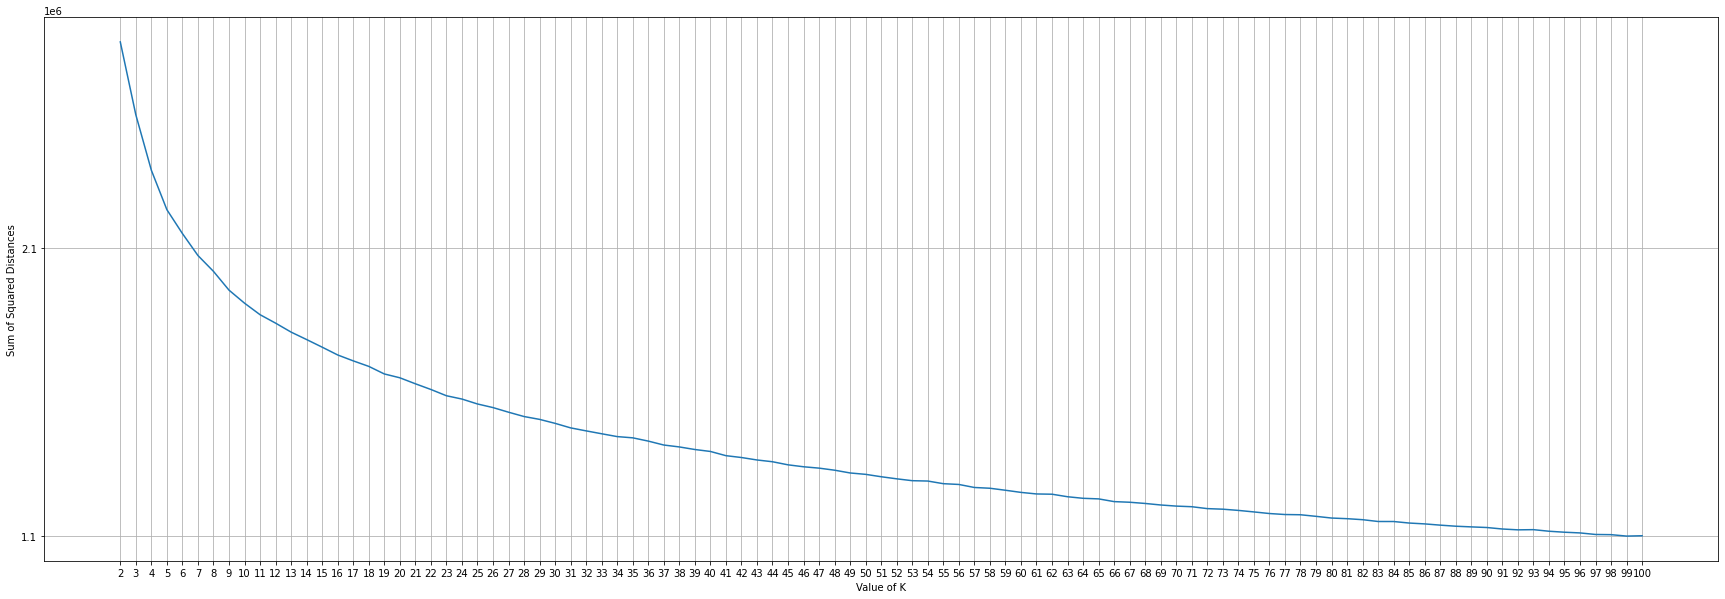

In [16]:
import numpy as np

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('Value of K')
ax.set_ylabel('Sum of Squared Distances')
ax.plot(list_of_k_candidates, k_candidate_sum_of_squared_distances)

# Ticks and grid
xticks = np.arange(min(list_of_k_candidates), max(list_of_k_candidates)+1)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(k_candidate_sum_of_squared_distances), 2), max(k_candidate_sum_of_squared_distances), 1000000)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')
plt.savefig(os.path.join(cwd, 'candidates_for_k_means_sum_of_squared_distances.png'))

The above plot looks like an arm with the distance going down as the number of clusters grow. The optimal number of clusters is the elbow of the plot above, which is arround 50 as more cluster don't have a significant decrease in the sum of squared distances compared to values before it. So we set the K to 50 and train our final K-Means Clustering Model

## Training and Saving the Model

In [17]:
from joblib import dump

print("Training the KMeans Model")
km_clustering_model = KMeans(n_clusters=50).fit(clustering_data)
dump(km_clustering_model, os.path.join(cwd, 'saved_models', 'k_means_model.pkl'))
print("Model Trained and Saved!")

Training the KMeans Model
Model Trained and Saved!


In [20]:
km_clustering_model.inertia_

3974952.8224406824